## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13085304496547358707
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7060815872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9453246073121425367
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_1-64'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 64 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    dense_1_outputs = dense_1(decoder_outputs_1)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_1
    states = [dh1, dc1]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 64)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

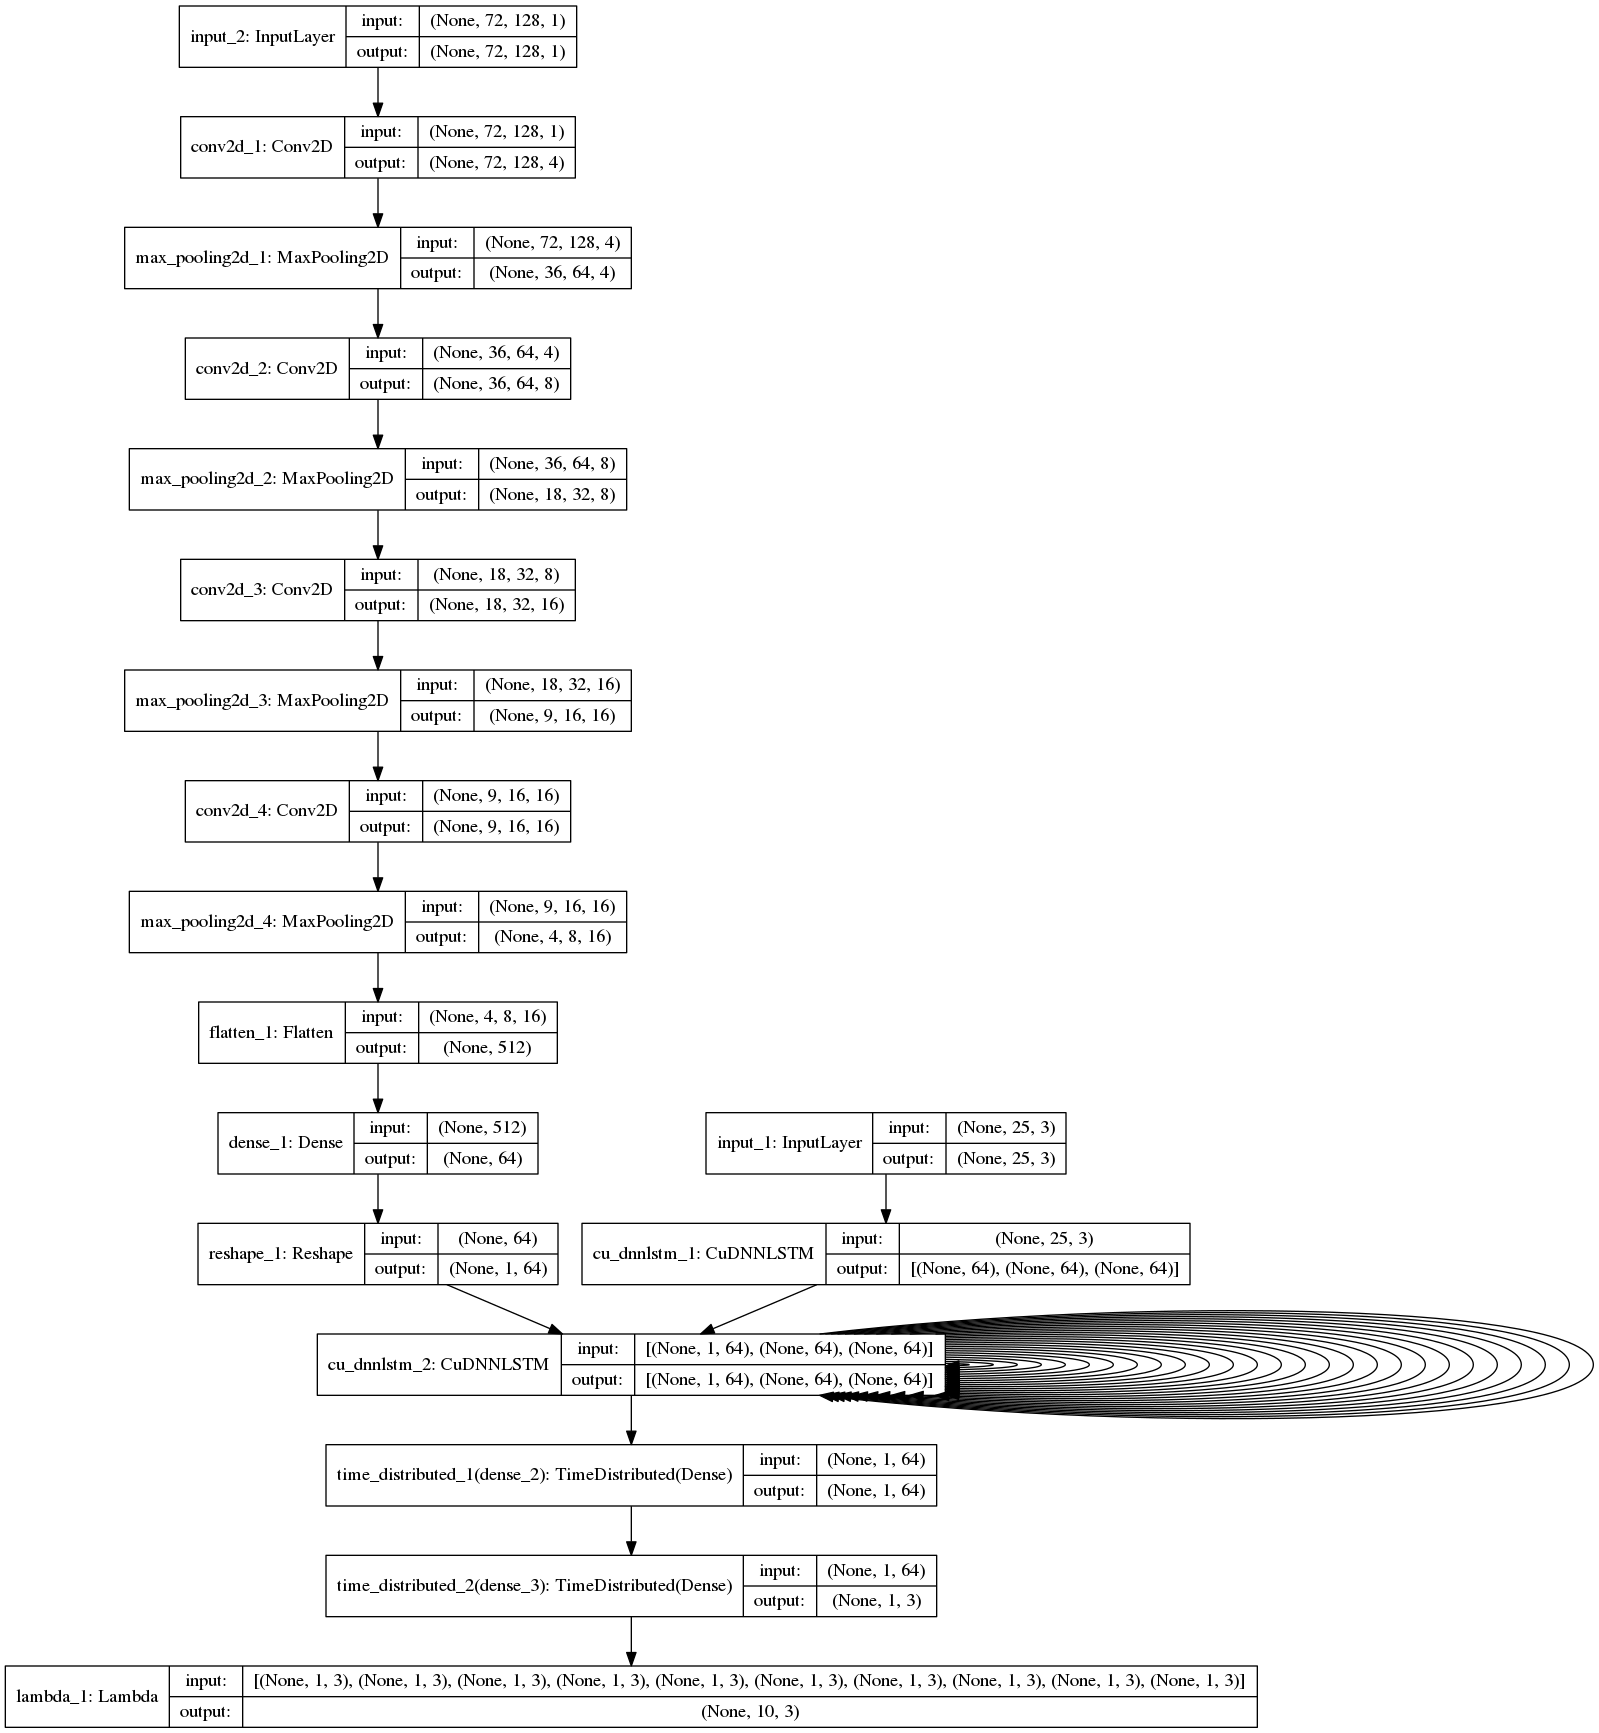

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


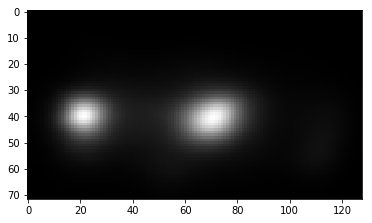

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 26:07 - loss: 0.1704 - rmse: 0.2227

  2/422 [..............................] - ETA: 21:44 - loss: 0.1434 - rmse: 0.2084

  3/422 [..............................] - ETA: 20:21 - loss: 0.1376 - rmse: 0.2054

  4/422 [..............................] - ETA: 19:34 - loss: 0.1313 - rmse: 0.2029

  5/422 [..............................] - ETA: 18:58 - loss: 0.1294 - rmse: 0.2151

  6/422 [..............................] - ETA: 18:37 - loss: 0.1201 - rmse: 0.2051

  7/422 [..............................] - ETA: 18:22 - loss: 0.1141 - rmse: 0.1980

  8/422 [..............................] - ETA: 18:07 - loss: 0.1107 - rmse: 0.2005

  9/422 [..............................] - ETA: 18:01 - loss: 0.1039 - rmse: 0.1895

 10/422 [..............................] - ETA: 17:25 - loss: 0.1050 - rmse: 0.1935

 11/422 [..............................] - ETA: 17:22 - loss: 0.1067 - rmse: 0.1992

 12/422 [..............................] - ETA: 17:18 - loss: 0.1026 - rmse: 0.1961

 13/422 [..............................] - ETA: 17:15 - loss: 0.1024 - rmse: 0.1985

 14/422 [..............................] - ETA: 17:12 - loss: 0.0988 - rmse: 0.1913

 15/422 [>.............................] - ETA: 17:07 - loss: 0.0971 - rmse: 0.1920

 16/422 [>.............................] - ETA: 17:05 - loss: 0.0932 - rmse: 0.1860

 17/422 [>.............................] - ETA: 17:03 - loss: 0.0929 - rmse: 0.1890

 18/422 [>.............................] - ETA: 16:59 - loss: 0.0931 - rmse: 0.1906

 19/422 [>.............................] - ETA: 16:56 - loss: 0.0907 - rmse: 0.1872

 20/422 [>.............................] - ETA: 16:52 - loss: 0.0904 - rmse: 0.1886

 21/422 [>.............................] - ETA: 16:52 - loss: 0.0910 - rmse: 0.1933

 22/422 [>.............................] - ETA: 16:12 - loss: 0.0894 - rmse: 0.1897

 23/422 [>.............................] - ETA: 16:12 - loss: 0.0865 - rmse: 0.1834

 24/422 [>.............................] - ETA: 16:05 - loss: 0.0860 - rmse: 0.1833

 25/422 [>.............................] - ETA: 15:32 - loss: 0.0848 - rmse: 0.1818

 26/422 [>.............................] - ETA: 15:01 - loss: 0.0836 - rmse: 0.1794

 27/422 [>.............................] - ETA: 14:53 - loss: 0.0828 - rmse: 0.1778

 28/422 [>.............................] - ETA: 14:54 - loss: 0.0808 - rmse: 0.1736

 29/422 [=>............................] - ETA: 14:55 - loss: 0.0796 - rmse: 0.1723

 30/422 [=>............................] - ETA: 14:56 - loss: 0.0786 - rmse: 0.1697

 31/422 [=>............................] - ETA: 14:56 - loss: 0.0788 - rmse: 0.1710

 32/422 [=>............................] - ETA: 14:58 - loss: 0.0782 - rmse: 0.1707

 33/422 [=>............................] - ETA: 14:34 - loss: 0.0776 - rmse: 0.1699

 34/422 [=>............................] - ETA: 14:27 - loss: 0.0771 - rmse: 0.1698

 35/422 [=>............................] - ETA: 14:27 - loss: 0.0774 - rmse: 0.1721

 36/422 [=>............................] - ETA: 14:28 - loss: 0.0773 - rmse: 0.1725

 37/422 [=>............................] - ETA: 14:28 - loss: 0.0766 - rmse: 0.1713

 38/422 [=>............................] - ETA: 14:29 - loss: 0.0764 - rmse: 0.1712

 39/422 [=>............................] - ETA: 14:09 - loss: 0.0769 - rmse: 0.1730

 40/422 [=>............................] - ETA: 14:10 - loss: 0.0757 - rmse: 0.1715

 41/422 [=>............................] - ETA: 14:11 - loss: 0.0762 - rmse: 0.1732

 42/422 [=>............................] - ETA: 13:53 - loss: 0.0762 - rmse: 0.1734

 43/422 [==>...........................] - ETA: 13:54 - loss: 0.0754 - rmse: 0.1718

 44/422 [==>...........................] - ETA: 13:55 - loss: 0.0750 - rmse: 0.1710

 45/422 [==>...........................] - ETA: 13:55 - loss: 0.0750 - rmse: 0.1720

 46/422 [==>...........................] - ETA: 13:56 - loss: 0.0752 - rmse: 0.1740

 47/422 [==>...........................] - ETA: 13:57 - loss: 0.0748 - rmse: 0.1734

 48/422 [==>...........................] - ETA: 13:40 - loss: 0.0745 - rmse: 0.1742

 49/422 [==>...........................] - ETA: 13:25 - loss: 0.0737 - rmse: 0.1727

 50/422 [==>...........................] - ETA: 13:25 - loss: 0.0731 - rmse: 0.1717

 51/422 [==>...........................] - ETA: 13:11 - loss: 0.0728 - rmse: 0.1716

 52/422 [==>...........................] - ETA: 13:11 - loss: 0.0717 - rmse: 0.1696

 53/422 [==>...........................] - ETA: 13:12 - loss: 0.0716 - rmse: 0.1695

 54/422 [==>...........................] - ETA: 13:11 - loss: 0.0728 - rmse: 0.1730

 55/422 [==>...........................] - ETA: 13:12 - loss: 0.0725 - rmse: 0.1730

 56/422 [==>...........................] - ETA: 13:12 - loss: 0.0729 - rmse: 0.1749

 57/422 [===>..........................] - ETA: 13:11 - loss: 0.0722 - rmse: 0.1741

 58/422 [===>..........................] - ETA: 12:59 - loss: 0.0714 - rmse: 0.1728

 59/422 [===>..........................] - ETA: 12:55 - loss: 0.0718 - rmse: 0.1732

 60/422 [===>..........................] - ETA: 12:54 - loss: 0.0711 - rmse: 0.1716

 61/422 [===>..........................] - ETA: 12:54 - loss: 0.0710 - rmse: 0.1713

 62/422 [===>..........................] - ETA: 12:55 - loss: 0.0707 - rmse: 0.1704

 63/422 [===>..........................] - ETA: 12:55 - loss: 0.0704 - rmse: 0.1700

 64/422 [===>..........................] - ETA: 12:55 - loss: 0.0704 - rmse: 0.1702

 65/422 [===>..........................] - ETA: 12:44 - loss: 0.0702 - rmse: 0.1702

 66/422 [===>..........................] - ETA: 12:33 - loss: 0.0699 - rmse: 0.1700

 67/422 [===>..........................] - ETA: 12:33 - loss: 0.0696 - rmse: 0.1695

 68/422 [===>..........................] - ETA: 12:33 - loss: 0.0692 - rmse: 0.1692

 69/422 [===>..........................] - ETA: 12:33 - loss: 0.0689 - rmse: 0.1685

 70/422 [===>..........................] - ETA: 12:32 - loss: 0.0691 - rmse: 0.1690

 71/422 [====>.........................] - ETA: 12:32 - loss: 0.0690 - rmse: 0.1686

 72/422 [====>.........................] - ETA: 12:32 - loss: 0.0691 - rmse: 0.1690

 73/422 [====>.........................] - ETA: 12:31 - loss: 0.0690 - rmse: 0.1686

 74/422 [====>.........................] - ETA: 12:30 - loss: 0.0685 - rmse: 0.1675

 75/422 [====>.........................] - ETA: 12:28 - loss: 0.0686 - rmse: 0.1679

 76/422 [====>.........................] - ETA: 12:19 - loss: 0.0681 - rmse: 0.1668

 77/422 [====>.........................] - ETA: 12:18 - loss: 0.0683 - rmse: 0.1675

 78/422 [====>.........................] - ETA: 12:09 - loss: 0.0677 - rmse: 0.1660

 79/422 [====>.........................] - ETA: 12:08 - loss: 0.0680 - rmse: 0.1668

 80/422 [====>.........................] - ETA: 12:08 - loss: 0.0674 - rmse: 0.1652

 81/422 [====>.........................] - ETA: 12:07 - loss: 0.0681 - rmse: 0.1670

 82/422 [====>.........................] - ETA: 11:58 - loss: 0.0674 - rmse: 0.1653

 83/422 [====>.........................] - ETA: 11:49 - loss: 0.0677 - rmse: 0.1669

 84/422 [====>.........................] - ETA: 11:48 - loss: 0.0676 - rmse: 0.1668

 85/422 [=====>........................] - ETA: 11:47 - loss: 0.0675 - rmse: 0.1666

 86/422 [=====>........................] - ETA: 11:47 - loss: 0.0670 - rmse: 0.1654

 87/422 [=====>........................] - ETA: 11:46 - loss: 0.0668 - rmse: 0.1657

 88/422 [=====>........................] - ETA: 11:38 - loss: 0.0668 - rmse: 0.1656

 89/422 [=====>........................] - ETA: 11:35 - loss: 0.0669 - rmse: 0.1658

 90/422 [=====>........................] - ETA: 11:34 - loss: 0.0670 - rmse: 0.1659

 91/422 [=====>........................] - ETA: 11:34 - loss: 0.0669 - rmse: 0.1658

 92/422 [=====>........................] - ETA: 11:26 - loss: 0.0663 - rmse: 0.1642

 93/422 [=====>........................] - ETA: 11:25 - loss: 0.0663 - rmse: 0.1648

 94/422 [=====>........................] - ETA: 11:24 - loss: 0.0659 - rmse: 0.1646

 95/422 [=====>........................] - ETA: 11:24 - loss: 0.0669 - rmse: 0.1674

 96/422 [=====>........................] - ETA: 11:17 - loss: 0.0671 - rmse: 0.1678

 97/422 [=====>........................] - ETA: 11:16 - loss: 0.0675 - rmse: 0.1686

 98/422 [=====>........................] - ETA: 11:16 - loss: 0.0674 - rmse: 0.1688

 99/422 [======>.......................] - ETA: 11:09 - loss: 0.0676 - rmse: 0.1696

100/422 [======>.......................] - ETA: 11:07 - loss: 0.0678 - rmse: 0.1697

101/422 [======>.......................] - ETA: 11:07 - loss: 0.0683 - rmse: 0.1709

102/422 [======>.......................] - ETA: 11:06 - loss: 0.0681 - rmse: 0.1706

103/422 [======>.......................] - ETA: 11:05 - loss: 0.0682 - rmse: 0.1710

104/422 [======>.......................] - ETA: 11:02 - loss: 0.0684 - rmse: 0.1717

105/422 [======>.......................] - ETA: 11:01 - loss: 0.0683 - rmse: 0.1712

106/422 [======>.......................] - ETA: 11:01 - loss: 0.0683 - rmse: 0.1711

107/422 [======>.......................] - ETA: 11:00 - loss: 0.0681 - rmse: 0.1711

108/422 [======>.......................] - ETA: 11:00 - loss: 0.0681 - rmse: 0.1712

109/422 [======>.......................] - ETA: 11:00 - loss: 0.0683 - rmse: 0.1721

110/422 [======>.......................] - ETA: 10:53 - loss: 0.0683 - rmse: 0.1725

111/422 [======>.......................] - ETA: 10:46 - loss: 0.0680 - rmse: 0.1716

112/422 [======>.......................] - ETA: 10:44 - loss: 0.0675 - rmse: 0.1705

113/422 [=======>......................] - ETA: 10:43 - loss: 0.0677 - rmse: 0.1709

114/422 [=======>......................] - ETA: 10:36 - loss: 0.0678 - rmse: 0.1711

115/422 [=======>......................] - ETA: 10:30 - loss: 0.0678 - rmse: 0.1711

116/422 [=======>......................] - ETA: 10:29 - loss: 0.0678 - rmse: 0.1716

117/422 [=======>......................] - ETA: 10:28 - loss: 0.0686 - rmse: 0.1734

118/422 [=======>......................] - ETA: 10:27 - loss: 0.0684 - rmse: 0.1729

119/422 [=======>......................] - ETA: 10:25 - loss: 0.0685 - rmse: 0.1731

120/422 [=======>......................] - ETA: 10:18 - loss: 0.0684 - rmse: 0.1735

121/422 [=======>......................] - ETA: 10:18 - loss: 0.0685 - rmse: 0.1736

122/422 [=======>......................] - ETA: 10:12 - loss: 0.0683 - rmse: 0.1732

123/422 [=======>......................] - ETA: 10:06 - loss: 0.0683 - rmse: 0.1730

124/422 [=======>......................] - ETA: 10:00 - loss: 0.0680 - rmse: 0.1722

125/422 [=======>......................] - ETA: 9:59 - loss: 0.0678 - rmse: 0.1715 

126/422 [=======>......................] - ETA: 9:58 - loss: 0.0677 - rmse: 0.1713

127/422 [========>.....................] - ETA: 9:56 - loss: 0.0677 - rmse: 0.1710

128/422 [========>.....................] - ETA: 9:51 - loss: 0.0679 - rmse: 0.1714

129/422 [========>.....................] - ETA: 9:50 - loss: 0.0679 - rmse: 0.1714

130/422 [========>.....................] - ETA: 9:48 - loss: 0.0684 - rmse: 0.1724

131/422 [========>.....................] - ETA: 9:47 - loss: 0.0682 - rmse: 0.1718

132/422 [========>.....................] - ETA: 9:41 - loss: 0.0682 - rmse: 0.1719

133/422 [========>.....................] - ETA: 9:36 - loss: 0.0681 - rmse: 0.1714

134/422 [========>.....................] - ETA: 9:35 - loss: 0.0677 - rmse: 0.1705

135/422 [========>.....................] - ETA: 9:30 - loss: 0.0679 - rmse: 0.1710

136/422 [========>.....................] - ETA: 9:25 - loss: 0.0682 - rmse: 0.1717

137/422 [========>.....................] - ETA: 9:24 - loss: 0.0683 - rmse: 0.1722

138/422 [========>.....................] - ETA: 9:19 - loss: 0.0685 - rmse: 0.1729

139/422 [========>.....................] - ETA: 9:18 - loss: 0.0685 - rmse: 0.1732

140/422 [========>.....................] - ETA: 9:13 - loss: 0.0684 - rmse: 0.1733

141/422 [=========>....................] - ETA: 9:08 - loss: 0.0685 - rmse: 0.1740

142/422 [=========>....................] - ETA: 9:03 - loss: 0.0683 - rmse: 0.1734

143/422 [=========>....................] - ETA: 9:03 - loss: 0.0685 - rmse: 0.1741

144/422 [=========>....................] - ETA: 9:01 - loss: 0.0682 - rmse: 0.1741

145/422 [=========>....................] - ETA: 9:00 - loss: 0.0682 - rmse: 0.1740

146/422 [=========>....................] - ETA: 8:56 - loss: 0.0682 - rmse: 0.1742

147/422 [=========>....................] - ETA: 8:51 - loss: 0.0681 - rmse: 0.1740

148/422 [=========>....................] - ETA: 8:46 - loss: 0.0680 - rmse: 0.1735

149/422 [=========>....................] - ETA: 8:42 - loss: 0.0679 - rmse: 0.1731

150/422 [=========>....................] - ETA: 8:40 - loss: 0.0679 - rmse: 0.1731

151/422 [=========>....................] - ETA: 8:39 - loss: 0.0677 - rmse: 0.1727

152/422 [=========>....................] - ETA: 8:38 - loss: 0.0676 - rmse: 0.1726

153/422 [=========>....................] - ETA: 8:34 - loss: 0.0674 - rmse: 0.1720

154/422 [=========>....................] - ETA: 8:33 - loss: 0.0670 - rmse: 0.1712

155/422 [==========>...................] - ETA: 8:29 - loss: 0.0670 - rmse: 0.1713

156/422 [==========>...................] - ETA: 8:24 - loss: 0.0671 - rmse: 0.1714

157/422 [==========>...................] - ETA: 8:20 - loss: 0.0670 - rmse: 0.1713

158/422 [==========>...................] - ETA: 8:16 - loss: 0.0668 - rmse: 0.1713

159/422 [==========>...................] - ETA: 8:11 - loss: 0.0669 - rmse: 0.1715

160/422 [==========>...................] - ETA: 8:11 - loss: 0.0671 - rmse: 0.1720

161/422 [==========>...................] - ETA: 8:06 - loss: 0.0672 - rmse: 0.1721

162/422 [==========>...................] - ETA: 8:02 - loss: 0.0672 - rmse: 0.1721

163/422 [==========>...................] - ETA: 8:01 - loss: 0.0670 - rmse: 0.1717

164/422 [==========>...................] - ETA: 8:00 - loss: 0.0672 - rmse: 0.1723

165/422 [==========>...................] - ETA: 7:56 - loss: 0.0673 - rmse: 0.1726

166/422 [==========>...................] - ETA: 7:53 - loss: 0.0672 - rmse: 0.1723

167/422 [==========>...................] - ETA: 7:49 - loss: 0.0671 - rmse: 0.1722

168/422 [==========>...................] - ETA: 7:48 - loss: 0.0673 - rmse: 0.1731

169/422 [===========>..................] - ETA: 7:44 - loss: 0.0672 - rmse: 0.1727

170/422 [===========>..................] - ETA: 7:43 - loss: 0.0671 - rmse: 0.1727

171/422 [===========>..................] - ETA: 7:42 - loss: 0.0673 - rmse: 0.1734

172/422 [===========>..................] - ETA: 7:40 - loss: 0.0674 - rmse: 0.1735

173/422 [===========>..................] - ETA: 7:37 - loss: 0.0673 - rmse: 0.1739

174/422 [===========>..................] - ETA: 7:33 - loss: 0.0673 - rmse: 0.1743

175/422 [===========>..................] - ETA: 7:32 - loss: 0.0676 - rmse: 0.1749

176/422 [===========>..................] - ETA: 7:30 - loss: 0.0674 - rmse: 0.1743

177/422 [===========>..................] - ETA: 7:29 - loss: 0.0674 - rmse: 0.1748

178/422 [===========>..................] - ETA: 7:29 - loss: 0.0674 - rmse: 0.1749

179/422 [===========>..................] - ETA: 7:25 - loss: 0.0674 - rmse: 0.1750

180/422 [===========>..................] - ETA: 7:21 - loss: 0.0674 - rmse: 0.1752

181/422 [===========>..................] - ETA: 7:20 - loss: 0.0672 - rmse: 0.1745

182/422 [===========>..................] - ETA: 7:16 - loss: 0.0671 - rmse: 0.1746

183/422 [============>.................] - ETA: 7:12 - loss: 0.0671 - rmse: 0.1745

184/422 [============>.................] - ETA: 7:09 - loss: 0.0670 - rmse: 0.1742

185/422 [============>.................] - ETA: 7:05 - loss: 0.0671 - rmse: 0.1747

186/422 [============>.................] - ETA: 7:04 - loss: 0.0671 - rmse: 0.1748

187/422 [============>.................] - ETA: 7:01 - loss: 0.0674 - rmse: 0.1758

188/422 [============>.................] - ETA: 7:00 - loss: 0.0672 - rmse: 0.1753

189/422 [============>.................] - ETA: 6:59 - loss: 0.0672 - rmse: 0.1754

190/422 [============>.................] - ETA: 6:56 - loss: 0.0672 - rmse: 0.1752

191/422 [============>.................] - ETA: 6:54 - loss: 0.0673 - rmse: 0.1755

192/422 [============>.................] - ETA: 6:51 - loss: 0.0672 - rmse: 0.1753

193/422 [============>.................] - ETA: 6:48 - loss: 0.0672 - rmse: 0.1753

194/422 [============>.................] - ETA: 6:47 - loss: 0.0674 - rmse: 0.1760

195/422 [============>.................] - ETA: 6:46 - loss: 0.0675 - rmse: 0.1761

196/422 [============>.................] - ETA: 6:44 - loss: 0.0677 - rmse: 0.1766

197/422 [=============>................] - ETA: 6:43 - loss: 0.0676 - rmse: 0.1762

198/422 [=============>................] - ETA: 6:40 - loss: 0.0676 - rmse: 0.1764

199/422 [=============>................] - ETA: 6:38 - loss: 0.0679 - rmse: 0.1772

200/422 [=============>................] - ETA: 6:35 - loss: 0.0680 - rmse: 0.1773

201/422 [=============>................] - ETA: 6:34 - loss: 0.0680 - rmse: 0.1775

202/422 [=============>................] - ETA: 6:31 - loss: 0.0680 - rmse: 0.1774

203/422 [=============>................] - ETA: 6:27 - loss: 0.0681 - rmse: 0.1775

204/422 [=============>................] - ETA: 6:24 - loss: 0.0680 - rmse: 0.1771

205/422 [=============>................] - ETA: 6:21 - loss: 0.0679 - rmse: 0.1771

206/422 [=============>................] - ETA: 6:18 - loss: 0.0677 - rmse: 0.1767

207/422 [=============>................] - ETA: 6:15 - loss: 0.0677 - rmse: 0.1765

208/422 [=============>................] - ETA: 6:13 - loss: 0.0678 - rmse: 0.1770

209/422 [=============>................] - ETA: 6:13 - loss: 0.0678 - rmse: 0.1768

210/422 [=============>................] - ETA: 6:12 - loss: 0.0677 - rmse: 0.1766

211/422 [==============>...............] - ETA: 6:09 - loss: 0.0675 - rmse: 0.1761

212/422 [==============>...............] - ETA: 6:06 - loss: 0.0675 - rmse: 0.1762

213/422 [==============>...............] - ETA: 6:05 - loss: 0.0674 - rmse: 0.1759

214/422 [==============>...............] - ETA: 6:04 - loss: 0.0676 - rmse: 0.1765

215/422 [==============>...............] - ETA: 6:03 - loss: 0.0674 - rmse: 0.1760

216/422 [==============>...............] - ETA: 6:02 - loss: 0.0674 - rmse: 0.1761

217/422 [==============>...............] - ETA: 5:59 - loss: 0.0674 - rmse: 0.1761

218/422 [==============>...............] - ETA: 5:57 - loss: 0.0673 - rmse: 0.1760

219/422 [==============>...............] - ETA: 5:56 - loss: 0.0672 - rmse: 0.1756

220/422 [==============>...............] - ETA: 5:53 - loss: 0.0670 - rmse: 0.1753

221/422 [==============>...............] - ETA: 5:50 - loss: 0.0670 - rmse: 0.1754

222/422 [==============>...............] - ETA: 5:48 - loss: 0.0668 - rmse: 0.1747

223/422 [==============>...............] - ETA: 5:45 - loss: 0.0667 - rmse: 0.1746

224/422 [==============>...............] - ETA: 5:44 - loss: 0.0666 - rmse: 0.1743

225/422 [==============>...............] - ETA: 5:42 - loss: 0.0667 - rmse: 0.1743

226/422 [===============>..............] - ETA: 5:40 - loss: 0.0666 - rmse: 0.1740

227/422 [===============>..............] - ETA: 5:37 - loss: 0.0666 - rmse: 0.1740

228/422 [===============>..............] - ETA: 5:36 - loss: 0.0665 - rmse: 0.1738

229/422 [===============>..............] - ETA: 5:34 - loss: 0.0665 - rmse: 0.1737

230/422 [===============>..............] - ETA: 5:32 - loss: 0.0667 - rmse: 0.1740

231/422 [===============>..............] - ETA: 5:29 - loss: 0.0666 - rmse: 0.1738

232/422 [===============>..............] - ETA: 5:28 - loss: 0.0666 - rmse: 0.1741

233/422 [===============>..............] - ETA: 5:25 - loss: 0.0665 - rmse: 0.1738

234/422 [===============>..............] - ETA: 5:22 - loss: 0.0668 - rmse: 0.1744

235/422 [===============>..............] - ETA: 5:21 - loss: 0.0668 - rmse: 0.1745

236/422 [===============>..............] - ETA: 5:20 - loss: 0.0668 - rmse: 0.1745

237/422 [===============>..............] - ETA: 5:17 - loss: 0.0667 - rmse: 0.1745

238/422 [===============>..............] - ETA: 5:16 - loss: 0.0669 - rmse: 0.1747

239/422 [===============>..............] - ETA: 5:15 - loss: 0.0668 - rmse: 0.1746

240/422 [================>.............] - ETA: 5:13 - loss: 0.0668 - rmse: 0.1746

241/422 [================>.............] - ETA: 5:11 - loss: 0.0667 - rmse: 0.1747

242/422 [================>.............] - ETA: 5:08 - loss: 0.0667 - rmse: 0.1747

243/422 [================>.............] - ETA: 5:07 - loss: 0.0665 - rmse: 0.1744

244/422 [================>.............] - ETA: 5:06 - loss: 0.0664 - rmse: 0.1742

245/422 [================>.............] - ETA: 5:03 - loss: 0.0664 - rmse: 0.1741

246/422 [================>.............] - ETA: 5:01 - loss: 0.0664 - rmse: 0.1739

247/422 [================>.............] - ETA: 5:00 - loss: 0.0662 - rmse: 0.1734

248/422 [================>.............] - ETA: 4:57 - loss: 0.0662 - rmse: 0.1736

249/422 [================>.............] - ETA: 4:54 - loss: 0.0662 - rmse: 0.1736

250/422 [================>.............] - ETA: 4:53 - loss: 0.0661 - rmse: 0.1733

251/422 [================>.............] - ETA: 4:52 - loss: 0.0660 - rmse: 0.1734

252/422 [================>.............] - ETA: 4:50 - loss: 0.0660 - rmse: 0.1731

253/422 [================>.............] - ETA: 4:47 - loss: 0.0659 - rmse: 0.1728

254/422 [=================>............] - ETA: 4:46 - loss: 0.0658 - rmse: 0.1727

255/422 [=================>............] - ETA: 4:43 - loss: 0.0658 - rmse: 0.1727

256/422 [=================>............] - ETA: 4:41 - loss: 0.0658 - rmse: 0.1728

257/422 [=================>............] - ETA: 4:38 - loss: 0.0659 - rmse: 0.1730

258/422 [=================>............] - ETA: 4:36 - loss: 0.0659 - rmse: 0.1730

259/422 [=================>............] - ETA: 4:33 - loss: 0.0657 - rmse: 0.1727

260/422 [=================>............] - ETA: 4:31 - loss: 0.0658 - rmse: 0.1729

261/422 [=================>............] - ETA: 4:30 - loss: 0.0658 - rmse: 0.1730

262/422 [=================>............] - ETA: 4:27 - loss: 0.0656 - rmse: 0.1726

263/422 [=================>............] - ETA: 4:25 - loss: 0.0656 - rmse: 0.1727

264/422 [=================>............] - ETA: 4:23 - loss: 0.0655 - rmse: 0.1726

265/422 [=================>............] - ETA: 4:20 - loss: 0.0655 - rmse: 0.1726

266/422 [=================>............] - ETA: 4:19 - loss: 0.0657 - rmse: 0.1730

267/422 [=================>............] - ETA: 4:17 - loss: 0.0657 - rmse: 0.1729

268/422 [==================>...........] - ETA: 4:16 - loss: 0.0657 - rmse: 0.1731

269/422 [==================>...........] - ETA: 4:13 - loss: 0.0656 - rmse: 0.1728

270/422 [==================>...........] - ETA: 4:11 - loss: 0.0656 - rmse: 0.1729

271/422 [==================>...........] - ETA: 4:10 - loss: 0.0655 - rmse: 0.1727

272/422 [==================>...........] - ETA: 4:07 - loss: 0.0654 - rmse: 0.1723

273/422 [==================>...........] - ETA: 4:06 - loss: 0.0654 - rmse: 0.1722

274/422 [==================>...........] - ETA: 4:04 - loss: 0.0654 - rmse: 0.1724

275/422 [==================>...........] - ETA: 4:03 - loss: 0.0653 - rmse: 0.1723

276/422 [==================>...........] - ETA: 4:00 - loss: 0.0653 - rmse: 0.1723

277/422 [==================>...........] - ETA: 3:58 - loss: 0.0653 - rmse: 0.1724

278/422 [==================>...........] - ETA: 3:56 - loss: 0.0652 - rmse: 0.1722

279/422 [==================>...........] - ETA: 3:55 - loss: 0.0651 - rmse: 0.1719

280/422 [==================>...........] - ETA: 3:52 - loss: 0.0651 - rmse: 0.1719

281/422 [==================>...........] - ETA: 3:50 - loss: 0.0651 - rmse: 0.1718

282/422 [===================>..........] - ETA: 3:49 - loss: 0.0651 - rmse: 0.1721

283/422 [===================>..........] - ETA: 3:47 - loss: 0.0651 - rmse: 0.1722

284/422 [===================>..........] - ETA: 3:45 - loss: 0.0651 - rmse: 0.1724

285/422 [===================>..........] - ETA: 3:42 - loss: 0.0651 - rmse: 0.1724

286/422 [===================>..........] - ETA: 3:40 - loss: 0.0651 - rmse: 0.1723

287/422 [===================>..........] - ETA: 3:39 - loss: 0.0650 - rmse: 0.1720

288/422 [===================>..........] - ETA: 3:38 - loss: 0.0649 - rmse: 0.1718

289/422 [===================>..........] - ETA: 3:36 - loss: 0.0649 - rmse: 0.1718

290/422 [===================>..........] - ETA: 3:33 - loss: 0.0649 - rmse: 0.1719

291/422 [===================>..........] - ETA: 3:31 - loss: 0.0648 - rmse: 0.1718

292/422 [===================>..........] - ETA: 3:29 - loss: 0.0648 - rmse: 0.1717

293/422 [===================>..........] - ETA: 3:28 - loss: 0.0647 - rmse: 0.1713

294/422 [===================>..........] - ETA: 3:26 - loss: 0.0647 - rmse: 0.1713

295/422 [===================>..........] - ETA: 3:25 - loss: 0.0647 - rmse: 0.1715

296/422 [====================>.........] - ETA: 3:23 - loss: 0.0646 - rmse: 0.1714

297/422 [====================>.........] - ETA: 3:21 - loss: 0.0647 - rmse: 0.1716

298/422 [====================>.........] - ETA: 3:20 - loss: 0.0645 - rmse: 0.1713

299/422 [====================>.........] - ETA: 3:18 - loss: 0.0645 - rmse: 0.1714

300/422 [====================>.........] - ETA: 3:17 - loss: 0.0645 - rmse: 0.1713

301/422 [====================>.........] - ETA: 3:15 - loss: 0.0647 - rmse: 0.1716

302/422 [====================>.........] - ETA: 3:12 - loss: 0.0646 - rmse: 0.1714

303/422 [====================>.........] - ETA: 3:10 - loss: 0.0645 - rmse: 0.1710

304/422 [====================>.........] - ETA: 3:08 - loss: 0.0645 - rmse: 0.1713

305/422 [====================>.........] - ETA: 3:07 - loss: 0.0643 - rmse: 0.1708

306/422 [====================>.........] - ETA: 3:05 - loss: 0.0642 - rmse: 0.1706

307/422 [====================>.........] - ETA: 3:03 - loss: 0.0644 - rmse: 0.1709

308/422 [====================>.........] - ETA: 3:01 - loss: 0.0644 - rmse: 0.1710

309/422 [====================>.........] - ETA: 2:59 - loss: 0.0643 - rmse: 0.1707

310/422 [=====================>........] - ETA: 2:58 - loss: 0.0642 - rmse: 0.1708

311/422 [=====================>........] - ETA: 2:56 - loss: 0.0642 - rmse: 0.1705

312/422 [=====================>........] - ETA: 2:54 - loss: 0.0641 - rmse: 0.1704

313/422 [=====================>........] - ETA: 2:52 - loss: 0.0641 - rmse: 0.1702

314/422 [=====================>........] - ETA: 2:51 - loss: 0.0641 - rmse: 0.1702

315/422 [=====================>........] - ETA: 2:49 - loss: 0.0640 - rmse: 0.1701

316/422 [=====================>........] - ETA: 2:47 - loss: 0.0641 - rmse: 0.1701

317/422 [=====================>........] - ETA: 2:46 - loss: 0.0641 - rmse: 0.1701

318/422 [=====================>........] - ETA: 2:45 - loss: 0.0641 - rmse: 0.1701

319/422 [=====================>........] - ETA: 2:43 - loss: 0.0641 - rmse: 0.1700

320/422 [=====================>........] - ETA: 2:42 - loss: 0.0641 - rmse: 0.1699

321/422 [=====================>........] - ETA: 2:40 - loss: 0.0640 - rmse: 0.1698

322/422 [=====================>........] - ETA: 2:38 - loss: 0.0643 - rmse: 0.1704

323/422 [=====================>........] - ETA: 2:36 - loss: 0.0643 - rmse: 0.1705

324/422 [======================>.......] - ETA: 2:34 - loss: 0.0643 - rmse: 0.1706

325/422 [======================>.......] - ETA: 2:33 - loss: 0.0642 - rmse: 0.1704

326/422 [======================>.......] - ETA: 2:31 - loss: 0.0641 - rmse: 0.1702

327/422 [======================>.......] - ETA: 2:29 - loss: 0.0641 - rmse: 0.1703

328/422 [======================>.......] - ETA: 2:28 - loss: 0.0640 - rmse: 0.1700

329/422 [======================>.......] - ETA: 2:27 - loss: 0.0641 - rmse: 0.1703

330/422 [======================>.......] - ETA: 2:25 - loss: 0.0641 - rmse: 0.1703

331/422 [======================>.......] - ETA: 2:24 - loss: 0.0641 - rmse: 0.1702

332/422 [======================>.......] - ETA: 2:22 - loss: 0.0642 - rmse: 0.1703

333/422 [======================>.......] - ETA: 2:20 - loss: 0.0643 - rmse: 0.1704

334/422 [======================>.......] - ETA: 2:19 - loss: 0.0642 - rmse: 0.1703

335/422 [======================>.......] - ETA: 2:17 - loss: 0.0640 - rmse: 0.1700

336/422 [======================>.......] - ETA: 2:15 - loss: 0.0642 - rmse: 0.1703

337/422 [======================>.......] - ETA: 2:13 - loss: 0.0641 - rmse: 0.1701

338/422 [=======================>......] - ETA: 2:12 - loss: 0.0641 - rmse: 0.1701

339/422 [=======================>......] - ETA: 2:11 - loss: 0.0641 - rmse: 0.1699

340/422 [=======================>......] - ETA: 2:09 - loss: 0.0641 - rmse: 0.1699

341/422 [=======================>......] - ETA: 2:08 - loss: 0.0640 - rmse: 0.1697

342/422 [=======================>......] - ETA: 2:06 - loss: 0.0640 - rmse: 0.1697

343/422 [=======================>......] - ETA: 2:04 - loss: 0.0640 - rmse: 0.1697

344/422 [=======================>......] - ETA: 2:03 - loss: 0.0641 - rmse: 0.1700

345/422 [=======================>......] - ETA: 2:01 - loss: 0.0641 - rmse: 0.1700

346/422 [=======================>......] - ETA: 1:59 - loss: 0.0640 - rmse: 0.1698

347/422 [=======================>......] - ETA: 1:57 - loss: 0.0639 - rmse: 0.1696

348/422 [=======================>......] - ETA: 1:56 - loss: 0.0638 - rmse: 0.1692

349/422 [=======================>......] - ETA: 1:54 - loss: 0.0638 - rmse: 0.1693

350/422 [=======================>......] - ETA: 1:52 - loss: 0.0638 - rmse: 0.1691

351/422 [=======================>......] - ETA: 1:51 - loss: 0.0637 - rmse: 0.1690

352/422 [========================>.....] - ETA: 1:49 - loss: 0.0637 - rmse: 0.1691

353/422 [========================>.....] - ETA: 1:47 - loss: 0.0637 - rmse: 0.1691

354/422 [========================>.....] - ETA: 1:46 - loss: 0.0636 - rmse: 0.1689

355/422 [========================>.....] - ETA: 1:45 - loss: 0.0635 - rmse: 0.1686

356/422 [========================>.....] - ETA: 1:43 - loss: 0.0635 - rmse: 0.1685

357/422 [========================>.....] - ETA: 1:41 - loss: 0.0636 - rmse: 0.1687

358/422 [========================>.....] - ETA: 1:40 - loss: 0.0635 - rmse: 0.1685

359/422 [========================>.....] - ETA: 1:38 - loss: 0.0635 - rmse: 0.1685

360/422 [========================>.....] - ETA: 1:37 - loss: 0.0636 - rmse: 0.1686

361/422 [========================>.....] - ETA: 1:35 - loss: 0.0636 - rmse: 0.1687

362/422 [========================>.....] - ETA: 1:33 - loss: 0.0635 - rmse: 0.1684

363/422 [========================>.....] - ETA: 1:32 - loss: 0.0635 - rmse: 0.1685

364/422 [========================>.....] - ETA: 1:30 - loss: 0.0637 - rmse: 0.1688

365/422 [========================>.....] - ETA: 1:28 - loss: 0.0636 - rmse: 0.1686

366/422 [=========================>....] - ETA: 1:27 - loss: 0.0636 - rmse: 0.1686

367/422 [=========================>....] - ETA: 1:26 - loss: 0.0635 - rmse: 0.1683

368/422 [=========================>....] - ETA: 1:24 - loss: 0.0635 - rmse: 0.1685

369/422 [=========================>....] - ETA: 1:22 - loss: 0.0636 - rmse: 0.1687

370/422 [=========================>....] - ETA: 1:20 - loss: 0.0635 - rmse: 0.1684

371/422 [=========================>....] - ETA: 1:19 - loss: 0.0636 - rmse: 0.1687

372/422 [=========================>....] - ETA: 1:17 - loss: 0.0636 - rmse: 0.1687

373/422 [=========================>....] - ETA: 1:15 - loss: 0.0637 - rmse: 0.1688

374/422 [=========================>....] - ETA: 1:14 - loss: 0.0636 - rmse: 0.1687

375/422 [=========================>....] - ETA: 1:12 - loss: 0.0636 - rmse: 0.1686

376/422 [=========================>....] - ETA: 1:10 - loss: 0.0636 - rmse: 0.1685

377/422 [=========================>....] - ETA: 1:09 - loss: 0.0635 - rmse: 0.1684

378/422 [=========================>....] - ETA: 1:07 - loss: 0.0636 - rmse: 0.1685

379/422 [=========================>....] - ETA: 1:05 - loss: 0.0635 - rmse: 0.1682

380/422 [==========================>...] - ETA: 1:04 - loss: 0.0636 - rmse: 0.1686

381/422 [==========================>...] - ETA: 1:02 - loss: 0.0636 - rmse: 0.1686

382/422 [==========================>...] - ETA: 1:01 - loss: 0.0636 - rmse: 0.1685

383/422 [==========================>...] - ETA: 59s - loss: 0.0636 - rmse: 0.1684 

384/422 [==========================>...] - ETA: 57s - loss: 0.0635 - rmse: 0.1683

385/422 [==========================>...] - ETA: 56s - loss: 0.0635 - rmse: 0.1683

386/422 [==========================>...] - ETA: 54s - loss: 0.0635 - rmse: 0.1683

387/422 [==========================>...] - ETA: 53s - loss: 0.0635 - rmse: 0.1683

388/422 [==========================>...] - ETA: 51s - loss: 0.0636 - rmse: 0.1685

389/422 [==========================>...] - ETA: 50s - loss: 0.0637 - rmse: 0.1688

390/422 [==========================>...] - ETA: 48s - loss: 0.0638 - rmse: 0.1691

391/422 [==========================>...] - ETA: 47s - loss: 0.0637 - rmse: 0.1690

392/422 [==========================>...] - ETA: 45s - loss: 0.0637 - rmse: 0.1691

393/422 [==========================>...] - ETA: 44s - loss: 0.0638 - rmse: 0.1692

394/422 [===========================>..] - ETA: 42s - loss: 0.0637 - rmse: 0.1691

395/422 [===========================>..] - ETA: 41s - loss: 0.0636 - rmse: 0.1689

396/422 [===========================>..] - ETA: 39s - loss: 0.0636 - rmse: 0.1688

397/422 [===========================>..] - ETA: 37s - loss: 0.0635 - rmse: 0.1687

398/422 [===========================>..] - ETA: 36s - loss: 0.0635 - rmse: 0.1686

399/422 [===========================>..] - ETA: 34s - loss: 0.0636 - rmse: 0.1689

400/422 [===========================>..] - ETA: 33s - loss: 0.0636 - rmse: 0.1689

401/422 [===========================>..] - ETA: 31s - loss: 0.0637 - rmse: 0.1691

402/422 [===========================>..] - ETA: 30s - loss: 0.0637 - rmse: 0.1693

403/422 [===========================>..] - ETA: 28s - loss: 0.0638 - rmse: 0.1695

404/422 [===========================>..] - ETA: 27s - loss: 0.0638 - rmse: 0.1693

405/422 [===========================>..] - ETA: 25s - loss: 0.0638 - rmse: 0.1693

406/422 [===========================>..] - ETA: 24s - loss: 0.0638 - rmse: 0.1693

407/422 [===========================>..] - ETA: 22s - loss: 0.0638 - rmse: 0.1694

408/422 [============================>.] - ETA: 21s - loss: 0.0638 - rmse: 0.1693

409/422 [============================>.] - ETA: 19s - loss: 0.0638 - rmse: 0.1692

410/422 [============================>.] - ETA: 18s - loss: 0.0637 - rmse: 0.1690

411/422 [============================>.] - ETA: 16s - loss: 0.0638 - rmse: 0.1692

412/422 [============================>.] - ETA: 15s - loss: 0.0637 - rmse: 0.1689

413/422 [============================>.] - ETA: 13s - loss: 0.0637 - rmse: 0.1689

414/422 [============================>.] - ETA: 12s - loss: 0.0636 - rmse: 0.1686

415/422 [============================>.] - ETA: 10s - loss: 0.0635 - rmse: 0.1684

416/422 [============================>.] - ETA: 9s - loss: 0.0635 - rmse: 0.1684 

417/422 [============================>.] - ETA: 7s - loss: 0.0635 - rmse: 0.1684

418/422 [============================>.] - ETA: 6s - loss: 0.0634 - rmse: 0.1683

419/422 [============================>.] - ETA: 4s - loss: 0.0634 - rmse: 0.1683

420/422 [============================>.] - ETA: 3s - loss: 0.0634 - rmse: 0.1681

421/422 [============================>.] - ETA: 1s - loss: 0.0635 - rmse: 0.1685

422/422 [==============================] - 688s 2s/step - loss: 0.0635 - rmse: 0.1686 - val_loss: 0.0619 - val_rmse: 0.1764


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0450 - rmse: 0.1223

  2/422 [..............................] - ETA: 3:31 - loss: 0.0975 - rmse: 0.2640

  3/422 [..............................] - ETA: 3:10 - loss: 0.0902 - rmse: 0.2334

  4/422 [..............................] - ETA: 3:16 - loss: 0.0882 - rmse: 0.2388

  5/422 [..............................] - ETA: 3:19 - loss: 0.0867 - rmse: 0.2358

  6/422 [..............................] - ETA: 3:15 - loss: 0.0838 - rmse: 0.2277

  7/422 [..............................] - ETA: 3:16 - loss: 0.0813 - rmse: 0.2202

  8/422 [..............................] - ETA: 3:17 - loss: 0.0768 - rmse: 0.2085

  9/422 [..............................] - ETA: 3:18 - loss: 0.0757 - rmse: 0.2051

 10/422 [..............................] - ETA: 3:19 - loss: 0.0763 - rmse: 0.2076

 11/422 [..............................] - ETA: 3:20 - loss: 0.0759 - rmse: 0.2094

 12/422 [..............................] - ETA: 3:19 - loss: 0.0786 - rmse: 0.2153

 13/422 [..............................] - ETA: 3:19 - loss: 0.0790 - rmse: 0.2150

 14/422 [..............................] - ETA: 3:18 - loss: 0.0777 - rmse: 0.2104

 15/422 [>.............................] - ETA: 3:18 - loss: 0.0766 - rmse: 0.2065

 16/422 [>.............................] - ETA: 3:18 - loss: 0.0740 - rmse: 0.1987

 17/422 [>.............................] - ETA: 3:18 - loss: 0.0739 - rmse: 0.1976

 18/422 [>.............................] - ETA: 3:17 - loss: 0.0736 - rmse: 0.1984

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0722 - rmse: 0.1955

 20/422 [>.............................] - ETA: 3:16 - loss: 0.0719 - rmse: 0.1945

 21/422 [>.............................] - ETA: 3:15 - loss: 0.0725 - rmse: 0.1985

 22/422 [>.............................] - ETA: 3:14 - loss: 0.0713 - rmse: 0.1953

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0708 - rmse: 0.1936

 24/422 [>.............................] - ETA: 3:14 - loss: 0.0701 - rmse: 0.1910

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0700 - rmse: 0.1911

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0687 - rmse: 0.1876

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0685 - rmse: 0.1861

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0690 - rmse: 0.1886

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0689 - rmse: 0.1891

 30/422 [=>............................] - ETA: 3:09 - loss: 0.0692 - rmse: 0.1895

 31/422 [=>............................] - ETA: 3:09 - loss: 0.0682 - rmse: 0.1872

 32/422 [=>............................] - ETA: 3:08 - loss: 0.0672 - rmse: 0.1843

 33/422 [=>............................] - ETA: 3:08 - loss: 0.0674 - rmse: 0.1849

 34/422 [=>............................] - ETA: 3:07 - loss: 0.0678 - rmse: 0.1862

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0678 - rmse: 0.1858

 36/422 [=>............................] - ETA: 3:06 - loss: 0.0677 - rmse: 0.1849

 37/422 [=>............................] - ETA: 3:06 - loss: 0.0668 - rmse: 0.1819

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0662 - rmse: 0.1804

 39/422 [=>............................] - ETA: 3:03 - loss: 0.0665 - rmse: 0.1822

 40/422 [=>............................] - ETA: 3:02 - loss: 0.0669 - rmse: 0.1822

 41/422 [=>............................] - ETA: 3:02 - loss: 0.0663 - rmse: 0.1803

 42/422 [=>............................] - ETA: 3:01 - loss: 0.0662 - rmse: 0.1800

 43/422 [==>...........................] - ETA: 3:01 - loss: 0.0655 - rmse: 0.1780

 44/422 [==>...........................] - ETA: 3:00 - loss: 0.0652 - rmse: 0.1774

 45/422 [==>...........................] - ETA: 3:00 - loss: 0.0649 - rmse: 0.1771

 46/422 [==>...........................] - ETA: 2:59 - loss: 0.0646 - rmse: 0.1756

 47/422 [==>...........................] - ETA: 2:59 - loss: 0.0642 - rmse: 0.1738

 48/422 [==>...........................] - ETA: 2:58 - loss: 0.0636 - rmse: 0.1719

 49/422 [==>...........................] - ETA: 2:58 - loss: 0.0636 - rmse: 0.1721

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0639 - rmse: 0.1722

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0646 - rmse: 0.1741

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0640 - rmse: 0.1724

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0640 - rmse: 0.1732

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0638 - rmse: 0.1725

 55/422 [==>...........................] - ETA: 2:55 - loss: 0.0641 - rmse: 0.1732

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0639 - rmse: 0.1723

 57/422 [===>..........................] - ETA: 2:54 - loss: 0.0641 - rmse: 0.1732

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0640 - rmse: 0.1735

 59/422 [===>..........................] - ETA: 2:53 - loss: 0.0638 - rmse: 0.1736

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0635 - rmse: 0.1724

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0644 - rmse: 0.1746

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0639 - rmse: 0.1731

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0639 - rmse: 0.1727

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0638 - rmse: 0.1727

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0639 - rmse: 0.1724

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0645 - rmse: 0.1743

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0642 - rmse: 0.1733

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0642 - rmse: 0.1738

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0640 - rmse: 0.1738

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0642 - rmse: 0.1740

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0643 - rmse: 0.1742

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0641 - rmse: 0.1735

 73/422 [====>.........................] - ETA: 2:46 - loss: 0.0641 - rmse: 0.1734

 74/422 [====>.........................] - ETA: 2:46 - loss: 0.0638 - rmse: 0.1726

 75/422 [====>.........................] - ETA: 2:45 - loss: 0.0637 - rmse: 0.1724

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0637 - rmse: 0.1724

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0636 - rmse: 0.1718

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0634 - rmse: 0.1714

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0631 - rmse: 0.1705

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0633 - rmse: 0.1710

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0629 - rmse: 0.1697

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0623 - rmse: 0.1681

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0625 - rmse: 0.1683

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0623 - rmse: 0.1684

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0630 - rmse: 0.1702

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0632 - rmse: 0.1706

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0628 - rmse: 0.1694

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0623 - rmse: 0.1681

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0625 - rmse: 0.1688

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0624 - rmse: 0.1690

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0623 - rmse: 0.1691

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0630 - rmse: 0.1704

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0625 - rmse: 0.1692

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0620 - rmse: 0.1678

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0622 - rmse: 0.1685

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0620 - rmse: 0.1680

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0622 - rmse: 0.1686

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0620 - rmse: 0.1679

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0624 - rmse: 0.1685

100/422 [======>.......................] - ETA: 2:32 - loss: 0.0624 - rmse: 0.1686

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0629 - rmse: 0.1695

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0628 - rmse: 0.1693

103/422 [======>.......................] - ETA: 2:31 - loss: 0.0627 - rmse: 0.1691

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0628 - rmse: 0.1697

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0626 - rmse: 0.1691

106/422 [======>.......................] - ETA: 2:30 - loss: 0.0627 - rmse: 0.1693

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0629 - rmse: 0.1699

108/422 [======>.......................] - ETA: 2:29 - loss: 0.0628 - rmse: 0.1694

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0628 - rmse: 0.1691

110/422 [======>.......................] - ETA: 2:28 - loss: 0.0627 - rmse: 0.1690

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0627 - rmse: 0.1690

112/422 [======>.......................] - ETA: 2:27 - loss: 0.0628 - rmse: 0.1690

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0628 - rmse: 0.1692

114/422 [=======>......................] - ETA: 2:26 - loss: 0.0627 - rmse: 0.1688

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0627 - rmse: 0.1685

116/422 [=======>......................] - ETA: 2:25 - loss: 0.0626 - rmse: 0.1683

117/422 [=======>......................] - ETA: 2:25 - loss: 0.0622 - rmse: 0.1671

118/422 [=======>......................] - ETA: 2:24 - loss: 0.0619 - rmse: 0.1671

119/422 [=======>......................] - ETA: 2:24 - loss: 0.0621 - rmse: 0.1673

120/422 [=======>......................] - ETA: 2:23 - loss: 0.0618 - rmse: 0.1666

121/422 [=======>......................] - ETA: 2:23 - loss: 0.0615 - rmse: 0.1657

122/422 [=======>......................] - ETA: 2:22 - loss: 0.0617 - rmse: 0.1662

123/422 [=======>......................] - ETA: 2:22 - loss: 0.0616 - rmse: 0.1660

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0616 - rmse: 0.1657

125/422 [=======>......................] - ETA: 2:21 - loss: 0.0616 - rmse: 0.1660

126/422 [=======>......................] - ETA: 2:20 - loss: 0.0618 - rmse: 0.1663

127/422 [========>.....................] - ETA: 2:20 - loss: 0.0616 - rmse: 0.1659

128/422 [========>.....................] - ETA: 2:20 - loss: 0.0613 - rmse: 0.1651

129/422 [========>.....................] - ETA: 2:19 - loss: 0.0609 - rmse: 0.1640

130/422 [========>.....................] - ETA: 2:19 - loss: 0.0608 - rmse: 0.1638

131/422 [========>.....................] - ETA: 2:18 - loss: 0.0609 - rmse: 0.1641

132/422 [========>.....................] - ETA: 2:18 - loss: 0.0611 - rmse: 0.1646

133/422 [========>.....................] - ETA: 2:17 - loss: 0.0611 - rmse: 0.1645

134/422 [========>.....................] - ETA: 2:17 - loss: 0.0611 - rmse: 0.1647

135/422 [========>.....................] - ETA: 2:17 - loss: 0.0614 - rmse: 0.1654

136/422 [========>.....................] - ETA: 2:16 - loss: 0.0614 - rmse: 0.1656

137/422 [========>.....................] - ETA: 2:16 - loss: 0.0615 - rmse: 0.1658

138/422 [========>.....................] - ETA: 2:15 - loss: 0.0614 - rmse: 0.1658

139/422 [========>.....................] - ETA: 2:15 - loss: 0.0613 - rmse: 0.1655

140/422 [========>.....................] - ETA: 2:14 - loss: 0.0613 - rmse: 0.1655

141/422 [=========>....................] - ETA: 2:18 - loss: 0.0614 - rmse: 0.1656

142/422 [=========>....................] - ETA: 2:17 - loss: 0.0616 - rmse: 0.1663

143/422 [=========>....................] - ETA: 2:17 - loss: 0.0617 - rmse: 0.1662

144/422 [=========>....................] - ETA: 2:16 - loss: 0.0620 - rmse: 0.1671

145/422 [=========>....................] - ETA: 2:16 - loss: 0.0621 - rmse: 0.1675

146/422 [=========>....................] - ETA: 2:15 - loss: 0.0622 - rmse: 0.1680

147/422 [=========>....................] - ETA: 2:15 - loss: 0.0624 - rmse: 0.1687

148/422 [=========>....................] - ETA: 2:14 - loss: 0.0627 - rmse: 0.1693

149/422 [=========>....................] - ETA: 2:14 - loss: 0.0624 - rmse: 0.1687

150/422 [=========>....................] - ETA: 2:13 - loss: 0.0623 - rmse: 0.1685

151/422 [=========>....................] - ETA: 2:13 - loss: 0.0624 - rmse: 0.1686

152/422 [=========>....................] - ETA: 2:12 - loss: 0.0622 - rmse: 0.1682

153/422 [=========>....................] - ETA: 2:12 - loss: 0.0621 - rmse: 0.1681

154/422 [=========>....................] - ETA: 2:11 - loss: 0.0620 - rmse: 0.1686

155/422 [==========>...................] - ETA: 2:11 - loss: 0.0622 - rmse: 0.1691

156/422 [==========>...................] - ETA: 2:10 - loss: 0.0620 - rmse: 0.1687

157/422 [==========>...................] - ETA: 2:10 - loss: 0.0619 - rmse: 0.1682

158/422 [==========>...................] - ETA: 2:09 - loss: 0.0618 - rmse: 0.1680

159/422 [==========>...................] - ETA: 2:09 - loss: 0.0617 - rmse: 0.1679

160/422 [==========>...................] - ETA: 2:09 - loss: 0.0616 - rmse: 0.1675

161/422 [==========>...................] - ETA: 2:08 - loss: 0.0614 - rmse: 0.1671

162/422 [==========>...................] - ETA: 2:08 - loss: 0.0613 - rmse: 0.1671

163/422 [==========>...................] - ETA: 2:07 - loss: 0.0612 - rmse: 0.1664

164/422 [==========>...................] - ETA: 2:07 - loss: 0.0609 - rmse: 0.1657

165/422 [==========>...................] - ETA: 2:06 - loss: 0.0608 - rmse: 0.1656

166/422 [==========>...................] - ETA: 2:06 - loss: 0.0607 - rmse: 0.1652

167/422 [==========>...................] - ETA: 2:05 - loss: 0.0608 - rmse: 0.1656

168/422 [==========>...................] - ETA: 2:05 - loss: 0.0607 - rmse: 0.1651

169/422 [===========>..................] - ETA: 2:04 - loss: 0.0609 - rmse: 0.1657

170/422 [===========>..................] - ETA: 2:04 - loss: 0.0608 - rmse: 0.1656

171/422 [===========>..................] - ETA: 2:03 - loss: 0.0609 - rmse: 0.1657

172/422 [===========>..................] - ETA: 2:03 - loss: 0.0610 - rmse: 0.1658

173/422 [===========>..................] - ETA: 2:02 - loss: 0.0609 - rmse: 0.1657

174/422 [===========>..................] - ETA: 2:02 - loss: 0.0607 - rmse: 0.1655

175/422 [===========>..................] - ETA: 2:01 - loss: 0.0607 - rmse: 0.1653

176/422 [===========>..................] - ETA: 2:01 - loss: 0.0609 - rmse: 0.1657

177/422 [===========>..................] - ETA: 2:00 - loss: 0.0607 - rmse: 0.1652

178/422 [===========>..................] - ETA: 2:00 - loss: 0.0608 - rmse: 0.1656

179/422 [===========>..................] - ETA: 1:59 - loss: 0.0609 - rmse: 0.1661

180/422 [===========>..................] - ETA: 1:59 - loss: 0.0610 - rmse: 0.1662

181/422 [===========>..................] - ETA: 1:58 - loss: 0.0608 - rmse: 0.1656

182/422 [===========>..................] - ETA: 1:58 - loss: 0.0608 - rmse: 0.1657

183/422 [============>.................] - ETA: 1:57 - loss: 0.0607 - rmse: 0.1654

184/422 [============>.................] - ETA: 1:57 - loss: 0.0606 - rmse: 0.1652

185/422 [============>.................] - ETA: 1:56 - loss: 0.0606 - rmse: 0.1653

186/422 [============>.................] - ETA: 1:56 - loss: 0.0605 - rmse: 0.1651

187/422 [============>.................] - ETA: 1:55 - loss: 0.0607 - rmse: 0.1653

188/422 [============>.................] - ETA: 1:55 - loss: 0.0606 - rmse: 0.1652

189/422 [============>.................] - ETA: 1:54 - loss: 0.0605 - rmse: 0.1649

190/422 [============>.................] - ETA: 1:54 - loss: 0.0605 - rmse: 0.1649

191/422 [============>.................] - ETA: 1:53 - loss: 0.0604 - rmse: 0.1644

192/422 [============>.................] - ETA: 1:53 - loss: 0.0603 - rmse: 0.1640

193/422 [============>.................] - ETA: 1:52 - loss: 0.0601 - rmse: 0.1635

194/422 [============>.................] - ETA: 1:52 - loss: 0.0602 - rmse: 0.1636

195/422 [============>.................] - ETA: 1:51 - loss: 0.0600 - rmse: 0.1631

196/422 [============>.................] - ETA: 1:50 - loss: 0.0601 - rmse: 0.1634

197/422 [=============>................] - ETA: 1:50 - loss: 0.0600 - rmse: 0.1635

198/422 [=============>................] - ETA: 1:49 - loss: 0.0599 - rmse: 0.1632

199/422 [=============>................] - ETA: 1:49 - loss: 0.0598 - rmse: 0.1629

200/422 [=============>................] - ETA: 1:48 - loss: 0.0598 - rmse: 0.1627

201/422 [=============>................] - ETA: 1:48 - loss: 0.0599 - rmse: 0.1627

202/422 [=============>................] - ETA: 1:47 - loss: 0.0601 - rmse: 0.1632

203/422 [=============>................] - ETA: 1:47 - loss: 0.0602 - rmse: 0.1638

204/422 [=============>................] - ETA: 1:46 - loss: 0.0601 - rmse: 0.1636

205/422 [=============>................] - ETA: 1:46 - loss: 0.0601 - rmse: 0.1636

206/422 [=============>................] - ETA: 1:45 - loss: 0.0601 - rmse: 0.1635

207/422 [=============>................] - ETA: 1:45 - loss: 0.0603 - rmse: 0.1640

208/422 [=============>................] - ETA: 1:44 - loss: 0.0602 - rmse: 0.1638

209/422 [=============>................] - ETA: 1:44 - loss: 0.0600 - rmse: 0.1632

210/422 [=============>................] - ETA: 1:43 - loss: 0.0601 - rmse: 0.1633

211/422 [==============>...............] - ETA: 1:43 - loss: 0.0605 - rmse: 0.1642

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0604 - rmse: 0.1640

213/422 [==============>...............] - ETA: 1:42 - loss: 0.0604 - rmse: 0.1639

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0603 - rmse: 0.1636

215/422 [==============>...............] - ETA: 1:41 - loss: 0.0604 - rmse: 0.1641

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0605 - rmse: 0.1643

217/422 [==============>...............] - ETA: 1:40 - loss: 0.0603 - rmse: 0.1637

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0603 - rmse: 0.1637

219/422 [==============>...............] - ETA: 1:39 - loss: 0.0602 - rmse: 0.1633

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0600 - rmse: 0.1632

221/422 [==============>...............] - ETA: 1:38 - loss: 0.0600 - rmse: 0.1633

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0599 - rmse: 0.1631

223/422 [==============>...............] - ETA: 1:36 - loss: 0.0599 - rmse: 0.1630

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0599 - rmse: 0.1632

225/422 [==============>...............] - ETA: 1:35 - loss: 0.0599 - rmse: 0.1631

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0598 - rmse: 0.1628

227/422 [===============>..............] - ETA: 1:34 - loss: 0.0596 - rmse: 0.1622

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0595 - rmse: 0.1620

229/422 [===============>..............] - ETA: 1:34 - loss: 0.0594 - rmse: 0.1618

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0595 - rmse: 0.1619

231/422 [===============>..............] - ETA: 1:32 - loss: 0.0597 - rmse: 0.1627

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0597 - rmse: 0.1627

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0597 - rmse: 0.1626

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0600 - rmse: 0.1633

235/422 [===============>..............] - ETA: 1:31 - loss: 0.0599 - rmse: 0.1632

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0598 - rmse: 0.1629

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0597 - rmse: 0.1628

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0597 - rmse: 0.1628

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0597 - rmse: 0.1629

240/422 [================>.............] - ETA: 1:28 - loss: 0.0597 - rmse: 0.1630

241/422 [================>.............] - ETA: 1:28 - loss: 0.0598 - rmse: 0.1633

242/422 [================>.............] - ETA: 1:27 - loss: 0.0599 - rmse: 0.1636

243/422 [================>.............] - ETA: 1:27 - loss: 0.0598 - rmse: 0.1634

244/422 [================>.............] - ETA: 1:26 - loss: 0.0598 - rmse: 0.1631

245/422 [================>.............] - ETA: 1:26 - loss: 0.0600 - rmse: 0.1636

246/422 [================>.............] - ETA: 1:25 - loss: 0.0602 - rmse: 0.1641

247/422 [================>.............] - ETA: 1:25 - loss: 0.0602 - rmse: 0.1641

248/422 [================>.............] - ETA: 1:24 - loss: 0.0602 - rmse: 0.1644

249/422 [================>.............] - ETA: 1:24 - loss: 0.0602 - rmse: 0.1645

250/422 [================>.............] - ETA: 1:23 - loss: 0.0603 - rmse: 0.1648

251/422 [================>.............] - ETA: 1:23 - loss: 0.0603 - rmse: 0.1651

252/422 [================>.............] - ETA: 1:22 - loss: 0.0602 - rmse: 0.1648

253/422 [================>.............] - ETA: 1:22 - loss: 0.0602 - rmse: 0.1649

254/422 [=================>............] - ETA: 1:21 - loss: 0.0602 - rmse: 0.1647

255/422 [=================>............] - ETA: 1:21 - loss: 0.0602 - rmse: 0.1647

256/422 [=================>............] - ETA: 1:20 - loss: 0.0602 - rmse: 0.1648

257/422 [=================>............] - ETA: 1:20 - loss: 0.0601 - rmse: 0.1646

258/422 [=================>............] - ETA: 1:19 - loss: 0.0599 - rmse: 0.1643

259/422 [=================>............] - ETA: 1:19 - loss: 0.0598 - rmse: 0.1639

260/422 [=================>............] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1638

261/422 [=================>............] - ETA: 1:18 - loss: 0.0598 - rmse: 0.1640

262/422 [=================>............] - ETA: 1:17 - loss: 0.0599 - rmse: 0.1642

263/422 [=================>............] - ETA: 1:17 - loss: 0.0600 - rmse: 0.1645

264/422 [=================>............] - ETA: 1:16 - loss: 0.0598 - rmse: 0.1642

265/422 [=================>............] - ETA: 1:16 - loss: 0.0599 - rmse: 0.1642

266/422 [=================>............] - ETA: 1:15 - loss: 0.0597 - rmse: 0.1638

267/422 [=================>............] - ETA: 1:15 - loss: 0.0596 - rmse: 0.1635

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0596 - rmse: 0.1635

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0595 - rmse: 0.1634

270/422 [==================>...........] - ETA: 1:13 - loss: 0.0596 - rmse: 0.1634

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0595 - rmse: 0.1630

272/422 [==================>...........] - ETA: 1:12 - loss: 0.0595 - rmse: 0.1629

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0594 - rmse: 0.1629

274/422 [==================>...........] - ETA: 1:11 - loss: 0.0595 - rmse: 0.1629

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0595 - rmse: 0.1630

276/422 [==================>...........] - ETA: 1:10 - loss: 0.0596 - rmse: 0.1631

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0595 - rmse: 0.1629

278/422 [==================>...........] - ETA: 1:09 - loss: 0.0595 - rmse: 0.1629

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0596 - rmse: 0.1631

280/422 [==================>...........] - ETA: 1:08 - loss: 0.0596 - rmse: 0.1632

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0596 - rmse: 0.1631

282/422 [===================>..........] - ETA: 1:07 - loss: 0.0596 - rmse: 0.1630

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0594 - rmse: 0.1626

284/422 [===================>..........] - ETA: 1:06 - loss: 0.0595 - rmse: 0.1629

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0597 - rmse: 0.1632

286/422 [===================>..........] - ETA: 1:05 - loss: 0.0597 - rmse: 0.1632

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0595 - rmse: 0.1627

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0595 - rmse: 0.1628

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0595 - rmse: 0.1628

290/422 [===================>..........] - ETA: 1:04 - loss: 0.0593 - rmse: 0.1625

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0593 - rmse: 0.1623

292/422 [===================>..........] - ETA: 1:03 - loss: 0.0594 - rmse: 0.1624

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1623

294/422 [===================>..........] - ETA: 1:02 - loss: 0.0593 - rmse: 0.1620

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0594 - rmse: 0.1626

296/422 [====================>.........] - ETA: 1:01 - loss: 0.0594 - rmse: 0.1627

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0593 - rmse: 0.1625

298/422 [====================>.........] - ETA: 1:00 - loss: 0.0592 - rmse: 0.1622

299/422 [====================>.........] - ETA: 59s - loss: 0.0593 - rmse: 0.1624 

300/422 [====================>.........] - ETA: 59s - loss: 0.0593 - rmse: 0.1622

301/422 [====================>.........] - ETA: 58s - loss: 0.0593 - rmse: 0.1623

302/422 [====================>.........] - ETA: 58s - loss: 0.0593 - rmse: 0.1623

303/422 [====================>.........] - ETA: 57s - loss: 0.0593 - rmse: 0.1623

304/422 [====================>.........] - ETA: 57s - loss: 0.0594 - rmse: 0.1625

305/422 [====================>.........] - ETA: 56s - loss: 0.0594 - rmse: 0.1625

306/422 [====================>.........] - ETA: 56s - loss: 0.0595 - rmse: 0.1626

307/422 [====================>.........] - ETA: 55s - loss: 0.0595 - rmse: 0.1627

308/422 [====================>.........] - ETA: 55s - loss: 0.0594 - rmse: 0.1626

309/422 [====================>.........] - ETA: 54s - loss: 0.0594 - rmse: 0.1626

310/422 [=====================>........] - ETA: 54s - loss: 0.0595 - rmse: 0.1629

311/422 [=====================>........] - ETA: 53s - loss: 0.0595 - rmse: 0.1628

312/422 [=====================>........] - ETA: 53s - loss: 0.0595 - rmse: 0.1629

313/422 [=====================>........] - ETA: 52s - loss: 0.0598 - rmse: 0.1635

314/422 [=====================>........] - ETA: 52s - loss: 0.0598 - rmse: 0.1635

315/422 [=====================>........] - ETA: 52s - loss: 0.0598 - rmse: 0.1636

316/422 [=====================>........] - ETA: 51s - loss: 0.0598 - rmse: 0.1635

317/422 [=====================>........] - ETA: 51s - loss: 0.0597 - rmse: 0.1634

318/422 [=====================>........] - ETA: 50s - loss: 0.0598 - rmse: 0.1635

319/422 [=====================>........] - ETA: 50s - loss: 0.0596 - rmse: 0.1632

320/422 [=====================>........] - ETA: 49s - loss: 0.0596 - rmse: 0.1633

321/422 [=====================>........] - ETA: 49s - loss: 0.0595 - rmse: 0.1631

322/422 [=====================>........] - ETA: 48s - loss: 0.0595 - rmse: 0.1629

323/422 [=====================>........] - ETA: 48s - loss: 0.0595 - rmse: 0.1630

324/422 [======================>.......] - ETA: 47s - loss: 0.0594 - rmse: 0.1629

325/422 [======================>.......] - ETA: 47s - loss: 0.0595 - rmse: 0.1630

326/422 [======================>.......] - ETA: 46s - loss: 0.0595 - rmse: 0.1629

327/422 [======================>.......] - ETA: 46s - loss: 0.0593 - rmse: 0.1626

328/422 [======================>.......] - ETA: 45s - loss: 0.0594 - rmse: 0.1629

329/422 [======================>.......] - ETA: 45s - loss: 0.0594 - rmse: 0.1630

330/422 [======================>.......] - ETA: 44s - loss: 0.0593 - rmse: 0.1627

331/422 [======================>.......] - ETA: 44s - loss: 0.0593 - rmse: 0.1627

332/422 [======================>.......] - ETA: 43s - loss: 0.0592 - rmse: 0.1626

333/422 [======================>.......] - ETA: 43s - loss: 0.0593 - rmse: 0.1625

334/422 [======================>.......] - ETA: 42s - loss: 0.0592 - rmse: 0.1623

335/422 [======================>.......] - ETA: 42s - loss: 0.0591 - rmse: 0.1624

336/422 [======================>.......] - ETA: 41s - loss: 0.0591 - rmse: 0.1622

337/422 [======================>.......] - ETA: 41s - loss: 0.0590 - rmse: 0.1621

338/422 [=======================>......] - ETA: 40s - loss: 0.0589 - rmse: 0.1619

339/422 [=======================>......] - ETA: 40s - loss: 0.0588 - rmse: 0.1615

340/422 [=======================>......] - ETA: 39s - loss: 0.0587 - rmse: 0.1613

341/422 [=======================>......] - ETA: 39s - loss: 0.0586 - rmse: 0.1611

342/422 [=======================>......] - ETA: 38s - loss: 0.0586 - rmse: 0.1610

343/422 [=======================>......] - ETA: 38s - loss: 0.0586 - rmse: 0.1609

344/422 [=======================>......] - ETA: 37s - loss: 0.0585 - rmse: 0.1608

345/422 [=======================>......] - ETA: 37s - loss: 0.0585 - rmse: 0.1607

346/422 [=======================>......] - ETA: 36s - loss: 0.0585 - rmse: 0.1607

347/422 [=======================>......] - ETA: 36s - loss: 0.0585 - rmse: 0.1608

348/422 [=======================>......] - ETA: 35s - loss: 0.0584 - rmse: 0.1605

349/422 [=======================>......] - ETA: 35s - loss: 0.0584 - rmse: 0.1605

350/422 [=======================>......] - ETA: 34s - loss: 0.0585 - rmse: 0.1606

351/422 [=======================>......] - ETA: 34s - loss: 0.0584 - rmse: 0.1605

352/422 [========================>.....] - ETA: 34s - loss: 0.0584 - rmse: 0.1603

353/422 [========================>.....] - ETA: 33s - loss: 0.0582 - rmse: 0.1599

354/422 [========================>.....] - ETA: 33s - loss: 0.0581 - rmse: 0.1596

355/422 [========================>.....] - ETA: 32s - loss: 0.0582 - rmse: 0.1597

356/422 [========================>.....] - ETA: 32s - loss: 0.0582 - rmse: 0.1598

357/422 [========================>.....] - ETA: 31s - loss: 0.0582 - rmse: 0.1599

358/422 [========================>.....] - ETA: 31s - loss: 0.0582 - rmse: 0.1600

359/422 [========================>.....] - ETA: 30s - loss: 0.0582 - rmse: 0.1600

360/422 [========================>.....] - ETA: 30s - loss: 0.0582 - rmse: 0.1600

361/422 [========================>.....] - ETA: 29s - loss: 0.0581 - rmse: 0.1597

362/422 [========================>.....] - ETA: 29s - loss: 0.0581 - rmse: 0.1597

363/422 [========================>.....] - ETA: 28s - loss: 0.0580 - rmse: 0.1595

364/422 [========================>.....] - ETA: 28s - loss: 0.0580 - rmse: 0.1595

365/422 [========================>.....] - ETA: 27s - loss: 0.0580 - rmse: 0.1594

366/422 [=========================>....] - ETA: 27s - loss: 0.0579 - rmse: 0.1593

367/422 [=========================>....] - ETA: 26s - loss: 0.0579 - rmse: 0.1590

368/422 [=========================>....] - ETA: 26s - loss: 0.0579 - rmse: 0.1592

369/422 [=========================>....] - ETA: 25s - loss: 0.0579 - rmse: 0.1592

370/422 [=========================>....] - ETA: 25s - loss: 0.0579 - rmse: 0.1591

371/422 [=========================>....] - ETA: 24s - loss: 0.0578 - rmse: 0.1589

372/422 [=========================>....] - ETA: 24s - loss: 0.0579 - rmse: 0.1592

373/422 [=========================>....] - ETA: 23s - loss: 0.0578 - rmse: 0.1590

374/422 [=========================>....] - ETA: 23s - loss: 0.0578 - rmse: 0.1590

375/422 [=========================>....] - ETA: 22s - loss: 0.0578 - rmse: 0.1590

376/422 [=========================>....] - ETA: 22s - loss: 0.0579 - rmse: 0.1592

377/422 [=========================>....] - ETA: 21s - loss: 0.0580 - rmse: 0.1596

378/422 [=========================>....] - ETA: 21s - loss: 0.0581 - rmse: 0.1596

379/422 [=========================>....] - ETA: 20s - loss: 0.0581 - rmse: 0.1597

380/422 [==========================>...] - ETA: 20s - loss: 0.0581 - rmse: 0.1597

381/422 [==========================>...] - ETA: 19s - loss: 0.0581 - rmse: 0.1597

382/422 [==========================>...] - ETA: 19s - loss: 0.0581 - rmse: 0.1597

383/422 [==========================>...] - ETA: 18s - loss: 0.0581 - rmse: 0.1598

384/422 [==========================>...] - ETA: 18s - loss: 0.0581 - rmse: 0.1599

385/422 [==========================>...] - ETA: 17s - loss: 0.0583 - rmse: 0.1601

386/422 [==========================>...] - ETA: 17s - loss: 0.0583 - rmse: 0.1604

387/422 [==========================>...] - ETA: 17s - loss: 0.0584 - rmse: 0.1606

388/422 [==========================>...] - ETA: 16s - loss: 0.0584 - rmse: 0.1606

389/422 [==========================>...] - ETA: 16s - loss: 0.0583 - rmse: 0.1605

390/422 [==========================>...] - ETA: 15s - loss: 0.0584 - rmse: 0.1607

391/422 [==========================>...] - ETA: 15s - loss: 0.0584 - rmse: 0.1608

392/422 [==========================>...] - ETA: 14s - loss: 0.0585 - rmse: 0.1611

393/422 [==========================>...] - ETA: 14s - loss: 0.0586 - rmse: 0.1610

394/422 [===========================>..] - ETA: 13s - loss: 0.0586 - rmse: 0.1611

395/422 [===========================>..] - ETA: 13s - loss: 0.0585 - rmse: 0.1610

396/422 [===========================>..] - ETA: 12s - loss: 0.0587 - rmse: 0.1613

397/422 [===========================>..] - ETA: 12s - loss: 0.0587 - rmse: 0.1613

398/422 [===========================>..] - ETA: 11s - loss: 0.0586 - rmse: 0.1611

399/422 [===========================>..] - ETA: 11s - loss: 0.0586 - rmse: 0.1612

400/422 [===========================>..] - ETA: 10s - loss: 0.0586 - rmse: 0.1611

401/422 [===========================>..] - ETA: 10s - loss: 0.0586 - rmse: 0.1612

402/422 [===========================>..] - ETA: 9s - loss: 0.0587 - rmse: 0.1615 

403/422 [===========================>..] - ETA: 9s - loss: 0.0588 - rmse: 0.1617

404/422 [===========================>..] - ETA: 8s - loss: 0.0588 - rmse: 0.1618

405/422 [===========================>..] - ETA: 8s - loss: 0.0590 - rmse: 0.1622

406/422 [===========================>..] - ETA: 7s - loss: 0.0589 - rmse: 0.1621

407/422 [===========================>..] - ETA: 7s - loss: 0.0590 - rmse: 0.1622

408/422 [============================>.] - ETA: 6s - loss: 0.0590 - rmse: 0.1622

409/422 [============================>.] - ETA: 6s - loss: 0.0590 - rmse: 0.1623

410/422 [============================>.] - ETA: 5s - loss: 0.0589 - rmse: 0.1620

411/422 [============================>.] - ETA: 5s - loss: 0.0589 - rmse: 0.1621

412/422 [============================>.] - ETA: 4s - loss: 0.0589 - rmse: 0.1621

413/422 [============================>.] - ETA: 4s - loss: 0.0589 - rmse: 0.1620

414/422 [============================>.] - ETA: 3s - loss: 0.0588 - rmse: 0.1618

415/422 [============================>.] - ETA: 3s - loss: 0.0589 - rmse: 0.1620

416/422 [============================>.] - ETA: 2s - loss: 0.0590 - rmse: 0.1622

417/422 [============================>.] - ETA: 2s - loss: 0.0589 - rmse: 0.1621

418/422 [============================>.] - ETA: 1s - loss: 0.0589 - rmse: 0.1621

419/422 [============================>.] - ETA: 1s - loss: 0.0589 - rmse: 0.1619

420/422 [============================>.] - ETA: 0s - loss: 0.0588 - rmse: 0.1619

421/422 [============================>.] - ETA: 0s - loss: 0.0588 - rmse: 0.1617

422/422 [==============================] - 236s 560ms/step - loss: 0.0587 - rmse: 0.1616 - val_loss: 0.0603 - val_rmse: 0.1735


Epoch 3/150


  1/422 [..............................] - ETA: 3:31 - loss: 0.0341 - rmse: 0.1150

  2/422 [..............................] - ETA: 3:30 - loss: 0.0437 - rmse: 0.1202

  3/422 [..............................] - ETA: 3:29 - loss: 0.0449 - rmse: 0.1242

  4/422 [..............................] - ETA: 3:32 - loss: 0.0455 - rmse: 0.1284

  5/422 [..............................] - ETA: 3:28 - loss: 0.0504 - rmse: 0.1405

  6/422 [..............................] - ETA: 3:26 - loss: 0.0551 - rmse: 0.1493

  7/422 [..............................] - ETA: 3:25 - loss: 0.0537 - rmse: 0.1460

  8/422 [..............................] - ETA: 3:25 - loss: 0.0575 - rmse: 0.1612

  9/422 [..............................] - ETA: 3:24 - loss: 0.0537 - rmse: 0.1494

 10/422 [..............................] - ETA: 3:23 - loss: 0.0521 - rmse: 0.1450

 11/422 [..............................] - ETA: 3:22 - loss: 0.0573 - rmse: 0.1569

 12/422 [..............................] - ETA: 3:21 - loss: 0.0554 - rmse: 0.1509

 13/422 [..............................] - ETA: 3:21 - loss: 0.0555 - rmse: 0.1502

 14/422 [..............................] - ETA: 3:20 - loss: 0.0537 - rmse: 0.1460

 15/422 [>.............................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1441

 16/422 [>.............................] - ETA: 3:20 - loss: 0.0568 - rmse: 0.1525

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0574 - rmse: 0.1550

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0593 - rmse: 0.1616

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0600 - rmse: 0.1628

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0592 - rmse: 0.1608

 21/422 [>.............................] - ETA: 3:17 - loss: 0.0589 - rmse: 0.1595

 22/422 [>.............................] - ETA: 3:16 - loss: 0.0609 - rmse: 0.1657

 23/422 [>.............................] - ETA: 3:16 - loss: 0.0602 - rmse: 0.1640

 24/422 [>.............................] - ETA: 3:15 - loss: 0.0605 - rmse: 0.1634

 25/422 [>.............................] - ETA: 3:15 - loss: 0.0594 - rmse: 0.1598

 26/422 [>.............................] - ETA: 3:15 - loss: 0.0593 - rmse: 0.1589

 27/422 [>.............................] - ETA: 3:14 - loss: 0.0591 - rmse: 0.1577

 28/422 [>.............................] - ETA: 3:14 - loss: 0.0584 - rmse: 0.1562

 29/422 [=>............................] - ETA: 3:14 - loss: 0.0601 - rmse: 0.1599

 30/422 [=>............................] - ETA: 3:13 - loss: 0.0603 - rmse: 0.1616

 31/422 [=>............................] - ETA: 3:13 - loss: 0.0615 - rmse: 0.1638

 32/422 [=>............................] - ETA: 3:12 - loss: 0.0614 - rmse: 0.1645

 33/422 [=>............................] - ETA: 3:12 - loss: 0.0608 - rmse: 0.1641

 34/422 [=>............................] - ETA: 3:11 - loss: 0.0599 - rmse: 0.1616

 35/422 [=>............................] - ETA: 3:10 - loss: 0.0592 - rmse: 0.1594

 36/422 [=>............................] - ETA: 3:09 - loss: 0.0582 - rmse: 0.1567

 37/422 [=>............................] - ETA: 3:09 - loss: 0.0580 - rmse: 0.1567

 38/422 [=>............................] - ETA: 3:08 - loss: 0.0586 - rmse: 0.1584

 39/422 [=>............................] - ETA: 3:08 - loss: 0.0578 - rmse: 0.1564

 40/422 [=>............................] - ETA: 3:07 - loss: 0.0580 - rmse: 0.1567

 41/422 [=>............................] - ETA: 3:06 - loss: 0.0581 - rmse: 0.1578

 42/422 [=>............................] - ETA: 3:06 - loss: 0.0581 - rmse: 0.1579

 43/422 [==>...........................] - ETA: 3:05 - loss: 0.0576 - rmse: 0.1569

 44/422 [==>...........................] - ETA: 3:05 - loss: 0.0574 - rmse: 0.1560

 45/422 [==>...........................] - ETA: 3:04 - loss: 0.0571 - rmse: 0.1547

 46/422 [==>...........................] - ETA: 3:04 - loss: 0.0568 - rmse: 0.1541

 47/422 [==>...........................] - ETA: 3:03 - loss: 0.0571 - rmse: 0.1551

 48/422 [==>...........................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1530

 49/422 [==>...........................] - ETA: 3:02 - loss: 0.0556 - rmse: 0.1513

 50/422 [==>...........................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1517

 51/422 [==>...........................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1506

 52/422 [==>...........................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1514

 53/422 [==>...........................] - ETA: 3:00 - loss: 0.0556 - rmse: 0.1514

 54/422 [==>...........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1525

 55/422 [==>...........................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1536

 56/422 [==>...........................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1530

 57/422 [===>..........................] - ETA: 2:58 - loss: 0.0555 - rmse: 0.1524

 58/422 [===>..........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1549

 59/422 [===>..........................] - ETA: 2:57 - loss: 0.0560 - rmse: 0.1534

 60/422 [===>..........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1531

 61/422 [===>..........................] - ETA: 2:56 - loss: 0.0565 - rmse: 0.1546

 62/422 [===>..........................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1532

 63/422 [===>..........................] - ETA: 2:55 - loss: 0.0559 - rmse: 0.1524

 64/422 [===>..........................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1528

 65/422 [===>..........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1543

 66/422 [===>..........................] - ETA: 2:54 - loss: 0.0565 - rmse: 0.1547

 67/422 [===>..........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1538

 68/422 [===>..........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1542

 69/422 [===>..........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1541

 70/422 [===>..........................] - ETA: 2:52 - loss: 0.0556 - rmse: 0.1528

 71/422 [====>.........................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1556

 72/422 [====>.........................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1549

 73/422 [====>.........................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1551

 74/422 [====>.........................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1549

 75/422 [====>.........................] - ETA: 2:49 - loss: 0.0567 - rmse: 0.1556

 76/422 [====>.........................] - ETA: 2:49 - loss: 0.0564 - rmse: 0.1553

 77/422 [====>.........................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1554

 78/422 [====>.........................] - ETA: 2:48 - loss: 0.0564 - rmse: 0.1551

 79/422 [====>.........................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1543

 80/422 [====>.........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1540

 81/422 [====>.........................] - ETA: 2:46 - loss: 0.0564 - rmse: 0.1548

 82/422 [====>.........................] - ETA: 2:46 - loss: 0.0566 - rmse: 0.1552

 83/422 [====>.........................] - ETA: 2:46 - loss: 0.0568 - rmse: 0.1557

 84/422 [====>.........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1558

 85/422 [=====>........................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1549

 86/422 [=====>........................] - ETA: 2:44 - loss: 0.0564 - rmse: 0.1544

 87/422 [=====>........................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1541

 88/422 [=====>........................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1544

 89/422 [=====>........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1547

 90/422 [=====>........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1549

 91/422 [=====>........................] - ETA: 2:42 - loss: 0.0562 - rmse: 0.1541

 92/422 [=====>........................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1537

 93/422 [=====>........................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1532

 94/422 [=====>........................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1519

 95/422 [=====>........................] - ETA: 2:39 - loss: 0.0555 - rmse: 0.1521

 96/422 [=====>........................] - ETA: 2:39 - loss: 0.0551 - rmse: 0.1509

 97/422 [=====>........................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1507

 98/422 [=====>........................] - ETA: 2:38 - loss: 0.0552 - rmse: 0.1516

 99/422 [======>.......................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1518

100/422 [======>.......................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1520

101/422 [======>.......................] - ETA: 2:36 - loss: 0.0550 - rmse: 0.1509

102/422 [======>.......................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1507

103/422 [======>.......................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1507

104/422 [======>.......................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1508

105/422 [======>.......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1503

106/422 [======>.......................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1507

107/422 [======>.......................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1516

108/422 [======>.......................] - ETA: 2:33 - loss: 0.0548 - rmse: 0.1518

109/422 [======>.......................] - ETA: 2:32 - loss: 0.0548 - rmse: 0.1519

110/422 [======>.......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1513

111/422 [======>.......................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1509

112/422 [======>.......................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1517

113/422 [=======>......................] - ETA: 2:30 - loss: 0.0548 - rmse: 0.1523

114/422 [=======>......................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1527

115/422 [=======>......................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1524

116/422 [=======>......................] - ETA: 2:29 - loss: 0.0550 - rmse: 0.1526

117/422 [=======>......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1524

118/422 [=======>......................] - ETA: 2:28 - loss: 0.0549 - rmse: 0.1524

119/422 [=======>......................] - ETA: 2:27 - loss: 0.0554 - rmse: 0.1537

120/422 [=======>......................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1528

121/422 [=======>......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1531

122/422 [=======>......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1531

123/422 [=======>......................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1540

124/422 [=======>......................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1536

125/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1542

126/422 [=======>......................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1554

127/422 [========>.....................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1554

128/422 [========>.....................] - ETA: 2:23 - loss: 0.0566 - rmse: 0.1562

129/422 [========>.....................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1563

130/422 [========>.....................] - ETA: 2:22 - loss: 0.0568 - rmse: 0.1568

131/422 [========>.....................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1568

132/422 [========>.....................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1563

133/422 [========>.....................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1563

134/422 [========>.....................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1555

135/422 [========>.....................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1550

136/422 [========>.....................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1558

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1557

138/422 [========>.....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1551

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1557

140/422 [========>.....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1551

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1548

142/422 [=========>....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1548

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1552

144/422 [=========>....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1551

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1553

146/422 [=========>....................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1552

147/422 [=========>....................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1549

148/422 [=========>....................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1544

149/422 [=========>....................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1547

150/422 [=========>....................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1547

151/422 [=========>....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1545

152/422 [=========>....................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1546

153/422 [=========>....................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1543

154/422 [=========>....................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1551

155/422 [==========>...................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1555

156/422 [==========>...................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1557

157/422 [==========>...................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1556

158/422 [==========>...................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1559

159/422 [==========>...................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1558

160/422 [==========>...................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1557

161/422 [==========>...................] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1559

162/422 [==========>...................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1563

163/422 [==========>...................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1561

164/422 [==========>...................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1565

165/422 [==========>...................] - ETA: 2:05 - loss: 0.0568 - rmse: 0.1567

166/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1567

167/422 [==========>...................] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1575

168/422 [==========>...................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1571

169/422 [===========>..................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1581

170/422 [===========>..................] - ETA: 2:03 - loss: 0.0575 - rmse: 0.1583

171/422 [===========>..................] - ETA: 2:02 - loss: 0.0573 - rmse: 0.1581

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1584

173/422 [===========>..................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1581

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1577

175/422 [===========>..................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1580

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1578

177/422 [===========>..................] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1572

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0570 - rmse: 0.1570

179/422 [===========>..................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1566

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1572

181/422 [===========>..................] - ETA: 1:57 - loss: 0.0570 - rmse: 0.1575

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1570

183/422 [============>.................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1569

184/422 [============>.................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1568

185/422 [============>.................] - ETA: 1:55 - loss: 0.0568 - rmse: 0.1566

186/422 [============>.................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1567

187/422 [============>.................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1567

188/422 [============>.................] - ETA: 1:54 - loss: 0.0567 - rmse: 0.1565

189/422 [============>.................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1559

190/422 [============>.................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1559

191/422 [============>.................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1559

192/422 [============>.................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1562

193/422 [============>.................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1566

194/422 [============>.................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1572

195/422 [============>.................] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1575

196/422 [============>.................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1573

197/422 [=============>................] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1569

198/422 [=============>................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1566

199/422 [=============>................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1560

200/422 [=============>................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1558

201/422 [=============>................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1561

202/422 [=============>................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1562

203/422 [=============>................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1563

204/422 [=============>................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1557

205/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1552

206/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1553

207/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1548

208/422 [=============>................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1541

209/422 [=============>................] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1541

210/422 [=============>................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1548

211/422 [==============>...............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1547

212/422 [==============>...............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1552

213/422 [==============>...............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1555

214/422 [==============>...............] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1560

215/422 [==============>...............] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1562

216/422 [==============>...............] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1560

217/422 [==============>...............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1559

218/422 [==============>...............] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1562

219/422 [==============>...............] - ETA: 1:38 - loss: 0.0566 - rmse: 0.1563

220/422 [==============>...............] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1567

221/422 [==============>...............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1574

222/422 [==============>...............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1575

223/422 [==============>...............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1575

224/422 [==============>...............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1577

225/422 [==============>...............] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1578

226/422 [===============>..............] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1578

227/422 [===============>..............] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1578

228/422 [===============>..............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1581

229/422 [===============>..............] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1585

230/422 [===============>..............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1585

231/422 [===============>..............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1586

232/422 [===============>..............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1587

233/422 [===============>..............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1585

234/422 [===============>..............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1584

235/422 [===============>..............] - ETA: 1:30 - loss: 0.0572 - rmse: 0.1585

236/422 [===============>..............] - ETA: 1:30 - loss: 0.0572 - rmse: 0.1585

237/422 [===============>..............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1587

238/422 [===============>..............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1589

239/422 [===============>..............] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1587

240/422 [================>.............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1583

241/422 [================>.............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1584

242/422 [================>.............] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1582

243/422 [================>.............] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1580

244/422 [================>.............] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1579

245/422 [================>.............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1580

246/422 [================>.............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1583

247/422 [================>.............] - ETA: 1:25 - loss: 0.0573 - rmse: 0.1589

248/422 [================>.............] - ETA: 1:24 - loss: 0.0572 - rmse: 0.1589

249/422 [================>.............] - ETA: 1:24 - loss: 0.0573 - rmse: 0.1591

250/422 [================>.............] - ETA: 1:23 - loss: 0.0573 - rmse: 0.1591

251/422 [================>.............] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1586

252/422 [================>.............] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1585

253/422 [================>.............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1581

254/422 [=================>............] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1578

255/422 [=================>............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1579

256/422 [=================>............] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1580

257/422 [=================>............] - ETA: 1:20 - loss: 0.0568 - rmse: 0.1579

258/422 [=================>............] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1580

259/422 [=================>............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1583

260/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1582

261/422 [=================>............] - ETA: 1:18 - loss: 0.0569 - rmse: 0.1582

262/422 [=================>............] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1581

263/422 [=================>............] - ETA: 1:17 - loss: 0.0569 - rmse: 0.1582

264/422 [=================>............] - ETA: 1:16 - loss: 0.0569 - rmse: 0.1580

265/422 [=================>............] - ETA: 1:16 - loss: 0.0568 - rmse: 0.1579

266/422 [=================>............] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1580

267/422 [=================>............] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1578

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1575

269/422 [==================>...........] - ETA: 1:14 - loss: 0.0567 - rmse: 0.1575

270/422 [==================>...........] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1572

271/422 [==================>...........] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1573

272/422 [==================>...........] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1577

273/422 [==================>...........] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1581

274/422 [==================>...........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1579

275/422 [==================>...........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1580

276/422 [==================>...........] - ETA: 1:10 - loss: 0.0570 - rmse: 0.1583

277/422 [==================>...........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1584

278/422 [==================>...........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1583

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1586

280/422 [==================>...........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1587

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1586

282/422 [===================>..........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1588

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0570 - rmse: 0.1585

284/422 [===================>..........] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1589

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1592

286/422 [===================>..........] - ETA: 1:05 - loss: 0.0571 - rmse: 0.1590

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1587

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1584

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0570 - rmse: 0.1585

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1585

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1582

292/422 [===================>..........] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1589

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1590

294/422 [===================>..........] - ETA: 1:01 - loss: 0.0571 - rmse: 0.1587

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1584

296/422 [====================>.........] - ETA: 1:00 - loss: 0.0570 - rmse: 0.1582

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1581

298/422 [====================>.........] - ETA: 59s - loss: 0.0569 - rmse: 0.1580 

299/422 [====================>.........] - ETA: 59s - loss: 0.0570 - rmse: 0.1581

300/422 [====================>.........] - ETA: 58s - loss: 0.0570 - rmse: 0.1580

301/422 [====================>.........] - ETA: 58s - loss: 0.0569 - rmse: 0.1580

302/422 [====================>.........] - ETA: 57s - loss: 0.0569 - rmse: 0.1580

303/422 [====================>.........] - ETA: 57s - loss: 0.0568 - rmse: 0.1577

304/422 [====================>.........] - ETA: 57s - loss: 0.0568 - rmse: 0.1577

305/422 [====================>.........] - ETA: 56s - loss: 0.0568 - rmse: 0.1577

306/422 [====================>.........] - ETA: 56s - loss: 0.0568 - rmse: 0.1579

307/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1580

308/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1579

309/422 [====================>.........] - ETA: 54s - loss: 0.0568 - rmse: 0.1578

310/422 [=====================>........] - ETA: 54s - loss: 0.0567 - rmse: 0.1576

311/422 [=====================>........] - ETA: 53s - loss: 0.0569 - rmse: 0.1580

312/422 [=====================>........] - ETA: 53s - loss: 0.0569 - rmse: 0.1582

313/422 [=====================>........] - ETA: 52s - loss: 0.0569 - rmse: 0.1582

314/422 [=====================>........] - ETA: 52s - loss: 0.0570 - rmse: 0.1581

315/422 [=====================>........] - ETA: 51s - loss: 0.0570 - rmse: 0.1581

316/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1578

317/422 [=====================>........] - ETA: 50s - loss: 0.0569 - rmse: 0.1579

318/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1581

319/422 [=====================>........] - ETA: 49s - loss: 0.0571 - rmse: 0.1583

320/422 [=====================>........] - ETA: 49s - loss: 0.0570 - rmse: 0.1580

321/422 [=====================>........] - ETA: 48s - loss: 0.0571 - rmse: 0.1581

322/422 [=====================>........] - ETA: 48s - loss: 0.0570 - rmse: 0.1579

323/422 [=====================>........] - ETA: 47s - loss: 0.0569 - rmse: 0.1580

324/422 [======================>.......] - ETA: 47s - loss: 0.0569 - rmse: 0.1579

325/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1578

326/422 [======================>.......] - ETA: 46s - loss: 0.0568 - rmse: 0.1578

327/422 [======================>.......] - ETA: 45s - loss: 0.0568 - rmse: 0.1578

328/422 [======================>.......] - ETA: 45s - loss: 0.0569 - rmse: 0.1580

329/422 [======================>.......] - ETA: 44s - loss: 0.0568 - rmse: 0.1580

330/422 [======================>.......] - ETA: 44s - loss: 0.0567 - rmse: 0.1576

331/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1578

332/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1579

333/422 [======================>.......] - ETA: 42s - loss: 0.0567 - rmse: 0.1578

334/422 [======================>.......] - ETA: 42s - loss: 0.0568 - rmse: 0.1580

335/422 [======================>.......] - ETA: 41s - loss: 0.0569 - rmse: 0.1583

336/422 [======================>.......] - ETA: 41s - loss: 0.0570 - rmse: 0.1586

337/422 [======================>.......] - ETA: 40s - loss: 0.0570 - rmse: 0.1585

338/422 [=======================>......] - ETA: 40s - loss: 0.0569 - rmse: 0.1584

339/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1583

340/422 [=======================>......] - ETA: 39s - loss: 0.0568 - rmse: 0.1580

341/422 [=======================>......] - ETA: 38s - loss: 0.0568 - rmse: 0.1580

342/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1584

343/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1584

344/422 [=======================>......] - ETA: 37s - loss: 0.0568 - rmse: 0.1582

345/422 [=======================>......] - ETA: 37s - loss: 0.0567 - rmse: 0.1579

346/422 [=======================>......] - ETA: 36s - loss: 0.0567 - rmse: 0.1580

347/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1581

348/422 [=======================>......] - ETA: 35s - loss: 0.0568 - rmse: 0.1581

349/422 [=======================>......] - ETA: 35s - loss: 0.0568 - rmse: 0.1582

350/422 [=======================>......] - ETA: 34s - loss: 0.0569 - rmse: 0.1583

351/422 [=======================>......] - ETA: 34s - loss: 0.0571 - rmse: 0.1589

352/422 [========================>.....] - ETA: 33s - loss: 0.0572 - rmse: 0.1592

353/422 [========================>.....] - ETA: 33s - loss: 0.0573 - rmse: 0.1594

354/422 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1594

355/422 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1595

356/422 [========================>.....] - ETA: 31s - loss: 0.0574 - rmse: 0.1596

357/422 [========================>.....] - ETA: 31s - loss: 0.0574 - rmse: 0.1595

358/422 [========================>.....] - ETA: 30s - loss: 0.0574 - rmse: 0.1594

359/422 [========================>.....] - ETA: 30s - loss: 0.0574 - rmse: 0.1595

360/422 [========================>.....] - ETA: 29s - loss: 0.0574 - rmse: 0.1593

361/422 [========================>.....] - ETA: 29s - loss: 0.0574 - rmse: 0.1593

362/422 [========================>.....] - ETA: 28s - loss: 0.0573 - rmse: 0.1593

363/422 [========================>.....] - ETA: 28s - loss: 0.0573 - rmse: 0.1591

364/422 [========================>.....] - ETA: 27s - loss: 0.0575 - rmse: 0.1597

365/422 [========================>.....] - ETA: 27s - loss: 0.0575 - rmse: 0.1598

366/422 [=========================>....] - ETA: 26s - loss: 0.0576 - rmse: 0.1600

367/422 [=========================>....] - ETA: 26s - loss: 0.0576 - rmse: 0.1599

368/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1600

369/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1599

370/422 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1600

371/422 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1600

372/422 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1597

373/422 [=========================>....] - ETA: 23s - loss: 0.0576 - rmse: 0.1598

374/422 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1594

375/422 [=========================>....] - ETA: 22s - loss: 0.0575 - rmse: 0.1595

376/422 [=========================>....] - ETA: 22s - loss: 0.0576 - rmse: 0.1598

377/422 [=========================>....] - ETA: 21s - loss: 0.0576 - rmse: 0.1597

378/422 [=========================>....] - ETA: 21s - loss: 0.0576 - rmse: 0.1595

379/422 [=========================>....] - ETA: 20s - loss: 0.0575 - rmse: 0.1593

380/422 [==========================>...] - ETA: 20s - loss: 0.0575 - rmse: 0.1595

381/422 [==========================>...] - ETA: 19s - loss: 0.0575 - rmse: 0.1595

382/422 [==========================>...] - ETA: 19s - loss: 0.0577 - rmse: 0.1600

383/422 [==========================>...] - ETA: 18s - loss: 0.0577 - rmse: 0.1602

384/422 [==========================>...] - ETA: 18s - loss: 0.0577 - rmse: 0.1602

385/422 [==========================>...] - ETA: 17s - loss: 0.0577 - rmse: 0.1602

386/422 [==========================>...] - ETA: 17s - loss: 0.0577 - rmse: 0.1603

387/422 [==========================>...] - ETA: 16s - loss: 0.0577 - rmse: 0.1603

388/422 [==========================>...] - ETA: 16s - loss: 0.0577 - rmse: 0.1604

389/422 [==========================>...] - ETA: 15s - loss: 0.0576 - rmse: 0.1602

390/422 [==========================>...] - ETA: 15s - loss: 0.0577 - rmse: 0.1604

391/422 [==========================>...] - ETA: 14s - loss: 0.0577 - rmse: 0.1606

392/422 [==========================>...] - ETA: 14s - loss: 0.0577 - rmse: 0.1606

393/422 [==========================>...] - ETA: 13s - loss: 0.0578 - rmse: 0.1607

394/422 [===========================>..] - ETA: 13s - loss: 0.0578 - rmse: 0.1607

395/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1606

396/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1607

397/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1607

398/422 [===========================>..] - ETA: 11s - loss: 0.0577 - rmse: 0.1604

399/422 [===========================>..] - ETA: 11s - loss: 0.0577 - rmse: 0.1604

400/422 [===========================>..] - ETA: 10s - loss: 0.0577 - rmse: 0.1604

401/422 [===========================>..] - ETA: 10s - loss: 0.0577 - rmse: 0.1606

402/422 [===========================>..] - ETA: 9s - loss: 0.0577 - rmse: 0.1605 

403/422 [===========================>..] - ETA: 9s - loss: 0.0577 - rmse: 0.1605

404/422 [===========================>..] - ETA: 8s - loss: 0.0577 - rmse: 0.1607

405/422 [===========================>..] - ETA: 8s - loss: 0.0577 - rmse: 0.1605

406/422 [===========================>..] - ETA: 7s - loss: 0.0576 - rmse: 0.1604

407/422 [===========================>..] - ETA: 7s - loss: 0.0576 - rmse: 0.1604

408/422 [============================>.] - ETA: 6s - loss: 0.0576 - rmse: 0.1605

409/422 [============================>.] - ETA: 6s - loss: 0.0576 - rmse: 0.1604

410/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1603

411/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1604

412/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1602

413/422 [============================>.] - ETA: 4s - loss: 0.0576 - rmse: 0.1603

414/422 [============================>.] - ETA: 3s - loss: 0.0576 - rmse: 0.1603

415/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1603

416/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1603

417/422 [============================>.] - ETA: 2s - loss: 0.0576 - rmse: 0.1605

418/422 [============================>.] - ETA: 1s - loss: 0.0576 - rmse: 0.1604

419/422 [============================>.] - ETA: 1s - loss: 0.0576 - rmse: 0.1606

420/422 [============================>.] - ETA: 0s - loss: 0.0576 - rmse: 0.1605

421/422 [============================>.] - ETA: 0s - loss: 0.0577 - rmse: 0.1606

422/422 [==============================] - 235s 556ms/step - loss: 0.0576 - rmse: 0.1604 - val_loss: 0.0593 - val_rmse: 0.1724


Epoch 4/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0445 - rmse: 0.1249

  2/422 [..............................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1380

  3/422 [..............................] - ETA: 3:05 - loss: 0.0453 - rmse: 0.1112

  4/422 [..............................] - ETA: 2:55 - loss: 0.0365 - rmse: 0.0920

  5/422 [..............................] - ETA: 3:01 - loss: 0.0455 - rmse: 0.1245

  6/422 [..............................] - ETA: 3:05 - loss: 0.0450 - rmse: 0.1234

  7/422 [..............................] - ETA: 3:08 - loss: 0.0442 - rmse: 0.1223

  8/422 [..............................] - ETA: 3:09 - loss: 0.0451 - rmse: 0.1282

  9/422 [..............................] - ETA: 3:10 - loss: 0.0490 - rmse: 0.1436

 10/422 [..............................] - ETA: 3:11 - loss: 0.0518 - rmse: 0.1509

 11/422 [..............................] - ETA: 3:12 - loss: 0.0547 - rmse: 0.1569

 12/422 [..............................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1514

 13/422 [..............................] - ETA: 3:11 - loss: 0.0544 - rmse: 0.1545

 14/422 [..............................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1508

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1560

 16/422 [>.............................] - ETA: 3:08 - loss: 0.0535 - rmse: 0.1490

 17/422 [>.............................] - ETA: 3:08 - loss: 0.0527 - rmse: 0.1478

 18/422 [>.............................] - ETA: 3:08 - loss: 0.0516 - rmse: 0.1467

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0516 - rmse: 0.1464

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0529 - rmse: 0.1495

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0529 - rmse: 0.1498

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0538 - rmse: 0.1516

 23/422 [>.............................] - ETA: 3:07 - loss: 0.0541 - rmse: 0.1528

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1529

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0543 - rmse: 0.1551

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1574

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1543

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0532 - rmse: 0.1524

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0529 - rmse: 0.1521

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0530 - rmse: 0.1527

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0532 - rmse: 0.1520

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1572

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1567

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1576

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1568

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1558

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1563

 38/422 [=>............................] - ETA: 3:02 - loss: 0.0541 - rmse: 0.1543

 39/422 [=>............................] - ETA: 3:02 - loss: 0.0534 - rmse: 0.1523

 40/422 [=>............................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1541

 41/422 [=>............................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1531

 42/422 [=>............................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1529

 43/422 [==>...........................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1526

 44/422 [==>...........................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1525

 45/422 [==>...........................] - ETA: 3:00 - loss: 0.0532 - rmse: 0.1533

 46/422 [==>...........................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1533

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1522

 48/422 [==>...........................] - ETA: 2:59 - loss: 0.0523 - rmse: 0.1504

 49/422 [==>...........................] - ETA: 2:58 - loss: 0.0523 - rmse: 0.1510

 50/422 [==>...........................] - ETA: 2:58 - loss: 0.0525 - rmse: 0.1516

 51/422 [==>...........................] - ETA: 2:57 - loss: 0.0527 - rmse: 0.1523

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0531 - rmse: 0.1532

 53/422 [==>...........................] - ETA: 2:56 - loss: 0.0527 - rmse: 0.1516

 54/422 [==>...........................] - ETA: 2:56 - loss: 0.0529 - rmse: 0.1519

 55/422 [==>...........................] - ETA: 2:55 - loss: 0.0531 - rmse: 0.1519

 56/422 [==>...........................] - ETA: 2:55 - loss: 0.0533 - rmse: 0.1521

 57/422 [===>..........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1539

 58/422 [===>..........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1538

 59/422 [===>..........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1552

 60/422 [===>..........................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1545

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1537

 62/422 [===>..........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1545

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1546

 64/422 [===>..........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1548

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1547

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1533

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0537 - rmse: 0.1538

 68/422 [===>..........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1533

 69/422 [===>..........................] - ETA: 2:49 - loss: 0.0532 - rmse: 0.1525

 70/422 [===>..........................] - ETA: 2:48 - loss: 0.0534 - rmse: 0.1532

 71/422 [====>.........................] - ETA: 2:48 - loss: 0.0531 - rmse: 0.1523

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0532 - rmse: 0.1525

 73/422 [====>.........................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1546

 74/422 [====>.........................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1561

 75/422 [====>.........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1564

 76/422 [====>.........................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1562

 77/422 [====>.........................] - ETA: 2:45 - loss: 0.0538 - rmse: 0.1560

 78/422 [====>.........................] - ETA: 2:45 - loss: 0.0542 - rmse: 0.1567

 79/422 [====>.........................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1567

 80/422 [====>.........................] - ETA: 2:44 - loss: 0.0540 - rmse: 0.1559

 81/422 [====>.........................] - ETA: 2:43 - loss: 0.0536 - rmse: 0.1553

 82/422 [====>.........................] - ETA: 2:43 - loss: 0.0535 - rmse: 0.1555

 83/422 [====>.........................] - ETA: 2:42 - loss: 0.0536 - rmse: 0.1560

 84/422 [====>.........................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1576

 85/422 [=====>........................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1566

 86/422 [=====>........................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1571

 87/422 [=====>........................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1576

 88/422 [=====>........................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1576

 89/422 [=====>........................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1584

 90/422 [=====>........................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1597

 91/422 [=====>........................] - ETA: 2:39 - loss: 0.0549 - rmse: 0.1593

 92/422 [=====>........................] - ETA: 2:38 - loss: 0.0550 - rmse: 0.1595

 93/422 [=====>........................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1582

 94/422 [=====>........................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1577

 95/422 [=====>........................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1582

 96/422 [=====>........................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1571

 97/422 [=====>........................] - ETA: 2:35 - loss: 0.0537 - rmse: 0.1560

 98/422 [=====>........................] - ETA: 2:35 - loss: 0.0536 - rmse: 0.1558

 99/422 [======>.......................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1553

100/422 [======>.......................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1547

101/422 [======>.......................] - ETA: 2:33 - loss: 0.0533 - rmse: 0.1550

102/422 [======>.......................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1552

103/422 [======>.......................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1550

104/422 [======>.......................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1569

105/422 [======>.......................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1560

106/422 [======>.......................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1569

107/422 [======>.......................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1571

108/422 [======>.......................] - ETA: 2:29 - loss: 0.0543 - rmse: 0.1569

109/422 [======>.......................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1574

110/422 [======>.......................] - ETA: 2:29 - loss: 0.0542 - rmse: 0.1574

111/422 [======>.......................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1578

112/422 [======>.......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1587

113/422 [=======>......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1587

114/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1583

115/422 [=======>......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1584

116/422 [=======>......................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1578

117/422 [=======>......................] - ETA: 2:26 - loss: 0.0542 - rmse: 0.1570

118/422 [=======>......................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1573

119/422 [=======>......................] - ETA: 2:25 - loss: 0.0544 - rmse: 0.1580

120/422 [=======>......................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1591

121/422 [=======>......................] - ETA: 2:24 - loss: 0.0547 - rmse: 0.1585

122/422 [=======>......................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1590

123/422 [=======>......................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1589

124/422 [=======>......................] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1591

125/422 [=======>......................] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1599

126/422 [=======>......................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1588

127/422 [========>.....................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1578

128/422 [========>.....................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1570

129/422 [========>.....................] - ETA: 2:20 - loss: 0.0546 - rmse: 0.1573

130/422 [========>.....................] - ETA: 2:20 - loss: 0.0546 - rmse: 0.1572

131/422 [========>.....................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1577

132/422 [========>.....................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1574

133/422 [========>.....................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1566

134/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1559

135/422 [========>.....................] - ETA: 2:17 - loss: 0.0543 - rmse: 0.1565

136/422 [========>.....................] - ETA: 2:17 - loss: 0.0544 - rmse: 0.1568

137/422 [========>.....................] - ETA: 2:16 - loss: 0.0545 - rmse: 0.1572

138/422 [========>.....................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1565

139/422 [========>.....................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1563

140/422 [========>.....................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1565

141/422 [=========>....................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1568

142/422 [=========>....................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1567

143/422 [=========>....................] - ETA: 2:14 - loss: 0.0542 - rmse: 0.1564

144/422 [=========>....................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1569

145/422 [=========>....................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1566

146/422 [=========>....................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1564

147/422 [=========>....................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1562

148/422 [=========>....................] - ETA: 2:11 - loss: 0.0542 - rmse: 0.1558

149/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1564

150/422 [=========>....................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1568

151/422 [=========>....................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1565

152/422 [=========>....................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1569

153/422 [=========>....................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1566

154/422 [=========>....................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1565

155/422 [==========>...................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1566

156/422 [==========>...................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1566

157/422 [==========>...................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1568

158/422 [==========>...................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1574

159/422 [==========>...................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1574

160/422 [==========>...................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1571

161/422 [==========>...................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1577

162/422 [==========>...................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1579

163/422 [==========>...................] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1579

164/422 [==========>...................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1583

165/422 [==========>...................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1589

166/422 [==========>...................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1590

167/422 [==========>...................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1584

168/422 [==========>...................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1586

169/422 [===========>..................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1586

170/422 [===========>..................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1587

171/422 [===========>..................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1585

172/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1586

173/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1584

174/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1582

175/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1575

176/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1574

177/422 [===========>..................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1575

178/422 [===========>..................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1581

179/422 [===========>..................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1581

180/422 [===========>..................] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1575

181/422 [===========>..................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1574

182/422 [===========>..................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1576

183/422 [============>.................] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1575

184/422 [============>.................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1570

185/422 [============>.................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1566

186/422 [============>.................] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1565

187/422 [============>.................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1561

188/422 [============>.................] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1569

189/422 [============>.................] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1570

190/422 [============>.................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1565

191/422 [============>.................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1563

192/422 [============>.................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1563

193/422 [============>.................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1567

194/422 [============>.................] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1564

195/422 [============>.................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1563

196/422 [============>.................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1559

197/422 [=============>................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1560

198/422 [=============>................] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1561

199/422 [=============>................] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1562

200/422 [=============>................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1558

201/422 [=============>................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1560

202/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1560

203/422 [=============>................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1565

204/422 [=============>................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1563

205/422 [=============>................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1565

206/422 [=============>................] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1560

207/422 [=============>................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1563

208/422 [=============>................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1562

209/422 [=============>................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1561

210/422 [=============>................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1567

211/422 [==============>...............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1569

212/422 [==============>...............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1569

213/422 [==============>...............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1569

214/422 [==============>...............] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1572

215/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1573

216/422 [==============>...............] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1576

217/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1575

218/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1576

219/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1575

220/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1574

221/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1583

222/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1582

223/422 [==============>...............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1582

224/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1579

225/422 [==============>...............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1579

226/422 [===============>..............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1577

227/422 [===============>..............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1576

228/422 [===============>..............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1583

229/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1585

230/422 [===============>..............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1583

231/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1582

232/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1581

233/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1581

234/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1576

235/422 [===============>..............] - ETA: 1:30 - loss: 0.0556 - rmse: 0.1578

236/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1578

237/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1579

238/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1583

239/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1584

240/422 [================>.............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1586

241/422 [================>.............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1587

242/422 [================>.............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1586

243/422 [================>.............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1585

244/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1584

245/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1584

246/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1581

247/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1582

248/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1584

249/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1581

250/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1582

251/422 [================>.............] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1586

252/422 [================>.............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1588

253/422 [================>.............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1589

254/422 [=================>............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1587

255/422 [=================>............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1589

256/422 [=================>............] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1587

257/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1591

258/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1589

259/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1587

260/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1588

261/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1586

262/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1581

263/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1580

264/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1580

265/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1581

266/422 [=================>............] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1581

267/422 [=================>............] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1583

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1582

269/422 [==================>...........] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1584

270/422 [==================>...........] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1584

271/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1585

272/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1586

273/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1584

275/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1583

276/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1582

277/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1582

278/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1583

279/422 [==================>...........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1588

280/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1589

281/422 [==================>...........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1588

282/422 [===================>..........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1586

283/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1584

284/422 [===================>..........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1586

285/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1582

286/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1583

287/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1579

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1576

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1578

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1579

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1579

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1579

294/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1577

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1580

296/422 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1583

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1584

298/422 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1583 

299/422 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1581

300/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1579

301/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1578

302/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1584

303/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1583

304/422 [====================>.........] - ETA: 56s - loss: 0.0564 - rmse: 0.1586

305/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1586

306/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1587

307/422 [====================>.........] - ETA: 55s - loss: 0.0565 - rmse: 0.1589

308/422 [====================>.........] - ETA: 54s - loss: 0.0565 - rmse: 0.1588

309/422 [====================>.........] - ETA: 54s - loss: 0.0565 - rmse: 0.1591

310/422 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1591

311/422 [=====================>........] - ETA: 53s - loss: 0.0565 - rmse: 0.1591

312/422 [=====================>........] - ETA: 52s - loss: 0.0566 - rmse: 0.1595

313/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1597

314/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1599

315/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1599

316/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1599

317/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1597

318/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1600

319/422 [=====================>........] - ETA: 49s - loss: 0.0567 - rmse: 0.1599

320/422 [=====================>........] - ETA: 49s - loss: 0.0570 - rmse: 0.1606

321/422 [=====================>........] - ETA: 48s - loss: 0.0569 - rmse: 0.1605

322/422 [=====================>........] - ETA: 48s - loss: 0.0570 - rmse: 0.1607

323/422 [=====================>........] - ETA: 47s - loss: 0.0571 - rmse: 0.1610

324/422 [======================>.......] - ETA: 47s - loss: 0.0573 - rmse: 0.1613

325/422 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1615

326/422 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1613

327/422 [======================>.......] - ETA: 45s - loss: 0.0573 - rmse: 0.1613

328/422 [======================>.......] - ETA: 45s - loss: 0.0573 - rmse: 0.1614

329/422 [======================>.......] - ETA: 44s - loss: 0.0573 - rmse: 0.1611

330/422 [======================>.......] - ETA: 44s - loss: 0.0573 - rmse: 0.1611

331/422 [======================>.......] - ETA: 43s - loss: 0.0572 - rmse: 0.1608

332/422 [======================>.......] - ETA: 43s - loss: 0.0572 - rmse: 0.1607

333/422 [======================>.......] - ETA: 42s - loss: 0.0570 - rmse: 0.1603

334/422 [======================>.......] - ETA: 42s - loss: 0.0570 - rmse: 0.1604

335/422 [======================>.......] - ETA: 41s - loss: 0.0570 - rmse: 0.1604

336/422 [======================>.......] - ETA: 41s - loss: 0.0571 - rmse: 0.1605

337/422 [======================>.......] - ETA: 40s - loss: 0.0570 - rmse: 0.1604

338/422 [=======================>......] - ETA: 40s - loss: 0.0570 - rmse: 0.1604

339/422 [=======================>......] - ETA: 39s - loss: 0.0570 - rmse: 0.1604

340/422 [=======================>......] - ETA: 39s - loss: 0.0570 - rmse: 0.1603

341/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1602

342/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1601

343/422 [=======================>......] - ETA: 38s - loss: 0.0570 - rmse: 0.1603

344/422 [=======================>......] - ETA: 37s - loss: 0.0570 - rmse: 0.1604

345/422 [=======================>......] - ETA: 37s - loss: 0.0572 - rmse: 0.1607

346/422 [=======================>......] - ETA: 36s - loss: 0.0571 - rmse: 0.1606

347/422 [=======================>......] - ETA: 36s - loss: 0.0571 - rmse: 0.1604

348/422 [=======================>......] - ETA: 35s - loss: 0.0571 - rmse: 0.1604

349/422 [=======================>......] - ETA: 35s - loss: 0.0571 - rmse: 0.1605

350/422 [=======================>......] - ETA: 34s - loss: 0.0571 - rmse: 0.1603

351/422 [=======================>......] - ETA: 34s - loss: 0.0572 - rmse: 0.1605

352/422 [========================>.....] - ETA: 33s - loss: 0.0571 - rmse: 0.1604

353/422 [========================>.....] - ETA: 33s - loss: 0.0571 - rmse: 0.1603

354/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1600

355/422 [========================>.....] - ETA: 32s - loss: 0.0570 - rmse: 0.1599

356/422 [========================>.....] - ETA: 31s - loss: 0.0569 - rmse: 0.1599

357/422 [========================>.....] - ETA: 31s - loss: 0.0568 - rmse: 0.1597

358/422 [========================>.....] - ETA: 30s - loss: 0.0568 - rmse: 0.1597

359/422 [========================>.....] - ETA: 30s - loss: 0.0567 - rmse: 0.1596

360/422 [========================>.....] - ETA: 29s - loss: 0.0568 - rmse: 0.1596

361/422 [========================>.....] - ETA: 29s - loss: 0.0569 - rmse: 0.1599

362/422 [========================>.....] - ETA: 28s - loss: 0.0569 - rmse: 0.1598

363/422 [========================>.....] - ETA: 28s - loss: 0.0569 - rmse: 0.1598

364/422 [========================>.....] - ETA: 27s - loss: 0.0570 - rmse: 0.1600

365/422 [========================>.....] - ETA: 27s - loss: 0.0571 - rmse: 0.1600

366/422 [=========================>....] - ETA: 26s - loss: 0.0571 - rmse: 0.1603

367/422 [=========================>....] - ETA: 26s - loss: 0.0571 - rmse: 0.1602

368/422 [=========================>....] - ETA: 25s - loss: 0.0570 - rmse: 0.1600

369/422 [=========================>....] - ETA: 25s - loss: 0.0570 - rmse: 0.1599

370/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1600

371/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1603

372/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1601

373/422 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1602

374/422 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1603

375/422 [=========================>....] - ETA: 22s - loss: 0.0572 - rmse: 0.1603

376/422 [=========================>....] - ETA: 22s - loss: 0.0572 - rmse: 0.1602

377/422 [=========================>....] - ETA: 21s - loss: 0.0572 - rmse: 0.1602

378/422 [=========================>....] - ETA: 21s - loss: 0.0572 - rmse: 0.1601

379/422 [=========================>....] - ETA: 20s - loss: 0.0572 - rmse: 0.1603

380/422 [==========================>...] - ETA: 20s - loss: 0.0572 - rmse: 0.1603

381/422 [==========================>...] - ETA: 19s - loss: 0.0572 - rmse: 0.1602

382/422 [==========================>...] - ETA: 19s - loss: 0.0571 - rmse: 0.1601

383/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1602

384/422 [==========================>...] - ETA: 18s - loss: 0.0571 - rmse: 0.1600

385/422 [==========================>...] - ETA: 17s - loss: 0.0570 - rmse: 0.1597

386/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1601

387/422 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1601

388/422 [==========================>...] - ETA: 16s - loss: 0.0573 - rmse: 0.1606

389/422 [==========================>...] - ETA: 15s - loss: 0.0572 - rmse: 0.1603

390/422 [==========================>...] - ETA: 15s - loss: 0.0572 - rmse: 0.1602

391/422 [==========================>...] - ETA: 14s - loss: 0.0572 - rmse: 0.1602

392/422 [==========================>...] - ETA: 14s - loss: 0.0572 - rmse: 0.1603

393/422 [==========================>...] - ETA: 13s - loss: 0.0572 - rmse: 0.1603

394/422 [===========================>..] - ETA: 13s - loss: 0.0573 - rmse: 0.1605

395/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1608

396/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1608

397/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1608

398/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1607

399/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1608

400/422 [===========================>..] - ETA: 10s - loss: 0.0574 - rmse: 0.1608

401/422 [===========================>..] - ETA: 10s - loss: 0.0574 - rmse: 0.1609

402/422 [===========================>..] - ETA: 9s - loss: 0.0573 - rmse: 0.1607 

403/422 [===========================>..] - ETA: 9s - loss: 0.0574 - rmse: 0.1607

404/422 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1608

405/422 [===========================>..] - ETA: 8s - loss: 0.0574 - rmse: 0.1609

406/422 [===========================>..] - ETA: 7s - loss: 0.0573 - rmse: 0.1605

407/422 [===========================>..] - ETA: 7s - loss: 0.0573 - rmse: 0.1604

408/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1603

409/422 [============================>.] - ETA: 6s - loss: 0.0572 - rmse: 0.1602

410/422 [============================>.] - ETA: 5s - loss: 0.0571 - rmse: 0.1600

411/422 [============================>.] - ETA: 5s - loss: 0.0572 - rmse: 0.1600

412/422 [============================>.] - ETA: 4s - loss: 0.0572 - rmse: 0.1602

413/422 [============================>.] - ETA: 4s - loss: 0.0573 - rmse: 0.1605

414/422 [============================>.] - ETA: 3s - loss: 0.0572 - rmse: 0.1603

415/422 [============================>.] - ETA: 3s - loss: 0.0571 - rmse: 0.1601

416/422 [============================>.] - ETA: 2s - loss: 0.0571 - rmse: 0.1600

417/422 [============================>.] - ETA: 2s - loss: 0.0572 - rmse: 0.1602

418/422 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1600

419/422 [============================>.] - ETA: 1s - loss: 0.0572 - rmse: 0.1601

420/422 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1598

421/422 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1599

422/422 [==============================] - 234s 555ms/step - loss: 0.0571 - rmse: 0.1599 - val_loss: 0.0600 - val_rmse: 0.1721


Epoch 5/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.0385 - rmse: 0.1169

  2/422 [..............................] - ETA: 3:32 - loss: 0.0629 - rmse: 0.1981

  3/422 [..............................] - ETA: 3:30 - loss: 0.0532 - rmse: 0.1585

  4/422 [..............................] - ETA: 3:29 - loss: 0.0452 - rmse: 0.1311

  5/422 [..............................] - ETA: 3:27 - loss: 0.0504 - rmse: 0.1413

  6/422 [..............................] - ETA: 3:25 - loss: 0.0471 - rmse: 0.1342

  7/422 [..............................] - ETA: 3:24 - loss: 0.0521 - rmse: 0.1509

  8/422 [..............................] - ETA: 3:24 - loss: 0.0505 - rmse: 0.1481

  9/422 [..............................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1501

 10/422 [..............................] - ETA: 3:24 - loss: 0.0569 - rmse: 0.1606

 11/422 [..............................] - ETA: 3:23 - loss: 0.0549 - rmse: 0.1537

 12/422 [..............................] - ETA: 3:23 - loss: 0.0541 - rmse: 0.1495

 13/422 [..............................] - ETA: 3:22 - loss: 0.0572 - rmse: 0.1575

 14/422 [..............................] - ETA: 3:22 - loss: 0.0602 - rmse: 0.1671

 15/422 [>.............................] - ETA: 3:21 - loss: 0.0584 - rmse: 0.1639

 16/422 [>.............................] - ETA: 3:20 - loss: 0.0582 - rmse: 0.1649

 17/422 [>.............................] - ETA: 3:19 - loss: 0.0587 - rmse: 0.1650

 18/422 [>.............................] - ETA: 3:18 - loss: 0.0593 - rmse: 0.1657

 19/422 [>.............................] - ETA: 3:17 - loss: 0.0605 - rmse: 0.1714

 20/422 [>.............................] - ETA: 3:17 - loss: 0.0591 - rmse: 0.1673

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0587 - rmse: 0.1666

 22/422 [>.............................] - ETA: 3:14 - loss: 0.0588 - rmse: 0.1665

 23/422 [>.............................] - ETA: 3:11 - loss: 0.0592 - rmse: 0.1679

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0597 - rmse: 0.1700

 25/422 [>.............................] - ETA: 3:09 - loss: 0.0604 - rmse: 0.1722

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0614 - rmse: 0.1742

 27/422 [>.............................] - ETA: 3:07 - loss: 0.0608 - rmse: 0.1719

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0611 - rmse: 0.1724

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0602 - rmse: 0.1699

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0596 - rmse: 0.1680

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0588 - rmse: 0.1670

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0586 - rmse: 0.1673

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1661

 34/422 [=>............................] - ETA: 3:04 - loss: 0.0587 - rmse: 0.1683

 35/422 [=>............................] - ETA: 3:04 - loss: 0.0586 - rmse: 0.1672

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0581 - rmse: 0.1673

 37/422 [=>............................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1660

 38/422 [=>............................] - ETA: 3:03 - loss: 0.0584 - rmse: 0.1672

 39/422 [=>............................] - ETA: 3:03 - loss: 0.0579 - rmse: 0.1654

 40/422 [=>............................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1651

 41/422 [=>............................] - ETA: 3:02 - loss: 0.0584 - rmse: 0.1659

 42/422 [=>............................] - ETA: 3:02 - loss: 0.0586 - rmse: 0.1659

 43/422 [==>...........................] - ETA: 3:01 - loss: 0.0578 - rmse: 0.1642

 44/422 [==>...........................] - ETA: 3:01 - loss: 0.0574 - rmse: 0.1644

 45/422 [==>...........................] - ETA: 3:01 - loss: 0.0570 - rmse: 0.1626

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0574 - rmse: 0.1632

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0573 - rmse: 0.1627

 48/422 [==>...........................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1621

 49/422 [==>...........................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1599

 50/422 [==>...........................] - ETA: 2:58 - loss: 0.0567 - rmse: 0.1605

 51/422 [==>...........................] - ETA: 2:58 - loss: 0.0570 - rmse: 0.1617

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0575 - rmse: 0.1629

 53/422 [==>...........................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1637

 54/422 [==>...........................] - ETA: 2:57 - loss: 0.0578 - rmse: 0.1634

 55/422 [==>...........................] - ETA: 2:56 - loss: 0.0575 - rmse: 0.1627

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1634

 57/422 [===>..........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1631

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1639

 59/422 [===>..........................] - ETA: 2:54 - loss: 0.0580 - rmse: 0.1651

 60/422 [===>..........................] - ETA: 2:54 - loss: 0.0575 - rmse: 0.1646

 61/422 [===>..........................] - ETA: 2:53 - loss: 0.0568 - rmse: 0.1631

 62/422 [===>..........................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1634

 63/422 [===>..........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1641

 64/422 [===>..........................] - ETA: 2:52 - loss: 0.0580 - rmse: 0.1662

 65/422 [===>..........................] - ETA: 2:52 - loss: 0.0576 - rmse: 0.1660

 66/422 [===>..........................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1659

 67/422 [===>..........................] - ETA: 2:51 - loss: 0.0579 - rmse: 0.1662

 68/422 [===>..........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1653

 69/422 [===>..........................] - ETA: 2:50 - loss: 0.0579 - rmse: 0.1659

 70/422 [===>..........................] - ETA: 2:50 - loss: 0.0579 - rmse: 0.1658

 71/422 [====>.........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1660

 72/422 [====>.........................] - ETA: 2:49 - loss: 0.0579 - rmse: 0.1649

 73/422 [====>.........................] - ETA: 2:48 - loss: 0.0576 - rmse: 0.1644

 74/422 [====>.........................] - ETA: 2:48 - loss: 0.0576 - rmse: 0.1646

 75/422 [====>.........................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1635

 76/422 [====>.........................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1628

 77/422 [====>.........................] - ETA: 2:47 - loss: 0.0571 - rmse: 0.1631

 78/422 [====>.........................] - ETA: 2:46 - loss: 0.0568 - rmse: 0.1627

 79/422 [====>.........................] - ETA: 2:46 - loss: 0.0570 - rmse: 0.1629

 80/422 [====>.........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1618

 81/422 [====>.........................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1617

 82/422 [====>.........................] - ETA: 2:44 - loss: 0.0569 - rmse: 0.1623

 83/422 [====>.........................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1626

 84/422 [====>.........................] - ETA: 2:44 - loss: 0.0578 - rmse: 0.1641

 85/422 [=====>........................] - ETA: 2:43 - loss: 0.0575 - rmse: 0.1638

 86/422 [=====>........................] - ETA: 2:42 - loss: 0.0573 - rmse: 0.1630

 87/422 [=====>........................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1617

 88/422 [=====>........................] - ETA: 2:41 - loss: 0.0573 - rmse: 0.1627

 89/422 [=====>........................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1630

 90/422 [=====>........................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1629

 91/422 [=====>........................] - ETA: 2:40 - loss: 0.0573 - rmse: 0.1624

 92/422 [=====>........................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1623

 93/422 [=====>........................] - ETA: 2:39 - loss: 0.0572 - rmse: 0.1619

 94/422 [=====>........................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1624

 95/422 [=====>........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1618

 96/422 [=====>........................] - ETA: 2:37 - loss: 0.0575 - rmse: 0.1624

 97/422 [=====>........................] - ETA: 2:36 - loss: 0.0580 - rmse: 0.1640

 98/422 [=====>........................] - ETA: 2:35 - loss: 0.0581 - rmse: 0.1642

 99/422 [======>.......................] - ETA: 2:35 - loss: 0.0580 - rmse: 0.1639

100/422 [======>.......................] - ETA: 2:35 - loss: 0.0580 - rmse: 0.1640

101/422 [======>.......................] - ETA: 2:34 - loss: 0.0581 - rmse: 0.1645

102/422 [======>.......................] - ETA: 2:34 - loss: 0.0579 - rmse: 0.1637

103/422 [======>.......................] - ETA: 2:33 - loss: 0.0578 - rmse: 0.1636

104/422 [======>.......................] - ETA: 2:33 - loss: 0.0581 - rmse: 0.1641

105/422 [======>.......................] - ETA: 2:32 - loss: 0.0578 - rmse: 0.1634

106/422 [======>.......................] - ETA: 2:32 - loss: 0.0582 - rmse: 0.1645

107/422 [======>.......................] - ETA: 2:32 - loss: 0.0582 - rmse: 0.1643

108/422 [======>.......................] - ETA: 2:31 - loss: 0.0585 - rmse: 0.1649

109/422 [======>.......................] - ETA: 2:31 - loss: 0.0583 - rmse: 0.1645

110/422 [======>.......................] - ETA: 2:30 - loss: 0.0588 - rmse: 0.1656

111/422 [======>.......................] - ETA: 2:30 - loss: 0.0588 - rmse: 0.1658

112/422 [======>.......................] - ETA: 2:30 - loss: 0.0589 - rmse: 0.1660

113/422 [=======>......................] - ETA: 2:29 - loss: 0.0586 - rmse: 0.1653

114/422 [=======>......................] - ETA: 2:29 - loss: 0.0583 - rmse: 0.1643

115/422 [=======>......................] - ETA: 2:28 - loss: 0.0583 - rmse: 0.1641

116/422 [=======>......................] - ETA: 2:28 - loss: 0.0583 - rmse: 0.1643

117/422 [=======>......................] - ETA: 2:27 - loss: 0.0584 - rmse: 0.1643

118/422 [=======>......................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1649

119/422 [=======>......................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1651

120/422 [=======>......................] - ETA: 2:26 - loss: 0.0592 - rmse: 0.1660

121/422 [=======>......................] - ETA: 2:25 - loss: 0.0591 - rmse: 0.1663

122/422 [=======>......................] - ETA: 2:25 - loss: 0.0589 - rmse: 0.1663

123/422 [=======>......................] - ETA: 2:24 - loss: 0.0591 - rmse: 0.1670

124/422 [=======>......................] - ETA: 2:24 - loss: 0.0592 - rmse: 0.1673

125/422 [=======>......................] - ETA: 2:23 - loss: 0.0591 - rmse: 0.1670

126/422 [=======>......................] - ETA: 2:23 - loss: 0.0590 - rmse: 0.1669

127/422 [========>.....................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1663

128/422 [========>.....................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1652

129/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1649

130/422 [========>.....................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1649

131/422 [========>.....................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1650

132/422 [========>.....................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1651

133/422 [========>.....................] - ETA: 2:19 - loss: 0.0584 - rmse: 0.1654

134/422 [========>.....................] - ETA: 2:19 - loss: 0.0584 - rmse: 0.1656

135/422 [========>.....................] - ETA: 2:18 - loss: 0.0582 - rmse: 0.1652

136/422 [========>.....................] - ETA: 2:18 - loss: 0.0579 - rmse: 0.1645

137/422 [========>.....................] - ETA: 2:18 - loss: 0.0579 - rmse: 0.1646

138/422 [========>.....................] - ETA: 2:17 - loss: 0.0581 - rmse: 0.1650

139/422 [========>.....................] - ETA: 2:17 - loss: 0.0585 - rmse: 0.1663

140/422 [========>.....................] - ETA: 2:16 - loss: 0.0583 - rmse: 0.1660

141/422 [=========>....................] - ETA: 2:16 - loss: 0.0589 - rmse: 0.1673

142/422 [=========>....................] - ETA: 2:15 - loss: 0.0593 - rmse: 0.1679

143/422 [=========>....................] - ETA: 2:15 - loss: 0.0590 - rmse: 0.1671

144/422 [=========>....................] - ETA: 2:14 - loss: 0.0596 - rmse: 0.1687

145/422 [=========>....................] - ETA: 2:14 - loss: 0.0594 - rmse: 0.1686

146/422 [=========>....................] - ETA: 2:13 - loss: 0.0591 - rmse: 0.1676

147/422 [=========>....................] - ETA: 2:13 - loss: 0.0591 - rmse: 0.1676

148/422 [=========>....................] - ETA: 2:12 - loss: 0.0593 - rmse: 0.1677

149/422 [=========>....................] - ETA: 2:12 - loss: 0.0594 - rmse: 0.1681

150/422 [=========>....................] - ETA: 2:11 - loss: 0.0595 - rmse: 0.1684

151/422 [=========>....................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1680

152/422 [=========>....................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1677

153/422 [=========>....................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1676

154/422 [=========>....................] - ETA: 2:09 - loss: 0.0593 - rmse: 0.1675

155/422 [==========>...................] - ETA: 2:09 - loss: 0.0591 - rmse: 0.1673

156/422 [==========>...................] - ETA: 2:08 - loss: 0.0591 - rmse: 0.1673

157/422 [==========>...................] - ETA: 2:08 - loss: 0.0591 - rmse: 0.1672

158/422 [==========>...................] - ETA: 2:07 - loss: 0.0591 - rmse: 0.1670

159/422 [==========>...................] - ETA: 2:07 - loss: 0.0590 - rmse: 0.1665

160/422 [==========>...................] - ETA: 2:06 - loss: 0.0588 - rmse: 0.1660

161/422 [==========>...................] - ETA: 2:06 - loss: 0.0588 - rmse: 0.1660

162/422 [==========>...................] - ETA: 2:05 - loss: 0.0589 - rmse: 0.1660

163/422 [==========>...................] - ETA: 2:05 - loss: 0.0589 - rmse: 0.1662

164/422 [==========>...................] - ETA: 2:04 - loss: 0.0589 - rmse: 0.1664

165/422 [==========>...................] - ETA: 2:04 - loss: 0.0588 - rmse: 0.1663

166/422 [==========>...................] - ETA: 2:03 - loss: 0.0587 - rmse: 0.1658

167/422 [==========>...................] - ETA: 2:03 - loss: 0.0589 - rmse: 0.1664

168/422 [==========>...................] - ETA: 2:02 - loss: 0.0589 - rmse: 0.1663

169/422 [===========>..................] - ETA: 2:02 - loss: 0.0587 - rmse: 0.1658

170/422 [===========>..................] - ETA: 2:02 - loss: 0.0588 - rmse: 0.1664

171/422 [===========>..................] - ETA: 2:01 - loss: 0.0587 - rmse: 0.1658

172/422 [===========>..................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1652

173/422 [===========>..................] - ETA: 2:00 - loss: 0.0585 - rmse: 0.1650

174/422 [===========>..................] - ETA: 2:00 - loss: 0.0586 - rmse: 0.1651

175/422 [===========>..................] - ETA: 1:59 - loss: 0.0585 - rmse: 0.1649

176/422 [===========>..................] - ETA: 1:59 - loss: 0.0585 - rmse: 0.1649

177/422 [===========>..................] - ETA: 1:58 - loss: 0.0585 - rmse: 0.1648

178/422 [===========>..................] - ETA: 1:58 - loss: 0.0586 - rmse: 0.1653

179/422 [===========>..................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1655

180/422 [===========>..................] - ETA: 1:57 - loss: 0.0584 - rmse: 0.1648

181/422 [===========>..................] - ETA: 1:56 - loss: 0.0583 - rmse: 0.1645

182/422 [===========>..................] - ETA: 1:56 - loss: 0.0583 - rmse: 0.1645

183/422 [============>.................] - ETA: 1:55 - loss: 0.0582 - rmse: 0.1646

184/422 [============>.................] - ETA: 1:55 - loss: 0.0581 - rmse: 0.1642

185/422 [============>.................] - ETA: 1:54 - loss: 0.0581 - rmse: 0.1642

186/422 [============>.................] - ETA: 1:54 - loss: 0.0581 - rmse: 0.1641

187/422 [============>.................] - ETA: 1:53 - loss: 0.0582 - rmse: 0.1643

188/422 [============>.................] - ETA: 1:53 - loss: 0.0580 - rmse: 0.1637

189/422 [============>.................] - ETA: 1:52 - loss: 0.0580 - rmse: 0.1637

190/422 [============>.................] - ETA: 1:52 - loss: 0.0580 - rmse: 0.1637

191/422 [============>.................] - ETA: 1:51 - loss: 0.0582 - rmse: 0.1641

192/422 [============>.................] - ETA: 1:51 - loss: 0.0582 - rmse: 0.1640

193/422 [============>.................] - ETA: 1:50 - loss: 0.0585 - rmse: 0.1644

194/422 [============>.................] - ETA: 1:50 - loss: 0.0585 - rmse: 0.1642

195/422 [============>.................] - ETA: 1:49 - loss: 0.0584 - rmse: 0.1640

196/422 [============>.................] - ETA: 1:49 - loss: 0.0582 - rmse: 0.1634

197/422 [=============>................] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1637

198/422 [=============>................] - ETA: 1:48 - loss: 0.0585 - rmse: 0.1643

199/422 [=============>................] - ETA: 1:47 - loss: 0.0585 - rmse: 0.1641

200/422 [=============>................] - ETA: 1:47 - loss: 0.0587 - rmse: 0.1644

201/422 [=============>................] - ETA: 1:46 - loss: 0.0587 - rmse: 0.1643

202/422 [=============>................] - ETA: 1:46 - loss: 0.0587 - rmse: 0.1643

203/422 [=============>................] - ETA: 1:45 - loss: 0.0589 - rmse: 0.1647

204/422 [=============>................] - ETA: 1:44 - loss: 0.0589 - rmse: 0.1646

205/422 [=============>................] - ETA: 1:44 - loss: 0.0588 - rmse: 0.1644

206/422 [=============>................] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1643

207/422 [=============>................] - ETA: 1:43 - loss: 0.0589 - rmse: 0.1646

208/422 [=============>................] - ETA: 1:42 - loss: 0.0590 - rmse: 0.1648

209/422 [=============>................] - ETA: 1:42 - loss: 0.0591 - rmse: 0.1648

210/422 [=============>................] - ETA: 1:42 - loss: 0.0591 - rmse: 0.1650

211/422 [==============>...............] - ETA: 1:41 - loss: 0.0592 - rmse: 0.1653

212/422 [==============>...............] - ETA: 1:41 - loss: 0.0590 - rmse: 0.1649

213/422 [==============>...............] - ETA: 1:40 - loss: 0.0590 - rmse: 0.1650

214/422 [==============>...............] - ETA: 1:40 - loss: 0.0590 - rmse: 0.1650

215/422 [==============>...............] - ETA: 1:39 - loss: 0.0589 - rmse: 0.1649

216/422 [==============>...............] - ETA: 1:39 - loss: 0.0590 - rmse: 0.1650

217/422 [==============>...............] - ETA: 1:38 - loss: 0.0590 - rmse: 0.1651

218/422 [==============>...............] - ETA: 1:38 - loss: 0.0589 - rmse: 0.1650

219/422 [==============>...............] - ETA: 1:37 - loss: 0.0588 - rmse: 0.1647

220/422 [==============>...............] - ETA: 1:37 - loss: 0.0588 - rmse: 0.1648

221/422 [==============>...............] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1642

222/422 [==============>...............] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1639

223/422 [==============>...............] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1643

224/422 [==============>...............] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1645

225/422 [==============>...............] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1648

226/422 [===============>..............] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1649

227/422 [===============>..............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1648

228/422 [===============>..............] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1647

229/422 [===============>..............] - ETA: 1:32 - loss: 0.0586 - rmse: 0.1645

230/422 [===============>..............] - ETA: 1:32 - loss: 0.0587 - rmse: 0.1651

231/422 [===============>..............] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1650

232/422 [===============>..............] - ETA: 1:31 - loss: 0.0588 - rmse: 0.1653

233/422 [===============>..............] - ETA: 1:30 - loss: 0.0592 - rmse: 0.1661

234/422 [===============>..............] - ETA: 1:30 - loss: 0.0591 - rmse: 0.1660

235/422 [===============>..............] - ETA: 1:29 - loss: 0.0590 - rmse: 0.1656

236/422 [===============>..............] - ETA: 1:29 - loss: 0.0589 - rmse: 0.1655

237/422 [===============>..............] - ETA: 1:28 - loss: 0.0589 - rmse: 0.1652

238/422 [===============>..............] - ETA: 1:28 - loss: 0.0588 - rmse: 0.1650

239/422 [===============>..............] - ETA: 1:28 - loss: 0.0589 - rmse: 0.1652

240/422 [================>.............] - ETA: 1:27 - loss: 0.0589 - rmse: 0.1652

241/422 [================>.............] - ETA: 1:27 - loss: 0.0588 - rmse: 0.1652

242/422 [================>.............] - ETA: 1:26 - loss: 0.0587 - rmse: 0.1649

243/422 [================>.............] - ETA: 1:26 - loss: 0.0586 - rmse: 0.1644

244/422 [================>.............] - ETA: 1:25 - loss: 0.0584 - rmse: 0.1638

245/422 [================>.............] - ETA: 1:25 - loss: 0.0584 - rmse: 0.1639

246/422 [================>.............] - ETA: 1:24 - loss: 0.0584 - rmse: 0.1640

247/422 [================>.............] - ETA: 1:24 - loss: 0.0584 - rmse: 0.1638

248/422 [================>.............] - ETA: 1:23 - loss: 0.0582 - rmse: 0.1634

249/422 [================>.............] - ETA: 1:23 - loss: 0.0582 - rmse: 0.1634

250/422 [================>.............] - ETA: 1:22 - loss: 0.0581 - rmse: 0.1631

251/422 [================>.............] - ETA: 1:22 - loss: 0.0580 - rmse: 0.1630

252/422 [================>.............] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1630

253/422 [================>.............] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1628

254/422 [=================>............] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1625

255/422 [=================>............] - ETA: 1:20 - loss: 0.0578 - rmse: 0.1622

256/422 [=================>............] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1622

257/422 [=================>............] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1620

258/422 [=================>............] - ETA: 1:19 - loss: 0.0578 - rmse: 0.1621

259/422 [=================>............] - ETA: 1:18 - loss: 0.0578 - rmse: 0.1621

260/422 [=================>............] - ETA: 1:18 - loss: 0.0578 - rmse: 0.1622

261/422 [=================>............] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1622

262/422 [=================>............] - ETA: 1:17 - loss: 0.0578 - rmse: 0.1622

263/422 [=================>............] - ETA: 1:16 - loss: 0.0579 - rmse: 0.1624

264/422 [=================>............] - ETA: 1:16 - loss: 0.0579 - rmse: 0.1627

265/422 [=================>............] - ETA: 1:15 - loss: 0.0579 - rmse: 0.1625

266/422 [=================>............] - ETA: 1:15 - loss: 0.0580 - rmse: 0.1630

267/422 [=================>............] - ETA: 1:14 - loss: 0.0579 - rmse: 0.1627

268/422 [==================>...........] - ETA: 1:14 - loss: 0.0578 - rmse: 0.1622

269/422 [==================>...........] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1620

270/422 [==================>...........] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1621

271/422 [==================>...........] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1616

272/422 [==================>...........] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1615

273/422 [==================>...........] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1613

274/422 [==================>...........] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1612

275/422 [==================>...........] - ETA: 1:10 - loss: 0.0574 - rmse: 0.1614

276/422 [==================>...........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1613

277/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1608

278/422 [==================>...........] - ETA: 1:09 - loss: 0.0574 - rmse: 0.1613

279/422 [==================>...........] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1618

280/422 [==================>...........] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1620

281/422 [==================>...........] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1618

282/422 [===================>..........] - ETA: 1:07 - loss: 0.0576 - rmse: 0.1620

283/422 [===================>..........] - ETA: 1:07 - loss: 0.0578 - rmse: 0.1624

284/422 [===================>..........] - ETA: 1:06 - loss: 0.0578 - rmse: 0.1622

285/422 [===================>..........] - ETA: 1:06 - loss: 0.0577 - rmse: 0.1621

286/422 [===================>..........] - ETA: 1:05 - loss: 0.0577 - rmse: 0.1618

287/422 [===================>..........] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1620

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0577 - rmse: 0.1620

289/422 [===================>..........] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1621

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1619

291/422 [===================>..........] - ETA: 1:03 - loss: 0.0577 - rmse: 0.1619

292/422 [===================>..........] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1616

293/422 [===================>..........] - ETA: 1:02 - loss: 0.0576 - rmse: 0.1618

294/422 [===================>..........] - ETA: 1:01 - loss: 0.0575 - rmse: 0.1615

295/422 [===================>..........] - ETA: 1:01 - loss: 0.0575 - rmse: 0.1617

296/422 [====================>.........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1617

297/422 [====================>.........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1617

298/422 [====================>.........] - ETA: 59s - loss: 0.0576 - rmse: 0.1619 

299/422 [====================>.........] - ETA: 59s - loss: 0.0575 - rmse: 0.1617

300/422 [====================>.........] - ETA: 58s - loss: 0.0574 - rmse: 0.1617

301/422 [====================>.........] - ETA: 58s - loss: 0.0574 - rmse: 0.1618

302/422 [====================>.........] - ETA: 57s - loss: 0.0575 - rmse: 0.1621

303/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1618

304/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1617

305/422 [====================>.........] - ETA: 56s - loss: 0.0573 - rmse: 0.1617

306/422 [====================>.........] - ETA: 56s - loss: 0.0574 - rmse: 0.1621

307/422 [====================>.........] - ETA: 55s - loss: 0.0575 - rmse: 0.1622

308/422 [====================>.........] - ETA: 55s - loss: 0.0574 - rmse: 0.1618

309/422 [====================>.........] - ETA: 54s - loss: 0.0574 - rmse: 0.1619

310/422 [=====================>........] - ETA: 54s - loss: 0.0573 - rmse: 0.1615

311/422 [=====================>........] - ETA: 53s - loss: 0.0571 - rmse: 0.1611

312/422 [=====================>........] - ETA: 53s - loss: 0.0571 - rmse: 0.1611

313/422 [=====================>........] - ETA: 52s - loss: 0.0570 - rmse: 0.1609

314/422 [=====================>........] - ETA: 52s - loss: 0.0570 - rmse: 0.1608

315/422 [=====================>........] - ETA: 51s - loss: 0.0569 - rmse: 0.1606

316/422 [=====================>........] - ETA: 51s - loss: 0.0570 - rmse: 0.1607

317/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1606

318/422 [=====================>........] - ETA: 50s - loss: 0.0570 - rmse: 0.1606

319/422 [=====================>........] - ETA: 49s - loss: 0.0569 - rmse: 0.1605

320/422 [=====================>........] - ETA: 49s - loss: 0.0569 - rmse: 0.1604

321/422 [=====================>........] - ETA: 48s - loss: 0.0571 - rmse: 0.1609

322/422 [=====================>........] - ETA: 48s - loss: 0.0571 - rmse: 0.1610

323/422 [=====================>........] - ETA: 47s - loss: 0.0572 - rmse: 0.1613

324/422 [======================>.......] - ETA: 47s - loss: 0.0573 - rmse: 0.1614

325/422 [======================>.......] - ETA: 46s - loss: 0.0572 - rmse: 0.1613

326/422 [======================>.......] - ETA: 46s - loss: 0.0572 - rmse: 0.1612

327/422 [======================>.......] - ETA: 45s - loss: 0.0573 - rmse: 0.1614

328/422 [======================>.......] - ETA: 45s - loss: 0.0572 - rmse: 0.1610

329/422 [======================>.......] - ETA: 44s - loss: 0.0572 - rmse: 0.1611

330/422 [======================>.......] - ETA: 44s - loss: 0.0571 - rmse: 0.1608

331/422 [======================>.......] - ETA: 43s - loss: 0.0571 - rmse: 0.1607

332/422 [======================>.......] - ETA: 43s - loss: 0.0571 - rmse: 0.1607

333/422 [======================>.......] - ETA: 42s - loss: 0.0572 - rmse: 0.1608

334/422 [======================>.......] - ETA: 42s - loss: 0.0572 - rmse: 0.1610

335/422 [======================>.......] - ETA: 41s - loss: 0.0572 - rmse: 0.1611

336/422 [======================>.......] - ETA: 41s - loss: 0.0573 - rmse: 0.1612

337/422 [======================>.......] - ETA: 40s - loss: 0.0572 - rmse: 0.1610

338/422 [=======================>......] - ETA: 40s - loss: 0.0573 - rmse: 0.1613

339/422 [=======================>......] - ETA: 39s - loss: 0.0574 - rmse: 0.1614

340/422 [=======================>......] - ETA: 39s - loss: 0.0573 - rmse: 0.1612

341/422 [=======================>......] - ETA: 38s - loss: 0.0574 - rmse: 0.1613

342/422 [=======================>......] - ETA: 38s - loss: 0.0574 - rmse: 0.1614

343/422 [=======================>......] - ETA: 38s - loss: 0.0575 - rmse: 0.1616

344/422 [=======================>......] - ETA: 37s - loss: 0.0575 - rmse: 0.1614

345/422 [=======================>......] - ETA: 37s - loss: 0.0575 - rmse: 0.1614

346/422 [=======================>......] - ETA: 36s - loss: 0.0574 - rmse: 0.1615

347/422 [=======================>......] - ETA: 36s - loss: 0.0576 - rmse: 0.1617

348/422 [=======================>......] - ETA: 35s - loss: 0.0575 - rmse: 0.1616

349/422 [=======================>......] - ETA: 35s - loss: 0.0575 - rmse: 0.1616

350/422 [=======================>......] - ETA: 34s - loss: 0.0575 - rmse: 0.1616

351/422 [=======================>......] - ETA: 34s - loss: 0.0574 - rmse: 0.1614

352/422 [========================>.....] - ETA: 33s - loss: 0.0575 - rmse: 0.1617

353/422 [========================>.....] - ETA: 33s - loss: 0.0575 - rmse: 0.1617

354/422 [========================>.....] - ETA: 32s - loss: 0.0575 - rmse: 0.1615

355/422 [========================>.....] - ETA: 32s - loss: 0.0575 - rmse: 0.1615

356/422 [========================>.....] - ETA: 31s - loss: 0.0574 - rmse: 0.1614

357/422 [========================>.....] - ETA: 31s - loss: 0.0574 - rmse: 0.1613

358/422 [========================>.....] - ETA: 30s - loss: 0.0574 - rmse: 0.1614

359/422 [========================>.....] - ETA: 30s - loss: 0.0574 - rmse: 0.1612

360/422 [========================>.....] - ETA: 29s - loss: 0.0574 - rmse: 0.1612

361/422 [========================>.....] - ETA: 29s - loss: 0.0573 - rmse: 0.1611

362/422 [========================>.....] - ETA: 28s - loss: 0.0573 - rmse: 0.1611

363/422 [========================>.....] - ETA: 28s - loss: 0.0573 - rmse: 0.1610

364/422 [========================>.....] - ETA: 27s - loss: 0.0573 - rmse: 0.1611

365/422 [========================>.....] - ETA: 27s - loss: 0.0573 - rmse: 0.1610

366/422 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1609

367/422 [=========================>....] - ETA: 26s - loss: 0.0573 - rmse: 0.1609

368/422 [=========================>....] - ETA: 26s - loss: 0.0572 - rmse: 0.1608

369/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1607

370/422 [=========================>....] - ETA: 25s - loss: 0.0572 - rmse: 0.1607

371/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1605

372/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1604

373/422 [=========================>....] - ETA: 23s - loss: 0.0570 - rmse: 0.1602

374/422 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1603

375/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1603

376/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1603

377/422 [=========================>....] - ETA: 21s - loss: 0.0571 - rmse: 0.1604

378/422 [=========================>....] - ETA: 21s - loss: 0.0570 - rmse: 0.1602

379/422 [=========================>....] - ETA: 20s - loss: 0.0571 - rmse: 0.1605

380/422 [==========================>...] - ETA: 20s - loss: 0.0571 - rmse: 0.1604

381/422 [==========================>...] - ETA: 19s - loss: 0.0571 - rmse: 0.1603

382/422 [==========================>...] - ETA: 19s - loss: 0.0571 - rmse: 0.1604

383/422 [==========================>...] - ETA: 18s - loss: 0.0571 - rmse: 0.1604

384/422 [==========================>...] - ETA: 18s - loss: 0.0572 - rmse: 0.1607

385/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1605

386/422 [==========================>...] - ETA: 17s - loss: 0.0572 - rmse: 0.1606

387/422 [==========================>...] - ETA: 16s - loss: 0.0572 - rmse: 0.1606

388/422 [==========================>...] - ETA: 16s - loss: 0.0573 - rmse: 0.1609

389/422 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1607

390/422 [==========================>...] - ETA: 15s - loss: 0.0571 - rmse: 0.1607

391/422 [==========================>...] - ETA: 14s - loss: 0.0571 - rmse: 0.1606

392/422 [==========================>...] - ETA: 14s - loss: 0.0571 - rmse: 0.1604

393/422 [==========================>...] - ETA: 13s - loss: 0.0571 - rmse: 0.1604

394/422 [===========================>..] - ETA: 13s - loss: 0.0572 - rmse: 0.1608

395/422 [===========================>..] - ETA: 12s - loss: 0.0572 - rmse: 0.1608

396/422 [===========================>..] - ETA: 12s - loss: 0.0572 - rmse: 0.1607

397/422 [===========================>..] - ETA: 12s - loss: 0.0571 - rmse: 0.1605

398/422 [===========================>..] - ETA: 11s - loss: 0.0571 - rmse: 0.1604

399/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1602

400/422 [===========================>..] - ETA: 10s - loss: 0.0571 - rmse: 0.1602

401/422 [===========================>..] - ETA: 10s - loss: 0.0570 - rmse: 0.1600

402/422 [===========================>..] - ETA: 9s - loss: 0.0570 - rmse: 0.1601 

403/422 [===========================>..] - ETA: 9s - loss: 0.0571 - rmse: 0.1602

404/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1601

405/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1601

406/422 [===========================>..] - ETA: 7s - loss: 0.0570 - rmse: 0.1599

407/422 [===========================>..] - ETA: 7s - loss: 0.0570 - rmse: 0.1600

408/422 [============================>.] - ETA: 6s - loss: 0.0570 - rmse: 0.1599

409/422 [============================>.] - ETA: 6s - loss: 0.0570 - rmse: 0.1599

410/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1599

411/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1600

412/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1597

413/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1596

414/422 [============================>.] - ETA: 3s - loss: 0.0570 - rmse: 0.1600

415/422 [============================>.] - ETA: 3s - loss: 0.0570 - rmse: 0.1601

416/422 [============================>.] - ETA: 2s - loss: 0.0570 - rmse: 0.1600

417/422 [============================>.] - ETA: 2s - loss: 0.0570 - rmse: 0.1601

418/422 [============================>.] - ETA: 1s - loss: 0.0570 - rmse: 0.1599

419/422 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1598

420/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1597

421/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1596

422/422 [==============================] - 235s 558ms/step - loss: 0.0569 - rmse: 0.1596 - val_loss: 0.0586 - val_rmse: 0.1714


Epoch 6/150


  1/422 [..............................] - ETA: 3:24 - loss: 0.0411 - rmse: 0.1258

  2/422 [..............................] - ETA: 3:22 - loss: 0.0545 - rmse: 0.1585

  3/422 [..............................] - ETA: 3:22 - loss: 0.0685 - rmse: 0.1904

  4/422 [..............................] - ETA: 3:20 - loss: 0.0594 - rmse: 0.1660

  5/422 [..............................] - ETA: 3:20 - loss: 0.0580 - rmse: 0.1614

  6/422 [..............................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1536

  7/422 [..............................] - ETA: 3:20 - loss: 0.0511 - rmse: 0.1399

  8/422 [..............................] - ETA: 3:21 - loss: 0.0519 - rmse: 0.1408

  9/422 [..............................] - ETA: 3:21 - loss: 0.0540 - rmse: 0.1478

 10/422 [..............................] - ETA: 3:20 - loss: 0.0545 - rmse: 0.1519

 11/422 [..............................] - ETA: 3:17 - loss: 0.0562 - rmse: 0.1539

 12/422 [..............................] - ETA: 3:12 - loss: 0.0532 - rmse: 0.1459

 13/422 [..............................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1458

 14/422 [..............................] - ETA: 3:12 - loss: 0.0549 - rmse: 0.1485

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0544 - rmse: 0.1457

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1516

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0542 - rmse: 0.1480

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1521

 19/422 [>.............................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1489

 20/422 [>.............................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1510

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0556 - rmse: 0.1528

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1528

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0561 - rmse: 0.1549

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1519

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1524

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1497

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0541 - rmse: 0.1486

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1465

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0542 - rmse: 0.1476

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1477

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1483

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0550 - rmse: 0.1495

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0550 - rmse: 0.1502

 34/422 [=>............................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1487

 35/422 [=>............................] - ETA: 3:04 - loss: 0.0531 - rmse: 0.1458

 36/422 [=>............................] - ETA: 3:04 - loss: 0.0518 - rmse: 0.1423

 37/422 [=>............................] - ETA: 3:03 - loss: 0.0512 - rmse: 0.1408

 38/422 [=>............................] - ETA: 3:03 - loss: 0.0512 - rmse: 0.1417

 39/422 [=>............................] - ETA: 3:03 - loss: 0.0514 - rmse: 0.1433

 40/422 [=>............................] - ETA: 3:02 - loss: 0.0505 - rmse: 0.1408

 41/422 [=>............................] - ETA: 3:02 - loss: 0.0515 - rmse: 0.1440

 42/422 [=>............................] - ETA: 3:02 - loss: 0.0516 - rmse: 0.1445

 43/422 [==>...........................] - ETA: 3:01 - loss: 0.0514 - rmse: 0.1438

 44/422 [==>...........................] - ETA: 3:01 - loss: 0.0517 - rmse: 0.1446

 45/422 [==>...........................] - ETA: 3:00 - loss: 0.0515 - rmse: 0.1450

 46/422 [==>...........................] - ETA: 3:00 - loss: 0.0512 - rmse: 0.1444

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0517 - rmse: 0.1451

 48/422 [==>...........................] - ETA: 2:58 - loss: 0.0520 - rmse: 0.1464

 49/422 [==>...........................] - ETA: 2:58 - loss: 0.0519 - rmse: 0.1466

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0523 - rmse: 0.1480

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0533 - rmse: 0.1502

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1523

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0535 - rmse: 0.1510

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1512

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1505

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0525 - rmse: 0.1483

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0528 - rmse: 0.1489

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0527 - rmse: 0.1480

 59/422 [===>..........................] - ETA: 2:53 - loss: 0.0525 - rmse: 0.1476

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0528 - rmse: 0.1486

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0527 - rmse: 0.1482

 62/422 [===>..........................] - ETA: 2:52 - loss: 0.0524 - rmse: 0.1480

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0526 - rmse: 0.1482

 64/422 [===>..........................] - ETA: 2:51 - loss: 0.0525 - rmse: 0.1480

 65/422 [===>..........................] - ETA: 2:51 - loss: 0.0525 - rmse: 0.1476

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1483

 67/422 [===>..........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1483

 68/422 [===>..........................] - ETA: 2:50 - loss: 0.0524 - rmse: 0.1473

 69/422 [===>..........................] - ETA: 2:49 - loss: 0.0527 - rmse: 0.1479

 70/422 [===>..........................] - ETA: 2:49 - loss: 0.0521 - rmse: 0.1463

 71/422 [====>.........................] - ETA: 2:48 - loss: 0.0529 - rmse: 0.1477

 72/422 [====>.........................] - ETA: 2:48 - loss: 0.0529 - rmse: 0.1478

 73/422 [====>.........................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1488

 74/422 [====>.........................] - ETA: 2:47 - loss: 0.0535 - rmse: 0.1498

 75/422 [====>.........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1502

 76/422 [====>.........................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1528

 77/422 [====>.........................] - ETA: 2:46 - loss: 0.0550 - rmse: 0.1530

 78/422 [====>.........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1526

 79/422 [====>.........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1530

 80/422 [====>.........................] - ETA: 2:44 - loss: 0.0549 - rmse: 0.1530

 81/422 [====>.........................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1534

 82/422 [====>.........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1529

 83/422 [====>.........................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1530

 84/422 [====>.........................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1545

 85/422 [=====>........................] - ETA: 2:41 - loss: 0.0560 - rmse: 0.1548

 86/422 [=====>........................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1564

 87/422 [=====>........................] - ETA: 2:40 - loss: 0.0569 - rmse: 0.1571

 88/422 [=====>........................] - ETA: 2:39 - loss: 0.0568 - rmse: 0.1572

 89/422 [=====>........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1566

 90/422 [=====>........................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1566

 91/422 [=====>........................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1569

 92/422 [=====>........................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1570

 93/422 [=====>........................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1572

 94/422 [=====>........................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1572

 95/422 [=====>........................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1581

 96/422 [=====>........................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1581

 97/422 [=====>........................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1577

 98/422 [=====>........................] - ETA: 2:35 - loss: 0.0570 - rmse: 0.1584

 99/422 [======>.......................] - ETA: 2:35 - loss: 0.0570 - rmse: 0.1587

100/422 [======>.......................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1589

101/422 [======>.......................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1582

102/422 [======>.......................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1595

103/422 [======>.......................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1592

104/422 [======>.......................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1584

105/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1575

106/422 [======>.......................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1572

107/422 [======>.......................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1571

108/422 [======>.......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1561

109/422 [======>.......................] - ETA: 2:30 - loss: 0.0562 - rmse: 0.1555

110/422 [======>.......................] - ETA: 2:29 - loss: 0.0560 - rmse: 0.1553

111/422 [======>.......................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1559

112/422 [======>.......................] - ETA: 2:28 - loss: 0.0562 - rmse: 0.1556

113/422 [=======>......................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1551

114/422 [=======>......................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1550

115/422 [=======>......................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1555

116/422 [=======>......................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1551

117/422 [=======>......................] - ETA: 2:26 - loss: 0.0563 - rmse: 0.1560

118/422 [=======>......................] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1564

119/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1569

120/422 [=======>......................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1573

121/422 [=======>......................] - ETA: 2:24 - loss: 0.0569 - rmse: 0.1573

122/422 [=======>......................] - ETA: 2:23 - loss: 0.0567 - rmse: 0.1565

123/422 [=======>......................] - ETA: 2:23 - loss: 0.0566 - rmse: 0.1567

124/422 [=======>......................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1563

125/422 [=======>......................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1569

126/422 [=======>......................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1568

127/422 [========>.....................] - ETA: 2:21 - loss: 0.0567 - rmse: 0.1566

128/422 [========>.....................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1568

129/422 [========>.....................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1586

130/422 [========>.....................] - ETA: 2:20 - loss: 0.0576 - rmse: 0.1588

131/422 [========>.....................] - ETA: 2:19 - loss: 0.0577 - rmse: 0.1589

132/422 [========>.....................] - ETA: 2:19 - loss: 0.0575 - rmse: 0.1590

133/422 [========>.....................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1593

134/422 [========>.....................] - ETA: 2:18 - loss: 0.0577 - rmse: 0.1595

135/422 [========>.....................] - ETA: 2:17 - loss: 0.0579 - rmse: 0.1600

136/422 [========>.....................] - ETA: 2:17 - loss: 0.0577 - rmse: 0.1597

137/422 [========>.....................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1594

138/422 [========>.....................] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1599

139/422 [========>.....................] - ETA: 2:16 - loss: 0.0575 - rmse: 0.1592

140/422 [========>.....................] - ETA: 2:15 - loss: 0.0577 - rmse: 0.1594

141/422 [=========>....................] - ETA: 2:15 - loss: 0.0577 - rmse: 0.1598

142/422 [=========>....................] - ETA: 2:14 - loss: 0.0576 - rmse: 0.1594

143/422 [=========>....................] - ETA: 2:14 - loss: 0.0576 - rmse: 0.1596

144/422 [=========>....................] - ETA: 2:13 - loss: 0.0577 - rmse: 0.1596

145/422 [=========>....................] - ETA: 2:13 - loss: 0.0576 - rmse: 0.1594

146/422 [=========>....................] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1594

147/422 [=========>....................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1588

148/422 [=========>....................] - ETA: 2:11 - loss: 0.0573 - rmse: 0.1581

149/422 [=========>....................] - ETA: 2:11 - loss: 0.0572 - rmse: 0.1579

150/422 [=========>....................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1582

151/422 [=========>....................] - ETA: 2:10 - loss: 0.0574 - rmse: 0.1588

152/422 [=========>....................] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1586

153/422 [=========>....................] - ETA: 2:09 - loss: 0.0575 - rmse: 0.1588

154/422 [=========>....................] - ETA: 2:08 - loss: 0.0575 - rmse: 0.1588

155/422 [==========>...................] - ETA: 2:07 - loss: 0.0577 - rmse: 0.1589

156/422 [==========>...................] - ETA: 2:07 - loss: 0.0576 - rmse: 0.1590

157/422 [==========>...................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1594

158/422 [==========>...................] - ETA: 2:06 - loss: 0.0581 - rmse: 0.1600

159/422 [==========>...................] - ETA: 2:05 - loss: 0.0582 - rmse: 0.1605

160/422 [==========>...................] - ETA: 2:05 - loss: 0.0583 - rmse: 0.1611

161/422 [==========>...................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1612

162/422 [==========>...................] - ETA: 2:04 - loss: 0.0584 - rmse: 0.1612

163/422 [==========>...................] - ETA: 2:04 - loss: 0.0583 - rmse: 0.1610

164/422 [==========>...................] - ETA: 2:03 - loss: 0.0583 - rmse: 0.1610

165/422 [==========>...................] - ETA: 2:03 - loss: 0.0584 - rmse: 0.1612

166/422 [==========>...................] - ETA: 2:02 - loss: 0.0582 - rmse: 0.1606

167/422 [==========>...................] - ETA: 2:02 - loss: 0.0581 - rmse: 0.1603

168/422 [==========>...................] - ETA: 2:01 - loss: 0.0582 - rmse: 0.1605

169/422 [===========>..................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1609

170/422 [===========>..................] - ETA: 2:00 - loss: 0.0587 - rmse: 0.1615

171/422 [===========>..................] - ETA: 2:00 - loss: 0.0588 - rmse: 0.1618

172/422 [===========>..................] - ETA: 1:59 - loss: 0.0586 - rmse: 0.1612

173/422 [===========>..................] - ETA: 1:59 - loss: 0.0584 - rmse: 0.1605

174/422 [===========>..................] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1606

175/422 [===========>..................] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1608

176/422 [===========>..................] - ETA: 1:58 - loss: 0.0586 - rmse: 0.1616

177/422 [===========>..................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1616

178/422 [===========>..................] - ETA: 1:57 - loss: 0.0585 - rmse: 0.1613

179/422 [===========>..................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1616

180/422 [===========>..................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1617

181/422 [===========>..................] - ETA: 1:55 - loss: 0.0588 - rmse: 0.1623

182/422 [===========>..................] - ETA: 1:55 - loss: 0.0587 - rmse: 0.1622

183/422 [============>.................] - ETA: 1:54 - loss: 0.0589 - rmse: 0.1626

184/422 [============>.................] - ETA: 1:54 - loss: 0.0589 - rmse: 0.1631

185/422 [============>.................] - ETA: 1:53 - loss: 0.0588 - rmse: 0.1627

186/422 [============>.................] - ETA: 1:53 - loss: 0.0587 - rmse: 0.1624

187/422 [============>.................] - ETA: 1:52 - loss: 0.0586 - rmse: 0.1622

188/422 [============>.................] - ETA: 1:52 - loss: 0.0588 - rmse: 0.1625

189/422 [============>.................] - ETA: 1:51 - loss: 0.0588 - rmse: 0.1624

190/422 [============>.................] - ETA: 1:51 - loss: 0.0589 - rmse: 0.1625

191/422 [============>.................] - ETA: 1:50 - loss: 0.0589 - rmse: 0.1625

192/422 [============>.................] - ETA: 1:50 - loss: 0.0588 - rmse: 0.1624

193/422 [============>.................] - ETA: 1:49 - loss: 0.0589 - rmse: 0.1628

194/422 [============>.................] - ETA: 1:49 - loss: 0.0589 - rmse: 0.1629

195/422 [============>.................] - ETA: 1:48 - loss: 0.0588 - rmse: 0.1624

196/422 [============>.................] - ETA: 1:48 - loss: 0.0586 - rmse: 0.1619

197/422 [=============>................] - ETA: 1:48 - loss: 0.0585 - rmse: 0.1616

198/422 [=============>................] - ETA: 1:47 - loss: 0.0584 - rmse: 0.1615

199/422 [=============>................] - ETA: 1:47 - loss: 0.0581 - rmse: 0.1609

200/422 [=============>................] - ETA: 1:46 - loss: 0.0579 - rmse: 0.1604

201/422 [=============>................] - ETA: 1:46 - loss: 0.0580 - rmse: 0.1606

202/422 [=============>................] - ETA: 1:45 - loss: 0.0581 - rmse: 0.1608

203/422 [=============>................] - ETA: 1:45 - loss: 0.0582 - rmse: 0.1612

204/422 [=============>................] - ETA: 1:44 - loss: 0.0583 - rmse: 0.1616

205/422 [=============>................] - ETA: 1:43 - loss: 0.0583 - rmse: 0.1617

206/422 [=============>................] - ETA: 1:43 - loss: 0.0581 - rmse: 0.1617

207/422 [=============>................] - ETA: 1:42 - loss: 0.0580 - rmse: 0.1614

208/422 [=============>................] - ETA: 1:42 - loss: 0.0582 - rmse: 0.1618

209/422 [=============>................] - ETA: 1:42 - loss: 0.0583 - rmse: 0.1619

210/422 [=============>................] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1617

211/422 [==============>...............] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1618

212/422 [==============>...............] - ETA: 1:40 - loss: 0.0582 - rmse: 0.1618

213/422 [==============>...............] - ETA: 1:40 - loss: 0.0582 - rmse: 0.1618

214/422 [==============>...............] - ETA: 1:39 - loss: 0.0583 - rmse: 0.1619

215/422 [==============>...............] - ETA: 1:39 - loss: 0.0582 - rmse: 0.1619

216/422 [==============>...............] - ETA: 1:38 - loss: 0.0583 - rmse: 0.1621

217/422 [==============>...............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1628

218/422 [==============>...............] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1630

219/422 [==============>...............] - ETA: 1:37 - loss: 0.0587 - rmse: 0.1631

220/422 [==============>...............] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1629

221/422 [==============>...............] - ETA: 1:36 - loss: 0.0587 - rmse: 0.1630

222/422 [==============>...............] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1628

223/422 [==============>...............] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1628

224/422 [==============>...............] - ETA: 1:34 - loss: 0.0584 - rmse: 0.1626

225/422 [==============>...............] - ETA: 1:34 - loss: 0.0584 - rmse: 0.1625

226/422 [===============>..............] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1619

227/422 [===============>..............] - ETA: 1:33 - loss: 0.0584 - rmse: 0.1624

228/422 [===============>..............] - ETA: 1:32 - loss: 0.0584 - rmse: 0.1624

229/422 [===============>..............] - ETA: 1:32 - loss: 0.0584 - rmse: 0.1623

230/422 [===============>..............] - ETA: 1:31 - loss: 0.0585 - rmse: 0.1625

231/422 [===============>..............] - ETA: 1:31 - loss: 0.0585 - rmse: 0.1625

232/422 [===============>..............] - ETA: 1:30 - loss: 0.0584 - rmse: 0.1621

233/422 [===============>..............] - ETA: 1:30 - loss: 0.0583 - rmse: 0.1620

234/422 [===============>..............] - ETA: 1:29 - loss: 0.0585 - rmse: 0.1627

235/422 [===============>..............] - ETA: 1:29 - loss: 0.0585 - rmse: 0.1627

236/422 [===============>..............] - ETA: 1:28 - loss: 0.0585 - rmse: 0.1628

237/422 [===============>..............] - ETA: 1:28 - loss: 0.0584 - rmse: 0.1625

238/422 [===============>..............] - ETA: 1:27 - loss: 0.0584 - rmse: 0.1624

239/422 [===============>..............] - ETA: 1:27 - loss: 0.0584 - rmse: 0.1623

240/422 [================>.............] - ETA: 1:26 - loss: 0.0584 - rmse: 0.1625

241/422 [================>.............] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1627

242/422 [================>.............] - ETA: 1:26 - loss: 0.0585 - rmse: 0.1626

243/422 [================>.............] - ETA: 1:25 - loss: 0.0584 - rmse: 0.1622

244/422 [================>.............] - ETA: 1:25 - loss: 0.0583 - rmse: 0.1620

245/422 [================>.............] - ETA: 1:24 - loss: 0.0581 - rmse: 0.1614

246/422 [================>.............] - ETA: 1:24 - loss: 0.0581 - rmse: 0.1613

247/422 [================>.............] - ETA: 1:23 - loss: 0.0581 - rmse: 0.1615

248/422 [================>.............] - ETA: 1:23 - loss: 0.0581 - rmse: 0.1615

249/422 [================>.............] - ETA: 1:22 - loss: 0.0582 - rmse: 0.1617

250/422 [================>.............] - ETA: 1:22 - loss: 0.0584 - rmse: 0.1623

251/422 [================>.............] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1625

252/422 [================>.............] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1624

253/422 [================>.............] - ETA: 1:20 - loss: 0.0585 - rmse: 0.1626

254/422 [=================>............] - ETA: 1:20 - loss: 0.0584 - rmse: 0.1625

255/422 [=================>............] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1632

256/422 [=================>............] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1633

257/422 [=================>............] - ETA: 1:18 - loss: 0.0590 - rmse: 0.1641

258/422 [=================>............] - ETA: 1:18 - loss: 0.0590 - rmse: 0.1641

259/422 [=================>............] - ETA: 1:17 - loss: 0.0590 - rmse: 0.1641

260/422 [=================>............] - ETA: 1:17 - loss: 0.0589 - rmse: 0.1638

261/422 [=================>............] - ETA: 1:16 - loss: 0.0587 - rmse: 0.1634

262/422 [=================>............] - ETA: 1:16 - loss: 0.0588 - rmse: 0.1637

263/422 [=================>............] - ETA: 1:16 - loss: 0.0588 - rmse: 0.1637

264/422 [=================>............] - ETA: 1:15 - loss: 0.0590 - rmse: 0.1641

265/422 [=================>............] - ETA: 1:15 - loss: 0.0590 - rmse: 0.1641

266/422 [=================>............] - ETA: 1:14 - loss: 0.0590 - rmse: 0.1640

267/422 [=================>............] - ETA: 1:14 - loss: 0.0588 - rmse: 0.1635

268/422 [==================>...........] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1636

269/422 [==================>...........] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1637

270/422 [==================>...........] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1636

271/422 [==================>...........] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1635

272/422 [==================>...........] - ETA: 1:11 - loss: 0.0590 - rmse: 0.1639

273/422 [==================>...........] - ETA: 1:11 - loss: 0.0589 - rmse: 0.1637

274/422 [==================>...........] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1636

275/422 [==================>...........] - ETA: 1:10 - loss: 0.0588 - rmse: 0.1636

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1636

277/422 [==================>...........] - ETA: 1:09 - loss: 0.0589 - rmse: 0.1638

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0588 - rmse: 0.1636

279/422 [==================>...........] - ETA: 1:08 - loss: 0.0588 - rmse: 0.1636

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0589 - rmse: 0.1637

281/422 [==================>...........] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1634

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0588 - rmse: 0.1635

283/422 [===================>..........] - ETA: 1:06 - loss: 0.0589 - rmse: 0.1637

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0587 - rmse: 0.1634

285/422 [===================>..........] - ETA: 1:05 - loss: 0.0587 - rmse: 0.1632

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0586 - rmse: 0.1630

287/422 [===================>..........] - ETA: 1:04 - loss: 0.0586 - rmse: 0.1629

288/422 [===================>..........] - ETA: 1:04 - loss: 0.0586 - rmse: 0.1629

289/422 [===================>..........] - ETA: 1:03 - loss: 0.0585 - rmse: 0.1626

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0586 - rmse: 0.1628

291/422 [===================>..........] - ETA: 1:02 - loss: 0.0587 - rmse: 0.1631

292/422 [===================>..........] - ETA: 1:02 - loss: 0.0586 - rmse: 0.1631

293/422 [===================>..........] - ETA: 1:01 - loss: 0.0587 - rmse: 0.1634

294/422 [===================>..........] - ETA: 1:01 - loss: 0.0586 - rmse: 0.1632

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0586 - rmse: 0.1633

296/422 [====================>.........] - ETA: 1:00 - loss: 0.0586 - rmse: 0.1631

297/422 [====================>.........] - ETA: 59s - loss: 0.0586 - rmse: 0.1633 

298/422 [====================>.........] - ETA: 59s - loss: 0.0584 - rmse: 0.1631

299/422 [====================>.........] - ETA: 58s - loss: 0.0584 - rmse: 0.1630

300/422 [====================>.........] - ETA: 58s - loss: 0.0584 - rmse: 0.1629

301/422 [====================>.........] - ETA: 57s - loss: 0.0584 - rmse: 0.1631

302/422 [====================>.........] - ETA: 57s - loss: 0.0584 - rmse: 0.1631

303/422 [====================>.........] - ETA: 56s - loss: 0.0584 - rmse: 0.1630

304/422 [====================>.........] - ETA: 56s - loss: 0.0584 - rmse: 0.1633

305/422 [====================>.........] - ETA: 55s - loss: 0.0584 - rmse: 0.1630

306/422 [====================>.........] - ETA: 55s - loss: 0.0584 - rmse: 0.1630

307/422 [====================>.........] - ETA: 54s - loss: 0.0583 - rmse: 0.1629

308/422 [====================>.........] - ETA: 54s - loss: 0.0582 - rmse: 0.1628

309/422 [====================>.........] - ETA: 54s - loss: 0.0582 - rmse: 0.1629

310/422 [=====================>........] - ETA: 53s - loss: 0.0582 - rmse: 0.1627

311/422 [=====================>........] - ETA: 53s - loss: 0.0582 - rmse: 0.1627

312/422 [=====================>........] - ETA: 52s - loss: 0.0584 - rmse: 0.1632

313/422 [=====================>........] - ETA: 52s - loss: 0.0582 - rmse: 0.1628

314/422 [=====================>........] - ETA: 51s - loss: 0.0582 - rmse: 0.1626

315/422 [=====================>........] - ETA: 51s - loss: 0.0581 - rmse: 0.1623

316/422 [=====================>........] - ETA: 50s - loss: 0.0581 - rmse: 0.1626

317/422 [=====================>........] - ETA: 50s - loss: 0.0580 - rmse: 0.1623

318/422 [=====================>........] - ETA: 49s - loss: 0.0580 - rmse: 0.1622

319/422 [=====================>........] - ETA: 49s - loss: 0.0581 - rmse: 0.1624

320/422 [=====================>........] - ETA: 48s - loss: 0.0580 - rmse: 0.1621

321/422 [=====================>........] - ETA: 48s - loss: 0.0580 - rmse: 0.1621

322/422 [=====================>........] - ETA: 47s - loss: 0.0579 - rmse: 0.1618

323/422 [=====================>........] - ETA: 47s - loss: 0.0579 - rmse: 0.1618

324/422 [======================>.......] - ETA: 46s - loss: 0.0578 - rmse: 0.1615

325/422 [======================>.......] - ETA: 46s - loss: 0.0578 - rmse: 0.1616

326/422 [======================>.......] - ETA: 45s - loss: 0.0578 - rmse: 0.1619

327/422 [======================>.......] - ETA: 45s - loss: 0.0578 - rmse: 0.1620

328/422 [======================>.......] - ETA: 45s - loss: 0.0578 - rmse: 0.1621

329/422 [======================>.......] - ETA: 44s - loss: 0.0578 - rmse: 0.1622

330/422 [======================>.......] - ETA: 44s - loss: 0.0579 - rmse: 0.1624

331/422 [======================>.......] - ETA: 43s - loss: 0.0579 - rmse: 0.1624

332/422 [======================>.......] - ETA: 43s - loss: 0.0579 - rmse: 0.1625

333/422 [======================>.......] - ETA: 42s - loss: 0.0579 - rmse: 0.1625

334/422 [======================>.......] - ETA: 42s - loss: 0.0578 - rmse: 0.1624

335/422 [======================>.......] - ETA: 41s - loss: 0.0579 - rmse: 0.1625

336/422 [======================>.......] - ETA: 41s - loss: 0.0579 - rmse: 0.1627

337/422 [======================>.......] - ETA: 40s - loss: 0.0579 - rmse: 0.1626

338/422 [=======================>......] - ETA: 40s - loss: 0.0579 - rmse: 0.1627

339/422 [=======================>......] - ETA: 39s - loss: 0.0579 - rmse: 0.1628

340/422 [=======================>......] - ETA: 39s - loss: 0.0579 - rmse: 0.1626

341/422 [=======================>......] - ETA: 38s - loss: 0.0578 - rmse: 0.1626

342/422 [=======================>......] - ETA: 38s - loss: 0.0578 - rmse: 0.1627

343/422 [=======================>......] - ETA: 37s - loss: 0.0577 - rmse: 0.1623

344/422 [=======================>......] - ETA: 37s - loss: 0.0576 - rmse: 0.1621

345/422 [=======================>......] - ETA: 36s - loss: 0.0578 - rmse: 0.1625

346/422 [=======================>......] - ETA: 36s - loss: 0.0577 - rmse: 0.1622

347/422 [=======================>......] - ETA: 35s - loss: 0.0577 - rmse: 0.1622

348/422 [=======================>......] - ETA: 35s - loss: 0.0577 - rmse: 0.1621

349/422 [=======================>......] - ETA: 35s - loss: 0.0576 - rmse: 0.1619

350/422 [=======================>......] - ETA: 34s - loss: 0.0575 - rmse: 0.1617

351/422 [=======================>......] - ETA: 34s - loss: 0.0575 - rmse: 0.1615

352/422 [========================>.....] - ETA: 33s - loss: 0.0576 - rmse: 0.1619

353/422 [========================>.....] - ETA: 33s - loss: 0.0576 - rmse: 0.1619

354/422 [========================>.....] - ETA: 32s - loss: 0.0576 - rmse: 0.1618

355/422 [========================>.....] - ETA: 32s - loss: 0.0577 - rmse: 0.1621

356/422 [========================>.....] - ETA: 31s - loss: 0.0578 - rmse: 0.1624

357/422 [========================>.....] - ETA: 31s - loss: 0.0578 - rmse: 0.1624

358/422 [========================>.....] - ETA: 30s - loss: 0.0578 - rmse: 0.1624

359/422 [========================>.....] - ETA: 30s - loss: 0.0578 - rmse: 0.1622

360/422 [========================>.....] - ETA: 29s - loss: 0.0578 - rmse: 0.1623

361/422 [========================>.....] - ETA: 29s - loss: 0.0578 - rmse: 0.1622

362/422 [========================>.....] - ETA: 28s - loss: 0.0579 - rmse: 0.1623

363/422 [========================>.....] - ETA: 28s - loss: 0.0578 - rmse: 0.1621

364/422 [========================>.....] - ETA: 27s - loss: 0.0577 - rmse: 0.1620

365/422 [========================>.....] - ETA: 27s - loss: 0.0577 - rmse: 0.1619

366/422 [=========================>....] - ETA: 26s - loss: 0.0577 - rmse: 0.1618

367/422 [=========================>....] - ETA: 26s - loss: 0.0576 - rmse: 0.1617

368/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1616

369/422 [=========================>....] - ETA: 25s - loss: 0.0576 - rmse: 0.1616

370/422 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1618

371/422 [=========================>....] - ETA: 24s - loss: 0.0576 - rmse: 0.1617

372/422 [=========================>....] - ETA: 23s - loss: 0.0576 - rmse: 0.1616

373/422 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1615

374/422 [=========================>....] - ETA: 23s - loss: 0.0575 - rmse: 0.1614

375/422 [=========================>....] - ETA: 22s - loss: 0.0575 - rmse: 0.1614

376/422 [=========================>....] - ETA: 22s - loss: 0.0574 - rmse: 0.1611

377/422 [=========================>....] - ETA: 21s - loss: 0.0574 - rmse: 0.1612

378/422 [=========================>....] - ETA: 21s - loss: 0.0576 - rmse: 0.1615

379/422 [=========================>....] - ETA: 20s - loss: 0.0576 - rmse: 0.1615

380/422 [==========================>...] - ETA: 20s - loss: 0.0577 - rmse: 0.1617

381/422 [==========================>...] - ETA: 19s - loss: 0.0576 - rmse: 0.1615

382/422 [==========================>...] - ETA: 19s - loss: 0.0576 - rmse: 0.1613

383/422 [==========================>...] - ETA: 18s - loss: 0.0576 - rmse: 0.1614

384/422 [==========================>...] - ETA: 18s - loss: 0.0576 - rmse: 0.1615

385/422 [==========================>...] - ETA: 17s - loss: 0.0575 - rmse: 0.1611

386/422 [==========================>...] - ETA: 17s - loss: 0.0575 - rmse: 0.1611

387/422 [==========================>...] - ETA: 16s - loss: 0.0574 - rmse: 0.1611

388/422 [==========================>...] - ETA: 16s - loss: 0.0575 - rmse: 0.1613

389/422 [==========================>...] - ETA: 15s - loss: 0.0575 - rmse: 0.1613

390/422 [==========================>...] - ETA: 15s - loss: 0.0574 - rmse: 0.1611

391/422 [==========================>...] - ETA: 14s - loss: 0.0574 - rmse: 0.1610

392/422 [==========================>...] - ETA: 14s - loss: 0.0574 - rmse: 0.1610

393/422 [==========================>...] - ETA: 13s - loss: 0.0573 - rmse: 0.1608

394/422 [===========================>..] - ETA: 13s - loss: 0.0574 - rmse: 0.1611

395/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1610

396/422 [===========================>..] - ETA: 12s - loss: 0.0574 - rmse: 0.1611

397/422 [===========================>..] - ETA: 11s - loss: 0.0574 - rmse: 0.1611

398/422 [===========================>..] - ETA: 11s - loss: 0.0573 - rmse: 0.1609

399/422 [===========================>..] - ETA: 11s - loss: 0.0573 - rmse: 0.1609

400/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1608

401/422 [===========================>..] - ETA: 10s - loss: 0.0573 - rmse: 0.1607

402/422 [===========================>..] - ETA: 9s - loss: 0.0572 - rmse: 0.1606 

403/422 [===========================>..] - ETA: 9s - loss: 0.0571 - rmse: 0.1604

404/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1603

405/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1606

406/422 [===========================>..] - ETA: 7s - loss: 0.0571 - rmse: 0.1605

407/422 [===========================>..] - ETA: 7s - loss: 0.0570 - rmse: 0.1602

408/422 [============================>.] - ETA: 6s - loss: 0.0571 - rmse: 0.1603

409/422 [============================>.] - ETA: 6s - loss: 0.0571 - rmse: 0.1604

410/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1601

411/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1599

412/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1597

413/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1597

414/422 [============================>.] - ETA: 3s - loss: 0.0569 - rmse: 0.1596

415/422 [============================>.] - ETA: 3s - loss: 0.0568 - rmse: 0.1596

416/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

417/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1596

418/422 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1595

419/422 [============================>.] - ETA: 1s - loss: 0.0567 - rmse: 0.1595

420/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1594

421/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1594

422/422 [==============================] - 234s 555ms/step - loss: 0.0569 - rmse: 0.1598 - val_loss: 0.0583 - val_rmse: 0.1711


Epoch 7/150


  1/422 [..............................] - ETA: 3:28 - loss: 0.0418 - rmse: 0.1155

  2/422 [..............................] - ETA: 3:25 - loss: 0.0429 - rmse: 0.1069

  3/422 [..............................] - ETA: 3:15 - loss: 0.0503 - rmse: 0.1318

  4/422 [..............................] - ETA: 3:16 - loss: 0.0468 - rmse: 0.1256

  5/422 [..............................] - ETA: 3:19 - loss: 0.0545 - rmse: 0.1564

  6/422 [..............................] - ETA: 3:20 - loss: 0.0608 - rmse: 0.1738

  7/422 [..............................] - ETA: 3:21 - loss: 0.0597 - rmse: 0.1709

  8/422 [..............................] - ETA: 3:20 - loss: 0.0558 - rmse: 0.1580

  9/422 [..............................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1541

 10/422 [..............................] - ETA: 3:19 - loss: 0.0544 - rmse: 0.1522

 11/422 [..............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1521

 12/422 [..............................] - ETA: 3:14 - loss: 0.0527 - rmse: 0.1475

 13/422 [..............................] - ETA: 3:14 - loss: 0.0547 - rmse: 0.1552

 14/422 [..............................] - ETA: 3:14 - loss: 0.0531 - rmse: 0.1532

 15/422 [>.............................] - ETA: 3:14 - loss: 0.0515 - rmse: 0.1483

 16/422 [>.............................] - ETA: 3:14 - loss: 0.0523 - rmse: 0.1492

 17/422 [>.............................] - ETA: 3:14 - loss: 0.0500 - rmse: 0.1448

 18/422 [>.............................] - ETA: 3:13 - loss: 0.0496 - rmse: 0.1417

 19/422 [>.............................] - ETA: 3:13 - loss: 0.0490 - rmse: 0.1398

 20/422 [>.............................] - ETA: 3:13 - loss: 0.0476 - rmse: 0.1352

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0472 - rmse: 0.1336

 22/422 [>.............................] - ETA: 3:12 - loss: 0.0480 - rmse: 0.1348

 23/422 [>.............................] - ETA: 3:12 - loss: 0.0479 - rmse: 0.1340

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0467 - rmse: 0.1309

 25/422 [>.............................] - ETA: 3:09 - loss: 0.0463 - rmse: 0.1292

 26/422 [>.............................] - ETA: 3:09 - loss: 0.0462 - rmse: 0.1286

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0479 - rmse: 0.1317

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0489 - rmse: 0.1349

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0495 - rmse: 0.1354

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0502 - rmse: 0.1367

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0509 - rmse: 0.1383

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0511 - rmse: 0.1380

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0513 - rmse: 0.1395

 34/422 [=>............................] - ETA: 3:04 - loss: 0.0512 - rmse: 0.1398

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0517 - rmse: 0.1410

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0505 - rmse: 0.1376

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0505 - rmse: 0.1377

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0508 - rmse: 0.1384

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0512 - rmse: 0.1393

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1415

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0521 - rmse: 0.1414

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0528 - rmse: 0.1443

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0524 - rmse: 0.1434

 44/422 [==>...........................] - ETA: 3:00 - loss: 0.0522 - rmse: 0.1429

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1439

 46/422 [==>...........................] - ETA: 2:59 - loss: 0.0537 - rmse: 0.1472

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1483

 48/422 [==>...........................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1492

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0552 - rmse: 0.1499

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1493

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0559 - rmse: 0.1514

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1532

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0569 - rmse: 0.1541

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0577 - rmse: 0.1559

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0585 - rmse: 0.1582

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0588 - rmse: 0.1590

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1581

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0585 - rmse: 0.1592

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1583

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0580 - rmse: 0.1577

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0578 - rmse: 0.1568

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1569

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1568

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1567

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0585 - rmse: 0.1589

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0587 - rmse: 0.1591

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0586 - rmse: 0.1586

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0588 - rmse: 0.1590

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0591 - rmse: 0.1596

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0593 - rmse: 0.1606

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0592 - rmse: 0.1604

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0597 - rmse: 0.1616

 73/422 [====>.........................] - ETA: 2:46 - loss: 0.0597 - rmse: 0.1619

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0603 - rmse: 0.1632

 75/422 [====>.........................] - ETA: 2:45 - loss: 0.0599 - rmse: 0.1626

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0599 - rmse: 0.1628

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0599 - rmse: 0.1626

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0594 - rmse: 0.1614

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0596 - rmse: 0.1624

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0595 - rmse: 0.1620

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0596 - rmse: 0.1622

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0596 - rmse: 0.1621

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0594 - rmse: 0.1618

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0598 - rmse: 0.1629

 85/422 [=====>........................] - ETA: 2:40 - loss: 0.0600 - rmse: 0.1632

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0598 - rmse: 0.1626

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0598 - rmse: 0.1626

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0596 - rmse: 0.1621

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1611

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0594 - rmse: 0.1616

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0595 - rmse: 0.1618

 92/422 [=====>........................] - ETA: 2:37 - loss: 0.0593 - rmse: 0.1616

 93/422 [=====>........................] - ETA: 2:36 - loss: 0.0592 - rmse: 0.1614

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0589 - rmse: 0.1605

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0584 - rmse: 0.1591

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0582 - rmse: 0.1584

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0581 - rmse: 0.1578

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0581 - rmse: 0.1581

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0578 - rmse: 0.1573

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0581 - rmse: 0.1580

101/422 [======>.......................] - ETA: 2:33 - loss: 0.0579 - rmse: 0.1581

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1571

103/422 [======>.......................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1577

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0577 - rmse: 0.1574

105/422 [======>.......................] - ETA: 2:31 - loss: 0.0579 - rmse: 0.1579

106/422 [======>.......................] - ETA: 2:30 - loss: 0.0577 - rmse: 0.1573

107/422 [======>.......................] - ETA: 2:30 - loss: 0.0576 - rmse: 0.1575

108/422 [======>.......................] - ETA: 2:29 - loss: 0.0575 - rmse: 0.1573

109/422 [======>.......................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1574

110/422 [======>.......................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1562

111/422 [======>.......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1558

112/422 [======>.......................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1555

113/422 [=======>......................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1555

114/422 [=======>......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1565

115/422 [=======>......................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1569

116/422 [=======>......................] - ETA: 2:26 - loss: 0.0580 - rmse: 0.1586

117/422 [=======>......................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1580

118/422 [=======>......................] - ETA: 2:25 - loss: 0.0579 - rmse: 0.1586

119/422 [=======>......................] - ETA: 2:24 - loss: 0.0580 - rmse: 0.1587

120/422 [=======>......................] - ETA: 2:24 - loss: 0.0578 - rmse: 0.1584

121/422 [=======>......................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1585

122/422 [=======>......................] - ETA: 2:23 - loss: 0.0580 - rmse: 0.1590

123/422 [=======>......................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1593

124/422 [=======>......................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1593

125/422 [=======>......................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1594

126/422 [=======>......................] - ETA: 2:21 - loss: 0.0582 - rmse: 0.1592

127/422 [========>.....................] - ETA: 2:21 - loss: 0.0582 - rmse: 0.1589

128/422 [========>.....................] - ETA: 2:20 - loss: 0.0581 - rmse: 0.1586

129/422 [========>.....................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1582

130/422 [========>.....................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1584

131/422 [========>.....................] - ETA: 2:19 - loss: 0.0579 - rmse: 0.1579

132/422 [========>.....................] - ETA: 2:18 - loss: 0.0579 - rmse: 0.1579

133/422 [========>.....................] - ETA: 2:18 - loss: 0.0582 - rmse: 0.1587

134/422 [========>.....................] - ETA: 2:17 - loss: 0.0580 - rmse: 0.1584

135/422 [========>.....................] - ETA: 2:17 - loss: 0.0577 - rmse: 0.1578

136/422 [========>.....................] - ETA: 2:16 - loss: 0.0578 - rmse: 0.1579

137/422 [========>.....................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1583

138/422 [========>.....................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1577

139/422 [========>.....................] - ETA: 2:15 - loss: 0.0577 - rmse: 0.1579

140/422 [========>.....................] - ETA: 2:14 - loss: 0.0574 - rmse: 0.1570

141/422 [=========>....................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1568

142/422 [=========>....................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1570

143/422 [=========>....................] - ETA: 2:13 - loss: 0.0574 - rmse: 0.1572

144/422 [=========>....................] - ETA: 2:12 - loss: 0.0574 - rmse: 0.1573

145/422 [=========>....................] - ETA: 2:12 - loss: 0.0572 - rmse: 0.1569

146/422 [=========>....................] - ETA: 2:11 - loss: 0.0572 - rmse: 0.1568

147/422 [=========>....................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1563

148/422 [=========>....................] - ETA: 2:10 - loss: 0.0571 - rmse: 0.1564

149/422 [=========>....................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1559

150/422 [=========>....................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1569

151/422 [=========>....................] - ETA: 2:09 - loss: 0.0570 - rmse: 0.1571

152/422 [=========>....................] - ETA: 2:08 - loss: 0.0574 - rmse: 0.1580

153/422 [=========>....................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1575

154/422 [=========>....................] - ETA: 2:07 - loss: 0.0573 - rmse: 0.1580

155/422 [==========>...................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1575

156/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1578

157/422 [==========>...................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1571

158/422 [==========>...................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1573

159/422 [==========>...................] - ETA: 2:05 - loss: 0.0572 - rmse: 0.1575

160/422 [==========>...................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1573

161/422 [==========>...................] - ETA: 2:04 - loss: 0.0572 - rmse: 0.1578

162/422 [==========>...................] - ETA: 2:04 - loss: 0.0575 - rmse: 0.1584

163/422 [==========>...................] - ETA: 2:03 - loss: 0.0573 - rmse: 0.1579

164/422 [==========>...................] - ETA: 2:03 - loss: 0.0574 - rmse: 0.1583

165/422 [==========>...................] - ETA: 2:02 - loss: 0.0577 - rmse: 0.1592

166/422 [==========>...................] - ETA: 2:02 - loss: 0.0575 - rmse: 0.1587

167/422 [==========>...................] - ETA: 2:01 - loss: 0.0575 - rmse: 0.1591

168/422 [==========>...................] - ETA: 2:01 - loss: 0.0574 - rmse: 0.1589

169/422 [===========>..................] - ETA: 2:01 - loss: 0.0576 - rmse: 0.1592

170/422 [===========>..................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1598

171/422 [===========>..................] - ETA: 2:00 - loss: 0.0580 - rmse: 0.1604

172/422 [===========>..................] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1603

173/422 [===========>..................] - ETA: 1:59 - loss: 0.0580 - rmse: 0.1604

174/422 [===========>..................] - ETA: 1:58 - loss: 0.0580 - rmse: 0.1605

175/422 [===========>..................] - ETA: 1:58 - loss: 0.0579 - rmse: 0.1601

176/422 [===========>..................] - ETA: 1:57 - loss: 0.0579 - rmse: 0.1600

177/422 [===========>..................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1593

178/422 [===========>..................] - ETA: 1:56 - loss: 0.0579 - rmse: 0.1598

179/422 [===========>..................] - ETA: 1:56 - loss: 0.0578 - rmse: 0.1596

180/422 [===========>..................] - ETA: 1:55 - loss: 0.0579 - rmse: 0.1600

181/422 [===========>..................] - ETA: 1:55 - loss: 0.0578 - rmse: 0.1597

182/422 [===========>..................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1591

183/422 [============>.................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1592

184/422 [============>.................] - ETA: 1:53 - loss: 0.0578 - rmse: 0.1593

185/422 [============>.................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1588

186/422 [============>.................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1586

187/422 [============>.................] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1583

188/422 [============>.................] - ETA: 1:51 - loss: 0.0575 - rmse: 0.1586

189/422 [============>.................] - ETA: 1:51 - loss: 0.0577 - rmse: 0.1591

190/422 [============>.................] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1594

191/422 [============>.................] - ETA: 1:50 - loss: 0.0578 - rmse: 0.1593

192/422 [============>.................] - ETA: 1:49 - loss: 0.0581 - rmse: 0.1601

193/422 [============>.................] - ETA: 1:49 - loss: 0.0581 - rmse: 0.1600

194/422 [============>.................] - ETA: 1:48 - loss: 0.0579 - rmse: 0.1598

195/422 [============>.................] - ETA: 1:48 - loss: 0.0579 - rmse: 0.1597

196/422 [============>.................] - ETA: 1:47 - loss: 0.0580 - rmse: 0.1598

197/422 [=============>................] - ETA: 1:47 - loss: 0.0579 - rmse: 0.1596

198/422 [=============>................] - ETA: 1:46 - loss: 0.0579 - rmse: 0.1597

199/422 [=============>................] - ETA: 1:46 - loss: 0.0580 - rmse: 0.1598

200/422 [=============>................] - ETA: 1:45 - loss: 0.0579 - rmse: 0.1597

201/422 [=============>................] - ETA: 1:45 - loss: 0.0578 - rmse: 0.1595

202/422 [=============>................] - ETA: 1:44 - loss: 0.0577 - rmse: 0.1596

203/422 [=============>................] - ETA: 1:44 - loss: 0.0577 - rmse: 0.1596

204/422 [=============>................] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1592

205/422 [=============>................] - ETA: 1:43 - loss: 0.0576 - rmse: 0.1594

206/422 [=============>................] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1595

207/422 [=============>................] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1593

209/422 [=============>................] - ETA: 1:41 - loss: 0.0577 - rmse: 0.1596

210/422 [=============>................] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1597

211/422 [==============>...............] - ETA: 1:40 - loss: 0.0577 - rmse: 0.1599

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1600

213/422 [==============>...............] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1597

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0578 - rmse: 0.1603

215/422 [==============>...............] - ETA: 1:38 - loss: 0.0579 - rmse: 0.1604

216/422 [==============>...............] - ETA: 1:38 - loss: 0.0580 - rmse: 0.1607

217/422 [==============>...............] - ETA: 1:37 - loss: 0.0580 - rmse: 0.1606

218/422 [==============>...............] - ETA: 1:37 - loss: 0.0579 - rmse: 0.1607

219/422 [==============>...............] - ETA: 1:36 - loss: 0.0580 - rmse: 0.1609

220/422 [==============>...............] - ETA: 1:36 - loss: 0.0580 - rmse: 0.1607

221/422 [==============>...............] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1607

222/422 [==============>...............] - ETA: 1:35 - loss: 0.0578 - rmse: 0.1605

223/422 [==============>...............] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1605

224/422 [==============>...............] - ETA: 1:34 - loss: 0.0578 - rmse: 0.1605

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0579 - rmse: 0.1609

226/422 [===============>..............] - ETA: 1:33 - loss: 0.0579 - rmse: 0.1609

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0579 - rmse: 0.1608

228/422 [===============>..............] - ETA: 1:32 - loss: 0.0577 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0579 - rmse: 0.1609

230/422 [===============>..............] - ETA: 1:31 - loss: 0.0580 - rmse: 0.1610

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0580 - rmse: 0.1610

232/422 [===============>..............] - ETA: 1:30 - loss: 0.0578 - rmse: 0.1605

233/422 [===============>..............] - ETA: 1:30 - loss: 0.0579 - rmse: 0.1607

234/422 [===============>..............] - ETA: 1:29 - loss: 0.0579 - rmse: 0.1607

235/422 [===============>..............] - ETA: 1:29 - loss: 0.0578 - rmse: 0.1605

236/422 [===============>..............] - ETA: 1:28 - loss: 0.0577 - rmse: 0.1603

237/422 [===============>..............] - ETA: 1:28 - loss: 0.0576 - rmse: 0.1602

238/422 [===============>..............] - ETA: 1:27 - loss: 0.0575 - rmse: 0.1601

239/422 [===============>..............] - ETA: 1:27 - loss: 0.0576 - rmse: 0.1603

240/422 [================>.............] - ETA: 1:26 - loss: 0.0575 - rmse: 0.1604

241/422 [================>.............] - ETA: 1:26 - loss: 0.0575 - rmse: 0.1604

242/422 [================>.............] - ETA: 1:25 - loss: 0.0574 - rmse: 0.1602

243/422 [================>.............] - ETA: 1:25 - loss: 0.0574 - rmse: 0.1602

244/422 [================>.............] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1607

245/422 [================>.............] - ETA: 1:24 - loss: 0.0575 - rmse: 0.1605

246/422 [================>.............] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1607

247/422 [================>.............] - ETA: 1:23 - loss: 0.0576 - rmse: 0.1608

248/422 [================>.............] - ETA: 1:22 - loss: 0.0576 - rmse: 0.1607

249/422 [================>.............] - ETA: 1:22 - loss: 0.0575 - rmse: 0.1604

250/422 [================>.............] - ETA: 1:21 - loss: 0.0574 - rmse: 0.1601

251/422 [================>.............] - ETA: 1:21 - loss: 0.0574 - rmse: 0.1602

252/422 [================>.............] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1597

253/422 [================>.............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1593

254/422 [=================>............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1591

255/422 [=================>............] - ETA: 1:19 - loss: 0.0569 - rmse: 0.1590

256/422 [=================>............] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1597

257/422 [=================>............] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1593

258/422 [=================>............] - ETA: 1:18 - loss: 0.0570 - rmse: 0.1594

259/422 [=================>............] - ETA: 1:17 - loss: 0.0571 - rmse: 0.1596

260/422 [=================>............] - ETA: 1:17 - loss: 0.0574 - rmse: 0.1605

261/422 [=================>............] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1605

262/422 [=================>............] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1608

263/422 [=================>............] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1611

264/422 [=================>............] - ETA: 1:15 - loss: 0.0574 - rmse: 0.1610

265/422 [=================>............] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1611

266/422 [=================>............] - ETA: 1:14 - loss: 0.0573 - rmse: 0.1607

267/422 [=================>............] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1606

268/422 [==================>...........] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1604

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1605

270/422 [==================>...........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1605

271/422 [==================>...........] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1605

272/422 [==================>...........] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1609

273/422 [==================>...........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1609

274/422 [==================>...........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1606

275/422 [==================>...........] - ETA: 1:10 - loss: 0.0572 - rmse: 0.1608

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1608

277/422 [==================>...........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1607

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1610

279/422 [==================>...........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1610

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1610

281/422 [==================>...........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1610

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0573 - rmse: 0.1609

283/422 [===================>..........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1609

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1610

285/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1610

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1607

287/422 [===================>..........] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1608

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1609

289/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1611

290/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1610

291/422 [===================>..........] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1614

292/422 [===================>..........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1613

293/422 [===================>..........] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1610

294/422 [===================>..........] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1611

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1613

296/422 [====================>.........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1615

297/422 [====================>.........] - ETA: 59s - loss: 0.0575 - rmse: 0.1615 

298/422 [====================>.........] - ETA: 59s - loss: 0.0575 - rmse: 0.1616

299/422 [====================>.........] - ETA: 58s - loss: 0.0575 - rmse: 0.1617

300/422 [====================>.........] - ETA: 58s - loss: 0.0574 - rmse: 0.1614

301/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1614

302/422 [====================>.........] - ETA: 57s - loss: 0.0574 - rmse: 0.1614

303/422 [====================>.........] - ETA: 56s - loss: 0.0575 - rmse: 0.1617

304/422 [====================>.........] - ETA: 56s - loss: 0.0575 - rmse: 0.1616

305/422 [====================>.........] - ETA: 55s - loss: 0.0574 - rmse: 0.1615

306/422 [====================>.........] - ETA: 55s - loss: 0.0574 - rmse: 0.1615

307/422 [====================>.........] - ETA: 54s - loss: 0.0575 - rmse: 0.1619

308/422 [====================>.........] - ETA: 54s - loss: 0.0575 - rmse: 0.1617

309/422 [====================>.........] - ETA: 53s - loss: 0.0574 - rmse: 0.1614

310/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1613

311/422 [=====================>........] - ETA: 53s - loss: 0.0573 - rmse: 0.1613

312/422 [=====================>........] - ETA: 52s - loss: 0.0573 - rmse: 0.1611

313/422 [=====================>........] - ETA: 52s - loss: 0.0573 - rmse: 0.1612

314/422 [=====================>........] - ETA: 51s - loss: 0.0573 - rmse: 0.1611

315/422 [=====================>........] - ETA: 51s - loss: 0.0573 - rmse: 0.1611

316/422 [=====================>........] - ETA: 50s - loss: 0.0573 - rmse: 0.1609

317/422 [=====================>........] - ETA: 50s - loss: 0.0573 - rmse: 0.1609

318/422 [=====================>........] - ETA: 49s - loss: 0.0572 - rmse: 0.1605

319/422 [=====================>........] - ETA: 49s - loss: 0.0572 - rmse: 0.1607

320/422 [=====================>........] - ETA: 48s - loss: 0.0572 - rmse: 0.1605

321/422 [=====================>........] - ETA: 48s - loss: 0.0571 - rmse: 0.1605

322/422 [=====================>........] - ETA: 47s - loss: 0.0571 - rmse: 0.1604

323/422 [=====================>........] - ETA: 47s - loss: 0.0571 - rmse: 0.1605

324/422 [======================>.......] - ETA: 46s - loss: 0.0570 - rmse: 0.1603

325/422 [======================>.......] - ETA: 46s - loss: 0.0570 - rmse: 0.1603

326/422 [======================>.......] - ETA: 45s - loss: 0.0569 - rmse: 0.1600

327/422 [======================>.......] - ETA: 45s - loss: 0.0569 - rmse: 0.1600

328/422 [======================>.......] - ETA: 44s - loss: 0.0569 - rmse: 0.1600

329/422 [======================>.......] - ETA: 44s - loss: 0.0569 - rmse: 0.1600

330/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1597

331/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1599

332/422 [======================>.......] - ETA: 42s - loss: 0.0568 - rmse: 0.1599

333/422 [======================>.......] - ETA: 42s - loss: 0.0568 - rmse: 0.1599

334/422 [======================>.......] - ETA: 41s - loss: 0.0569 - rmse: 0.1599

335/422 [======================>.......] - ETA: 41s - loss: 0.0569 - rmse: 0.1600

336/422 [======================>.......] - ETA: 41s - loss: 0.0569 - rmse: 0.1601

337/422 [======================>.......] - ETA: 40s - loss: 0.0569 - rmse: 0.1603

338/422 [=======================>......] - ETA: 40s - loss: 0.0569 - rmse: 0.1602

339/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1602

340/422 [=======================>......] - ETA: 39s - loss: 0.0569 - rmse: 0.1600

341/422 [=======================>......] - ETA: 38s - loss: 0.0568 - rmse: 0.1597

342/422 [=======================>......] - ETA: 38s - loss: 0.0568 - rmse: 0.1598

343/422 [=======================>......] - ETA: 37s - loss: 0.0568 - rmse: 0.1599

344/422 [=======================>......] - ETA: 37s - loss: 0.0568 - rmse: 0.1599

345/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1599

346/422 [=======================>......] - ETA: 36s - loss: 0.0567 - rmse: 0.1596

347/422 [=======================>......] - ETA: 35s - loss: 0.0567 - rmse: 0.1595

348/422 [=======================>......] - ETA: 35s - loss: 0.0567 - rmse: 0.1596

349/422 [=======================>......] - ETA: 34s - loss: 0.0568 - rmse: 0.1597

350/422 [=======================>......] - ETA: 34s - loss: 0.0567 - rmse: 0.1596

351/422 [=======================>......] - ETA: 33s - loss: 0.0568 - rmse: 0.1597

352/422 [========================>.....] - ETA: 33s - loss: 0.0568 - rmse: 0.1598

353/422 [========================>.....] - ETA: 32s - loss: 0.0569 - rmse: 0.1598

354/422 [========================>.....] - ETA: 32s - loss: 0.0568 - rmse: 0.1597

355/422 [========================>.....] - ETA: 31s - loss: 0.0568 - rmse: 0.1596

356/422 [========================>.....] - ETA: 31s - loss: 0.0569 - rmse: 0.1598

357/422 [========================>.....] - ETA: 30s - loss: 0.0568 - rmse: 0.1595

358/422 [========================>.....] - ETA: 30s - loss: 0.0569 - rmse: 0.1599

359/422 [========================>.....] - ETA: 30s - loss: 0.0568 - rmse: 0.1599

360/422 [========================>.....] - ETA: 29s - loss: 0.0568 - rmse: 0.1598

361/422 [========================>.....] - ETA: 29s - loss: 0.0568 - rmse: 0.1597

362/422 [========================>.....] - ETA: 28s - loss: 0.0568 - rmse: 0.1598

363/422 [========================>.....] - ETA: 28s - loss: 0.0568 - rmse: 0.1599

364/422 [========================>.....] - ETA: 27s - loss: 0.0568 - rmse: 0.1599

365/422 [========================>.....] - ETA: 27s - loss: 0.0568 - rmse: 0.1599

366/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1598

367/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1597

368/422 [=========================>....] - ETA: 25s - loss: 0.0567 - rmse: 0.1596

369/422 [=========================>....] - ETA: 25s - loss: 0.0567 - rmse: 0.1595

370/422 [=========================>....] - ETA: 24s - loss: 0.0566 - rmse: 0.1593

371/422 [=========================>....] - ETA: 24s - loss: 0.0565 - rmse: 0.1590

372/422 [=========================>....] - ETA: 23s - loss: 0.0565 - rmse: 0.1588

373/422 [=========================>....] - ETA: 23s - loss: 0.0565 - rmse: 0.1591

374/422 [=========================>....] - ETA: 22s - loss: 0.0565 - rmse: 0.1591

375/422 [=========================>....] - ETA: 22s - loss: 0.0567 - rmse: 0.1596

376/422 [=========================>....] - ETA: 21s - loss: 0.0568 - rmse: 0.1598

377/422 [=========================>....] - ETA: 21s - loss: 0.0567 - rmse: 0.1597

378/422 [=========================>....] - ETA: 20s - loss: 0.0566 - rmse: 0.1594

379/422 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1595

380/422 [==========================>...] - ETA: 19s - loss: 0.0567 - rmse: 0.1595

381/422 [==========================>...] - ETA: 19s - loss: 0.0566 - rmse: 0.1592

382/422 [==========================>...] - ETA: 19s - loss: 0.0566 - rmse: 0.1592

383/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1593

384/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1594

385/422 [==========================>...] - ETA: 17s - loss: 0.0567 - rmse: 0.1594

386/422 [==========================>...] - ETA: 17s - loss: 0.0567 - rmse: 0.1594

387/422 [==========================>...] - ETA: 16s - loss: 0.0567 - rmse: 0.1592

388/422 [==========================>...] - ETA: 16s - loss: 0.0568 - rmse: 0.1595

389/422 [==========================>...] - ETA: 15s - loss: 0.0568 - rmse: 0.1596

390/422 [==========================>...] - ETA: 15s - loss: 0.0567 - rmse: 0.1594

391/422 [==========================>...] - ETA: 14s - loss: 0.0566 - rmse: 0.1593

392/422 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1595

393/422 [==========================>...] - ETA: 13s - loss: 0.0567 - rmse: 0.1596

394/422 [===========================>..] - ETA: 13s - loss: 0.0567 - rmse: 0.1595

395/422 [===========================>..] - ETA: 12s - loss: 0.0567 - rmse: 0.1596

396/422 [===========================>..] - ETA: 12s - loss: 0.0566 - rmse: 0.1594

397/422 [===========================>..] - ETA: 11s - loss: 0.0566 - rmse: 0.1592

398/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1591

399/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1588

400/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1586

401/422 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1586 

402/422 [===========================>..] - ETA: 9s - loss: 0.0565 - rmse: 0.1589

403/422 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1588

404/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1586

405/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1585

406/422 [===========================>..] - ETA: 7s - loss: 0.0563 - rmse: 0.1586

407/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1584

408/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1583

409/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1584

410/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1586

411/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1586

412/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1586

413/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1584

414/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1583

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1584

416/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1584

417/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1583

418/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1585

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1587

420/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1587

421/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1587

422/422 [==============================] - 233s 551ms/step - loss: 0.0563 - rmse: 0.1586 - val_loss: 0.0584 - val_rmse: 0.1716


Epoch 8/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0571 - rmse: 0.1483

  2/422 [..............................] - ETA: 3:34 - loss: 0.0488 - rmse: 0.1441

  3/422 [..............................] - ETA: 3:32 - loss: 0.0495 - rmse: 0.1371

  4/422 [..............................] - ETA: 3:27 - loss: 0.0502 - rmse: 0.1523

  5/422 [..............................] - ETA: 3:27 - loss: 0.0507 - rmse: 0.1568

  6/422 [..............................] - ETA: 3:25 - loss: 0.0544 - rmse: 0.1620

  7/422 [..............................] - ETA: 3:24 - loss: 0.0534 - rmse: 0.1572

  8/422 [..............................] - ETA: 3:24 - loss: 0.0567 - rmse: 0.1647

  9/422 [..............................] - ETA: 3:23 - loss: 0.0588 - rmse: 0.1723

 10/422 [..............................] - ETA: 3:22 - loss: 0.0607 - rmse: 0.1756

 11/422 [..............................] - ETA: 3:22 - loss: 0.0600 - rmse: 0.1724

 12/422 [..............................] - ETA: 3:21 - loss: 0.0614 - rmse: 0.1795

 13/422 [..............................] - ETA: 3:20 - loss: 0.0604 - rmse: 0.1796

 14/422 [..............................] - ETA: 3:20 - loss: 0.0665 - rmse: 0.1916

 15/422 [>.............................] - ETA: 3:15 - loss: 0.0663 - rmse: 0.1899

 16/422 [>.............................] - ETA: 3:16 - loss: 0.0635 - rmse: 0.1813

 17/422 [>.............................] - ETA: 3:14 - loss: 0.0632 - rmse: 0.1784

 18/422 [>.............................] - ETA: 3:14 - loss: 0.0638 - rmse: 0.1794

 19/422 [>.............................] - ETA: 3:13 - loss: 0.0656 - rmse: 0.1855

 20/422 [>.............................] - ETA: 3:13 - loss: 0.0661 - rmse: 0.1853

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0644 - rmse: 0.1797

 22/422 [>.............................] - ETA: 3:12 - loss: 0.0642 - rmse: 0.1795

 23/422 [>.............................] - ETA: 3:12 - loss: 0.0625 - rmse: 0.1742

 24/422 [>.............................] - ETA: 3:12 - loss: 0.0617 - rmse: 0.1720

 25/422 [>.............................] - ETA: 3:11 - loss: 0.0603 - rmse: 0.1679

 26/422 [>.............................] - ETA: 3:11 - loss: 0.0602 - rmse: 0.1671

 27/422 [>.............................] - ETA: 3:09 - loss: 0.0609 - rmse: 0.1676

 28/422 [>.............................] - ETA: 3:08 - loss: 0.0598 - rmse: 0.1648

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0594 - rmse: 0.1643

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0587 - rmse: 0.1644

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0594 - rmse: 0.1687

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0589 - rmse: 0.1682

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0601 - rmse: 0.1707

 34/422 [=>............................] - ETA: 3:05 - loss: 0.0598 - rmse: 0.1704

 35/422 [=>............................] - ETA: 3:04 - loss: 0.0605 - rmse: 0.1720

 36/422 [=>............................] - ETA: 3:04 - loss: 0.0603 - rmse: 0.1713

 37/422 [=>............................] - ETA: 3:04 - loss: 0.0604 - rmse: 0.1732

 38/422 [=>............................] - ETA: 3:04 - loss: 0.0608 - rmse: 0.1734

 39/422 [=>............................] - ETA: 3:03 - loss: 0.0606 - rmse: 0.1723

 40/422 [=>............................] - ETA: 3:03 - loss: 0.0601 - rmse: 0.1710

 41/422 [=>............................] - ETA: 3:02 - loss: 0.0606 - rmse: 0.1724

 42/422 [=>............................] - ETA: 3:02 - loss: 0.0602 - rmse: 0.1711

 43/422 [==>...........................] - ETA: 3:02 - loss: 0.0604 - rmse: 0.1717

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0595 - rmse: 0.1703

 45/422 [==>...........................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1681

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1663

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0586 - rmse: 0.1667

 48/422 [==>...........................] - ETA: 3:00 - loss: 0.0579 - rmse: 0.1660

 49/422 [==>...........................] - ETA: 3:00 - loss: 0.0574 - rmse: 0.1648

 50/422 [==>...........................] - ETA: 2:59 - loss: 0.0574 - rmse: 0.1652

 51/422 [==>...........................] - ETA: 2:59 - loss: 0.0573 - rmse: 0.1647

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1628

 53/422 [==>...........................] - ETA: 2:57 - loss: 0.0567 - rmse: 0.1620

 54/422 [==>...........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1621

 55/422 [==>...........................] - ETA: 2:55 - loss: 0.0570 - rmse: 0.1626

 56/422 [==>...........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1624

 57/422 [===>..........................] - ETA: 2:55 - loss: 0.0570 - rmse: 0.1626

 58/422 [===>..........................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1629

 59/422 [===>..........................] - ETA: 2:53 - loss: 0.0567 - rmse: 0.1621

 60/422 [===>..........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1623

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0576 - rmse: 0.1639

 62/422 [===>..........................] - ETA: 2:52 - loss: 0.0580 - rmse: 0.1643

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0578 - rmse: 0.1640

 64/422 [===>..........................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1634

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0577 - rmse: 0.1630

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0582 - rmse: 0.1645

 67/422 [===>..........................] - ETA: 2:50 - loss: 0.0580 - rmse: 0.1641

 68/422 [===>..........................] - ETA: 2:49 - loss: 0.0587 - rmse: 0.1656

 69/422 [===>..........................] - ETA: 2:49 - loss: 0.0591 - rmse: 0.1665

 70/422 [===>..........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1659

 71/422 [====>.........................] - ETA: 2:48 - loss: 0.0591 - rmse: 0.1660

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0591 - rmse: 0.1657

 73/422 [====>.........................] - ETA: 2:47 - loss: 0.0584 - rmse: 0.1638

 74/422 [====>.........................] - ETA: 2:47 - loss: 0.0587 - rmse: 0.1643

 75/422 [====>.........................] - ETA: 2:46 - loss: 0.0587 - rmse: 0.1638

 76/422 [====>.........................] - ETA: 2:46 - loss: 0.0586 - rmse: 0.1639

 77/422 [====>.........................] - ETA: 2:45 - loss: 0.0588 - rmse: 0.1650

 78/422 [====>.........................] - ETA: 2:45 - loss: 0.0589 - rmse: 0.1653

 79/422 [====>.........................] - ETA: 2:44 - loss: 0.0586 - rmse: 0.1647

 80/422 [====>.........................] - ETA: 2:44 - loss: 0.0584 - rmse: 0.1644

 81/422 [====>.........................] - ETA: 2:43 - loss: 0.0580 - rmse: 0.1629

 82/422 [====>.........................] - ETA: 2:43 - loss: 0.0578 - rmse: 0.1627

 83/422 [====>.........................] - ETA: 2:42 - loss: 0.0577 - rmse: 0.1624

 84/422 [====>.........................] - ETA: 2:42 - loss: 0.0574 - rmse: 0.1620

 85/422 [=====>........................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1613

 86/422 [=====>........................] - ETA: 2:41 - loss: 0.0576 - rmse: 0.1621

 87/422 [=====>........................] - ETA: 2:40 - loss: 0.0581 - rmse: 0.1636

 88/422 [=====>........................] - ETA: 2:40 - loss: 0.0580 - rmse: 0.1635

 89/422 [=====>........................] - ETA: 2:39 - loss: 0.0582 - rmse: 0.1641

 90/422 [=====>........................] - ETA: 2:39 - loss: 0.0581 - rmse: 0.1643

 91/422 [=====>........................] - ETA: 2:38 - loss: 0.0584 - rmse: 0.1649

 92/422 [=====>........................] - ETA: 2:38 - loss: 0.0582 - rmse: 0.1644

 93/422 [=====>........................] - ETA: 2:37 - loss: 0.0577 - rmse: 0.1630

 94/422 [=====>........................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1636

 95/422 [=====>........................] - ETA: 2:37 - loss: 0.0575 - rmse: 0.1625

 96/422 [=====>........................] - ETA: 2:36 - loss: 0.0577 - rmse: 0.1627

 97/422 [=====>........................] - ETA: 2:35 - loss: 0.0579 - rmse: 0.1638

 98/422 [=====>........................] - ETA: 2:35 - loss: 0.0575 - rmse: 0.1627

 99/422 [======>.......................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1617

100/422 [======>.......................] - ETA: 2:34 - loss: 0.0572 - rmse: 0.1619

101/422 [======>.......................] - ETA: 2:33 - loss: 0.0572 - rmse: 0.1622

102/422 [======>.......................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1633

103/422 [======>.......................] - ETA: 2:32 - loss: 0.0573 - rmse: 0.1631

104/422 [======>.......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1633

105/422 [======>.......................] - ETA: 2:32 - loss: 0.0573 - rmse: 0.1629

106/422 [======>.......................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1620

107/422 [======>.......................] - ETA: 2:31 - loss: 0.0569 - rmse: 0.1614

108/422 [======>.......................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1614

109/422 [======>.......................] - ETA: 2:30 - loss: 0.0572 - rmse: 0.1624

110/422 [======>.......................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1621

111/422 [======>.......................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1621

112/422 [======>.......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1623

113/422 [=======>......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1628

114/422 [=======>......................] - ETA: 2:27 - loss: 0.0574 - rmse: 0.1626

115/422 [=======>......................] - ETA: 2:27 - loss: 0.0574 - rmse: 0.1627

116/422 [=======>......................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1620

117/422 [=======>......................] - ETA: 2:26 - loss: 0.0573 - rmse: 0.1621

118/422 [=======>......................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1613

119/422 [=======>......................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1609

120/422 [=======>......................] - ETA: 2:24 - loss: 0.0564 - rmse: 0.1599

121/422 [=======>......................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1596

122/422 [=======>......................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1594

123/422 [=======>......................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1588

124/422 [=======>......................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1588

125/422 [=======>......................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1583

126/422 [=======>......................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1580

127/422 [========>.....................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1575

128/422 [========>.....................] - ETA: 2:21 - loss: 0.0555 - rmse: 0.1570

129/422 [========>.....................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1568

130/422 [========>.....................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1569

131/422 [========>.....................] - ETA: 2:19 - loss: 0.0552 - rmse: 0.1560

132/422 [========>.....................] - ETA: 2:19 - loss: 0.0551 - rmse: 0.1557

133/422 [========>.....................] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1551

134/422 [========>.....................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1554

135/422 [========>.....................] - ETA: 2:17 - loss: 0.0553 - rmse: 0.1559

136/422 [========>.....................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1564

137/422 [========>.....................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1568

138/422 [========>.....................] - ETA: 2:15 - loss: 0.0554 - rmse: 0.1571

139/422 [========>.....................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1572

140/422 [========>.....................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1570

141/422 [=========>....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1567

142/422 [=========>....................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1560

143/422 [=========>....................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1568

144/422 [=========>....................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1567

145/422 [=========>....................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1559

146/422 [=========>....................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1560

147/422 [=========>....................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1558

148/422 [=========>....................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1555

149/422 [=========>....................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1553

150/422 [=========>....................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1551

151/422 [=========>....................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1550

152/422 [=========>....................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1548

153/422 [=========>....................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1542

154/422 [=========>....................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1541

155/422 [==========>...................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1540

156/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1538

157/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1539

158/422 [==========>...................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1536

159/422 [==========>...................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1543

160/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1545

161/422 [==========>...................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1544

162/422 [==========>...................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1549

163/422 [==========>...................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1553

164/422 [==========>...................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1555

165/422 [==========>...................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1552

166/422 [==========>...................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1554

167/422 [==========>...................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1547

168/422 [==========>...................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1548

169/422 [===========>..................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1549

170/422 [===========>..................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1547

171/422 [===========>..................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1546

172/422 [===========>..................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1547

173/422 [===========>..................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1550

174/422 [===========>..................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1543

175/422 [===========>..................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1537

176/422 [===========>..................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1538

177/422 [===========>..................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1538

178/422 [===========>..................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1534

179/422 [===========>..................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1533

180/422 [===========>..................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1532

181/422 [===========>..................] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1528

182/422 [===========>..................] - ETA: 1:54 - loss: 0.0542 - rmse: 0.1530

183/422 [============>.................] - ETA: 1:54 - loss: 0.0542 - rmse: 0.1530

184/422 [============>.................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1532

185/422 [============>.................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1529

186/422 [============>.................] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1532

187/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1534

188/422 [============>.................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1530

189/422 [============>.................] - ETA: 1:51 - loss: 0.0542 - rmse: 0.1530

190/422 [============>.................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1527

191/422 [============>.................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1528

192/422 [============>.................] - ETA: 1:49 - loss: 0.0541 - rmse: 0.1526

193/422 [============>.................] - ETA: 1:49 - loss: 0.0541 - rmse: 0.1526

194/422 [============>.................] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1529

195/422 [============>.................] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1526

196/422 [============>.................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1523

197/422 [=============>................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1523

198/422 [=============>................] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1519

199/422 [=============>................] - ETA: 1:46 - loss: 0.0539 - rmse: 0.1521

200/422 [=============>................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1521

201/422 [=============>................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1521

202/422 [=============>................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1519

203/422 [=============>................] - ETA: 1:44 - loss: 0.0537 - rmse: 0.1517

204/422 [=============>................] - ETA: 1:43 - loss: 0.0536 - rmse: 0.1515

205/422 [=============>................] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1519

206/422 [=============>................] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1516

207/422 [=============>................] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1519

208/422 [=============>................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1525

209/422 [=============>................] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1527

210/422 [=============>................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1526

211/422 [==============>...............] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1526

212/422 [==============>...............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1528

213/422 [==============>...............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1529

214/422 [==============>...............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1532

215/422 [==============>...............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1527

216/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1523

217/422 [==============>...............] - ETA: 1:37 - loss: 0.0538 - rmse: 0.1521

218/422 [==============>...............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1517

219/422 [==============>...............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1516

220/422 [==============>...............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1514

221/422 [==============>...............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1521

222/422 [==============>...............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1522

223/422 [==============>...............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1525

224/422 [==============>...............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1524

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1525

226/422 [===============>..............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1525

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1523

228/422 [===============>..............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1523

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1523

230/422 [===============>..............] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1521

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1522

232/422 [===============>..............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1518

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1520

234/422 [===============>..............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1522

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0540 - rmse: 0.1520

236/422 [===============>..............] - ETA: 1:28 - loss: 0.0540 - rmse: 0.1521

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1524

238/422 [===============>..............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1530

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1528

240/422 [================>.............] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1528

241/422 [================>.............] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1529

242/422 [================>.............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1534

243/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1533

244/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1535

245/422 [================>.............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1539

246/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1538

247/422 [================>.............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1539

248/422 [================>.............] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1538

249/422 [================>.............] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1534

250/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1531

251/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1529

252/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1531

253/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1532

254/422 [=================>............] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1529

255/422 [=================>............] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1525

256/422 [=================>............] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1522

257/422 [=================>............] - ETA: 1:18 - loss: 0.0540 - rmse: 0.1521

258/422 [=================>............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1524

259/422 [=================>............] - ETA: 1:17 - loss: 0.0542 - rmse: 0.1526

260/422 [=================>............] - ETA: 1:16 - loss: 0.0544 - rmse: 0.1530

261/422 [=================>............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1530

262/422 [=================>............] - ETA: 1:15 - loss: 0.0544 - rmse: 0.1531

263/422 [=================>............] - ETA: 1:15 - loss: 0.0543 - rmse: 0.1530

264/422 [=================>............] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1532

265/422 [=================>............] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1533

266/422 [=================>............] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1531

267/422 [=================>............] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1528

268/422 [==================>...........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1528

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1525

270/422 [==================>...........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1526

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1525

272/422 [==================>...........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1521

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1522

274/422 [==================>...........] - ETA: 1:10 - loss: 0.0540 - rmse: 0.1524

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1525

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1525

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0540 - rmse: 0.1526

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1528

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1524

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0540 - rmse: 0.1525

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1523

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1520

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1522

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1521

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1526

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1535

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1534

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1535

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1539

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0545 - rmse: 0.1539

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1539

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1538

293/422 [===================>..........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1535

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1537

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1537

296/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1538 

297/422 [====================>.........] - ETA: 59s - loss: 0.0548 - rmse: 0.1541

298/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1541

299/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1541

300/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1539

301/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1544

302/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1543

303/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1538

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1542

305/422 [====================>.........] - ETA: 55s - loss: 0.0547 - rmse: 0.1541

306/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1539

307/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1541

308/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1538

309/422 [====================>.........] - ETA: 53s - loss: 0.0547 - rmse: 0.1540

310/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1543

311/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1541

312/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1539

313/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1540

314/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1539

315/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1538

316/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1539

317/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1538

318/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1539

319/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1537

320/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1536

321/422 [=====================>........] - ETA: 47s - loss: 0.0547 - rmse: 0.1538

322/422 [=====================>........] - ETA: 47s - loss: 0.0547 - rmse: 0.1536

323/422 [=====================>........] - ETA: 46s - loss: 0.0547 - rmse: 0.1536

324/422 [======================>.......] - ETA: 46s - loss: 0.0548 - rmse: 0.1537

325/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1534

326/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1534

327/422 [======================>.......] - ETA: 45s - loss: 0.0546 - rmse: 0.1534

328/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1532

329/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1535

330/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1534

331/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1534

332/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1537

333/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1536

334/422 [======================>.......] - ETA: 41s - loss: 0.0547 - rmse: 0.1536

335/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1537

336/422 [======================>.......] - ETA: 40s - loss: 0.0549 - rmse: 0.1540

337/422 [======================>.......] - ETA: 40s - loss: 0.0550 - rmse: 0.1542

338/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1543

339/422 [=======================>......] - ETA: 39s - loss: 0.0549 - rmse: 0.1543

340/422 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1543

341/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1544

342/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1550

343/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1550

344/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1550

345/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1551

346/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1552

347/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1554

348/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1553

349/422 [=======================>......] - ETA: 34s - loss: 0.0553 - rmse: 0.1555

350/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1557

351/422 [=======================>......] - ETA: 33s - loss: 0.0553 - rmse: 0.1555

352/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1555

353/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1556

354/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1557

355/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1561

356/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1561

357/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1558

358/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1556

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1556

360/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1558

361/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1558

362/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1559

363/422 [========================>.....] - ETA: 27s - loss: 0.0552 - rmse: 0.1556

364/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1560

365/422 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1560

366/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1560

367/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1559

368/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1557

369/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1559

370/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1558

371/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1559

372/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1561

373/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1562

374/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1560

375/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1561

376/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1560

377/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1563

378/422 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1562

379/422 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1563

380/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1568

381/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1569

382/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1572

383/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1570

384/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1571

385/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1574

386/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1574

387/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1574

388/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1573

389/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1571

390/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1572

391/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1574

392/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1571

393/422 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1572

394/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1572

395/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

396/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

397/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1574

398/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1574

399/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1578

401/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577 

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577

403/422 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1579

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1579

405/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1582

406/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1583

407/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1582

408/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1580

409/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1579

410/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1582

411/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1583

412/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1584

413/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1588

414/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1590

415/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1590

416/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

417/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1590

418/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1589

419/422 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1591

420/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1590

421/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1590

422/422 [==============================] - 232s 549ms/step - loss: 0.0563 - rmse: 0.1588 - val_loss: 0.0579 - val_rmse: 0.1705


Epoch 9/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0338 - rmse: 0.0813

  2/422 [..............................] - ETA: 3:21 - loss: 0.0231 - rmse: 0.0586

  3/422 [..............................] - ETA: 3:23 - loss: 0.0455 - rmse: 0.1285

  4/422 [..............................] - ETA: 3:20 - loss: 0.0377 - rmse: 0.1149

  5/422 [..............................] - ETA: 3:19 - loss: 0.0533 - rmse: 0.1615

  6/422 [..............................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1664

  7/422 [..............................] - ETA: 3:18 - loss: 0.0541 - rmse: 0.1575

  8/422 [..............................] - ETA: 3:18 - loss: 0.0596 - rmse: 0.1692

  9/422 [..............................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1662

 10/422 [..............................] - ETA: 3:18 - loss: 0.0561 - rmse: 0.1560

 11/422 [..............................] - ETA: 3:17 - loss: 0.0570 - rmse: 0.1607

 12/422 [..............................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1544

 13/422 [..............................] - ETA: 3:15 - loss: 0.0520 - rmse: 0.1447

 14/422 [..............................] - ETA: 3:15 - loss: 0.0520 - rmse: 0.1438

 15/422 [>.............................] - ETA: 3:15 - loss: 0.0532 - rmse: 0.1476

 16/422 [>.............................] - ETA: 3:14 - loss: 0.0533 - rmse: 0.1466

 17/422 [>.............................] - ETA: 3:14 - loss: 0.0529 - rmse: 0.1462

 18/422 [>.............................] - ETA: 3:13 - loss: 0.0533 - rmse: 0.1471

 19/422 [>.............................] - ETA: 3:13 - loss: 0.0520 - rmse: 0.1429

 20/422 [>.............................] - ETA: 3:13 - loss: 0.0514 - rmse: 0.1421

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0513 - rmse: 0.1443

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0513 - rmse: 0.1436

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0525 - rmse: 0.1484

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0526 - rmse: 0.1485

 25/422 [>.............................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1505

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0530 - rmse: 0.1499

 27/422 [>.............................] - ETA: 3:08 - loss: 0.0523 - rmse: 0.1477

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0515 - rmse: 0.1452

 29/422 [=>............................] - ETA: 3:07 - loss: 0.0525 - rmse: 0.1468

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1503

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1476

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0525 - rmse: 0.1473

 33/422 [=>............................] - ETA: 3:04 - loss: 0.0541 - rmse: 0.1508

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0537 - rmse: 0.1513

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0536 - rmse: 0.1506

 36/422 [=>............................] - ETA: 3:02 - loss: 0.0537 - rmse: 0.1507

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1490

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0544 - rmse: 0.1528

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0546 - rmse: 0.1537

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1518

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0545 - rmse: 0.1542

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1544

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0542 - rmse: 0.1540

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1554

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0547 - rmse: 0.1552

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1545

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0553 - rmse: 0.1560

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1558

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0559 - rmse: 0.1574

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1586

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0558 - rmse: 0.1565

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1555

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0562 - rmse: 0.1574

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0571 - rmse: 0.1596

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0562 - rmse: 0.1572

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1563

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0560 - rmse: 0.1566

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1557

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1545

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0549 - rmse: 0.1538

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0546 - rmse: 0.1530

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1527

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1531

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1524

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1535

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1536

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1538

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0545 - rmse: 0.1526

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0543 - rmse: 0.1524

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1530

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1537

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1552

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1556

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1552

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1552

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1554

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1566

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0552 - rmse: 0.1560

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1569

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1568

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1597

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1590

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1592

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0562 - rmse: 0.1593

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1598

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1601

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1613

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1613

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1605

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0564 - rmse: 0.1609

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0562 - rmse: 0.1601

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0564 - rmse: 0.1605

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1599

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1590

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0562 - rmse: 0.1597

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1595

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1596

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1599

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1595

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1591

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1600

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1602

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1601

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1611

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1611

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1605

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1606

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1615

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1611

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0564 - rmse: 0.1607

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0566 - rmse: 0.1614

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1620

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1626

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1626

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0573 - rmse: 0.1624

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1627

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1638

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1637

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0576 - rmse: 0.1634

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0576 - rmse: 0.1630

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0578 - rmse: 0.1639

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0576 - rmse: 0.1639

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0576 - rmse: 0.1639

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0574 - rmse: 0.1636

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1634

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1626

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1626

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1630

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1635

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1633

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1631

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0570 - rmse: 0.1625

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1627

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1628

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1620

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1624

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0574 - rmse: 0.1635

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0573 - rmse: 0.1629

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1619

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1618

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1611

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0566 - rmse: 0.1610

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1604

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1602

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1599

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1599

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1592

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1588

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1590

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1593

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1597

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1597

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1598

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1598

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1596

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1599

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1600

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1601

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1605

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1603

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1601

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0560 - rmse: 0.1602

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1610

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1610

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1610

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1616

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1610

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1603

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1601

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1607

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1608

172/422 [===========>..................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1610

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1618

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1626

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0570 - rmse: 0.1626

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1624

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1625

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1626

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1629

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1628

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1628

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0571 - rmse: 0.1626

183/422 [============>.................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1619

184/422 [============>.................] - ETA: 1:52 - loss: 0.0567 - rmse: 0.1613

185/422 [============>.................] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1608

186/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1604

187/422 [============>.................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1602

188/422 [============>.................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1607

189/422 [============>.................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1608

190/422 [============>.................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1606

191/422 [============>.................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1605

192/422 [============>.................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1606

193/422 [============>.................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1606

194/422 [============>.................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1608

195/422 [============>.................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1609

196/422 [============>.................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1609

197/422 [=============>................] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1610

198/422 [=============>................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1608

199/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1607

200/422 [=============>................] - ETA: 1:44 - loss: 0.0567 - rmse: 0.1606

201/422 [=============>................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1607

202/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1606

203/422 [=============>................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1603

204/422 [=============>................] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1600

205/422 [=============>................] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1599

206/422 [=============>................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1600

207/422 [=============>................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1605

208/422 [=============>................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1605

209/422 [=============>................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1608

210/422 [=============>................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1612

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1611

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1613

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1608

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1605

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0568 - rmse: 0.1602

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1599

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1597

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0568 - rmse: 0.1601

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1599

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1595

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1594

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1596

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1597

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1597

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1592

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1590

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1592

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1593

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1599

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1599

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1600

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1599

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1602

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1603

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1599

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1598

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1600

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0565 - rmse: 0.1598

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1602

240/422 [================>.............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1599

241/422 [================>.............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1600

242/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1596

243/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1594

244/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1592

245/422 [================>.............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1587

247/422 [================>.............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1588

248/422 [================>.............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1589

249/422 [================>.............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1591

250/422 [================>.............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1589

251/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1587

252/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1585

253/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1587

254/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1588

255/422 [=================>............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1586

256/422 [=================>............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1585

257/422 [=================>............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1586

258/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1585

259/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1583

260/422 [=================>............] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1581

261/422 [=================>............] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1577

262/422 [=================>............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1575

263/422 [=================>............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1574

264/422 [=================>............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1577

265/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1572

266/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1573

267/422 [=================>............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1571

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1574

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1575

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1578

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1581

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1580

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1578

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1578

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1580

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1580

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1584

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1582

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1584

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1584

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1583

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1582

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1583

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1581

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1582

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1582

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1584

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1584

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1582

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1582

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1582

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1580

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1581

295/422 [===================>..........] - ETA: 59s - loss: 0.0560 - rmse: 0.1585 

296/422 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1584

297/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1582

298/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1583

299/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1582

300/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1583

301/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1583

302/422 [====================>.........] - ETA: 56s - loss: 0.0559 - rmse: 0.1580

303/422 [====================>.........] - ETA: 56s - loss: 0.0559 - rmse: 0.1579

304/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1581

305/422 [====================>.........] - ETA: 55s - loss: 0.0561 - rmse: 0.1582

306/422 [====================>.........] - ETA: 54s - loss: 0.0561 - rmse: 0.1583

307/422 [====================>.........] - ETA: 54s - loss: 0.0561 - rmse: 0.1581

308/422 [====================>.........] - ETA: 53s - loss: 0.0561 - rmse: 0.1584

309/422 [====================>.........] - ETA: 53s - loss: 0.0561 - rmse: 0.1581

310/422 [=====================>........] - ETA: 52s - loss: 0.0561 - rmse: 0.1581

311/422 [=====================>........] - ETA: 52s - loss: 0.0561 - rmse: 0.1580

312/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1584

313/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1582

314/422 [=====================>........] - ETA: 50s - loss: 0.0562 - rmse: 0.1582

315/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1582

316/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1581

317/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1582

318/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1583

319/422 [=====================>........] - ETA: 48s - loss: 0.0561 - rmse: 0.1579

320/422 [=====================>........] - ETA: 47s - loss: 0.0561 - rmse: 0.1579

321/422 [=====================>........] - ETA: 47s - loss: 0.0561 - rmse: 0.1579

322/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1578

323/422 [=====================>........] - ETA: 46s - loss: 0.0561 - rmse: 0.1580

324/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1581

325/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1583

326/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1584

327/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1585

328/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1584

329/422 [======================>.......] - ETA: 43s - loss: 0.0562 - rmse: 0.1584

330/422 [======================>.......] - ETA: 43s - loss: 0.0563 - rmse: 0.1585

331/422 [======================>.......] - ETA: 42s - loss: 0.0562 - rmse: 0.1582

332/422 [======================>.......] - ETA: 42s - loss: 0.0562 - rmse: 0.1583

333/422 [======================>.......] - ETA: 41s - loss: 0.0563 - rmse: 0.1584

334/422 [======================>.......] - ETA: 41s - loss: 0.0565 - rmse: 0.1589

335/422 [======================>.......] - ETA: 40s - loss: 0.0566 - rmse: 0.1590

336/422 [======================>.......] - ETA: 40s - loss: 0.0567 - rmse: 0.1591

337/422 [======================>.......] - ETA: 40s - loss: 0.0566 - rmse: 0.1588

338/422 [=======================>......] - ETA: 39s - loss: 0.0566 - rmse: 0.1589

339/422 [=======================>......] - ETA: 39s - loss: 0.0565 - rmse: 0.1586

340/422 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1587

341/422 [=======================>......] - ETA: 38s - loss: 0.0565 - rmse: 0.1587

342/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1586

343/422 [=======================>......] - ETA: 37s - loss: 0.0566 - rmse: 0.1588

344/422 [=======================>......] - ETA: 36s - loss: 0.0567 - rmse: 0.1591

345/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1588

346/422 [=======================>......] - ETA: 35s - loss: 0.0567 - rmse: 0.1592

347/422 [=======================>......] - ETA: 35s - loss: 0.0567 - rmse: 0.1591

348/422 [=======================>......] - ETA: 34s - loss: 0.0567 - rmse: 0.1592

349/422 [=======================>......] - ETA: 34s - loss: 0.0567 - rmse: 0.1592

350/422 [=======================>......] - ETA: 33s - loss: 0.0566 - rmse: 0.1591

351/422 [=======================>......] - ETA: 33s - loss: 0.0567 - rmse: 0.1592

352/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1588

353/422 [========================>.....] - ETA: 32s - loss: 0.0565 - rmse: 0.1588

354/422 [========================>.....] - ETA: 32s - loss: 0.0566 - rmse: 0.1589

355/422 [========================>.....] - ETA: 31s - loss: 0.0567 - rmse: 0.1592

356/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1591

357/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1589

358/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1589

359/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1588

360/422 [========================>.....] - ETA: 29s - loss: 0.0565 - rmse: 0.1588

361/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1587

362/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1590

363/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1589

364/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1590

365/422 [========================>.....] - ETA: 26s - loss: 0.0564 - rmse: 0.1587

366/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1585

367/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1586

368/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1586

369/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1584

370/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1585

371/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1584

372/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1583

373/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1581

374/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1582

375/422 [=========================>....] - ETA: 22s - loss: 0.0564 - rmse: 0.1585

376/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1585

377/422 [=========================>....] - ETA: 21s - loss: 0.0565 - rmse: 0.1589

378/422 [=========================>....] - ETA: 20s - loss: 0.0564 - rmse: 0.1587

379/422 [=========================>....] - ETA: 20s - loss: 0.0564 - rmse: 0.1587

380/422 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1585

381/422 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1584

382/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1585

383/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1585

384/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1584

385/422 [==========================>...] - ETA: 17s - loss: 0.0562 - rmse: 0.1583

386/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1585

387/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1584

388/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1583

389/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1586

390/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1585

391/422 [==========================>...] - ETA: 14s - loss: 0.0562 - rmse: 0.1583

392/422 [==========================>...] - ETA: 14s - loss: 0.0562 - rmse: 0.1584

393/422 [==========================>...] - ETA: 13s - loss: 0.0562 - rmse: 0.1584

394/422 [===========================>..] - ETA: 13s - loss: 0.0563 - rmse: 0.1584

395/422 [===========================>..] - ETA: 12s - loss: 0.0563 - rmse: 0.1584

396/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1584

397/422 [===========================>..] - ETA: 11s - loss: 0.0564 - rmse: 0.1586

398/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1587

399/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1585

400/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1585

401/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1585 

402/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1585

403/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1585

404/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1584

405/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1581

406/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1582

407/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1581

408/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1582

409/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1580

410/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1581

411/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1582

412/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1583

413/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1583

414/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1584

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1584

416/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1589

417/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1587

418/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1587

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

420/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1591

421/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1591

422/422 [==============================] - 230s 546ms/step - loss: 0.0564 - rmse: 0.1591 - val_loss: 0.0580 - val_rmse: 0.1701


Epoch 10/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.1064 - rmse: 0.2602

  2/422 [..............................] - ETA: 3:18 - loss: 0.0942 - rmse: 0.2404

  3/422 [..............................] - ETA: 3:18 - loss: 0.0882 - rmse: 0.2267

  4/422 [..............................] - ETA: 3:17 - loss: 0.0766 - rmse: 0.2002

  5/422 [..............................] - ETA: 3:18 - loss: 0.0762 - rmse: 0.2042

  6/422 [..............................] - ETA: 3:18 - loss: 0.0704 - rmse: 0.1853

  7/422 [..............................] - ETA: 3:10 - loss: 0.0712 - rmse: 0.1835

  8/422 [..............................] - ETA: 3:11 - loss: 0.0679 - rmse: 0.1748

  9/422 [..............................] - ETA: 3:12 - loss: 0.0640 - rmse: 0.1690

 10/422 [..............................] - ETA: 3:12 - loss: 0.0658 - rmse: 0.1727

 11/422 [..............................] - ETA: 3:12 - loss: 0.0644 - rmse: 0.1695

 12/422 [..............................] - ETA: 3:12 - loss: 0.0625 - rmse: 0.1645

 13/422 [..............................] - ETA: 3:12 - loss: 0.0599 - rmse: 0.1571

 14/422 [..............................] - ETA: 3:11 - loss: 0.0628 - rmse: 0.1652

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0614 - rmse: 0.1622

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0596 - rmse: 0.1564

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0591 - rmse: 0.1545

 18/422 [>.............................] - ETA: 3:10 - loss: 0.0567 - rmse: 0.1479

 19/422 [>.............................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1499

 20/422 [>.............................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1506

 21/422 [>.............................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1460

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1445

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0546 - rmse: 0.1469

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0554 - rmse: 0.1507

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0550 - rmse: 0.1496

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0557 - rmse: 0.1510

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0558 - rmse: 0.1524

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0565 - rmse: 0.1538

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0557 - rmse: 0.1511

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0566 - rmse: 0.1537

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0566 - rmse: 0.1542

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0564 - rmse: 0.1558

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0573 - rmse: 0.1578

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0576 - rmse: 0.1583

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0570 - rmse: 0.1563

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1527

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1530

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1534

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0557 - rmse: 0.1538

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1551

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1556

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1576

 43/422 [==>...........................] - ETA: 2:58 - loss: 0.0566 - rmse: 0.1556

 44/422 [==>...........................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1571

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1546

 46/422 [==>...........................] - ETA: 2:57 - loss: 0.0567 - rmse: 0.1555

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0575 - rmse: 0.1575

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0572 - rmse: 0.1571

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0571 - rmse: 0.1564

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0581 - rmse: 0.1587

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0574 - rmse: 0.1579

 52/422 [==>...........................] - ETA: 2:54 - loss: 0.0576 - rmse: 0.1577

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0579 - rmse: 0.1591

 54/422 [==>...........................] - ETA: 2:53 - loss: 0.0587 - rmse: 0.1612

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0592 - rmse: 0.1624

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0595 - rmse: 0.1627

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0605 - rmse: 0.1648

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0602 - rmse: 0.1637

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0604 - rmse: 0.1643

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0604 - rmse: 0.1646

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0602 - rmse: 0.1645

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0601 - rmse: 0.1643

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0597 - rmse: 0.1632

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0596 - rmse: 0.1634

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0591 - rmse: 0.1620

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0590 - rmse: 0.1627

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1629

 68/422 [===>..........................] - ETA: 2:44 - loss: 0.0595 - rmse: 0.1641

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0593 - rmse: 0.1638

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0589 - rmse: 0.1627

 71/422 [====>.........................] - ETA: 2:43 - loss: 0.0592 - rmse: 0.1632

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0593 - rmse: 0.1638

 73/422 [====>.........................] - ETA: 2:42 - loss: 0.0592 - rmse: 0.1637

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0594 - rmse: 0.1642

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0595 - rmse: 0.1650

 76/422 [====>.........................] - ETA: 2:41 - loss: 0.0590 - rmse: 0.1634

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0587 - rmse: 0.1624

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0590 - rmse: 0.1631

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0586 - rmse: 0.1626

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0586 - rmse: 0.1624

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0587 - rmse: 0.1627

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0586 - rmse: 0.1635

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0592 - rmse: 0.1648

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0588 - rmse: 0.1635

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0586 - rmse: 0.1628

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0583 - rmse: 0.1620

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0587 - rmse: 0.1630

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0589 - rmse: 0.1637

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1635

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0589 - rmse: 0.1636

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0590 - rmse: 0.1645

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0590 - rmse: 0.1643

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0589 - rmse: 0.1641

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0585 - rmse: 0.1633

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0590 - rmse: 0.1643

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0594 - rmse: 0.1652

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0596 - rmse: 0.1657

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0596 - rmse: 0.1658

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0593 - rmse: 0.1650

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0596 - rmse: 0.1655

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0591 - rmse: 0.1642

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0592 - rmse: 0.1646

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0592 - rmse: 0.1642

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0590 - rmse: 0.1637

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0592 - rmse: 0.1641

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0590 - rmse: 0.1639

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1629

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1624

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0580 - rmse: 0.1615

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1614

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0578 - rmse: 0.1607

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1608

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1604

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1600

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0571 - rmse: 0.1592

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1591

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1583

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1582

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1579

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1580

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1575

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0567 - rmse: 0.1589

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1586

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1577

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1581

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1578

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1580

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1582

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1577

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1570

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1572

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1577

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1572

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1577

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1579

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1576

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1579

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1579

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1579

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1583

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1587

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1585

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1586

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1577

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1570

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1571

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1571

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1563

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1561

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1560

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1560

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0554 - rmse: 0.1559

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1564

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1564

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1566

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0556 - rmse: 0.1563

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0556 - rmse: 0.1564

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1567

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1565

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0560 - rmse: 0.1570

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1577

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1578

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1580

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1581

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1580

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1578

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1577

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1574

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1579

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1582

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0559 - rmse: 0.1580

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1581

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1579

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1578

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1577

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1573

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1576

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1575

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1578

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1575

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1575

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1574

183/422 [============>.................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1580

184/422 [============>.................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1582

185/422 [============>.................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1587

186/422 [============>.................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1594

187/422 [============>.................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1590

188/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1595

189/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1595

190/422 [============>.................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1591

191/422 [============>.................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1586

192/422 [============>.................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1585

193/422 [============>.................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1583

194/422 [============>.................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1584

195/422 [============>.................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1586

196/422 [============>.................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1584

197/422 [=============>................] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1584

198/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1582

199/422 [=============>................] - ETA: 1:44 - loss: 0.0560 - rmse: 0.1583

200/422 [=============>................] - ETA: 1:44 - loss: 0.0559 - rmse: 0.1580

201/422 [=============>................] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1580

202/422 [=============>................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1576

203/422 [=============>................] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1581

204/422 [=============>................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1578

205/422 [=============>................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1577

206/422 [=============>................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1578

207/422 [=============>................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1577

208/422 [=============>................] - ETA: 1:40 - loss: 0.0560 - rmse: 0.1578

209/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1574

210/422 [=============>................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1578

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1582

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1587

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1586

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1584

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1584

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1580

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1580

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1581

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1589

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1586

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1582

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1579

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1575

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1574

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1577

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1576

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1573

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1577

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1577

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1574

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1576

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1577

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0560 - rmse: 0.1580

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1580

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1581

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1586

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1585

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1585

240/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1584

241/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1584

242/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1592

243/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1590

244/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1593

245/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1594

246/422 [================>.............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1595

247/422 [================>.............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1595

248/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1596

249/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1595

250/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1594

251/422 [================>.............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1593

252/422 [================>.............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1594

253/422 [================>.............] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1592

254/422 [=================>............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1590

255/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1591

256/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1591

257/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1587

259/422 [=================>............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1588

260/422 [=================>............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1590

261/422 [=================>............] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1590

262/422 [=================>............] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1595

263/422 [=================>............] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1600

264/422 [=================>............] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1603

265/422 [=================>............] - ETA: 1:13 - loss: 0.0569 - rmse: 0.1604

266/422 [=================>............] - ETA: 1:13 - loss: 0.0570 - rmse: 0.1605

267/422 [=================>............] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1602

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1603

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0570 - rmse: 0.1607

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1605

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1605

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1608

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1608

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1610

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1611

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1612

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1613

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1614

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0574 - rmse: 0.1615

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1616

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0574 - rmse: 0.1614

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1618

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0576 - rmse: 0.1619

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0576 - rmse: 0.1621

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0576 - rmse: 0.1621

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0576 - rmse: 0.1621

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0576 - rmse: 0.1622

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0576 - rmse: 0.1623

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1625

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0579 - rmse: 0.1630

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0582 - rmse: 0.1636

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0582 - rmse: 0.1638

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0581 - rmse: 0.1634

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0580 - rmse: 0.1631

295/422 [===================>..........] - ETA: 59s - loss: 0.0579 - rmse: 0.1628 

296/422 [====================>.........] - ETA: 59s - loss: 0.0579 - rmse: 0.1626

297/422 [====================>.........] - ETA: 58s - loss: 0.0578 - rmse: 0.1624

298/422 [====================>.........] - ETA: 58s - loss: 0.0578 - rmse: 0.1624

299/422 [====================>.........] - ETA: 57s - loss: 0.0578 - rmse: 0.1625

300/422 [====================>.........] - ETA: 57s - loss: 0.0578 - rmse: 0.1625

301/422 [====================>.........] - ETA: 56s - loss: 0.0577 - rmse: 0.1623

302/422 [====================>.........] - ETA: 56s - loss: 0.0577 - rmse: 0.1620

303/422 [====================>.........] - ETA: 56s - loss: 0.0579 - rmse: 0.1627

304/422 [====================>.........] - ETA: 55s - loss: 0.0579 - rmse: 0.1628

305/422 [====================>.........] - ETA: 55s - loss: 0.0579 - rmse: 0.1627

306/422 [====================>.........] - ETA: 54s - loss: 0.0579 - rmse: 0.1629

307/422 [====================>.........] - ETA: 54s - loss: 0.0579 - rmse: 0.1628

308/422 [====================>.........] - ETA: 53s - loss: 0.0578 - rmse: 0.1627

309/422 [====================>.........] - ETA: 53s - loss: 0.0577 - rmse: 0.1624

310/422 [=====================>........] - ETA: 52s - loss: 0.0578 - rmse: 0.1625

311/422 [=====================>........] - ETA: 52s - loss: 0.0577 - rmse: 0.1625

312/422 [=====================>........] - ETA: 51s - loss: 0.0578 - rmse: 0.1628

313/422 [=====================>........] - ETA: 51s - loss: 0.0577 - rmse: 0.1625

314/422 [=====================>........] - ETA: 50s - loss: 0.0577 - rmse: 0.1625

315/422 [=====================>........] - ETA: 50s - loss: 0.0576 - rmse: 0.1624

316/422 [=====================>........] - ETA: 49s - loss: 0.0577 - rmse: 0.1626

317/422 [=====================>........] - ETA: 49s - loss: 0.0577 - rmse: 0.1625

318/422 [=====================>........] - ETA: 48s - loss: 0.0576 - rmse: 0.1624

319/422 [=====================>........] - ETA: 48s - loss: 0.0576 - rmse: 0.1622

320/422 [=====================>........] - ETA: 48s - loss: 0.0575 - rmse: 0.1621

321/422 [=====================>........] - ETA: 47s - loss: 0.0574 - rmse: 0.1616

322/422 [=====================>........] - ETA: 47s - loss: 0.0574 - rmse: 0.1616

323/422 [=====================>........] - ETA: 46s - loss: 0.0574 - rmse: 0.1618

324/422 [======================>.......] - ETA: 46s - loss: 0.0573 - rmse: 0.1616

325/422 [======================>.......] - ETA: 45s - loss: 0.0574 - rmse: 0.1621

326/422 [======================>.......] - ETA: 45s - loss: 0.0574 - rmse: 0.1619

327/422 [======================>.......] - ETA: 44s - loss: 0.0572 - rmse: 0.1616

328/422 [======================>.......] - ETA: 44s - loss: 0.0572 - rmse: 0.1616

329/422 [======================>.......] - ETA: 43s - loss: 0.0573 - rmse: 0.1618

330/422 [======================>.......] - ETA: 43s - loss: 0.0571 - rmse: 0.1615

331/422 [======================>.......] - ETA: 42s - loss: 0.0572 - rmse: 0.1615

332/422 [======================>.......] - ETA: 42s - loss: 0.0572 - rmse: 0.1615

333/422 [======================>.......] - ETA: 41s - loss: 0.0572 - rmse: 0.1614

334/422 [======================>.......] - ETA: 41s - loss: 0.0572 - rmse: 0.1614

335/422 [======================>.......] - ETA: 40s - loss: 0.0572 - rmse: 0.1615

336/422 [======================>.......] - ETA: 40s - loss: 0.0572 - rmse: 0.1616

337/422 [======================>.......] - ETA: 40s - loss: 0.0572 - rmse: 0.1614

338/422 [=======================>......] - ETA: 39s - loss: 0.0573 - rmse: 0.1620

339/422 [=======================>......] - ETA: 39s - loss: 0.0573 - rmse: 0.1618

340/422 [=======================>......] - ETA: 38s - loss: 0.0573 - rmse: 0.1619

341/422 [=======================>......] - ETA: 38s - loss: 0.0573 - rmse: 0.1619

342/422 [=======================>......] - ETA: 37s - loss: 0.0571 - rmse: 0.1615

343/422 [=======================>......] - ETA: 37s - loss: 0.0572 - rmse: 0.1616

344/422 [=======================>......] - ETA: 36s - loss: 0.0573 - rmse: 0.1619

345/422 [=======================>......] - ETA: 36s - loss: 0.0572 - rmse: 0.1616

346/422 [=======================>......] - ETA: 35s - loss: 0.0572 - rmse: 0.1615

347/422 [=======================>......] - ETA: 35s - loss: 0.0572 - rmse: 0.1614

348/422 [=======================>......] - ETA: 34s - loss: 0.0571 - rmse: 0.1611

349/422 [=======================>......] - ETA: 34s - loss: 0.0570 - rmse: 0.1610

350/422 [=======================>......] - ETA: 33s - loss: 0.0571 - rmse: 0.1613

351/422 [=======================>......] - ETA: 33s - loss: 0.0572 - rmse: 0.1616

352/422 [========================>.....] - ETA: 33s - loss: 0.0573 - rmse: 0.1616

353/422 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1617

354/422 [========================>.....] - ETA: 32s - loss: 0.0573 - rmse: 0.1616

355/422 [========================>.....] - ETA: 31s - loss: 0.0572 - rmse: 0.1614

356/422 [========================>.....] - ETA: 31s - loss: 0.0572 - rmse: 0.1612

357/422 [========================>.....] - ETA: 30s - loss: 0.0571 - rmse: 0.1613

358/422 [========================>.....] - ETA: 30s - loss: 0.0571 - rmse: 0.1611

359/422 [========================>.....] - ETA: 29s - loss: 0.0570 - rmse: 0.1610

360/422 [========================>.....] - ETA: 29s - loss: 0.0571 - rmse: 0.1611

361/422 [========================>.....] - ETA: 28s - loss: 0.0571 - rmse: 0.1612

362/422 [========================>.....] - ETA: 28s - loss: 0.0571 - rmse: 0.1611

363/422 [========================>.....] - ETA: 27s - loss: 0.0570 - rmse: 0.1610

364/422 [========================>.....] - ETA: 27s - loss: 0.0569 - rmse: 0.1607

365/422 [========================>.....] - ETA: 26s - loss: 0.0570 - rmse: 0.1610

366/422 [=========================>....] - ETA: 26s - loss: 0.0570 - rmse: 0.1609

367/422 [=========================>....] - ETA: 25s - loss: 0.0571 - rmse: 0.1611

368/422 [=========================>....] - ETA: 25s - loss: 0.0570 - rmse: 0.1609

369/422 [=========================>....] - ETA: 24s - loss: 0.0572 - rmse: 0.1613

370/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1610

371/422 [=========================>....] - ETA: 24s - loss: 0.0571 - rmse: 0.1610

372/422 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1609

373/422 [=========================>....] - ETA: 23s - loss: 0.0571 - rmse: 0.1608

374/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1609

375/422 [=========================>....] - ETA: 22s - loss: 0.0571 - rmse: 0.1610

376/422 [=========================>....] - ETA: 21s - loss: 0.0572 - rmse: 0.1611

377/422 [=========================>....] - ETA: 21s - loss: 0.0571 - rmse: 0.1609

378/422 [=========================>....] - ETA: 20s - loss: 0.0570 - rmse: 0.1607

379/422 [=========================>....] - ETA: 20s - loss: 0.0570 - rmse: 0.1608

380/422 [==========================>...] - ETA: 19s - loss: 0.0570 - rmse: 0.1608

381/422 [==========================>...] - ETA: 19s - loss: 0.0570 - rmse: 0.1608

382/422 [==========================>...] - ETA: 18s - loss: 0.0570 - rmse: 0.1607

383/422 [==========================>...] - ETA: 18s - loss: 0.0569 - rmse: 0.1606

384/422 [==========================>...] - ETA: 17s - loss: 0.0570 - rmse: 0.1606

385/422 [==========================>...] - ETA: 17s - loss: 0.0569 - rmse: 0.1604

386/422 [==========================>...] - ETA: 16s - loss: 0.0570 - rmse: 0.1605

387/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1605

388/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1605

389/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1603

390/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1604

391/422 [==========================>...] - ETA: 14s - loss: 0.0568 - rmse: 0.1604

392/422 [==========================>...] - ETA: 14s - loss: 0.0569 - rmse: 0.1604

393/422 [==========================>...] - ETA: 13s - loss: 0.0569 - rmse: 0.1604

394/422 [===========================>..] - ETA: 13s - loss: 0.0568 - rmse: 0.1602

395/422 [===========================>..] - ETA: 12s - loss: 0.0567 - rmse: 0.1600

396/422 [===========================>..] - ETA: 12s - loss: 0.0568 - rmse: 0.1600

397/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1600

398/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1600

399/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1599

400/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1599

401/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1599 

402/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1600

403/422 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1599

404/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1597

405/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1597

406/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1597

407/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1597

408/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

409/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1598

410/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1597

411/422 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1594

412/422 [============================>.] - ETA: 4s - loss: 0.0566 - rmse: 0.1597

413/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1597

414/422 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1597

415/422 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1596

416/422 [============================>.] - ETA: 2s - loss: 0.0565 - rmse: 0.1595

417/422 [============================>.] - ETA: 2s - loss: 0.0564 - rmse: 0.1593

418/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1592

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

420/422 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1588

421/422 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1587

422/422 [==============================] - 231s 546ms/step - loss: 0.0562 - rmse: 0.1587 - val_loss: 0.0577 - val_rmse: 0.1704


Epoch 11/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0695 - rmse: 0.2022

  2/422 [..............................] - ETA: 3:07 - loss: 0.0670 - rmse: 0.1917

  3/422 [..............................] - ETA: 3:12 - loss: 0.0541 - rmse: 0.1492

  4/422 [..............................] - ETA: 3:13 - loss: 0.0578 - rmse: 0.1587

  5/422 [..............................] - ETA: 3:14 - loss: 0.0628 - rmse: 0.1654

  6/422 [..............................] - ETA: 3:15 - loss: 0.0576 - rmse: 0.1514

  7/422 [..............................] - ETA: 3:16 - loss: 0.0548 - rmse: 0.1479

  8/422 [..............................] - ETA: 3:16 - loss: 0.0530 - rmse: 0.1441

  9/422 [..............................] - ETA: 3:15 - loss: 0.0514 - rmse: 0.1387

 10/422 [..............................] - ETA: 3:15 - loss: 0.0535 - rmse: 0.1436

 11/422 [..............................] - ETA: 3:15 - loss: 0.0533 - rmse: 0.1462

 12/422 [..............................] - ETA: 3:13 - loss: 0.0537 - rmse: 0.1451

 13/422 [..............................] - ETA: 3:13 - loss: 0.0535 - rmse: 0.1474

 14/422 [..............................] - ETA: 3:13 - loss: 0.0551 - rmse: 0.1544

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0566 - rmse: 0.1556

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0576 - rmse: 0.1608

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0570 - rmse: 0.1636

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1585

 19/422 [>.............................] - ETA: 3:09 - loss: 0.0543 - rmse: 0.1560

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0525 - rmse: 0.1508

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0515 - rmse: 0.1483

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0501 - rmse: 0.1436

 23/422 [>.............................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1456

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1474

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1549

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0533 - rmse: 0.1537

 27/422 [>.............................] - ETA: 3:03 - loss: 0.0532 - rmse: 0.1533

 28/422 [>.............................] - ETA: 3:03 - loss: 0.0531 - rmse: 0.1528

 29/422 [=>............................] - ETA: 3:03 - loss: 0.0538 - rmse: 0.1544

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0534 - rmse: 0.1527

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0538 - rmse: 0.1532

 32/422 [=>............................] - ETA: 3:02 - loss: 0.0535 - rmse: 0.1516

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0524 - rmse: 0.1483

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0530 - rmse: 0.1508

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1482

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1515

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0530 - rmse: 0.1509

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1500

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0525 - rmse: 0.1491

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0524 - rmse: 0.1497

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0524 - rmse: 0.1515

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0529 - rmse: 0.1533

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1554

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0530 - rmse: 0.1546

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0530 - rmse: 0.1557

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0525 - rmse: 0.1539

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0523 - rmse: 0.1528

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0521 - rmse: 0.1527

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0524 - rmse: 0.1534

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0520 - rmse: 0.1530

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0528 - rmse: 0.1552

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1573

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1577

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0529 - rmse: 0.1568

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1585

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1597

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1602

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1603

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1589

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1593

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1592

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0552 - rmse: 0.1622

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1616

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1609

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1604

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0539 - rmse: 0.1591

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1585

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0529 - rmse: 0.1564

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0530 - rmse: 0.1568

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0529 - rmse: 0.1558

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0528 - rmse: 0.1562

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0536 - rmse: 0.1581

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0534 - rmse: 0.1579

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0531 - rmse: 0.1569

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0530 - rmse: 0.1563

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0529 - rmse: 0.1559

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0532 - rmse: 0.1566

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0533 - rmse: 0.1565

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0527 - rmse: 0.1549

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0526 - rmse: 0.1544

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0526 - rmse: 0.1548

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0531 - rmse: 0.1555

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1561

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0533 - rmse: 0.1558

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0532 - rmse: 0.1555

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0531 - rmse: 0.1549

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1551

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0527 - rmse: 0.1543

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0527 - rmse: 0.1543

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0528 - rmse: 0.1542

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1555

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1555

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0533 - rmse: 0.1548

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0535 - rmse: 0.1553

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0533 - rmse: 0.1546

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0535 - rmse: 0.1550

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0535 - rmse: 0.1550

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0538 - rmse: 0.1552

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0536 - rmse: 0.1547

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1540

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0536 - rmse: 0.1544

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0537 - rmse: 0.1544

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0537 - rmse: 0.1544

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0537 - rmse: 0.1542

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0537 - rmse: 0.1546

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0535 - rmse: 0.1540

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1539

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1536

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0536 - rmse: 0.1544

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1538

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1534

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0535 - rmse: 0.1536

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1538

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0535 - rmse: 0.1537

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1535

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1543

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0540 - rmse: 0.1544

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1548

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0538 - rmse: 0.1540

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1545

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1543

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0545 - rmse: 0.1555

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0546 - rmse: 0.1562

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1563

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1562

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1562

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1556

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1554

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0547 - rmse: 0.1562

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1570

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1571

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1573

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0550 - rmse: 0.1574

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0550 - rmse: 0.1576

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1574

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1576

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1575

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1581

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1577

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1576

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1571

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1569

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1569

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1566

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1569

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1569

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1568

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1574

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1572

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1574

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1576

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1575

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1582

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0550 - rmse: 0.1584

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1575

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1573

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1573

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1573

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1566

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1570

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1571

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1573

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1572

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1572

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1573

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0551 - rmse: 0.1576

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1574

168/422 [==========>...................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1571

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1567

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1567

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1569

172/422 [===========>..................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1568

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1569

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1567

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1567

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1568

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0548 - rmse: 0.1564

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1568

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1564

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1565

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1560

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1556

183/422 [============>.................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1560

184/422 [============>.................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1557

185/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1558

186/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1559

187/422 [============>.................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1560

188/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1562

189/422 [============>.................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1559

190/422 [============>.................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1553

191/422 [============>.................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1561

192/422 [============>.................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1566

193/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1567

194/422 [============>.................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1570

195/422 [============>.................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1567

196/422 [============>.................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1561

197/422 [=============>................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1561

198/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1562

199/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1561

200/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1559

201/422 [=============>................] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1564

202/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1559

203/422 [=============>................] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1555

204/422 [=============>................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1557

205/422 [=============>................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1563

206/422 [=============>................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1558

207/422 [=============>................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1559

208/422 [=============>................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1558

209/422 [=============>................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1561

210/422 [=============>................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1566

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1569

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1567

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1570

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1566

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1570

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1566

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1563

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1566

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1561

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0550 - rmse: 0.1557

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1563

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1563

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1563

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1562

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1560

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1561

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1556

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1557

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1554

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1554

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1556

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0548 - rmse: 0.1554

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1551

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1555

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1555

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0553 - rmse: 0.1563

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1561

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1560

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1561

240/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1557

241/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1556

242/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1557

243/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1560

244/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1558

245/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1556

246/422 [================>.............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1557

247/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1557

248/422 [================>.............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1557

249/422 [================>.............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1557

250/422 [================>.............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1556

251/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1555

252/422 [================>.............] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1552

253/422 [================>.............] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1551

254/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1550

255/422 [=================>............] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1549

256/422 [=================>............] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1548

257/422 [=================>............] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1549

258/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1552

259/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1551

260/422 [=================>............] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1547

261/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1548

262/422 [=================>............] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1545

263/422 [=================>............] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1547

264/422 [=================>............] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1545

265/422 [=================>............] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1545

266/422 [=================>............] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1545

267/422 [=================>............] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1542

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1543

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1546

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1544

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1547

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1547

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1547

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1548

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1548

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1548

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1546

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1547

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1551

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1550

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1550

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1551

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1551

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1549

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1545

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1544

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1546

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1548

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1545

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1546

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1543

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1546

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1549

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1550

295/422 [===================>..........] - ETA: 59s - loss: 0.0550 - rmse: 0.1553 

296/422 [====================>.........] - ETA: 59s - loss: 0.0550 - rmse: 0.1551

297/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1547

298/422 [====================>.........] - ETA: 58s - loss: 0.0549 - rmse: 0.1547

299/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1546

300/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1551

301/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1550

302/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1549

303/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1548

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1545

305/422 [====================>.........] - ETA: 55s - loss: 0.0546 - rmse: 0.1542

306/422 [====================>.........] - ETA: 54s - loss: 0.0546 - rmse: 0.1543

307/422 [====================>.........] - ETA: 54s - loss: 0.0546 - rmse: 0.1542

308/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1543

309/422 [====================>.........] - ETA: 53s - loss: 0.0547 - rmse: 0.1545

310/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1544

311/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1546

312/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1546

313/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1551

314/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1553

315/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1555

316/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1555

317/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1556

318/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1561

319/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1564

320/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1562

321/422 [=====================>........] - ETA: 47s - loss: 0.0554 - rmse: 0.1562

322/422 [=====================>........] - ETA: 47s - loss: 0.0553 - rmse: 0.1561

323/422 [=====================>........] - ETA: 46s - loss: 0.0553 - rmse: 0.1561

324/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1563

325/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1563

326/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1566

327/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1567

328/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1569

329/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1570

330/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1569

331/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1570

332/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1569

333/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1570

334/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1570

335/422 [======================>.......] - ETA: 41s - loss: 0.0558 - rmse: 0.1574

336/422 [======================>.......] - ETA: 40s - loss: 0.0558 - rmse: 0.1574

337/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1577

338/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1576

339/422 [=======================>......] - ETA: 39s - loss: 0.0560 - rmse: 0.1578

340/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1582

341/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1581

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1582

343/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1583

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1583

345/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1584

346/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1584

347/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1586

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1583

349/422 [=======================>......] - ETA: 34s - loss: 0.0562 - rmse: 0.1584

350/422 [=======================>......] - ETA: 33s - loss: 0.0562 - rmse: 0.1585

351/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1584

352/422 [========================>.....] - ETA: 33s - loss: 0.0562 - rmse: 0.1585

353/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1584

354/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1583

355/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1583

356/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1583

357/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1582

358/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1585

359/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1584

360/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1584

361/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1585

362/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1587

363/422 [========================>.....] - ETA: 27s - loss: 0.0562 - rmse: 0.1587

364/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1585

365/422 [========================>.....] - ETA: 26s - loss: 0.0560 - rmse: 0.1582

366/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1581

367/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1581

368/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1581

369/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1579

370/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1584

371/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1584

372/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1585

373/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1587

374/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1587

375/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1585

376/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1586

377/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1587

378/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1588

379/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1590

380/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1587

381/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1589

382/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1589

383/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1589

384/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1590

385/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1593

386/422 [==========================>...] - ETA: 16s - loss: 0.0566 - rmse: 0.1599

387/422 [==========================>...] - ETA: 16s - loss: 0.0567 - rmse: 0.1602

388/422 [==========================>...] - ETA: 16s - loss: 0.0567 - rmse: 0.1600

389/422 [==========================>...] - ETA: 15s - loss: 0.0567 - rmse: 0.1601

390/422 [==========================>...] - ETA: 15s - loss: 0.0567 - rmse: 0.1600

391/422 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1600

392/422 [==========================>...] - ETA: 14s - loss: 0.0567 - rmse: 0.1600

393/422 [==========================>...] - ETA: 13s - loss: 0.0566 - rmse: 0.1597

394/422 [===========================>..] - ETA: 13s - loss: 0.0565 - rmse: 0.1594

395/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1592

396/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1591

397/422 [===========================>..] - ETA: 11s - loss: 0.0564 - rmse: 0.1591

398/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1592

399/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1595

400/422 [===========================>..] - ETA: 10s - loss: 0.0566 - rmse: 0.1595

401/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1596 

402/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1596

403/422 [===========================>..] - ETA: 8s - loss: 0.0566 - rmse: 0.1596

404/422 [===========================>..] - ETA: 8s - loss: 0.0565 - rmse: 0.1594

405/422 [===========================>..] - ETA: 8s - loss: 0.0564 - rmse: 0.1591

406/422 [===========================>..] - ETA: 7s - loss: 0.0563 - rmse: 0.1591

407/422 [===========================>..] - ETA: 7s - loss: 0.0563 - rmse: 0.1591

408/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1590

409/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1589

410/422 [============================>.] - ETA: 5s - loss: 0.0562 - rmse: 0.1586

411/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1589

412/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1589

413/422 [============================>.] - ETA: 4s - loss: 0.0562 - rmse: 0.1588

414/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1588

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

416/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1588

417/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1587

418/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1586

419/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1588

420/422 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1587

421/422 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1586

422/422 [==============================] - 230s 546ms/step - loss: 0.0562 - rmse: 0.1588 - val_loss: 0.0579 - val_rmse: 0.1707


Epoch 12/150


  1/422 [..............................] - ETA: 3:29 - loss: 0.0808 - rmse: 0.1889

  2/422 [..............................] - ETA: 3:28 - loss: 0.0713 - rmse: 0.1716

  3/422 [..............................] - ETA: 3:25 - loss: 0.0590 - rmse: 0.1594

  4/422 [..............................] - ETA: 3:23 - loss: 0.0604 - rmse: 0.1562

  5/422 [..............................] - ETA: 3:22 - loss: 0.0576 - rmse: 0.1521

  6/422 [..............................] - ETA: 3:22 - loss: 0.0584 - rmse: 0.1517

  7/422 [..............................] - ETA: 3:22 - loss: 0.0642 - rmse: 0.1713

  8/422 [..............................] - ETA: 3:21 - loss: 0.0624 - rmse: 0.1671

  9/422 [..............................] - ETA: 3:20 - loss: 0.0606 - rmse: 0.1641

 10/422 [..............................] - ETA: 3:15 - loss: 0.0590 - rmse: 0.1618

 11/422 [..............................] - ETA: 3:15 - loss: 0.0584 - rmse: 0.1609

 12/422 [..............................] - ETA: 3:12 - loss: 0.0584 - rmse: 0.1586

 13/422 [..............................] - ETA: 3:13 - loss: 0.0574 - rmse: 0.1574

 14/422 [..............................] - ETA: 3:13 - loss: 0.0582 - rmse: 0.1587

 15/422 [>.............................] - ETA: 3:13 - loss: 0.0548 - rmse: 0.1494

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0534 - rmse: 0.1452

 17/422 [>.............................] - ETA: 3:13 - loss: 0.0536 - rmse: 0.1450

 18/422 [>.............................] - ETA: 3:12 - loss: 0.0525 - rmse: 0.1435

 19/422 [>.............................] - ETA: 3:12 - loss: 0.0518 - rmse: 0.1447

 20/422 [>.............................] - ETA: 3:12 - loss: 0.0520 - rmse: 0.1449

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1486

 22/422 [>.............................] - ETA: 3:11 - loss: 0.0530 - rmse: 0.1495

 23/422 [>.............................] - ETA: 3:11 - loss: 0.0531 - rmse: 0.1498

 24/422 [>.............................] - ETA: 3:11 - loss: 0.0527 - rmse: 0.1482

 25/422 [>.............................] - ETA: 3:10 - loss: 0.0545 - rmse: 0.1523

 26/422 [>.............................] - ETA: 3:10 - loss: 0.0539 - rmse: 0.1515

 27/422 [>.............................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1525

 28/422 [>.............................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1530

 29/422 [=>............................] - ETA: 3:08 - loss: 0.0553 - rmse: 0.1539

 30/422 [=>............................] - ETA: 3:07 - loss: 0.0538 - rmse: 0.1496

 31/422 [=>............................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1470

 32/422 [=>............................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1452

 33/422 [=>............................] - ETA: 3:06 - loss: 0.0533 - rmse: 0.1480

 34/422 [=>............................] - ETA: 3:06 - loss: 0.0534 - rmse: 0.1483

 35/422 [=>............................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1503

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0533 - rmse: 0.1486

 37/422 [=>............................] - ETA: 3:03 - loss: 0.0538 - rmse: 0.1498

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1470

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0525 - rmse: 0.1465

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0520 - rmse: 0.1456

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0525 - rmse: 0.1465

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0522 - rmse: 0.1453

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1463

 44/422 [==>...........................] - ETA: 2:58 - loss: 0.0524 - rmse: 0.1468

 45/422 [==>...........................] - ETA: 2:58 - loss: 0.0528 - rmse: 0.1477

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0526 - rmse: 0.1471

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0530 - rmse: 0.1483

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0521 - rmse: 0.1466

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0516 - rmse: 0.1453

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0518 - rmse: 0.1454

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0521 - rmse: 0.1461

 52/422 [==>...........................] - ETA: 2:54 - loss: 0.0514 - rmse: 0.1444

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0509 - rmse: 0.1427

 54/422 [==>...........................] - ETA: 2:53 - loss: 0.0506 - rmse: 0.1426

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0512 - rmse: 0.1451

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0518 - rmse: 0.1463

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0519 - rmse: 0.1468

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0518 - rmse: 0.1474

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0516 - rmse: 0.1476

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0516 - rmse: 0.1472

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0520 - rmse: 0.1483

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0526 - rmse: 0.1499

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0528 - rmse: 0.1501

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0537 - rmse: 0.1532

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1553

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0543 - rmse: 0.1558

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0544 - rmse: 0.1559

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1563

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1565

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1567

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1583

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1585

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1571

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0555 - rmse: 0.1586

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0560 - rmse: 0.1595

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1591

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0561 - rmse: 0.1601

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1609

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0567 - rmse: 0.1616

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1607

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1608

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1608

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1614

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1605

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1603

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1602

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1587

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0560 - rmse: 0.1591

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1593

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1591

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1589

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1595

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1605

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0561 - rmse: 0.1601

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1596

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1598

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1600

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0559 - rmse: 0.1602

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0555 - rmse: 0.1590

100/422 [======>.......................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1597

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1601

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0556 - rmse: 0.1591

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1582

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1585

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0550 - rmse: 0.1575

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1569

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0549 - rmse: 0.1570

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1571

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0549 - rmse: 0.1574

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1573

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1585

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1585

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1581

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1583

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1590

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1589

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1592

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0555 - rmse: 0.1585

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1589

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1591

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1596

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1605

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1599

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1596

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1593

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1583

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1591

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1581

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1583

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1582

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1579

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0554 - rmse: 0.1577

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1579

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1572

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0553 - rmse: 0.1572

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1576

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1570

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1571

139/422 [========>.....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1572

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0553 - rmse: 0.1575

141/422 [=========>....................] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1569

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0552 - rmse: 0.1570

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1562

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1559

145/422 [=========>....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1556

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1553

147/422 [=========>....................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1546

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1553

149/422 [=========>....................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1554

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1555

151/422 [=========>....................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1549

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1551

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1557

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1552

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1550

156/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1545

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1542

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1541

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1556

160/422 [==========>...................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1558

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1564

162/422 [==========>...................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1571

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1574

164/422 [==========>...................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1575

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1575

166/422 [==========>...................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1574

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1576

168/422 [==========>...................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1577

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1578

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1579

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1578

172/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1579

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1578

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1578

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1579

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1576

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1573

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1572

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1572

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1575

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1576

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1578

183/422 [============>.................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1579

184/422 [============>.................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1587

185/422 [============>.................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1585

186/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1583

187/422 [============>.................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1588

188/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1585

189/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1585

190/422 [============>.................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1585

191/422 [============>.................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1588

192/422 [============>.................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1593

193/422 [============>.................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1595

194/422 [============>.................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1596

195/422 [============>.................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1592

196/422 [============>.................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1593

197/422 [=============>................] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1601

198/422 [=============>................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1600

199/422 [=============>................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1600

200/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1598

201/422 [=============>................] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1605

202/422 [=============>................] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1604

203/422 [=============>................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1602

204/422 [=============>................] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1605

205/422 [=============>................] - ETA: 1:42 - loss: 0.0564 - rmse: 0.1605

206/422 [=============>................] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1603

207/422 [=============>................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1604

208/422 [=============>................] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1600

209/422 [=============>................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1603

210/422 [=============>................] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1598

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1593

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1592

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1592

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1591

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1591

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1593

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1593

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1588

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1586

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1583

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1581

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1580

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1584

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1581

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1581

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1576

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1578

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1575

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1571

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1571

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1569

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1567

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1575

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1577

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1575

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1577

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1581

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1586

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1588

240/422 [================>.............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1592

241/422 [================>.............] - ETA: 1:25 - loss: 0.0563 - rmse: 0.1590

242/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1594

243/422 [================>.............] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1595

244/422 [================>.............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1592

245/422 [================>.............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1594

247/422 [================>.............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1592

248/422 [================>.............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1590

249/422 [================>.............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1591

250/422 [================>.............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1588

251/422 [================>.............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1590

252/422 [================>.............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1587

253/422 [================>.............] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1588

254/422 [=================>............] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1586

255/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1586

256/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1585

257/422 [=================>............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1585

258/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1583

259/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1587

260/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1587

261/422 [=================>............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1587

262/422 [=================>............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1586

263/422 [=================>............] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1583

264/422 [=================>............] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1588

265/422 [=================>............] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1584

266/422 [=================>............] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1584

267/422 [=================>............] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1581

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1581

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1579

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1581

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1584

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1583

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1589

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1589

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1590

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1591

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1587

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1587

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1590

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1589

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1592

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1592

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1591

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1593

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1592

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1592

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1590

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1587

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1588

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1585

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1585

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1582

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1585

295/422 [===================>..........] - ETA: 59s - loss: 0.0561 - rmse: 0.1589 

296/422 [====================>.........] - ETA: 59s - loss: 0.0562 - rmse: 0.1590

297/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1587

298/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1585

299/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1587

300/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1586

301/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1585

302/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1583

303/422 [====================>.........] - ETA: 56s - loss: 0.0561 - rmse: 0.1586

304/422 [====================>.........] - ETA: 55s - loss: 0.0561 - rmse: 0.1584

305/422 [====================>.........] - ETA: 55s - loss: 0.0561 - rmse: 0.1584

306/422 [====================>.........] - ETA: 54s - loss: 0.0561 - rmse: 0.1583

307/422 [====================>.........] - ETA: 54s - loss: 0.0561 - rmse: 0.1582

308/422 [====================>.........] - ETA: 53s - loss: 0.0561 - rmse: 0.1584

309/422 [====================>.........] - ETA: 53s - loss: 0.0561 - rmse: 0.1583

310/422 [=====================>........] - ETA: 52s - loss: 0.0561 - rmse: 0.1581

311/422 [=====================>........] - ETA: 52s - loss: 0.0561 - rmse: 0.1582

312/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1581

313/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1581

314/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1577

315/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1577

316/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1579

317/422 [=====================>........] - ETA: 49s - loss: 0.0561 - rmse: 0.1582

318/422 [=====================>........] - ETA: 49s - loss: 0.0560 - rmse: 0.1580

319/422 [=====================>........] - ETA: 48s - loss: 0.0560 - rmse: 0.1580

320/422 [=====================>........] - ETA: 48s - loss: 0.0561 - rmse: 0.1582

321/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1579

322/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1579

323/422 [=====================>........] - ETA: 46s - loss: 0.0561 - rmse: 0.1581

324/422 [======================>.......] - ETA: 46s - loss: 0.0561 - rmse: 0.1581

325/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1583

326/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1582

327/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1580

328/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1578

329/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1577

330/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1577

331/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1578

332/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1577

333/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1575

334/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1577

335/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1577

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1579

337/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1577

338/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1578

339/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1577

340/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1575

341/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1573

342/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1570

343/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1572

344/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1570

345/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1570

346/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1572

347/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1571

348/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1572

349/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1570

350/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1568

351/422 [=======================>......] - ETA: 33s - loss: 0.0555 - rmse: 0.1566

352/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1567

353/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1566

354/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1570

355/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1570

356/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1572

357/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1572

358/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1573

359/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1571

360/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1570

361/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1568

362/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1571

363/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1569

364/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1567

365/422 [========================>.....] - ETA: 26s - loss: 0.0555 - rmse: 0.1568

366/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1570

367/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1570

368/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1571

369/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1570

370/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1570

371/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1569

372/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1568

373/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1569

374/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1567

375/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1567

376/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1567

377/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1568

378/422 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1569

379/422 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1569

380/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1569

381/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1571

382/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1570

383/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1568

384/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1567

385/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1568

386/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1570

387/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1571

388/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1570

389/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1571

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1572

391/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1573

392/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1577

393/422 [==========================>...] - ETA: 13s - loss: 0.0559 - rmse: 0.1581

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1583

395/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1583

396/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1582

397/422 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1582

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1582

399/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1580

400/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1582

401/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1582 

402/422 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1582

403/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1583

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1583

405/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1584

406/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1583

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1583

408/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1583

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1581

410/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1582

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1581

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1581

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1580

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1578

416/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1582

417/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1583

418/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1582

420/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1583

421/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1580

422/422 [==============================] - 231s 547ms/step - loss: 0.0558 - rmse: 0.1578 - val_loss: 0.0575 - val_rmse: 0.1693


Epoch 13/150


  1/422 [..............................] - ETA: 3:21 - loss: 0.0322 - rmse: 0.1208

  2/422 [..............................] - ETA: 3:22 - loss: 0.0379 - rmse: 0.1094

  3/422 [..............................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1554

  4/422 [..............................] - ETA: 3:07 - loss: 0.0607 - rmse: 0.1711

  5/422 [..............................] - ETA: 3:08 - loss: 0.0607 - rmse: 0.1699

  6/422 [..............................] - ETA: 3:09 - loss: 0.0613 - rmse: 0.1660

  7/422 [..............................] - ETA: 3:09 - loss: 0.0693 - rmse: 0.1845

  8/422 [..............................] - ETA: 3:10 - loss: 0.0661 - rmse: 0.1770

  9/422 [..............................] - ETA: 3:11 - loss: 0.0652 - rmse: 0.1756

 10/422 [..............................] - ETA: 3:11 - loss: 0.0656 - rmse: 0.1760

 11/422 [..............................] - ETA: 3:12 - loss: 0.0693 - rmse: 0.1837

 12/422 [..............................] - ETA: 3:11 - loss: 0.0651 - rmse: 0.1744

 13/422 [..............................] - ETA: 3:11 - loss: 0.0635 - rmse: 0.1695

 14/422 [..............................] - ETA: 3:11 - loss: 0.0648 - rmse: 0.1732

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0636 - rmse: 0.1705

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0650 - rmse: 0.1774

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0659 - rmse: 0.1797

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0659 - rmse: 0.1790

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0645 - rmse: 0.1746

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0650 - rmse: 0.1762

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0646 - rmse: 0.1739

 22/422 [>.............................] - ETA: 3:10 - loss: 0.0633 - rmse: 0.1735

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0629 - rmse: 0.1726

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0607 - rmse: 0.1666

 25/422 [>.............................] - ETA: 3:08 - loss: 0.0615 - rmse: 0.1719

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0623 - rmse: 0.1749

 27/422 [>.............................] - ETA: 3:07 - loss: 0.0610 - rmse: 0.1716

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0596 - rmse: 0.1675

 29/422 [=>............................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1663

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0602 - rmse: 0.1693

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0593 - rmse: 0.1669

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0585 - rmse: 0.1645

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0590 - rmse: 0.1660

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1650

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1648

 36/422 [=>............................] - ETA: 3:02 - loss: 0.0578 - rmse: 0.1643

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1620

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1618

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0572 - rmse: 0.1637

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0574 - rmse: 0.1639

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0573 - rmse: 0.1642

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1649

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0577 - rmse: 0.1649

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0582 - rmse: 0.1672

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0585 - rmse: 0.1676

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0593 - rmse: 0.1697

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0587 - rmse: 0.1680

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0579 - rmse: 0.1656

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0579 - rmse: 0.1654

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1653

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0580 - rmse: 0.1654

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0583 - rmse: 0.1668

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0588 - rmse: 0.1680

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0586 - rmse: 0.1676

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1658

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0576 - rmse: 0.1646

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0585 - rmse: 0.1668

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1667

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1665

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0586 - rmse: 0.1668

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0580 - rmse: 0.1650

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0580 - rmse: 0.1649

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0580 - rmse: 0.1645

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0581 - rmse: 0.1645

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0580 - rmse: 0.1644

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0577 - rmse: 0.1639

 67/422 [===>..........................] - ETA: 2:48 - loss: 0.0575 - rmse: 0.1630

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0579 - rmse: 0.1643

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1635

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0575 - rmse: 0.1630

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1631

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0574 - rmse: 0.1620

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0569 - rmse: 0.1606

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0569 - rmse: 0.1612

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1610

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1611

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1612

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1604

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0571 - rmse: 0.1614

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0574 - rmse: 0.1621

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1623

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0573 - rmse: 0.1620

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1615

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1598

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1598

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0569 - rmse: 0.1600

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1603

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0576 - rmse: 0.1620

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0573 - rmse: 0.1609

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0574 - rmse: 0.1618

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1609

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1605

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0564 - rmse: 0.1591

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0562 - rmse: 0.1588

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0563 - rmse: 0.1593

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1598

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1599

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1588

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1589

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1594

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1598

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1590

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1594

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1596

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1595

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1597

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1592

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1588

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1588

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1589

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1586

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1587

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1586

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1582

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1584

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1582

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1578

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1572

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0554 - rmse: 0.1567

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1564

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0552 - rmse: 0.1561

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1554

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1556

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1555

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1553

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1551

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1550

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0549 - rmse: 0.1548

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1548

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1545

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1542

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1545

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1542

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0548 - rmse: 0.1541

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1543

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1550

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0550 - rmse: 0.1557

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1555

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0550 - rmse: 0.1553

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1546

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1546

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1548

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1552

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1553

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1546

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1562

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1568

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1564

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1567

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1570

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1568

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1570

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1569

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0554 - rmse: 0.1573

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1576

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1568

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1566

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1569

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1569

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1564

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1559

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1558

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1561

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1564

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1560

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0551 - rmse: 0.1556

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1558

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0550 - rmse: 0.1557

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1557

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1568

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1578

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1573

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1575

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1575

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1571

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1575

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1574

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1576

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1580

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1578

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1586

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1589

183/422 [============>.................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1585

184/422 [============>.................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1580

185/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1577

186/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1579

187/422 [============>.................] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1578

188/422 [============>.................] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1576

189/422 [============>.................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1580

190/422 [============>.................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1587

191/422 [============>.................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1587

192/422 [============>.................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1592

193/422 [============>.................] - ETA: 1:48 - loss: 0.0558 - rmse: 0.1588

194/422 [============>.................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1584

195/422 [============>.................] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1587

196/422 [============>.................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1588

197/422 [=============>................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1588

198/422 [=============>................] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1583

199/422 [=============>................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1587

200/422 [=============>................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1585

201/422 [=============>................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1582

202/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1576

203/422 [=============>................] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1578

204/422 [=============>................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1577

205/422 [=============>................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1578

206/422 [=============>................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1575

207/422 [=============>................] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1571

208/422 [=============>................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1574

209/422 [=============>................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1575

210/422 [=============>................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1575

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1575

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1581

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1586

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1584

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1582

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1576

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1574

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1575

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1576

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1572

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1567

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1573

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1568

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1568

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1570

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1569

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1570

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1569

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1571

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1570

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1571

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1571

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1571

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1569

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1568

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1570

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1570

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1568

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1573

240/422 [================>.............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1568

241/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1571

242/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1573

243/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1572

244/422 [================>.............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1576

245/422 [================>.............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1577

246/422 [================>.............] - ETA: 1:23 - loss: 0.0556 - rmse: 0.1580

247/422 [================>.............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1583

248/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1586

249/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1583

250/422 [================>.............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1581

251/422 [================>.............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1582

252/422 [================>.............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1582

253/422 [================>.............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1584

254/422 [=================>............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1584

255/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1589

256/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1590

257/422 [=================>............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1594

258/422 [=================>............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1593

259/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1591

260/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1590

261/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1591

262/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1590

263/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1588

264/422 [=================>............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1589

265/422 [=================>............] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1590

266/422 [=================>............] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1592

267/422 [=================>............] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1590

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1593

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1593

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1593

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1589

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1590

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1590

274/422 [==================>...........] - ETA: 1:10 - loss: 0.0563 - rmse: 0.1593

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1590

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1588

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1592

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1593

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1590

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1587

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1587

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1585

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0563 - rmse: 0.1587

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1585

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1584

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1584

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1585

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1586

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1584

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1581

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1580

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1579

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1575

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1579

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1581

296/422 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1581 

297/422 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1581

298/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1582

299/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1582

300/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1583

301/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1587

302/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1586

303/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1590

304/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1596

305/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1595

306/422 [====================>.........] - ETA: 54s - loss: 0.0566 - rmse: 0.1592

307/422 [====================>.........] - ETA: 54s - loss: 0.0566 - rmse: 0.1591

308/422 [====================>.........] - ETA: 53s - loss: 0.0567 - rmse: 0.1594

309/422 [====================>.........] - ETA: 53s - loss: 0.0567 - rmse: 0.1592

310/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1592

311/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1592

312/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1594

313/422 [=====================>........] - ETA: 51s - loss: 0.0568 - rmse: 0.1594

314/422 [=====================>........] - ETA: 51s - loss: 0.0567 - rmse: 0.1593

315/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1593

316/422 [=====================>........] - ETA: 50s - loss: 0.0567 - rmse: 0.1591

317/422 [=====================>........] - ETA: 49s - loss: 0.0566 - rmse: 0.1589

318/422 [=====================>........] - ETA: 49s - loss: 0.0566 - rmse: 0.1590

319/422 [=====================>........] - ETA: 48s - loss: 0.0566 - rmse: 0.1589

320/422 [=====================>........] - ETA: 48s - loss: 0.0565 - rmse: 0.1587

321/422 [=====================>........] - ETA: 47s - loss: 0.0565 - rmse: 0.1586

322/422 [=====================>........] - ETA: 47s - loss: 0.0566 - rmse: 0.1587

323/422 [=====================>........] - ETA: 46s - loss: 0.0564 - rmse: 0.1585

324/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1586

325/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1587

326/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1586

327/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1586

328/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1585

329/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1589

330/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1589

331/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1586

332/422 [======================>.......] - ETA: 42s - loss: 0.0565 - rmse: 0.1587

333/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1587

334/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1585

335/422 [======================>.......] - ETA: 41s - loss: 0.0563 - rmse: 0.1584

336/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1587

337/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1586

338/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1585

339/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1584

340/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1585

341/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1582

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1580

343/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1581

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1579

345/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1579

346/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1582

347/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1580

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1581

349/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1582

350/422 [=======================>......] - ETA: 33s - loss: 0.0560 - rmse: 0.1580

351/422 [=======================>......] - ETA: 33s - loss: 0.0563 - rmse: 0.1586

352/422 [========================>.....] - ETA: 33s - loss: 0.0563 - rmse: 0.1587

353/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1587

354/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1589

355/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1589

356/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1590

357/422 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1594

358/422 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1595

359/422 [========================>.....] - ETA: 29s - loss: 0.0565 - rmse: 0.1594

360/422 [========================>.....] - ETA: 29s - loss: 0.0565 - rmse: 0.1595

361/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1595

362/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1596

363/422 [========================>.....] - ETA: 27s - loss: 0.0566 - rmse: 0.1597

364/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1597

365/422 [========================>.....] - ETA: 26s - loss: 0.0565 - rmse: 0.1596

366/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1594

367/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1592

368/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1591

369/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1590

370/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1589

371/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1591

372/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1588

373/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1587

374/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1589

375/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1589

376/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1591

377/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1589

378/422 [=========================>....] - ETA: 20s - loss: 0.0563 - rmse: 0.1588

379/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1588

380/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1588

381/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1587

382/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1586

383/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1587

384/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1586

385/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1584

386/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1585

387/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1586

388/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1587

389/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1587

390/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1585

391/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1586

392/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1584

393/422 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1585

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1585

395/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1585

396/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

397/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1581

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1581

399/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1580

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1578

401/422 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1580 

402/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1582

403/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1583

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1580

405/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1580

406/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1581

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1581

408/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1583

409/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1583

410/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1584

411/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1583

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1582

413/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1582

414/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1581

416/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1581

417/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1583

418/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1584

419/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1584

420/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1583

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1582

422/422 [==============================] - 231s 547ms/step - loss: 0.0559 - rmse: 0.1582 - val_loss: 0.0575 - val_rmse: 0.1694


Epoch 14/150


  1/422 [..............................] - ETA: 3:16 - loss: 0.0675 - rmse: 0.1849

  2/422 [..............................] - ETA: 3:19 - loss: 0.0386 - rmse: 0.1048

  3/422 [..............................] - ETA: 3:02 - loss: 0.0497 - rmse: 0.1429

  4/422 [..............................] - ETA: 3:06 - loss: 0.0520 - rmse: 0.1495

  5/422 [..............................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1528

  6/422 [..............................] - ETA: 3:10 - loss: 0.0510 - rmse: 0.1432

  7/422 [..............................] - ETA: 3:10 - loss: 0.0541 - rmse: 0.1491

  8/422 [..............................] - ETA: 3:11 - loss: 0.0597 - rmse: 0.1676

  9/422 [..............................] - ETA: 3:11 - loss: 0.0588 - rmse: 0.1626

 10/422 [..............................] - ETA: 3:12 - loss: 0.0565 - rmse: 0.1563

 11/422 [..............................] - ETA: 3:11 - loss: 0.0561 - rmse: 0.1549

 12/422 [..............................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1561

 13/422 [..............................] - ETA: 3:12 - loss: 0.0576 - rmse: 0.1609

 14/422 [..............................] - ETA: 3:11 - loss: 0.0566 - rmse: 0.1582

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0575 - rmse: 0.1597

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1527

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1474

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1512

 19/422 [>.............................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1519

 20/422 [>.............................] - ETA: 3:09 - loss: 0.0538 - rmse: 0.1513

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0532 - rmse: 0.1494

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0530 - rmse: 0.1488

 23/422 [>.............................] - ETA: 3:08 - loss: 0.0512 - rmse: 0.1439

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0515 - rmse: 0.1443

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0508 - rmse: 0.1421

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0518 - rmse: 0.1451

 27/422 [>.............................] - ETA: 3:07 - loss: 0.0511 - rmse: 0.1427

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1412

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0500 - rmse: 0.1390

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0496 - rmse: 0.1379

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0504 - rmse: 0.1398

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0512 - rmse: 0.1435

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1454

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0528 - rmse: 0.1476

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0526 - rmse: 0.1473

 36/422 [=>............................] - ETA: 3:02 - loss: 0.0527 - rmse: 0.1469

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1510

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1501

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0544 - rmse: 0.1512

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1512

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0535 - rmse: 0.1492

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0526 - rmse: 0.1475

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1487

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0521 - rmse: 0.1471

 45/422 [==>...........................] - ETA: 2:58 - loss: 0.0517 - rmse: 0.1464

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0525 - rmse: 0.1481

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0524 - rmse: 0.1483

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1484

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0528 - rmse: 0.1491

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1520

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1523

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1527

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0542 - rmse: 0.1523

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1518

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0543 - rmse: 0.1528

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0545 - rmse: 0.1532

 57/422 [===>..........................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1536

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1540

 59/422 [===>..........................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1525

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0544 - rmse: 0.1515

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1525

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1505

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1511

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1514

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0549 - rmse: 0.1530

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1549

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1552

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1546

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1541

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1540

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0555 - rmse: 0.1549

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1567

 73/422 [====>.........................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1560

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1563

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0563 - rmse: 0.1560

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1550

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1557

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0561 - rmse: 0.1561

 79/422 [====>.........................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1552

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0559 - rmse: 0.1551

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1554

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1551

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0556 - rmse: 0.1551

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1548

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1556

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1563

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1565

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1586

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1594

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0570 - rmse: 0.1588

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1586

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0573 - rmse: 0.1596

 93/422 [=====>........................] - ETA: 2:36 - loss: 0.0569 - rmse: 0.1585

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1575

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1572

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1573

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1576

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1571

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1572

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1571

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1573

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1575

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1574

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1568

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1586

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1577

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1576

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1581

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0567 - rmse: 0.1584

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0565 - rmse: 0.1578

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1571

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1569

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1570

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1568

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1570

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1570

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1576

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1584

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1581

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1581

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1581

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1574

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1570

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1571

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1578

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1577

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1574

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1571

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1574

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0558 - rmse: 0.1572

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1576

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1566

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1568

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1561

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0554 - rmse: 0.1564

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1558

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1557

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1553

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1560

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0555 - rmse: 0.1563

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0554 - rmse: 0.1560

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1568

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1570

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0557 - rmse: 0.1564

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1565

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1560

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1558

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1561

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1569

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1567

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1569

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1576

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1581

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1585

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1586

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1593

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1598

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1598

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1595

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1594

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1593

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0566 - rmse: 0.1594

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1596

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1593

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1593

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1594

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1590

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1591

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1594

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1592

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1598

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1593

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1593

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1591

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1584

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1585

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1586

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1589

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1588

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1593

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0563 - rmse: 0.1589

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1592

183/422 [============>.................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1586

184/422 [============>.................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1586

185/422 [============>.................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1579

186/422 [============>.................] - ETA: 1:50 - loss: 0.0561 - rmse: 0.1579

187/422 [============>.................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1584

188/422 [============>.................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1584

189/422 [============>.................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1589

190/422 [============>.................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1591

191/422 [============>.................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1593

192/422 [============>.................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1594

193/422 [============>.................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1592

194/422 [============>.................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1589

195/422 [============>.................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1590

196/422 [============>.................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1590

197/422 [=============>................] - ETA: 1:45 - loss: 0.0565 - rmse: 0.1590

198/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1597

199/422 [=============>................] - ETA: 1:44 - loss: 0.0567 - rmse: 0.1598

200/422 [=============>................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1604

201/422 [=============>................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1601

202/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1602

203/422 [=============>................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1600

204/422 [=============>................] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1599

205/422 [=============>................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1598

206/422 [=============>................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1596

207/422 [=============>................] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1597

208/422 [=============>................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1596

209/422 [=============>................] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1597

210/422 [=============>................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1602

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1603

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1599

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1596

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1594

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1601

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1600

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1599

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0567 - rmse: 0.1598

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1593

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1596

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1597

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1595

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1596

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1596

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1601

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1601

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1601

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0569 - rmse: 0.1606

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1607

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1607

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1606

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1606

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1604

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1603

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1607

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0569 - rmse: 0.1604

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1603

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1600

240/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1600

241/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1599

242/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1602

243/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1600

244/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1595

245/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1596

246/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1594

247/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1596

248/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1594

249/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1594

250/422 [================>.............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1595

251/422 [================>.............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1595

252/422 [================>.............] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1599

253/422 [================>.............] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1600

254/422 [=================>............] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1601

255/422 [=================>............] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1602

256/422 [=================>............] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1602

257/422 [=================>............] - ETA: 1:17 - loss: 0.0566 - rmse: 0.1601

258/422 [=================>............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1598

259/422 [=================>............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1598

260/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1596

261/422 [=================>............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1593

262/422 [=================>............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1592

263/422 [=================>............] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1592

264/422 [=================>............] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1595

265/422 [=================>............] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1596

266/422 [=================>............] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1592

267/422 [=================>............] - ETA: 1:12 - loss: 0.0563 - rmse: 0.1592

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1589

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1588

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1587

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1585

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1587

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1590

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1587

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1585

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1582

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1582

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1579

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1580

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1578

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1581

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1580

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1578

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1577

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1576

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1576

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1575

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1575

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1571

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1573

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1574

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1574

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1575

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1573

295/422 [===================>..........] - ETA: 59s - loss: 0.0560 - rmse: 0.1575 

296/422 [====================>.........] - ETA: 59s - loss: 0.0560 - rmse: 0.1574

297/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1571

298/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1577

299/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1577

300/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1578

301/422 [====================>.........] - ETA: 56s - loss: 0.0559 - rmse: 0.1576

302/422 [====================>.........] - ETA: 56s - loss: 0.0559 - rmse: 0.1576

303/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1575

304/422 [====================>.........] - ETA: 55s - loss: 0.0558 - rmse: 0.1572

305/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1573

306/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1570

307/422 [====================>.........] - ETA: 54s - loss: 0.0559 - rmse: 0.1572

308/422 [====================>.........] - ETA: 53s - loss: 0.0558 - rmse: 0.1571

309/422 [====================>.........] - ETA: 53s - loss: 0.0559 - rmse: 0.1573

310/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1572

311/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1571

312/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1570

313/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1570

314/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1571

315/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1573

316/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1570

317/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1570

318/422 [=====================>........] - ETA: 48s - loss: 0.0558 - rmse: 0.1570

319/422 [=====================>........] - ETA: 48s - loss: 0.0558 - rmse: 0.1571

320/422 [=====================>........] - ETA: 48s - loss: 0.0558 - rmse: 0.1570

321/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1569

322/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1568

323/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1565

324/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1563

325/422 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1566

326/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1565

327/422 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1567

328/422 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1566

329/422 [======================>.......] - ETA: 43s - loss: 0.0557 - rmse: 0.1567

330/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1564

331/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1567

332/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1569

333/422 [======================>.......] - ETA: 41s - loss: 0.0558 - rmse: 0.1569

334/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1571

335/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1570

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1571

337/422 [======================>.......] - ETA: 40s - loss: 0.0560 - rmse: 0.1574

338/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1578

339/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1579

340/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1579

341/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1581

342/422 [=======================>......] - ETA: 37s - loss: 0.0563 - rmse: 0.1584

343/422 [=======================>......] - ETA: 37s - loss: 0.0563 - rmse: 0.1582

344/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1581

345/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1581

346/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1578

347/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1579

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1579

349/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1576

350/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1577

351/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1580

352/422 [========================>.....] - ETA: 33s - loss: 0.0562 - rmse: 0.1581

353/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1579

354/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1578

355/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1577

356/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1575

357/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1576

358/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1577

359/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1575

360/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1575

361/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1579

362/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1576

363/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1576

364/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1578

365/422 [========================>.....] - ETA: 26s - loss: 0.0560 - rmse: 0.1577

366/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1578

367/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1583

368/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1582

369/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1584

370/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1581

371/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1581

372/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1580

373/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1586

374/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1585

375/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1585

376/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1585

377/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1582

378/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1584

379/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1584

380/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1586

381/422 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1587

382/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1588

383/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1585

384/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1582

385/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1580

386/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1577

387/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1579

388/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1579

389/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1576

390/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1576

391/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1576

392/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1576

393/422 [==========================>...] - ETA: 13s - loss: 0.0559 - rmse: 0.1577

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1580

395/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1581

396/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1582

397/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1584

398/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1584

399/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1584

400/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1583

401/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1579 

402/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1581

403/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1579

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1579

405/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1577

406/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1575

407/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1574

408/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1575

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1575

410/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1576

411/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1578

412/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1577

413/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1577

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1576

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1576

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1577

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1577

418/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1577

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1577

420/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1577

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1577

422/422 [==============================] - 231s 547ms/step - loss: 0.0557 - rmse: 0.1576 - val_loss: 0.0575 - val_rmse: 0.1694


Epoch 15/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0763 - rmse: 0.2437

  2/422 [..............................] - ETA: 2:59 - loss: 0.0741 - rmse: 0.2309

  3/422 [..............................] - ETA: 3:07 - loss: 0.0737 - rmse: 0.2327

  4/422 [..............................] - ETA: 3:09 - loss: 0.0648 - rmse: 0.2081

  5/422 [..............................] - ETA: 3:11 - loss: 0.0623 - rmse: 0.1949

  6/422 [..............................] - ETA: 3:13 - loss: 0.0580 - rmse: 0.1896

  7/422 [..............................] - ETA: 3:13 - loss: 0.0569 - rmse: 0.1822

  8/422 [..............................] - ETA: 3:13 - loss: 0.0541 - rmse: 0.1707

  9/422 [..............................] - ETA: 3:14 - loss: 0.0538 - rmse: 0.1692

 10/422 [..............................] - ETA: 3:14 - loss: 0.0503 - rmse: 0.1577

 11/422 [..............................] - ETA: 3:13 - loss: 0.0487 - rmse: 0.1512

 12/422 [..............................] - ETA: 3:14 - loss: 0.0499 - rmse: 0.1518

 13/422 [..............................] - ETA: 3:13 - loss: 0.0486 - rmse: 0.1469

 14/422 [..............................] - ETA: 3:13 - loss: 0.0480 - rmse: 0.1434

 15/422 [>.............................] - ETA: 3:14 - loss: 0.0508 - rmse: 0.1510

 16/422 [>.............................] - ETA: 3:14 - loss: 0.0519 - rmse: 0.1565

 17/422 [>.............................] - ETA: 3:13 - loss: 0.0533 - rmse: 0.1589

 18/422 [>.............................] - ETA: 3:12 - loss: 0.0555 - rmse: 0.1648

 19/422 [>.............................] - ETA: 3:12 - loss: 0.0546 - rmse: 0.1611

 20/422 [>.............................] - ETA: 3:11 - loss: 0.0557 - rmse: 0.1639

 21/422 [>.............................] - ETA: 3:11 - loss: 0.0566 - rmse: 0.1656

 22/422 [>.............................] - ETA: 3:10 - loss: 0.0560 - rmse: 0.1632

 23/422 [>.............................] - ETA: 3:10 - loss: 0.0563 - rmse: 0.1630

 24/422 [>.............................] - ETA: 3:10 - loss: 0.0558 - rmse: 0.1618

 25/422 [>.............................] - ETA: 3:09 - loss: 0.0555 - rmse: 0.1604

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1606

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1608

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1621

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1605

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0555 - rmse: 0.1611

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0551 - rmse: 0.1609

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1617

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0560 - rmse: 0.1622

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0552 - rmse: 0.1598

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0552 - rmse: 0.1602

 36/422 [=>............................] - ETA: 3:02 - loss: 0.0554 - rmse: 0.1605

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1596

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0553 - rmse: 0.1601

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1573

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1606

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0560 - rmse: 0.1619

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0560 - rmse: 0.1616

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0566 - rmse: 0.1629

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0564 - rmse: 0.1629

 45/422 [==>...........................] - ETA: 2:58 - loss: 0.0577 - rmse: 0.1658

 46/422 [==>...........................] - ETA: 2:57 - loss: 0.0573 - rmse: 0.1649

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1624

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0559 - rmse: 0.1611

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0558 - rmse: 0.1620

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0554 - rmse: 0.1613

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1605

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1586

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0541 - rmse: 0.1574

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1559

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1559

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0531 - rmse: 0.1539

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0530 - rmse: 0.1533

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0527 - rmse: 0.1529

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0523 - rmse: 0.1517

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0527 - rmse: 0.1530

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0532 - rmse: 0.1539

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0530 - rmse: 0.1532

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1534

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0529 - rmse: 0.1539

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0527 - rmse: 0.1531

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0523 - rmse: 0.1515

 67/422 [===>..........................] - ETA: 2:48 - loss: 0.0524 - rmse: 0.1521

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0526 - rmse: 0.1528

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0526 - rmse: 0.1523

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0522 - rmse: 0.1512

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0518 - rmse: 0.1498

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0519 - rmse: 0.1503

 73/422 [====>.........................] - ETA: 2:46 - loss: 0.0522 - rmse: 0.1511

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0522 - rmse: 0.1508

 75/422 [====>.........................] - ETA: 2:45 - loss: 0.0522 - rmse: 0.1511

 76/422 [====>.........................] - ETA: 2:45 - loss: 0.0525 - rmse: 0.1515

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0528 - rmse: 0.1519

 78/422 [====>.........................] - ETA: 2:44 - loss: 0.0528 - rmse: 0.1523

 79/422 [====>.........................] - ETA: 2:43 - loss: 0.0531 - rmse: 0.1528

 80/422 [====>.........................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1516

 81/422 [====>.........................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1510

 82/422 [====>.........................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1513

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0528 - rmse: 0.1521

 84/422 [====>.........................] - ETA: 2:41 - loss: 0.0527 - rmse: 0.1522

 85/422 [=====>........................] - ETA: 2:40 - loss: 0.0525 - rmse: 0.1516

 86/422 [=====>........................] - ETA: 2:40 - loss: 0.0523 - rmse: 0.1507

 87/422 [=====>........................] - ETA: 2:40 - loss: 0.0523 - rmse: 0.1508

 88/422 [=====>........................] - ETA: 2:39 - loss: 0.0524 - rmse: 0.1511

 89/422 [=====>........................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1521

 90/422 [=====>........................] - ETA: 2:38 - loss: 0.0529 - rmse: 0.1523

 91/422 [=====>........................] - ETA: 2:38 - loss: 0.0528 - rmse: 0.1524

 92/422 [=====>........................] - ETA: 2:37 - loss: 0.0529 - rmse: 0.1525

 93/422 [=====>........................] - ETA: 2:37 - loss: 0.0530 - rmse: 0.1527

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0529 - rmse: 0.1526

 95/422 [=====>........................] - ETA: 2:36 - loss: 0.0528 - rmse: 0.1522

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0527 - rmse: 0.1521

 97/422 [=====>........................] - ETA: 2:35 - loss: 0.0530 - rmse: 0.1525

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0530 - rmse: 0.1526

 99/422 [======>.......................] - ETA: 2:34 - loss: 0.0527 - rmse: 0.1515

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0527 - rmse: 0.1515

101/422 [======>.......................] - ETA: 2:33 - loss: 0.0526 - rmse: 0.1512

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1511

103/422 [======>.......................] - ETA: 2:32 - loss: 0.0529 - rmse: 0.1520

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1523

105/422 [======>.......................] - ETA: 2:31 - loss: 0.0533 - rmse: 0.1531

106/422 [======>.......................] - ETA: 2:30 - loss: 0.0534 - rmse: 0.1532

107/422 [======>.......................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1538

108/422 [======>.......................] - ETA: 2:29 - loss: 0.0536 - rmse: 0.1537

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1533

110/422 [======>.......................] - ETA: 2:28 - loss: 0.0536 - rmse: 0.1531

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0537 - rmse: 0.1534

112/422 [======>.......................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1531

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0537 - rmse: 0.1533

114/422 [=======>......................] - ETA: 2:26 - loss: 0.0539 - rmse: 0.1535

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0539 - rmse: 0.1536

116/422 [=======>......................] - ETA: 2:25 - loss: 0.0538 - rmse: 0.1532

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1534

118/422 [=======>......................] - ETA: 2:24 - loss: 0.0540 - rmse: 0.1536

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1528

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1526

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1536

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0545 - rmse: 0.1549

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0542 - rmse: 0.1543

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1539

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0543 - rmse: 0.1541

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1534

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1535

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1537

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1531

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1531

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1526

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0540 - rmse: 0.1529

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0540 - rmse: 0.1529

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0540 - rmse: 0.1529

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0542 - rmse: 0.1532

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1537

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1537

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1537

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1544

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0546 - rmse: 0.1550

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1542

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0541 - rmse: 0.1540

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0542 - rmse: 0.1543

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0541 - rmse: 0.1540

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1550

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1546

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1545

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1543

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1556

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1557

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1553

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1552

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1557

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0544 - rmse: 0.1551

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1546

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0543 - rmse: 0.1545

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1543

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1545

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1544

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0542 - rmse: 0.1544

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1540

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1546

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1549

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1553

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1548

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1553

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1553

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1551

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1552

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1556

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1551

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1551

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1555

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1554

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1555

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1556

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0548 - rmse: 0.1552

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1552

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1552

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1558

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1554

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1552

183/422 [============>.................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1556

184/422 [============>.................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1560

185/422 [============>.................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1561

186/422 [============>.................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1561

187/422 [============>.................] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1561

188/422 [============>.................] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1561

189/422 [============>.................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1559

190/422 [============>.................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1553

191/422 [============>.................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1552

192/422 [============>.................] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1552

193/422 [============>.................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1556

194/422 [============>.................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1557

195/422 [============>.................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1560

196/422 [============>.................] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1555

197/422 [=============>................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1551

198/422 [=============>................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1553

199/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1554

200/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1554

201/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1554

202/422 [=============>................] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1553

203/422 [=============>................] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1550

204/422 [=============>................] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1547

205/422 [=============>................] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1551

206/422 [=============>................] - ETA: 1:41 - loss: 0.0546 - rmse: 0.1551

207/422 [=============>................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1554

208/422 [=============>................] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1553

209/422 [=============>................] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1550

210/422 [=============>................] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1548

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1546

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1545

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1543

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1546

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0545 - rmse: 0.1548

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0547 - rmse: 0.1553

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0548 - rmse: 0.1553

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1550

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1551

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1551

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1554

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1558

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1556

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1556

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0548 - rmse: 0.1553

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1560

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1559

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1561

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0550 - rmse: 0.1559

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1555

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1556

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1561

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1559

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1567

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1571

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1572

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1569

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1563

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1560

240/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1561

241/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1560

242/422 [================>.............] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1557

243/422 [================>.............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1559

244/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1563

245/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1565

246/422 [================>.............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1564

247/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1563

248/422 [================>.............] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1558

249/422 [================>.............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1564

250/422 [================>.............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1563

251/422 [================>.............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1564

252/422 [================>.............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1565

253/422 [================>.............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1566

254/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1568

255/422 [=================>............] - ETA: 1:18 - loss: 0.0551 - rmse: 0.1566

256/422 [=================>............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1558

259/422 [=================>............] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1559

260/422 [=================>............] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1558

261/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1557

262/422 [=================>............] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1554

263/422 [=================>............] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1556

264/422 [=================>............] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1551

265/422 [=================>............] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1550

266/422 [=================>............] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1550

267/422 [=================>............] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1549

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0544 - rmse: 0.1548

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1543

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1546

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1545

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1549

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1549

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1548

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1550

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1554

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1554

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1555

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1554

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1555

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1554

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1555

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1559

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1556

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1556

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1554

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1553

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1556

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1554

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1553

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1556

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1556

295/422 [===================>..........] - ETA: 59s - loss: 0.0548 - rmse: 0.1557 

296/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1555

297/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1555

298/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1555

299/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1558

300/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1557

301/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1555

302/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1555

303/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1557

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1556

305/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1563

306/422 [====================>.........] - ETA: 54s - loss: 0.0551 - rmse: 0.1562

307/422 [====================>.........] - ETA: 54s - loss: 0.0552 - rmse: 0.1566

308/422 [====================>.........] - ETA: 53s - loss: 0.0552 - rmse: 0.1566

309/422 [====================>.........] - ETA: 53s - loss: 0.0551 - rmse: 0.1565

310/422 [=====================>........] - ETA: 52s - loss: 0.0552 - rmse: 0.1566

311/422 [=====================>........] - ETA: 52s - loss: 0.0552 - rmse: 0.1566

312/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1566

313/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1564

314/422 [=====================>........] - ETA: 50s - loss: 0.0553 - rmse: 0.1567

315/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1565

316/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1566

317/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1566

318/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1567

319/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1563

320/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1564

321/422 [=====================>........] - ETA: 47s - loss: 0.0554 - rmse: 0.1571

322/422 [=====================>........] - ETA: 47s - loss: 0.0555 - rmse: 0.1574

323/422 [=====================>........] - ETA: 46s - loss: 0.0555 - rmse: 0.1575

324/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1574

325/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1573

326/422 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1579

327/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1577

328/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1575

329/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1574

330/422 [======================>.......] - ETA: 43s - loss: 0.0557 - rmse: 0.1577

331/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1577

332/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1578

333/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1578

334/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1576

335/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1575

336/422 [======================>.......] - ETA: 40s - loss: 0.0555 - rmse: 0.1573

337/422 [======================>.......] - ETA: 40s - loss: 0.0555 - rmse: 0.1573

338/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1574

339/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1576

340/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1576

341/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1574

342/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1573

343/422 [=======================>......] - ETA: 37s - loss: 0.0554 - rmse: 0.1570

344/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1571

345/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1572

346/422 [=======================>......] - ETA: 35s - loss: 0.0554 - rmse: 0.1570

347/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1568

348/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1571

349/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1573

350/422 [=======================>......] - ETA: 33s - loss: 0.0555 - rmse: 0.1575

351/422 [=======================>......] - ETA: 33s - loss: 0.0555 - rmse: 0.1575

352/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1572

353/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1571

354/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1568

355/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1569

356/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1569

357/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1568

358/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1567

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1569

360/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1572

361/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1574

362/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1573

363/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1574

364/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1572

365/422 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1569

366/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1572

367/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1571

368/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1571

369/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1572

370/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1575

371/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1577

372/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1576

373/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1578

374/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1577

375/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1577

376/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1576

377/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1575

378/422 [=========================>....] - ETA: 20s - loss: 0.0558 - rmse: 0.1579

379/422 [=========================>....] - ETA: 20s - loss: 0.0558 - rmse: 0.1580

380/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1579

381/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1579

382/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1577

383/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1576

384/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1575

385/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1574

386/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1574

387/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1573

388/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1571

389/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1573

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1574

391/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1576

392/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1573

393/422 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1573

394/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1574

395/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

396/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1577

397/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1573

398/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1572

399/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1570

400/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1570

401/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1569 

402/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1568

403/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1568

404/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1568

405/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1568

406/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1568

407/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1569

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

410/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1573

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1573

412/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1574

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

414/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1574

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1574

416/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1574

417/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1574

418/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1573

420/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1577

422/422 [==============================] - 230s 546ms/step - loss: 0.0558 - rmse: 0.1576 - val_loss: 0.0576 - val_rmse: 0.1698


Epoch 16/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0493 - rmse: 0.1163

  2/422 [..............................] - ETA: 3:23 - loss: 0.0442 - rmse: 0.1064

  3/422 [..............................] - ETA: 3:22 - loss: 0.0491 - rmse: 0.1244

  4/422 [..............................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1339

  5/422 [..............................] - ETA: 3:21 - loss: 0.0473 - rmse: 0.1249

  6/422 [..............................] - ETA: 3:21 - loss: 0.0485 - rmse: 0.1285

  7/422 [..............................] - ETA: 3:21 - loss: 0.0455 - rmse: 0.1228

  8/422 [..............................] - ETA: 3:20 - loss: 0.0473 - rmse: 0.1278

  9/422 [..............................] - ETA: 3:14 - loss: 0.0504 - rmse: 0.1327

 10/422 [..............................] - ETA: 3:14 - loss: 0.0509 - rmse: 0.1362

 11/422 [..............................] - ETA: 3:14 - loss: 0.0510 - rmse: 0.1375

 12/422 [..............................] - ETA: 3:13 - loss: 0.0495 - rmse: 0.1333

 13/422 [..............................] - ETA: 3:13 - loss: 0.0492 - rmse: 0.1340

 14/422 [..............................] - ETA: 3:13 - loss: 0.0497 - rmse: 0.1350

 15/422 [>.............................] - ETA: 3:13 - loss: 0.0483 - rmse: 0.1305

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0472 - rmse: 0.1272

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0456 - rmse: 0.1231

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0462 - rmse: 0.1248

 19/422 [>.............................] - ETA: 3:09 - loss: 0.0480 - rmse: 0.1312

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0477 - rmse: 0.1301

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0472 - rmse: 0.1287

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0460 - rmse: 0.1256

 23/422 [>.............................] - ETA: 3:08 - loss: 0.0476 - rmse: 0.1292

 24/422 [>.............................] - ETA: 3:07 - loss: 0.0476 - rmse: 0.1295

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0501 - rmse: 0.1376

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0498 - rmse: 0.1369

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0492 - rmse: 0.1360

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0486 - rmse: 0.1341

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0487 - rmse: 0.1337

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0484 - rmse: 0.1325

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0489 - rmse: 0.1337

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0493 - rmse: 0.1346

 33/422 [=>............................] - ETA: 3:04 - loss: 0.0491 - rmse: 0.1352

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0501 - rmse: 0.1377

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0511 - rmse: 0.1417

 36/422 [=>............................] - ETA: 3:02 - loss: 0.0514 - rmse: 0.1425

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0519 - rmse: 0.1443

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0514 - rmse: 0.1437

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0525 - rmse: 0.1464

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1474

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0543 - rmse: 0.1501

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0540 - rmse: 0.1491

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0550 - rmse: 0.1523

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1511

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0549 - rmse: 0.1515

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1528

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1505

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1518

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1524

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1522

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1538

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1515

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0554 - rmse: 0.1532

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1523

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1544

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1542

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0557 - rmse: 0.1529

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0555 - rmse: 0.1527

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1511

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1528

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0560 - rmse: 0.1538

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1539

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1544

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0570 - rmse: 0.1556

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0573 - rmse: 0.1565

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0571 - rmse: 0.1562

 67/422 [===>..........................] - ETA: 2:48 - loss: 0.0576 - rmse: 0.1572

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0576 - rmse: 0.1577

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0574 - rmse: 0.1570

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0577 - rmse: 0.1579

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1560

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0570 - rmse: 0.1558

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1546

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1542

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0559 - rmse: 0.1530

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1545

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1547

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1556

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1547

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1550

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1547

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1547

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1554

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1549

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0564 - rmse: 0.1544

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1544

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1550

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1546

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1551

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0560 - rmse: 0.1545

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1536

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1539

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1527

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1526

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1528

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0552 - rmse: 0.1525

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0552 - rmse: 0.1528

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1538

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1544

100/422 [======>.......................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1542

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1544

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1547

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1547

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1562

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1564

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1561

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1551

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1559

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1557

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1567

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1560

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1570

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1572

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1576

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1573

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1573

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1570

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1561

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1564

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1565

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1554

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1554

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1556

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1555

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1554

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1569

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1566

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1567

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1572

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1564

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1570

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1565

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1566

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1568

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1566

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1567

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1565

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0561 - rmse: 0.1563

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1561

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1555

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1549

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1545

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0555 - rmse: 0.1543

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1543

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1542

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0553 - rmse: 0.1540

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0554 - rmse: 0.1544

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0555 - rmse: 0.1547

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1549

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0553 - rmse: 0.1542

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0553 - rmse: 0.1541

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1536

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1535

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0553 - rmse: 0.1542

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1551

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1556

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1548

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1553

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1550

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1548

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1546

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1550

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1548

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1560

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1561

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1567

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1566

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1566

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1562

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1566

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0558 - rmse: 0.1566

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1564

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1561

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1562

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1562

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1562

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1560

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1561

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1560

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1558

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1559

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1559

183/422 [============>.................] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1558

184/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1561

185/422 [============>.................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1562

186/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1563

187/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1566

188/422 [============>.................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1564

189/422 [============>.................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1561

190/422 [============>.................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1561

191/422 [============>.................] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1566

192/422 [============>.................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1563

193/422 [============>.................] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1569

194/422 [============>.................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1565

195/422 [============>.................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1568

196/422 [============>.................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1569

197/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1564

198/422 [=============>................] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1569

199/422 [=============>................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1569

200/422 [=============>................] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1572

201/422 [=============>................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1574

202/422 [=============>................] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1569

203/422 [=============>................] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1570

204/422 [=============>................] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1567

205/422 [=============>................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1563

206/422 [=============>................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1565

207/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1561

208/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1563

209/422 [=============>................] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1567

210/422 [=============>................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1574

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1573

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1569

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0558 - rmse: 0.1570

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1566

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1566

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1567

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1565

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1566

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1567

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1566

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1571

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1571

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1573

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1572

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1575

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1579

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1580

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1580

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1578

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1578

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1575

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1577

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1576

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1575

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1573

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1571

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1569

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1568

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1564

240/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1562

241/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1563

242/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1558

243/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1557

244/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1558

245/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1556

246/422 [================>.............] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1555

247/422 [================>.............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1560

248/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1559

249/422 [================>.............] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1555

251/422 [================>.............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1551

252/422 [================>.............] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1548

253/422 [================>.............] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1546

254/422 [=================>............] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1544

255/422 [=================>............] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1543

256/422 [=================>............] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1540

257/422 [=================>............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1541

258/422 [=================>............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1538

259/422 [=================>............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1539

260/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1545

261/422 [=================>............] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1545

262/422 [=================>............] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1544

263/422 [=================>............] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1544

264/422 [=================>............] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1546

265/422 [=================>............] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1551

266/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1551

267/422 [=================>............] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1554

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1556

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1552

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1556

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1559

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1557

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1556

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1558

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1558

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1559

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1560

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1563

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1562

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1565

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1565

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1565

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1565

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1563

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1564

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1565

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1562

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1562

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1559

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1554

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1553

295/422 [===================>..........] - ETA: 59s - loss: 0.0546 - rmse: 0.1552 

296/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1553

297/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1555

298/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1554

299/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1556

300/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1558

301/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1559

302/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1558

303/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1557

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1555

305/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1554

306/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1553

307/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1552

308/422 [====================>.........] - ETA: 53s - loss: 0.0549 - rmse: 0.1556

309/422 [====================>.........] - ETA: 53s - loss: 0.0549 - rmse: 0.1557

310/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1556

311/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1557

312/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1558

313/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1559

314/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1560

315/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1558

316/422 [=====================>........] - ETA: 50s - loss: 0.0549 - rmse: 0.1555

317/422 [=====================>........] - ETA: 49s - loss: 0.0549 - rmse: 0.1554

318/422 [=====================>........] - ETA: 49s - loss: 0.0549 - rmse: 0.1555

319/422 [=====================>........] - ETA: 48s - loss: 0.0549 - rmse: 0.1555

320/422 [=====================>........] - ETA: 48s - loss: 0.0550 - rmse: 0.1560

321/422 [=====================>........] - ETA: 47s - loss: 0.0549 - rmse: 0.1556

322/422 [=====================>........] - ETA: 47s - loss: 0.0550 - rmse: 0.1559

323/422 [=====================>........] - ETA: 46s - loss: 0.0552 - rmse: 0.1566

324/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1567

325/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1569

326/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1573

327/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1572

328/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1571

329/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1573

330/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1574

331/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1574

332/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1572

333/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1570

334/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1572

335/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1573

336/422 [======================>.......] - ETA: 40s - loss: 0.0556 - rmse: 0.1573

337/422 [======================>.......] - ETA: 40s - loss: 0.0556 - rmse: 0.1574

338/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1574

339/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1574

340/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1575

341/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1576

342/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1573

343/422 [=======================>......] - ETA: 37s - loss: 0.0554 - rmse: 0.1570

344/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1570

345/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1571

346/422 [=======================>......] - ETA: 35s - loss: 0.0554 - rmse: 0.1570

347/422 [=======================>......] - ETA: 35s - loss: 0.0553 - rmse: 0.1569

348/422 [=======================>......] - ETA: 34s - loss: 0.0553 - rmse: 0.1569

349/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1572

350/422 [=======================>......] - ETA: 33s - loss: 0.0553 - rmse: 0.1570

351/422 [=======================>......] - ETA: 33s - loss: 0.0553 - rmse: 0.1570

352/422 [========================>.....] - ETA: 33s - loss: 0.0552 - rmse: 0.1568

353/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1564

354/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1567

355/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1568

356/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1568

357/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1569

358/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1569

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1569

360/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1569

361/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1568

362/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1567

363/422 [========================>.....] - ETA: 27s - loss: 0.0552 - rmse: 0.1565

364/422 [========================>.....] - ETA: 27s - loss: 0.0552 - rmse: 0.1565

365/422 [========================>.....] - ETA: 26s - loss: 0.0551 - rmse: 0.1563

366/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1564

367/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1567

368/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1564

369/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1565

370/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1566

371/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1565

372/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1565

373/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1562

374/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1565

375/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1568

376/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1570

377/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1573

378/422 [=========================>....] - ETA: 20s - loss: 0.0556 - rmse: 0.1574

379/422 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1571

380/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1570

381/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1568

382/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1571

383/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1571

384/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1569

385/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1569

386/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1567

387/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1566

388/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1568

389/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1566

390/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1565

391/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1566

392/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1565

393/422 [==========================>...] - ETA: 13s - loss: 0.0554 - rmse: 0.1567

394/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1565

395/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1564

396/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1564

397/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1564

398/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1565

399/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1566

400/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1566

401/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1568 

402/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1570

403/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1570

404/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1570

405/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1570

406/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1569

407/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1574

408/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1575

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1574

410/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1574

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1575

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1576

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1576

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1576

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1577

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1576

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1575

418/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1576

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1577

420/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1576

421/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1574

422/422 [==============================] - 230s 546ms/step - loss: 0.0557 - rmse: 0.1574 - val_loss: 0.0576 - val_rmse: 0.1686


Epoch 17/150


  1/422 [..............................] - ETA: 3:15 - loss: 0.0234 - rmse: 0.1191

  2/422 [..............................] - ETA: 3:19 - loss: 0.0419 - rmse: 0.1413

  3/422 [..............................] - ETA: 3:20 - loss: 0.0347 - rmse: 0.1142

  4/422 [..............................] - ETA: 3:07 - loss: 0.0379 - rmse: 0.1225

  5/422 [..............................] - ETA: 3:08 - loss: 0.0424 - rmse: 0.1329

  6/422 [..............................] - ETA: 3:10 - loss: 0.0429 - rmse: 0.1327

  7/422 [..............................] - ETA: 3:11 - loss: 0.0497 - rmse: 0.1455

  8/422 [..............................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1575

  9/422 [..............................] - ETA: 3:11 - loss: 0.0530 - rmse: 0.1526

 10/422 [..............................] - ETA: 3:12 - loss: 0.0536 - rmse: 0.1525

 11/422 [..............................] - ETA: 3:12 - loss: 0.0545 - rmse: 0.1561

 12/422 [..............................] - ETA: 3:13 - loss: 0.0533 - rmse: 0.1538

 13/422 [..............................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1642

 14/422 [..............................] - ETA: 3:11 - loss: 0.0615 - rmse: 0.1730

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0595 - rmse: 0.1668

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0610 - rmse: 0.1693

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0591 - rmse: 0.1634

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0580 - rmse: 0.1597

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0577 - rmse: 0.1593

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0587 - rmse: 0.1641

 21/422 [>.............................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1640

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0586 - rmse: 0.1636

 23/422 [>.............................] - ETA: 3:07 - loss: 0.0587 - rmse: 0.1633

 24/422 [>.............................] - ETA: 3:07 - loss: 0.0576 - rmse: 0.1604

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0592 - rmse: 0.1646

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0595 - rmse: 0.1667

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0587 - rmse: 0.1648

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1629

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0584 - rmse: 0.1634

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0586 - rmse: 0.1636

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0580 - rmse: 0.1620

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0580 - rmse: 0.1616

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1609

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0579 - rmse: 0.1616

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0583 - rmse: 0.1626

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1648

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0586 - rmse: 0.1637

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1638

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0579 - rmse: 0.1610

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0569 - rmse: 0.1586

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0573 - rmse: 0.1593

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0567 - rmse: 0.1574

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0562 - rmse: 0.1576

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0555 - rmse: 0.1560

 45/422 [==>...........................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1569

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1550

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1543

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1545

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1541

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1541

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1548

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1543

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1547

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1548

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0549 - rmse: 0.1568

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1559

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1555

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0540 - rmse: 0.1547

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0540 - rmse: 0.1544

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1538

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0537 - rmse: 0.1541

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0546 - rmse: 0.1563

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0550 - rmse: 0.1573

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0552 - rmse: 0.1580

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0550 - rmse: 0.1574

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1566

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0546 - rmse: 0.1566

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1575

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0552 - rmse: 0.1584

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0553 - rmse: 0.1582

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0553 - rmse: 0.1582

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1579

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1581

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1584

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1581

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1572

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1576

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1575

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1571

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0552 - rmse: 0.1568

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1570

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1581

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1589

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0569 - rmse: 0.1611

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0571 - rmse: 0.1617

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0571 - rmse: 0.1613

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1617

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0569 - rmse: 0.1610

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1597

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1589

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1586

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0572 - rmse: 0.1606

 93/422 [=====>........................] - ETA: 2:36 - loss: 0.0571 - rmse: 0.1603

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1599

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1599

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0569 - rmse: 0.1602

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1598

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1595

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1582

100/422 [======>.......................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1583

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1589

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1587

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0559 - rmse: 0.1583

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1590

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1589

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1586

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1590

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1592

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1593

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1605

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1607

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0564 - rmse: 0.1598

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1593

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1584

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1582

116/422 [=======>......................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1593

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1591

118/422 [=======>......................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1589

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1589

120/422 [=======>......................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1589

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1588

122/422 [=======>......................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1585

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1584

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1586

125/422 [=======>......................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1589

126/422 [=======>......................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1590

127/422 [========>.....................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1592

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1605

129/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1601

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1599

131/422 [========>.....................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1597

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1599

133/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1598

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1596

135/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1592

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1587

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1588

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1580

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1583

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1578

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1575

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1576

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0556 - rmse: 0.1578

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0558 - rmse: 0.1584

145/422 [=========>....................] - ETA: 2:11 - loss: 0.0557 - rmse: 0.1582

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1578

147/422 [=========>....................] - ETA: 2:10 - loss: 0.0555 - rmse: 0.1575

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1586

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1584

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1591

151/422 [=========>....................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1591

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1584

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1578

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1577

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1574

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1568

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1577

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1572

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1575

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1575

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1578

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1580

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1579

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1581

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1585

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1584

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1588

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1590

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1587

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1588

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1585

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1587

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1589

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1593

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1592

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1591

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1589

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1588

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1589

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1590

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1585

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1585

183/422 [============>.................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1583

184/422 [============>.................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1587

185/422 [============>.................] - ETA: 1:51 - loss: 0.0564 - rmse: 0.1589

186/422 [============>.................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1592

187/422 [============>.................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1588

188/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1587

189/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1589

190/422 [============>.................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1584

191/422 [============>.................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1578

192/422 [============>.................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1581

193/422 [============>.................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1577

194/422 [============>.................] - ETA: 1:47 - loss: 0.0558 - rmse: 0.1573

195/422 [============>.................] - ETA: 1:46 - loss: 0.0556 - rmse: 0.1568

196/422 [============>.................] - ETA: 1:46 - loss: 0.0557 - rmse: 0.1571

197/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1565

198/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1567

199/422 [=============>................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1565

200/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1564

201/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1562

202/422 [=============>................] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1558

203/422 [=============>................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1556

204/422 [=============>................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1559

205/422 [=============>................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1560

206/422 [=============>................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1561

207/422 [=============>................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1561

208/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1566

209/422 [=============>................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1570

210/422 [=============>................] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1567

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1569

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1569

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1566

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1573

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1569

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1570

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1567

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1568

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1573

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1576

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1573

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1574

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1569

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1570

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1572

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1568

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1567

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1566

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1569

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1573

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1572

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1567

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1563

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1560

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1560

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1558

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1559

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0551 - rmse: 0.1562

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1562

240/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1563

241/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1567

242/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1567

243/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1565

244/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1563

245/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1567

246/422 [================>.............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1567

247/422 [================>.............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1565

248/422 [================>.............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1565

249/422 [================>.............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1563

250/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1560

251/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1560

252/422 [================>.............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1559

253/422 [================>.............] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1555

254/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1556

255/422 [=================>............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1557

256/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1556

257/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1558

258/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1561

259/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1565

260/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1563

261/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1566

262/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1566

263/422 [=================>............] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1567

264/422 [=================>............] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1569

265/422 [=================>............] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1568

266/422 [=================>............] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1567

267/422 [=================>............] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1565

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1569

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1567

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1563

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1563

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1562

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1561

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1563

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1564

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1562

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1563

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1561

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1561

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1563

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1562

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1562

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1560

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1562

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1563

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1566

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1567

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1575

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1575

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1578

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1576

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1574

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1572

295/422 [===================>..........] - ETA: 59s - loss: 0.0555 - rmse: 0.1569 

296/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1570

297/422 [====================>.........] - ETA: 58s - loss: 0.0556 - rmse: 0.1571

298/422 [====================>.........] - ETA: 58s - loss: 0.0556 - rmse: 0.1572

299/422 [====================>.........] - ETA: 57s - loss: 0.0556 - rmse: 0.1572

300/422 [====================>.........] - ETA: 57s - loss: 0.0556 - rmse: 0.1572

301/422 [====================>.........] - ETA: 56s - loss: 0.0556 - rmse: 0.1571

302/422 [====================>.........] - ETA: 56s - loss: 0.0556 - rmse: 0.1572

303/422 [====================>.........] - ETA: 56s - loss: 0.0555 - rmse: 0.1569

304/422 [====================>.........] - ETA: 55s - loss: 0.0556 - rmse: 0.1570

305/422 [====================>.........] - ETA: 55s - loss: 0.0557 - rmse: 0.1572

306/422 [====================>.........] - ETA: 54s - loss: 0.0557 - rmse: 0.1575

307/422 [====================>.........] - ETA: 54s - loss: 0.0557 - rmse: 0.1576

308/422 [====================>.........] - ETA: 53s - loss: 0.0558 - rmse: 0.1578

309/422 [====================>.........] - ETA: 53s - loss: 0.0557 - rmse: 0.1576

310/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1579

311/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1580

312/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1581

313/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1582

314/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1582

315/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1578

316/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1579

317/422 [=====================>........] - ETA: 49s - loss: 0.0559 - rmse: 0.1581

318/422 [=====================>........] - ETA: 48s - loss: 0.0558 - rmse: 0.1577

319/422 [=====================>........] - ETA: 48s - loss: 0.0558 - rmse: 0.1580

320/422 [=====================>........] - ETA: 47s - loss: 0.0558 - rmse: 0.1579

321/422 [=====================>........] - ETA: 47s - loss: 0.0556 - rmse: 0.1575

322/422 [=====================>........] - ETA: 47s - loss: 0.0556 - rmse: 0.1574

323/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1573

324/422 [======================>.......] - ETA: 46s - loss: 0.0556 - rmse: 0.1572

325/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1570

326/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1572

327/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1571

328/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1570

329/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1569

330/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1569

331/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1571

332/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1570

333/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1569

334/422 [======================>.......] - ETA: 41s - loss: 0.0554 - rmse: 0.1567

335/422 [======================>.......] - ETA: 40s - loss: 0.0554 - rmse: 0.1566

336/422 [======================>.......] - ETA: 40s - loss: 0.0553 - rmse: 0.1563

337/422 [======================>.......] - ETA: 40s - loss: 0.0553 - rmse: 0.1563

338/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1566

339/422 [=======================>......] - ETA: 39s - loss: 0.0553 - rmse: 0.1564

340/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1563

341/422 [=======================>......] - ETA: 38s - loss: 0.0553 - rmse: 0.1565

342/422 [=======================>......] - ETA: 37s - loss: 0.0553 - rmse: 0.1565

343/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1561

344/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1564

345/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1561

346/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1561

347/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1561

348/422 [=======================>......] - ETA: 34s - loss: 0.0552 - rmse: 0.1561

349/422 [=======================>......] - ETA: 34s - loss: 0.0551 - rmse: 0.1557

350/422 [=======================>......] - ETA: 33s - loss: 0.0551 - rmse: 0.1557

351/422 [=======================>......] - ETA: 33s - loss: 0.0553 - rmse: 0.1561

352/422 [========================>.....] - ETA: 32s - loss: 0.0553 - rmse: 0.1561

353/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1563

354/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1564

355/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1566

356/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1566

357/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1568

358/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1569

359/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1569

360/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1570

361/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1569

362/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1569

363/422 [========================>.....] - ETA: 27s - loss: 0.0556 - rmse: 0.1569

364/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1567

365/422 [========================>.....] - ETA: 26s - loss: 0.0556 - rmse: 0.1570

366/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1569

367/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1572

368/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1568

369/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1567

370/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1568

371/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1566

372/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1569

373/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1567

374/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1568

375/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1568

376/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1567

377/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1566

378/422 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1566

379/422 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1566

380/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1565

381/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1564

382/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1562

383/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1562

384/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1563

385/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1559

386/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1560

387/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1558

388/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1560

389/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1562

390/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1563

391/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1564

392/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1566

393/422 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1566

394/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1566

395/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1563

396/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1562

397/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1565

398/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1563

399/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1565

400/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1568

401/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1568 

402/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1568

403/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1567

404/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1569

405/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1572

406/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1570

407/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1570

408/422 [============================>.] - ETA: 6s - loss: 0.0555 - rmse: 0.1569

409/422 [============================>.] - ETA: 6s - loss: 0.0555 - rmse: 0.1569

410/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1571

411/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1575

412/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1572

414/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1578

416/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1575

417/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1574

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1574

420/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1574

422/422 [==============================] - 231s 546ms/step - loss: 0.0555 - rmse: 0.1571 - val_loss: 0.0573 - val_rmse: 0.1687


Epoch 18/150


  1/422 [..............................] - ETA: 3:28 - loss: 0.0439 - rmse: 0.1410

  2/422 [..............................] - ETA: 3:27 - loss: 0.0499 - rmse: 0.1626

  3/422 [..............................] - ETA: 3:25 - loss: 0.0564 - rmse: 0.1758

  4/422 [..............................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1701

  5/422 [..............................] - ETA: 3:23 - loss: 0.0617 - rmse: 0.1816

  6/422 [..............................] - ETA: 3:23 - loss: 0.0609 - rmse: 0.1754

  7/422 [..............................] - ETA: 3:21 - loss: 0.0604 - rmse: 0.1734

  8/422 [..............................] - ETA: 3:21 - loss: 0.0580 - rmse: 0.1666

  9/422 [..............................] - ETA: 3:20 - loss: 0.0606 - rmse: 0.1713

 10/422 [..............................] - ETA: 3:20 - loss: 0.0611 - rmse: 0.1707

 11/422 [..............................] - ETA: 3:19 - loss: 0.0617 - rmse: 0.1708

 12/422 [..............................] - ETA: 3:18 - loss: 0.0582 - rmse: 0.1613

 13/422 [..............................] - ETA: 3:18 - loss: 0.0600 - rmse: 0.1652

 14/422 [..............................] - ETA: 3:17 - loss: 0.0614 - rmse: 0.1672

 15/422 [>.............................] - ETA: 3:17 - loss: 0.0668 - rmse: 0.1787

 16/422 [>.............................] - ETA: 3:16 - loss: 0.0668 - rmse: 0.1785

 17/422 [>.............................] - ETA: 3:16 - loss: 0.0648 - rmse: 0.1728

 18/422 [>.............................] - ETA: 3:15 - loss: 0.0630 - rmse: 0.1703

 19/422 [>.............................] - ETA: 3:15 - loss: 0.0652 - rmse: 0.1754

 20/422 [>.............................] - ETA: 3:14 - loss: 0.0651 - rmse: 0.1747

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0654 - rmse: 0.1767

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0640 - rmse: 0.1745

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0633 - rmse: 0.1718

 24/422 [>.............................] - ETA: 3:12 - loss: 0.0636 - rmse: 0.1721

 25/422 [>.............................] - ETA: 3:12 - loss: 0.0624 - rmse: 0.1690

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0629 - rmse: 0.1711

 27/422 [>.............................] - ETA: 3:11 - loss: 0.0625 - rmse: 0.1693

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0631 - rmse: 0.1720

 29/422 [=>............................] - ETA: 3:10 - loss: 0.0640 - rmse: 0.1743

 30/422 [=>............................] - ETA: 3:10 - loss: 0.0632 - rmse: 0.1729

 31/422 [=>............................] - ETA: 3:09 - loss: 0.0627 - rmse: 0.1718

 32/422 [=>............................] - ETA: 3:09 - loss: 0.0625 - rmse: 0.1711

 33/422 [=>............................] - ETA: 3:08 - loss: 0.0625 - rmse: 0.1707

 34/422 [=>............................] - ETA: 3:08 - loss: 0.0618 - rmse: 0.1688

 35/422 [=>............................] - ETA: 3:07 - loss: 0.0611 - rmse: 0.1687

 36/422 [=>............................] - ETA: 3:06 - loss: 0.0621 - rmse: 0.1722

 37/422 [=>............................] - ETA: 3:06 - loss: 0.0622 - rmse: 0.1740

 38/422 [=>............................] - ETA: 3:05 - loss: 0.0624 - rmse: 0.1745

 39/422 [=>............................] - ETA: 3:05 - loss: 0.0613 - rmse: 0.1712

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0614 - rmse: 0.1721

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0604 - rmse: 0.1691

 42/422 [=>............................] - ETA: 3:04 - loss: 0.0604 - rmse: 0.1690

 43/422 [==>...........................] - ETA: 3:03 - loss: 0.0600 - rmse: 0.1688

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0599 - rmse: 0.1694

 45/422 [==>...........................] - ETA: 3:02 - loss: 0.0591 - rmse: 0.1685

 46/422 [==>...........................] - ETA: 3:02 - loss: 0.0595 - rmse: 0.1688

 47/422 [==>...........................] - ETA: 3:01 - loss: 0.0593 - rmse: 0.1688

 48/422 [==>...........................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1677

 49/422 [==>...........................] - ETA: 3:00 - loss: 0.0590 - rmse: 0.1673

 50/422 [==>...........................] - ETA: 3:00 - loss: 0.0593 - rmse: 0.1693

 51/422 [==>...........................] - ETA: 2:59 - loss: 0.0594 - rmse: 0.1689

 52/422 [==>...........................] - ETA: 2:58 - loss: 0.0588 - rmse: 0.1670

 53/422 [==>...........................] - ETA: 2:58 - loss: 0.0588 - rmse: 0.1665

 54/422 [==>...........................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1669

 55/422 [==>...........................] - ETA: 2:56 - loss: 0.0587 - rmse: 0.1662

 56/422 [==>...........................] - ETA: 2:56 - loss: 0.0585 - rmse: 0.1658

 57/422 [===>..........................] - ETA: 2:55 - loss: 0.0581 - rmse: 0.1644

 58/422 [===>..........................] - ETA: 2:55 - loss: 0.0584 - rmse: 0.1655

 59/422 [===>..........................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1669

 60/422 [===>..........................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1669

 61/422 [===>..........................] - ETA: 2:53 - loss: 0.0598 - rmse: 0.1692

 62/422 [===>..........................] - ETA: 2:53 - loss: 0.0595 - rmse: 0.1680

 63/422 [===>..........................] - ETA: 2:52 - loss: 0.0595 - rmse: 0.1679

 64/422 [===>..........................] - ETA: 2:52 - loss: 0.0601 - rmse: 0.1695

 65/422 [===>..........................] - ETA: 2:51 - loss: 0.0604 - rmse: 0.1714

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0602 - rmse: 0.1706

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0597 - rmse: 0.1698

 68/422 [===>..........................] - ETA: 2:49 - loss: 0.0601 - rmse: 0.1706

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0608 - rmse: 0.1721

 70/422 [===>..........................] - ETA: 2:48 - loss: 0.0610 - rmse: 0.1726

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0610 - rmse: 0.1725

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0611 - rmse: 0.1725

 73/422 [====>.........................] - ETA: 2:46 - loss: 0.0611 - rmse: 0.1723

 74/422 [====>.........................] - ETA: 2:46 - loss: 0.0611 - rmse: 0.1726

 75/422 [====>.........................] - ETA: 2:45 - loss: 0.0607 - rmse: 0.1712

 76/422 [====>.........................] - ETA: 2:45 - loss: 0.0608 - rmse: 0.1713

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0607 - rmse: 0.1711

 78/422 [====>.........................] - ETA: 2:44 - loss: 0.0607 - rmse: 0.1709

 79/422 [====>.........................] - ETA: 2:44 - loss: 0.0606 - rmse: 0.1703

 80/422 [====>.........................] - ETA: 2:43 - loss: 0.0611 - rmse: 0.1715

 81/422 [====>.........................] - ETA: 2:42 - loss: 0.0612 - rmse: 0.1717

 82/422 [====>.........................] - ETA: 2:42 - loss: 0.0613 - rmse: 0.1725

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0611 - rmse: 0.1720

 84/422 [====>.........................] - ETA: 2:41 - loss: 0.0612 - rmse: 0.1725

 85/422 [=====>........................] - ETA: 2:41 - loss: 0.0610 - rmse: 0.1720

 86/422 [=====>........................] - ETA: 2:40 - loss: 0.0611 - rmse: 0.1725

 87/422 [=====>........................] - ETA: 2:40 - loss: 0.0615 - rmse: 0.1734

 88/422 [=====>........................] - ETA: 2:39 - loss: 0.0611 - rmse: 0.1723

 89/422 [=====>........................] - ETA: 2:39 - loss: 0.0605 - rmse: 0.1707

 90/422 [=====>........................] - ETA: 2:38 - loss: 0.0603 - rmse: 0.1701

 91/422 [=====>........................] - ETA: 2:38 - loss: 0.0602 - rmse: 0.1697

 92/422 [=====>........................] - ETA: 2:37 - loss: 0.0601 - rmse: 0.1693

 93/422 [=====>........................] - ETA: 2:37 - loss: 0.0601 - rmse: 0.1693

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0598 - rmse: 0.1686

 95/422 [=====>........................] - ETA: 2:36 - loss: 0.0598 - rmse: 0.1683

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0598 - rmse: 0.1679

 97/422 [=====>........................] - ETA: 2:35 - loss: 0.0600 - rmse: 0.1685

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0599 - rmse: 0.1679

 99/422 [======>.......................] - ETA: 2:34 - loss: 0.0596 - rmse: 0.1673

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0598 - rmse: 0.1676

101/422 [======>.......................] - ETA: 2:33 - loss: 0.0599 - rmse: 0.1681

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0599 - rmse: 0.1681

103/422 [======>.......................] - ETA: 2:32 - loss: 0.0594 - rmse: 0.1669

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0592 - rmse: 0.1666

105/422 [======>.......................] - ETA: 2:31 - loss: 0.0590 - rmse: 0.1659

106/422 [======>.......................] - ETA: 2:30 - loss: 0.0591 - rmse: 0.1661

107/422 [======>.......................] - ETA: 2:30 - loss: 0.0589 - rmse: 0.1656

108/422 [======>.......................] - ETA: 2:29 - loss: 0.0588 - rmse: 0.1655

109/422 [======>.......................] - ETA: 2:29 - loss: 0.0587 - rmse: 0.1652

110/422 [======>.......................] - ETA: 2:28 - loss: 0.0590 - rmse: 0.1659

111/422 [======>.......................] - ETA: 2:28 - loss: 0.0590 - rmse: 0.1662

112/422 [======>.......................] - ETA: 2:27 - loss: 0.0590 - rmse: 0.1661

113/422 [=======>......................] - ETA: 2:27 - loss: 0.0589 - rmse: 0.1656

114/422 [=======>......................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1653

115/422 [=======>......................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1654

116/422 [=======>......................] - ETA: 2:25 - loss: 0.0587 - rmse: 0.1650

117/422 [=======>......................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1640

118/422 [=======>......................] - ETA: 2:25 - loss: 0.0584 - rmse: 0.1641

119/422 [=======>......................] - ETA: 2:24 - loss: 0.0583 - rmse: 0.1639

120/422 [=======>......................] - ETA: 2:23 - loss: 0.0584 - rmse: 0.1639

121/422 [=======>......................] - ETA: 2:23 - loss: 0.0583 - rmse: 0.1635

122/422 [=======>......................] - ETA: 2:22 - loss: 0.0584 - rmse: 0.1639

123/422 [=======>......................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1641

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1642

125/422 [=======>......................] - ETA: 2:21 - loss: 0.0588 - rmse: 0.1650

126/422 [=======>......................] - ETA: 2:20 - loss: 0.0586 - rmse: 0.1646

127/422 [========>.....................] - ETA: 2:20 - loss: 0.0584 - rmse: 0.1642

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0584 - rmse: 0.1640

129/422 [========>.....................] - ETA: 2:19 - loss: 0.0584 - rmse: 0.1642

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0586 - rmse: 0.1645

131/422 [========>.....................] - ETA: 2:18 - loss: 0.0584 - rmse: 0.1640

132/422 [========>.....................] - ETA: 2:18 - loss: 0.0584 - rmse: 0.1637

133/422 [========>.....................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1629

134/422 [========>.....................] - ETA: 2:17 - loss: 0.0583 - rmse: 0.1633

135/422 [========>.....................] - ETA: 2:16 - loss: 0.0582 - rmse: 0.1629

136/422 [========>.....................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1626

137/422 [========>.....................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1622

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1624

139/422 [========>.....................] - ETA: 2:14 - loss: 0.0582 - rmse: 0.1633

140/422 [========>.....................] - ETA: 2:14 - loss: 0.0583 - rmse: 0.1634

141/422 [=========>....................] - ETA: 2:13 - loss: 0.0582 - rmse: 0.1631

142/422 [=========>....................] - ETA: 2:13 - loss: 0.0582 - rmse: 0.1631

143/422 [=========>....................] - ETA: 2:12 - loss: 0.0583 - rmse: 0.1634

144/422 [=========>....................] - ETA: 2:12 - loss: 0.0584 - rmse: 0.1636

145/422 [=========>....................] - ETA: 2:11 - loss: 0.0581 - rmse: 0.1627

146/422 [=========>....................] - ETA: 2:11 - loss: 0.0579 - rmse: 0.1625

147/422 [=========>....................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1625

148/422 [=========>....................] - ETA: 2:10 - loss: 0.0579 - rmse: 0.1626

149/422 [=========>....................] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1624

150/422 [=========>....................] - ETA: 2:09 - loss: 0.0579 - rmse: 0.1623

151/422 [=========>....................] - ETA: 2:08 - loss: 0.0580 - rmse: 0.1627

152/422 [=========>....................] - ETA: 2:08 - loss: 0.0578 - rmse: 0.1622

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0577 - rmse: 0.1618

154/422 [=========>....................] - ETA: 2:07 - loss: 0.0578 - rmse: 0.1619

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1622

156/422 [==========>...................] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1618

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0576 - rmse: 0.1611

158/422 [==========>...................] - ETA: 2:05 - loss: 0.0574 - rmse: 0.1608

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1616

160/422 [==========>...................] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1613

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0577 - rmse: 0.1614

162/422 [==========>...................] - ETA: 2:03 - loss: 0.0582 - rmse: 0.1628

163/422 [==========>...................] - ETA: 2:03 - loss: 0.0583 - rmse: 0.1629

164/422 [==========>...................] - ETA: 2:02 - loss: 0.0584 - rmse: 0.1632

165/422 [==========>...................] - ETA: 2:02 - loss: 0.0583 - rmse: 0.1630

166/422 [==========>...................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1629

167/422 [==========>...................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1629

168/422 [==========>...................] - ETA: 2:00 - loss: 0.0585 - rmse: 0.1635

169/422 [===========>..................] - ETA: 2:00 - loss: 0.0582 - rmse: 0.1626

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0582 - rmse: 0.1628

171/422 [===========>..................] - ETA: 1:59 - loss: 0.0584 - rmse: 0.1634

172/422 [===========>..................] - ETA: 1:58 - loss: 0.0583 - rmse: 0.1635

173/422 [===========>..................] - ETA: 1:58 - loss: 0.0584 - rmse: 0.1637

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0585 - rmse: 0.1642

175/422 [===========>..................] - ETA: 1:57 - loss: 0.0587 - rmse: 0.1646

176/422 [===========>..................] - ETA: 1:57 - loss: 0.0587 - rmse: 0.1648

177/422 [===========>..................] - ETA: 1:56 - loss: 0.0587 - rmse: 0.1648

178/422 [===========>..................] - ETA: 1:56 - loss: 0.0586 - rmse: 0.1644

179/422 [===========>..................] - ETA: 1:55 - loss: 0.0586 - rmse: 0.1644

180/422 [===========>..................] - ETA: 1:55 - loss: 0.0585 - rmse: 0.1639

181/422 [===========>..................] - ETA: 1:54 - loss: 0.0583 - rmse: 0.1635

182/422 [===========>..................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1631

183/422 [============>.................] - ETA: 1:53 - loss: 0.0585 - rmse: 0.1638

184/422 [============>.................] - ETA: 1:53 - loss: 0.0584 - rmse: 0.1635

185/422 [============>.................] - ETA: 1:52 - loss: 0.0585 - rmse: 0.1638

186/422 [============>.................] - ETA: 1:52 - loss: 0.0583 - rmse: 0.1631

187/422 [============>.................] - ETA: 1:51 - loss: 0.0583 - rmse: 0.1632

188/422 [============>.................] - ETA: 1:51 - loss: 0.0583 - rmse: 0.1631

189/422 [============>.................] - ETA: 1:50 - loss: 0.0584 - rmse: 0.1632

190/422 [============>.................] - ETA: 1:50 - loss: 0.0583 - rmse: 0.1630

191/422 [============>.................] - ETA: 1:49 - loss: 0.0582 - rmse: 0.1630

192/422 [============>.................] - ETA: 1:49 - loss: 0.0581 - rmse: 0.1628

193/422 [============>.................] - ETA: 1:49 - loss: 0.0580 - rmse: 0.1627

194/422 [============>.................] - ETA: 1:48 - loss: 0.0580 - rmse: 0.1627

195/422 [============>.................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1622

196/422 [============>.................] - ETA: 1:47 - loss: 0.0578 - rmse: 0.1623

197/422 [=============>................] - ETA: 1:47 - loss: 0.0579 - rmse: 0.1624

198/422 [=============>................] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1630

199/422 [=============>................] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1632

200/422 [=============>................] - ETA: 1:45 - loss: 0.0582 - rmse: 0.1633

201/422 [=============>................] - ETA: 1:45 - loss: 0.0581 - rmse: 0.1629

202/422 [=============>................] - ETA: 1:44 - loss: 0.0581 - rmse: 0.1628

203/422 [=============>................] - ETA: 1:44 - loss: 0.0579 - rmse: 0.1625

204/422 [=============>................] - ETA: 1:43 - loss: 0.0578 - rmse: 0.1621

205/422 [=============>................] - ETA: 1:43 - loss: 0.0578 - rmse: 0.1624

206/422 [=============>................] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1619

207/422 [=============>................] - ETA: 1:42 - loss: 0.0575 - rmse: 0.1618

208/422 [=============>................] - ETA: 1:41 - loss: 0.0575 - rmse: 0.1618

209/422 [=============>................] - ETA: 1:41 - loss: 0.0576 - rmse: 0.1619

210/422 [=============>................] - ETA: 1:41 - loss: 0.0577 - rmse: 0.1622

211/422 [==============>...............] - ETA: 1:40 - loss: 0.0577 - rmse: 0.1621

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0578 - rmse: 0.1621

213/422 [==============>...............] - ETA: 1:39 - loss: 0.0576 - rmse: 0.1616

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0575 - rmse: 0.1614

215/422 [==============>...............] - ETA: 1:38 - loss: 0.0573 - rmse: 0.1609

216/422 [==============>...............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1606

217/422 [==============>...............] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1605

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1606

219/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1607

220/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1606

221/422 [==============>...............] - ETA: 1:35 - loss: 0.0573 - rmse: 0.1610

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1608

223/422 [==============>...............] - ETA: 1:34 - loss: 0.0574 - rmse: 0.1612

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1613

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0575 - rmse: 0.1614

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1617

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1618

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0574 - rmse: 0.1616

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0575 - rmse: 0.1621

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0577 - rmse: 0.1625

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1621

232/422 [===============>..............] - ETA: 1:30 - loss: 0.0576 - rmse: 0.1626

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1621

234/422 [===============>..............] - ETA: 1:29 - loss: 0.0576 - rmse: 0.1623

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1623

236/422 [===============>..............] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1623

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0575 - rmse: 0.1624

238/422 [===============>..............] - ETA: 1:27 - loss: 0.0577 - rmse: 0.1626

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0577 - rmse: 0.1625

240/422 [================>.............] - ETA: 1:26 - loss: 0.0575 - rmse: 0.1620

241/422 [================>.............] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1624

242/422 [================>.............] - ETA: 1:25 - loss: 0.0576 - rmse: 0.1623

243/422 [================>.............] - ETA: 1:24 - loss: 0.0576 - rmse: 0.1623

244/422 [================>.............] - ETA: 1:24 - loss: 0.0575 - rmse: 0.1622

245/422 [================>.............] - ETA: 1:23 - loss: 0.0575 - rmse: 0.1621

246/422 [================>.............] - ETA: 1:23 - loss: 0.0574 - rmse: 0.1620

247/422 [================>.............] - ETA: 1:22 - loss: 0.0574 - rmse: 0.1617

248/422 [================>.............] - ETA: 1:22 - loss: 0.0573 - rmse: 0.1615

249/422 [================>.............] - ETA: 1:21 - loss: 0.0573 - rmse: 0.1614

250/422 [================>.............] - ETA: 1:21 - loss: 0.0572 - rmse: 0.1613

251/422 [================>.............] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1613

252/422 [================>.............] - ETA: 1:20 - loss: 0.0573 - rmse: 0.1613

253/422 [================>.............] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1613

254/422 [=================>............] - ETA: 1:19 - loss: 0.0574 - rmse: 0.1615

255/422 [=================>............] - ETA: 1:18 - loss: 0.0574 - rmse: 0.1614

256/422 [=================>............] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1610

257/422 [=================>............] - ETA: 1:17 - loss: 0.0575 - rmse: 0.1617

258/422 [=================>............] - ETA: 1:17 - loss: 0.0577 - rmse: 0.1623

259/422 [=================>............] - ETA: 1:17 - loss: 0.0577 - rmse: 0.1624

260/422 [=================>............] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1621

261/422 [=================>............] - ETA: 1:16 - loss: 0.0577 - rmse: 0.1624

262/422 [=================>............] - ETA: 1:15 - loss: 0.0576 - rmse: 0.1621

263/422 [=================>............] - ETA: 1:15 - loss: 0.0575 - rmse: 0.1618

264/422 [=================>............] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1617

265/422 [=================>............] - ETA: 1:14 - loss: 0.0575 - rmse: 0.1617

266/422 [=================>............] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1617

267/422 [=================>............] - ETA: 1:13 - loss: 0.0575 - rmse: 0.1616

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0574 - rmse: 0.1614

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0575 - rmse: 0.1614

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1615

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0574 - rmse: 0.1614

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1612

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1610

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1610

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1608

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0573 - rmse: 0.1611

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1609

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1611

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1611

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1610

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1607

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1609

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1608

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1608

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1605

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0569 - rmse: 0.1605

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1606

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0569 - rmse: 0.1606

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1603

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1602

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0568 - rmse: 0.1603

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1605

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1601

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0569 - rmse: 0.1603

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1603

296/422 [====================>.........] - ETA: 59s - loss: 0.0568 - rmse: 0.1602 

297/422 [====================>.........] - ETA: 59s - loss: 0.0568 - rmse: 0.1603

298/422 [====================>.........] - ETA: 58s - loss: 0.0568 - rmse: 0.1602

299/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1601

300/422 [====================>.........] - ETA: 57s - loss: 0.0569 - rmse: 0.1605

301/422 [====================>.........] - ETA: 57s - loss: 0.0569 - rmse: 0.1605

302/422 [====================>.........] - ETA: 56s - loss: 0.0569 - rmse: 0.1604

303/422 [====================>.........] - ETA: 56s - loss: 0.0567 - rmse: 0.1602

304/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1602

305/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1602

306/422 [====================>.........] - ETA: 54s - loss: 0.0568 - rmse: 0.1601

307/422 [====================>.........] - ETA: 54s - loss: 0.0567 - rmse: 0.1600

308/422 [====================>.........] - ETA: 53s - loss: 0.0566 - rmse: 0.1597

309/422 [====================>.........] - ETA: 53s - loss: 0.0567 - rmse: 0.1599

310/422 [=====================>........] - ETA: 52s - loss: 0.0567 - rmse: 0.1600

311/422 [=====================>........] - ETA: 52s - loss: 0.0566 - rmse: 0.1598

312/422 [=====================>........] - ETA: 51s - loss: 0.0566 - rmse: 0.1600

313/422 [=====================>........] - ETA: 51s - loss: 0.0566 - rmse: 0.1599

314/422 [=====================>........] - ETA: 51s - loss: 0.0566 - rmse: 0.1599

315/422 [=====================>........] - ETA: 50s - loss: 0.0568 - rmse: 0.1605

316/422 [=====================>........] - ETA: 50s - loss: 0.0569 - rmse: 0.1607

317/422 [=====================>........] - ETA: 49s - loss: 0.0570 - rmse: 0.1609

318/422 [=====================>........] - ETA: 49s - loss: 0.0569 - rmse: 0.1608

319/422 [=====================>........] - ETA: 48s - loss: 0.0569 - rmse: 0.1608

320/422 [=====================>........] - ETA: 48s - loss: 0.0569 - rmse: 0.1608

321/422 [=====================>........] - ETA: 47s - loss: 0.0569 - rmse: 0.1609

322/422 [=====================>........] - ETA: 47s - loss: 0.0569 - rmse: 0.1607

323/422 [=====================>........] - ETA: 46s - loss: 0.0569 - rmse: 0.1608

324/422 [======================>.......] - ETA: 46s - loss: 0.0569 - rmse: 0.1610

325/422 [======================>.......] - ETA: 45s - loss: 0.0570 - rmse: 0.1612

326/422 [======================>.......] - ETA: 45s - loss: 0.0570 - rmse: 0.1612

327/422 [======================>.......] - ETA: 44s - loss: 0.0570 - rmse: 0.1611

328/422 [======================>.......] - ETA: 44s - loss: 0.0569 - rmse: 0.1609

329/422 [======================>.......] - ETA: 43s - loss: 0.0568 - rmse: 0.1607

330/422 [======================>.......] - ETA: 43s - loss: 0.0569 - rmse: 0.1610

331/422 [======================>.......] - ETA: 42s - loss: 0.0570 - rmse: 0.1613

332/422 [======================>.......] - ETA: 42s - loss: 0.0569 - rmse: 0.1610

333/422 [======================>.......] - ETA: 42s - loss: 0.0568 - rmse: 0.1607

334/422 [======================>.......] - ETA: 41s - loss: 0.0568 - rmse: 0.1607

335/422 [======================>.......] - ETA: 41s - loss: 0.0568 - rmse: 0.1607

336/422 [======================>.......] - ETA: 40s - loss: 0.0567 - rmse: 0.1605

337/422 [======================>.......] - ETA: 40s - loss: 0.0567 - rmse: 0.1603

338/422 [=======================>......] - ETA: 39s - loss: 0.0567 - rmse: 0.1603

339/422 [=======================>......] - ETA: 39s - loss: 0.0567 - rmse: 0.1604

340/422 [=======================>......] - ETA: 38s - loss: 0.0567 - rmse: 0.1602

341/422 [=======================>......] - ETA: 38s - loss: 0.0566 - rmse: 0.1600

342/422 [=======================>......] - ETA: 37s - loss: 0.0566 - rmse: 0.1600

343/422 [=======================>......] - ETA: 37s - loss: 0.0565 - rmse: 0.1598

344/422 [=======================>......] - ETA: 36s - loss: 0.0565 - rmse: 0.1598

345/422 [=======================>......] - ETA: 36s - loss: 0.0564 - rmse: 0.1595

346/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1591

347/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1589

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1588

349/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1585

350/422 [=======================>......] - ETA: 33s - loss: 0.0560 - rmse: 0.1584

351/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1586

352/422 [========================>.....] - ETA: 33s - loss: 0.0561 - rmse: 0.1586

353/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1585

354/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1583

355/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1583

356/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1582

357/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1579

358/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1580

359/422 [========================>.....] - ETA: 29s - loss: 0.0559 - rmse: 0.1582

360/422 [========================>.....] - ETA: 29s - loss: 0.0559 - rmse: 0.1582

361/422 [========================>.....] - ETA: 28s - loss: 0.0559 - rmse: 0.1581

362/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1578

363/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1576

364/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1574

365/422 [========================>.....] - ETA: 26s - loss: 0.0556 - rmse: 0.1573

366/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1570

367/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1572

368/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1571

369/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1572

370/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1573

371/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1571

372/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1569

373/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1572

374/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1571

375/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1575

376/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1576

377/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1577

378/422 [=========================>....] - ETA: 20s - loss: 0.0557 - rmse: 0.1577

379/422 [=========================>....] - ETA: 20s - loss: 0.0557 - rmse: 0.1578

380/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1578

381/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1576

382/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1576

383/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1577

384/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1578

385/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1576

386/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1579

387/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1577

388/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1576

389/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1575

390/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1573

391/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1571

392/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1573

393/422 [==========================>...] - ETA: 13s - loss: 0.0557 - rmse: 0.1574

394/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1575

395/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1576

396/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1575

397/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1572

398/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1572

399/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1573

400/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1573

401/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1574 

402/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1576

403/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1577

404/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1578

405/422 [===========================>..] - ETA: 8s - loss: 0.0556 - rmse: 0.1575

406/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

407/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1573

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

409/422 [============================>.] - ETA: 6s - loss: 0.0555 - rmse: 0.1571

410/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1573

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1574

412/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

414/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1570

416/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1570

417/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1571

418/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1572

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1573

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1572

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1573

422/422 [==============================] - 230s 546ms/step - loss: 0.0555 - rmse: 0.1572 - val_loss: 0.0572 - val_rmse: 0.1688


Epoch 19/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0674 - rmse: 0.1765

  2/422 [..............................] - ETA: 3:23 - loss: 0.0699 - rmse: 0.2066

  3/422 [..............................] - ETA: 3:23 - loss: 0.0797 - rmse: 0.2236

  4/422 [..............................] - ETA: 3:10 - loss: 0.0720 - rmse: 0.1972

  5/422 [..............................] - ETA: 3:06 - loss: 0.0705 - rmse: 0.1911

  6/422 [..............................] - ETA: 3:07 - loss: 0.0681 - rmse: 0.1828

  7/422 [..............................] - ETA: 3:09 - loss: 0.0664 - rmse: 0.1769

  8/422 [..............................] - ETA: 3:10 - loss: 0.0644 - rmse: 0.1763

  9/422 [..............................] - ETA: 3:10 - loss: 0.0690 - rmse: 0.1855

 10/422 [..............................] - ETA: 3:10 - loss: 0.0662 - rmse: 0.1820

 11/422 [..............................] - ETA: 3:11 - loss: 0.0637 - rmse: 0.1745

 12/422 [..............................] - ETA: 3:11 - loss: 0.0608 - rmse: 0.1664

 13/422 [..............................] - ETA: 3:11 - loss: 0.0593 - rmse: 0.1622

 14/422 [..............................] - ETA: 3:12 - loss: 0.0611 - rmse: 0.1703

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0577 - rmse: 0.1633

 16/422 [>.............................] - ETA: 3:12 - loss: 0.0562 - rmse: 0.1582

 17/422 [>.............................] - ETA: 3:08 - loss: 0.0538 - rmse: 0.1516

 18/422 [>.............................] - ETA: 3:07 - loss: 0.0530 - rmse: 0.1498

 19/422 [>.............................] - ETA: 3:06 - loss: 0.0508 - rmse: 0.1435

 20/422 [>.............................] - ETA: 3:06 - loss: 0.0511 - rmse: 0.1455

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0522 - rmse: 0.1494

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0518 - rmse: 0.1508

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1501

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1474

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0510 - rmse: 0.1474

 26/422 [>.............................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1483

 27/422 [>.............................] - ETA: 3:04 - loss: 0.0507 - rmse: 0.1482

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0502 - rmse: 0.1467

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0510 - rmse: 0.1492

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0511 - rmse: 0.1504

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0512 - rmse: 0.1509

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0502 - rmse: 0.1480

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0506 - rmse: 0.1483

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0511 - rmse: 0.1492

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0515 - rmse: 0.1492

 36/422 [=>............................] - ETA: 2:59 - loss: 0.0523 - rmse: 0.1526

 37/422 [=>............................] - ETA: 2:59 - loss: 0.0519 - rmse: 0.1521

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1530

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0532 - rmse: 0.1542

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0526 - rmse: 0.1541

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1569

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1551

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0537 - rmse: 0.1558

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1548

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1572

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1574

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1571

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1587

 49/422 [==>...........................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1574

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1582

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1575

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0539 - rmse: 0.1572

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0534 - rmse: 0.1565

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1568

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1602

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0549 - rmse: 0.1602

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1606

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1622

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0554 - rmse: 0.1623

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0557 - rmse: 0.1637

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0556 - rmse: 0.1630

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1628

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1623

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1602

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0555 - rmse: 0.1622

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1625

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1638

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1638

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1645

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0564 - rmse: 0.1643

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0563 - rmse: 0.1646

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1635

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1648

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0579 - rmse: 0.1672

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0575 - rmse: 0.1661

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0576 - rmse: 0.1663

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0580 - rmse: 0.1675

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0584 - rmse: 0.1685

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0590 - rmse: 0.1700

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0587 - rmse: 0.1694

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0593 - rmse: 0.1707

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0592 - rmse: 0.1702

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0593 - rmse: 0.1706

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0595 - rmse: 0.1715

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0594 - rmse: 0.1713

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0595 - rmse: 0.1713

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0594 - rmse: 0.1712

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0593 - rmse: 0.1708

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0594 - rmse: 0.1706

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0589 - rmse: 0.1693

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1689

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1686

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0586 - rmse: 0.1683

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0585 - rmse: 0.1683

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0582 - rmse: 0.1674

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0583 - rmse: 0.1675

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0582 - rmse: 0.1670

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0580 - rmse: 0.1662

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1655

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1658

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0581 - rmse: 0.1664

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0581 - rmse: 0.1665

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0582 - rmse: 0.1671

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0585 - rmse: 0.1681

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1682

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0587 - rmse: 0.1684

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0585 - rmse: 0.1679

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0585 - rmse: 0.1679

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1679

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0583 - rmse: 0.1672

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0586 - rmse: 0.1676

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0587 - rmse: 0.1681

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0588 - rmse: 0.1685

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0586 - rmse: 0.1682

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0590 - rmse: 0.1689

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0588 - rmse: 0.1683

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0587 - rmse: 0.1680

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0587 - rmse: 0.1679

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0586 - rmse: 0.1673

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0588 - rmse: 0.1677

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0585 - rmse: 0.1668

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0589 - rmse: 0.1679

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0587 - rmse: 0.1675

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0590 - rmse: 0.1681

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0589 - rmse: 0.1678

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0594 - rmse: 0.1689

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0592 - rmse: 0.1684

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0591 - rmse: 0.1683

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0589 - rmse: 0.1680

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0590 - rmse: 0.1680

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0594 - rmse: 0.1689

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0594 - rmse: 0.1688

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0593 - rmse: 0.1693

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0592 - rmse: 0.1690

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0594 - rmse: 0.1694

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0593 - rmse: 0.1689

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0594 - rmse: 0.1690

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0595 - rmse: 0.1693

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0595 - rmse: 0.1692

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1692

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0596 - rmse: 0.1690

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1684

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0594 - rmse: 0.1686

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0592 - rmse: 0.1681

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0591 - rmse: 0.1680

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0589 - rmse: 0.1673

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0588 - rmse: 0.1670

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0588 - rmse: 0.1672

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0588 - rmse: 0.1672

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0588 - rmse: 0.1675

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0585 - rmse: 0.1667

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0586 - rmse: 0.1669

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0584 - rmse: 0.1662

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0583 - rmse: 0.1659

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0582 - rmse: 0.1655

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0581 - rmse: 0.1655

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1649

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1646

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1646

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0577 - rmse: 0.1643

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0575 - rmse: 0.1635

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0578 - rmse: 0.1642

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0580 - rmse: 0.1648

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0579 - rmse: 0.1647

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0577 - rmse: 0.1641

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1642

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0578 - rmse: 0.1643

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0577 - rmse: 0.1639

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1634

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1631

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1632

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1635

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0577 - rmse: 0.1636

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1635

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1631

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0578 - rmse: 0.1637

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1636

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1632

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1633

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1633

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1637

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0577 - rmse: 0.1638

183/422 [============>.................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1634

184/422 [============>.................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1636

185/422 [============>.................] - ETA: 1:51 - loss: 0.0575 - rmse: 0.1634

186/422 [============>.................] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1629

187/422 [============>.................] - ETA: 1:50 - loss: 0.0574 - rmse: 0.1628

188/422 [============>.................] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1631

189/422 [============>.................] - ETA: 1:49 - loss: 0.0575 - rmse: 0.1630

190/422 [============>.................] - ETA: 1:49 - loss: 0.0576 - rmse: 0.1632

191/422 [============>.................] - ETA: 1:48 - loss: 0.0576 - rmse: 0.1632

192/422 [============>.................] - ETA: 1:48 - loss: 0.0576 - rmse: 0.1634

193/422 [============>.................] - ETA: 1:47 - loss: 0.0574 - rmse: 0.1627

194/422 [============>.................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1626

195/422 [============>.................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1624

196/422 [============>.................] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1622

197/422 [=============>................] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1623

198/422 [=============>................] - ETA: 1:45 - loss: 0.0574 - rmse: 0.1630

199/422 [=============>................] - ETA: 1:45 - loss: 0.0574 - rmse: 0.1630

200/422 [=============>................] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1624

201/422 [=============>................] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1619

202/422 [=============>................] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1618

203/422 [=============>................] - ETA: 1:43 - loss: 0.0570 - rmse: 0.1616

204/422 [=============>................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1611

205/422 [=============>................] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1614

206/422 [=============>................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1612

207/422 [=============>................] - ETA: 1:41 - loss: 0.0567 - rmse: 0.1613

208/422 [=============>................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1608

209/422 [=============>................] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1607

210/422 [=============>................] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1605

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0564 - rmse: 0.1605

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1610

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1607

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1610

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1610

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1611

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1613

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1611

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1615

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1615

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1610

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1601

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1603

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1607

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1605

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1606

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0565 - rmse: 0.1609

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1611

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0566 - rmse: 0.1611

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0565 - rmse: 0.1609

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1612

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1610

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1611

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1615

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1616

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1614

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1612

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1608

240/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1610

241/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1609

242/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1608

243/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1608

244/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1607

245/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1605

246/422 [================>.............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1600

247/422 [================>.............] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1596

248/422 [================>.............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1594

249/422 [================>.............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1591

250/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1595

251/422 [================>.............] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1594

252/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1600

253/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1600

254/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1601

255/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1602

256/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1603

257/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1602

258/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1601

259/422 [=================>............] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1608

260/422 [=================>............] - ETA: 1:16 - loss: 0.0568 - rmse: 0.1611

261/422 [=================>............] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1611

262/422 [=================>............] - ETA: 1:15 - loss: 0.0568 - rmse: 0.1611

263/422 [=================>............] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1615

264/422 [=================>............] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1615

265/422 [=================>............] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1616

266/422 [=================>............] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1616

267/422 [=================>............] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1615

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0569 - rmse: 0.1622

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0571 - rmse: 0.1625

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0570 - rmse: 0.1624

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1621

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1620

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1619

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1621

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1621

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1620

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0568 - rmse: 0.1620

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1616

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1613

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1615

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1614

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1616

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0567 - rmse: 0.1616

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1617

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0568 - rmse: 0.1617

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0568 - rmse: 0.1617

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1615

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1614

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1612

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0567 - rmse: 0.1614

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1612

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1614

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1613

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0566 - rmse: 0.1613

295/422 [===================>..........] - ETA: 59s - loss: 0.0567 - rmse: 0.1616 

296/422 [====================>.........] - ETA: 59s - loss: 0.0567 - rmse: 0.1613

297/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1615

298/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1613

299/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1615

300/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1614

301/422 [====================>.........] - ETA: 56s - loss: 0.0568 - rmse: 0.1615

302/422 [====================>.........] - ETA: 56s - loss: 0.0568 - rmse: 0.1616

303/422 [====================>.........] - ETA: 56s - loss: 0.0567 - rmse: 0.1612

304/422 [====================>.........] - ETA: 55s - loss: 0.0567 - rmse: 0.1612

305/422 [====================>.........] - ETA: 55s - loss: 0.0568 - rmse: 0.1613

306/422 [====================>.........] - ETA: 54s - loss: 0.0567 - rmse: 0.1611

307/422 [====================>.........] - ETA: 54s - loss: 0.0567 - rmse: 0.1610

308/422 [====================>.........] - ETA: 53s - loss: 0.0567 - rmse: 0.1610

309/422 [====================>.........] - ETA: 53s - loss: 0.0566 - rmse: 0.1607

310/422 [=====================>........] - ETA: 52s - loss: 0.0565 - rmse: 0.1604

311/422 [=====================>........] - ETA: 52s - loss: 0.0565 - rmse: 0.1604

312/422 [=====================>........] - ETA: 51s - loss: 0.0565 - rmse: 0.1603

313/422 [=====================>........] - ETA: 51s - loss: 0.0565 - rmse: 0.1602

314/422 [=====================>........] - ETA: 50s - loss: 0.0565 - rmse: 0.1602

315/422 [=====================>........] - ETA: 50s - loss: 0.0565 - rmse: 0.1604

316/422 [=====================>........] - ETA: 49s - loss: 0.0565 - rmse: 0.1602

317/422 [=====================>........] - ETA: 49s - loss: 0.0565 - rmse: 0.1603

318/422 [=====================>........] - ETA: 48s - loss: 0.0565 - rmse: 0.1603

319/422 [=====================>........] - ETA: 48s - loss: 0.0565 - rmse: 0.1603

320/422 [=====================>........] - ETA: 47s - loss: 0.0565 - rmse: 0.1605

321/422 [=====================>........] - ETA: 47s - loss: 0.0564 - rmse: 0.1602

322/422 [=====================>........] - ETA: 47s - loss: 0.0563 - rmse: 0.1601

323/422 [=====================>........] - ETA: 46s - loss: 0.0562 - rmse: 0.1598

324/422 [======================>.......] - ETA: 46s - loss: 0.0562 - rmse: 0.1598

325/422 [======================>.......] - ETA: 45s - loss: 0.0561 - rmse: 0.1596

326/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1598

327/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1597

328/422 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1594

329/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1591

330/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1591

331/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1593

332/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1591

333/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1589

334/422 [======================>.......] - ETA: 41s - loss: 0.0558 - rmse: 0.1589

335/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1589

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1588

337/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1591

338/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1590

339/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1588

340/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1587

341/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1584

342/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1584

343/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1583

344/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1583

345/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1584

346/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1584

347/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1582

348/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1581

349/422 [=======================>......] - ETA: 34s - loss: 0.0556 - rmse: 0.1578

350/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1578

351/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1576

352/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1578

353/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1578

354/422 [========================>.....] - ETA: 31s - loss: 0.0556 - rmse: 0.1575

355/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1575

356/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1573

357/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1572

358/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1570

359/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1571

360/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1569

361/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1567

362/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1569

363/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1570

364/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1569

365/422 [========================>.....] - ETA: 26s - loss: 0.0553 - rmse: 0.1570

366/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1567

367/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1569

368/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1570

369/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1570

370/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1570

371/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1567

372/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1566

373/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1565

374/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1571

375/422 [=========================>....] - ETA: 22s - loss: 0.0552 - rmse: 0.1569

376/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1569

377/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1569

378/422 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1568

379/422 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1566

380/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1567

381/422 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1568

382/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1564

383/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1565

384/422 [==========================>...] - ETA: 17s - loss: 0.0553 - rmse: 0.1567

385/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1566

386/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1564

387/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1565

388/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1564

389/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1567

390/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1567

391/422 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1567

392/422 [==========================>...] - ETA: 14s - loss: 0.0551 - rmse: 0.1566

393/422 [==========================>...] - ETA: 13s - loss: 0.0551 - rmse: 0.1565

394/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1563

395/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1561

396/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1559

397/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1560

398/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1561

399/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1562

400/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1562

401/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1562 

402/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1563

403/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1566

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1564

405/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1565

406/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1564

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1565

408/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1565

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1564

410/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1568

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1569

412/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1567

414/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1569

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1569

416/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1571

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1570

418/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1569

419/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1572

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1573

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1572

422/422 [==============================] - 230s 545ms/step - loss: 0.0554 - rmse: 0.1571 - val_loss: 0.0578 - val_rmse: 0.1705


Epoch 20/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0315 - rmse: 0.0809

  2/422 [..............................] - ETA: 2:56 - loss: 0.0481 - rmse: 0.1151

  3/422 [..............................] - ETA: 3:04 - loss: 0.0479 - rmse: 0.1129

  4/422 [..............................] - ETA: 3:07 - loss: 0.0502 - rmse: 0.1302

  5/422 [..............................] - ETA: 3:10 - loss: 0.0511 - rmse: 0.1338

  6/422 [..............................] - ETA: 3:11 - loss: 0.0484 - rmse: 0.1289

  7/422 [..............................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1432

  8/422 [..............................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1482

  9/422 [..............................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1483

 10/422 [..............................] - ETA: 3:07 - loss: 0.0591 - rmse: 0.1533

 11/422 [..............................] - ETA: 3:08 - loss: 0.0609 - rmse: 0.1592

 12/422 [..............................] - ETA: 3:06 - loss: 0.0619 - rmse: 0.1607

 13/422 [..............................] - ETA: 3:06 - loss: 0.0596 - rmse: 0.1543

 14/422 [..............................] - ETA: 3:06 - loss: 0.0578 - rmse: 0.1516

 15/422 [>.............................] - ETA: 3:06 - loss: 0.0587 - rmse: 0.1561

 16/422 [>.............................] - ETA: 3:06 - loss: 0.0622 - rmse: 0.1680

 17/422 [>.............................] - ETA: 3:06 - loss: 0.0615 - rmse: 0.1656

 18/422 [>.............................] - ETA: 3:06 - loss: 0.0600 - rmse: 0.1622

 19/422 [>.............................] - ETA: 3:06 - loss: 0.0587 - rmse: 0.1592

 20/422 [>.............................] - ETA: 3:06 - loss: 0.0594 - rmse: 0.1625

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0590 - rmse: 0.1613

 22/422 [>.............................] - ETA: 3:03 - loss: 0.0604 - rmse: 0.1652

 23/422 [>.............................] - ETA: 3:03 - loss: 0.0592 - rmse: 0.1612

 24/422 [>.............................] - ETA: 3:03 - loss: 0.0582 - rmse: 0.1597

 25/422 [>.............................] - ETA: 3:03 - loss: 0.0582 - rmse: 0.1613

 26/422 [>.............................] - ETA: 3:03 - loss: 0.0584 - rmse: 0.1627

 27/422 [>.............................] - ETA: 3:03 - loss: 0.0589 - rmse: 0.1633

 28/422 [>.............................] - ETA: 3:02 - loss: 0.0597 - rmse: 0.1641

 29/422 [=>............................] - ETA: 3:02 - loss: 0.0587 - rmse: 0.1626

 30/422 [=>............................] - ETA: 3:02 - loss: 0.0599 - rmse: 0.1654

 31/422 [=>............................] - ETA: 3:00 - loss: 0.0600 - rmse: 0.1653

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0607 - rmse: 0.1683

 33/422 [=>............................] - ETA: 3:00 - loss: 0.0611 - rmse: 0.1692

 34/422 [=>............................] - ETA: 3:00 - loss: 0.0635 - rmse: 0.1742

 35/422 [=>............................] - ETA: 2:59 - loss: 0.0622 - rmse: 0.1713

 36/422 [=>............................] - ETA: 2:59 - loss: 0.0614 - rmse: 0.1689

 37/422 [=>............................] - ETA: 2:58 - loss: 0.0613 - rmse: 0.1694

 38/422 [=>............................] - ETA: 2:58 - loss: 0.0605 - rmse: 0.1668

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0604 - rmse: 0.1665

 40/422 [=>............................] - ETA: 2:57 - loss: 0.0605 - rmse: 0.1668

 41/422 [=>............................] - ETA: 2:57 - loss: 0.0600 - rmse: 0.1657

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0600 - rmse: 0.1658

 43/422 [==>...........................] - ETA: 2:56 - loss: 0.0599 - rmse: 0.1666

 44/422 [==>...........................] - ETA: 2:56 - loss: 0.0604 - rmse: 0.1684

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0600 - rmse: 0.1681

 46/422 [==>...........................] - ETA: 2:55 - loss: 0.0600 - rmse: 0.1679

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0611 - rmse: 0.1705

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0607 - rmse: 0.1694

 49/422 [==>...........................] - ETA: 2:54 - loss: 0.0610 - rmse: 0.1704

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0604 - rmse: 0.1686

 51/422 [==>...........................] - ETA: 2:53 - loss: 0.0606 - rmse: 0.1690

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0603 - rmse: 0.1697

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0598 - rmse: 0.1678

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0593 - rmse: 0.1671

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0587 - rmse: 0.1653

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0585 - rmse: 0.1650

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0581 - rmse: 0.1643

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0573 - rmse: 0.1623

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0580 - rmse: 0.1644

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0588 - rmse: 0.1658

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0588 - rmse: 0.1657

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0593 - rmse: 0.1674

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0591 - rmse: 0.1683

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1679

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0588 - rmse: 0.1677

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0581 - rmse: 0.1659

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0584 - rmse: 0.1674

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0583 - rmse: 0.1668

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0582 - rmse: 0.1670

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0578 - rmse: 0.1659

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0576 - rmse: 0.1656

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1646

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1642

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1638

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0579 - rmse: 0.1652

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0581 - rmse: 0.1658

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0587 - rmse: 0.1670

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0585 - rmse: 0.1666

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0585 - rmse: 0.1668

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0583 - rmse: 0.1667

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0582 - rmse: 0.1665

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0579 - rmse: 0.1660

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0577 - rmse: 0.1655

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0581 - rmse: 0.1668

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0577 - rmse: 0.1656

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0576 - rmse: 0.1649

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1636

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0574 - rmse: 0.1638

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0572 - rmse: 0.1632

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0571 - rmse: 0.1627

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0572 - rmse: 0.1629

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0570 - rmse: 0.1623

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1617

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0571 - rmse: 0.1625

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0567 - rmse: 0.1614

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1610

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1612

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1620

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1617

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0569 - rmse: 0.1621

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1616

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1614

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1616

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0565 - rmse: 0.1617

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1611

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1616

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1607

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1605

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1604

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0563 - rmse: 0.1606

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1601

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1596

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1598

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1588

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1588

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0555 - rmse: 0.1585

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0552 - rmse: 0.1576

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1580

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0554 - rmse: 0.1579

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1577

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1578

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1577

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1578

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1579

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1571

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1570

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1565

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1574

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0552 - rmse: 0.1580

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0554 - rmse: 0.1587

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0553 - rmse: 0.1588

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1589

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1600

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1603

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1604

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1596

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1593

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0555 - rmse: 0.1597

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1595

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1594

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1591

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1589

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1591

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0553 - rmse: 0.1587

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1585

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1582

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1584

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1585

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0552 - rmse: 0.1585

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1580

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1580

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1572

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1570

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1565

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1575

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0548 - rmse: 0.1574

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0546 - rmse: 0.1569

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1565

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1567

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1568

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1572

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0547 - rmse: 0.1573

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1571

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1577

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1572

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1574

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1576

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1576

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1573

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1567

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1569

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1565

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1566

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1567

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1569

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1567

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1571

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1571

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1573

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1575

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1570

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1569

183/422 [============>.................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1570

184/422 [============>.................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1564

185/422 [============>.................] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1560

186/422 [============>.................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1556

187/422 [============>.................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1558

188/422 [============>.................] - ETA: 1:49 - loss: 0.0544 - rmse: 0.1555

189/422 [============>.................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1559

190/422 [============>.................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1560

191/422 [============>.................] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1562

192/422 [============>.................] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1564

193/422 [============>.................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1568

194/422 [============>.................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1569

195/422 [============>.................] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1567

196/422 [============>.................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1573

197/422 [=============>................] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1577

198/422 [=============>................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1578

199/422 [=============>................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1583

200/422 [=============>................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1582

201/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1582

202/422 [=============>................] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1578

203/422 [=============>................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1581

204/422 [=============>................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1575

205/422 [=============>................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1577

206/422 [=============>................] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1578

207/422 [=============>................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1583

208/422 [=============>................] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1586

209/422 [=============>................] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1586

210/422 [=============>................] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1584

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1581

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1575

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1578

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1579

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1580

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1579

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1576

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1575

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1574

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1575

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1577

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1578

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1581

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1580

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1580

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1578

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1578

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1582

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1582

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1583

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1581

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1581

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1578

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1578

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1575

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1575

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1578

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1573

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1582

240/422 [================>.............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1580

241/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1582

242/422 [================>.............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1582

243/422 [================>.............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1583

244/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1579

245/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1579

246/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1578

247/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1577

248/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1577

249/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1575

250/422 [================>.............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1574

251/422 [================>.............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1571

252/422 [================>.............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1572

253/422 [================>.............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1569

254/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1568

255/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1567

256/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1567

257/422 [=================>............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1567

258/422 [=================>............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1566

259/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1566

260/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1566

261/422 [=================>............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1569

262/422 [=================>............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1568

263/422 [=================>............] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1565

264/422 [=================>............] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1566

265/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1569

266/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1569

267/422 [=================>............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1569

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1565

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1567

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1567

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1570

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1569

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1568

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1569

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1566

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1568

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1570

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1568

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1563

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1560

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1561

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1562

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1563

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1563

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1564

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1566

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1566

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1563

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1561

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1556

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1552

295/422 [===================>..........] - ETA: 59s - loss: 0.0547 - rmse: 0.1549 

296/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1550

297/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1552

298/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1550

299/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1551

300/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1551

301/422 [====================>.........] - ETA: 56s - loss: 0.0549 - rmse: 0.1551

302/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1547

303/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1549

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1547

305/422 [====================>.........] - ETA: 55s - loss: 0.0547 - rmse: 0.1546

306/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1546

307/422 [====================>.........] - ETA: 54s - loss: 0.0546 - rmse: 0.1544

308/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1544

309/422 [====================>.........] - ETA: 53s - loss: 0.0547 - rmse: 0.1545

310/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1544

311/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1545

312/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1544

313/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1545

314/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1545

315/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1548

316/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1546

317/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1545

318/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1544

319/422 [=====================>........] - ETA: 48s - loss: 0.0546 - rmse: 0.1543

320/422 [=====================>........] - ETA: 48s - loss: 0.0547 - rmse: 0.1545

321/422 [=====================>........] - ETA: 47s - loss: 0.0547 - rmse: 0.1547

322/422 [=====================>........] - ETA: 47s - loss: 0.0546 - rmse: 0.1543

323/422 [=====================>........] - ETA: 46s - loss: 0.0547 - rmse: 0.1546

324/422 [======================>.......] - ETA: 46s - loss: 0.0547 - rmse: 0.1548

325/422 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1548

326/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1547

327/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1549

328/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1549

329/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1547

330/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1546

331/422 [======================>.......] - ETA: 42s - loss: 0.0549 - rmse: 0.1549

332/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1549

333/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1549

334/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1548

335/422 [======================>.......] - ETA: 40s - loss: 0.0547 - rmse: 0.1547

336/422 [======================>.......] - ETA: 40s - loss: 0.0546 - rmse: 0.1544

337/422 [======================>.......] - ETA: 40s - loss: 0.0546 - rmse: 0.1542

338/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1542

339/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1544

340/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1546

341/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1544

342/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1548

343/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1548

344/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1547

345/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1547

346/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1548

347/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1548

348/422 [=======================>......] - ETA: 34s - loss: 0.0548 - rmse: 0.1550

349/422 [=======================>......] - ETA: 34s - loss: 0.0547 - rmse: 0.1548

350/422 [=======================>......] - ETA: 33s - loss: 0.0549 - rmse: 0.1553

351/422 [=======================>......] - ETA: 33s - loss: 0.0549 - rmse: 0.1553

352/422 [========================>.....] - ETA: 33s - loss: 0.0549 - rmse: 0.1553

353/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1552

354/422 [========================>.....] - ETA: 32s - loss: 0.0549 - rmse: 0.1551

355/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1552

356/422 [========================>.....] - ETA: 31s - loss: 0.0549 - rmse: 0.1552

357/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1556

358/422 [========================>.....] - ETA: 30s - loss: 0.0550 - rmse: 0.1556

359/422 [========================>.....] - ETA: 29s - loss: 0.0551 - rmse: 0.1559

360/422 [========================>.....] - ETA: 29s - loss: 0.0551 - rmse: 0.1559

361/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1561

362/422 [========================>.....] - ETA: 28s - loss: 0.0551 - rmse: 0.1559

363/422 [========================>.....] - ETA: 27s - loss: 0.0551 - rmse: 0.1561

364/422 [========================>.....] - ETA: 27s - loss: 0.0551 - rmse: 0.1559

365/422 [========================>.....] - ETA: 26s - loss: 0.0550 - rmse: 0.1557

366/422 [=========================>....] - ETA: 26s - loss: 0.0549 - rmse: 0.1554

367/422 [=========================>....] - ETA: 25s - loss: 0.0549 - rmse: 0.1554

368/422 [=========================>....] - ETA: 25s - loss: 0.0550 - rmse: 0.1555

369/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1556

370/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1555

371/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1555

372/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1555

373/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1556

374/422 [=========================>....] - ETA: 22s - loss: 0.0552 - rmse: 0.1559

375/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1559

376/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1560

377/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1558

378/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1558

379/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1559

380/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1556

381/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1554

382/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1556

383/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1559

384/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1557

385/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1557

386/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1557

387/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1556

388/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1556

389/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1559

390/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1558

391/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1557

392/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1556

393/422 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1556

394/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1555

395/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1559

396/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1559

397/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1558

398/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1559

399/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1559

400/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1558

401/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1556 

402/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1559

403/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1557

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1559

405/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1561

406/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1561

407/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1564

408/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

409/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

410/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1566

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1568

412/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1569

414/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1568

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1566

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1565

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1564

418/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1568

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1570

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1572

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1571

422/422 [==============================] - 230s 546ms/step - loss: 0.0555 - rmse: 0.1572 - val_loss: 0.0572 - val_rmse: 0.1691


Epoch 21/150


  1/422 [..............................] - ETA: 3:17 - loss: 0.0542 - rmse: 0.1756

  2/422 [..............................] - ETA: 3:18 - loss: 0.0732 - rmse: 0.2096

  3/422 [..............................] - ETA: 3:20 - loss: 0.0762 - rmse: 0.2278

  4/422 [..............................] - ETA: 3:20 - loss: 0.0835 - rmse: 0.2356

  5/422 [..............................] - ETA: 3:08 - loss: 0.0849 - rmse: 0.2305

  6/422 [..............................] - ETA: 3:10 - loss: 0.0851 - rmse: 0.2290

  7/422 [..............................] - ETA: 3:10 - loss: 0.0862 - rmse: 0.2338

  8/422 [..............................] - ETA: 3:11 - loss: 0.0845 - rmse: 0.2339

  9/422 [..............................] - ETA: 3:12 - loss: 0.0852 - rmse: 0.2327

 10/422 [..............................] - ETA: 3:12 - loss: 0.0798 - rmse: 0.2216

 11/422 [..............................] - ETA: 3:12 - loss: 0.0854 - rmse: 0.2324

 12/422 [..............................] - ETA: 3:12 - loss: 0.0833 - rmse: 0.2257

 13/422 [..............................] - ETA: 3:12 - loss: 0.0808 - rmse: 0.2182

 14/422 [..............................] - ETA: 3:12 - loss: 0.0758 - rmse: 0.2059

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0745 - rmse: 0.2044

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0713 - rmse: 0.1954

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0714 - rmse: 0.1951

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0693 - rmse: 0.1888

 19/422 [>.............................] - ETA: 3:09 - loss: 0.0677 - rmse: 0.1841

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0672 - rmse: 0.1820

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0673 - rmse: 0.1818

 22/422 [>.............................] - ETA: 3:05 - loss: 0.0672 - rmse: 0.1824

 23/422 [>.............................] - ETA: 3:05 - loss: 0.0678 - rmse: 0.1834

 24/422 [>.............................] - ETA: 3:04 - loss: 0.0667 - rmse: 0.1801

 25/422 [>.............................] - ETA: 3:04 - loss: 0.0664 - rmse: 0.1795

 26/422 [>.............................] - ETA: 3:03 - loss: 0.0665 - rmse: 0.1803

 27/422 [>.............................] - ETA: 3:02 - loss: 0.0673 - rmse: 0.1817

 28/422 [>.............................] - ETA: 3:02 - loss: 0.0668 - rmse: 0.1809

 29/422 [=>............................] - ETA: 3:02 - loss: 0.0655 - rmse: 0.1778

 30/422 [=>............................] - ETA: 3:02 - loss: 0.0648 - rmse: 0.1754

 31/422 [=>............................] - ETA: 3:01 - loss: 0.0638 - rmse: 0.1729

 32/422 [=>............................] - ETA: 3:01 - loss: 0.0639 - rmse: 0.1730

 33/422 [=>............................] - ETA: 3:01 - loss: 0.0652 - rmse: 0.1759

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0646 - rmse: 0.1761

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0635 - rmse: 0.1731

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0635 - rmse: 0.1729

 37/422 [=>............................] - ETA: 2:59 - loss: 0.0637 - rmse: 0.1746

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0632 - rmse: 0.1740

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0628 - rmse: 0.1728

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0620 - rmse: 0.1705

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0617 - rmse: 0.1707

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0612 - rmse: 0.1704

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0606 - rmse: 0.1684

 44/422 [==>...........................] - ETA: 2:56 - loss: 0.0609 - rmse: 0.1700

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0611 - rmse: 0.1710

 46/422 [==>...........................] - ETA: 2:55 - loss: 0.0605 - rmse: 0.1701

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0611 - rmse: 0.1717

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0611 - rmse: 0.1719

 49/422 [==>...........................] - ETA: 2:54 - loss: 0.0610 - rmse: 0.1716

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0611 - rmse: 0.1716

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0620 - rmse: 0.1748

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0615 - rmse: 0.1738

 53/422 [==>...........................] - ETA: 2:52 - loss: 0.0605 - rmse: 0.1711

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0606 - rmse: 0.1714

 55/422 [==>...........................] - ETA: 2:50 - loss: 0.0603 - rmse: 0.1705

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0602 - rmse: 0.1701

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0604 - rmse: 0.1705

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0604 - rmse: 0.1703

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0604 - rmse: 0.1702

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0599 - rmse: 0.1694

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0602 - rmse: 0.1695

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0598 - rmse: 0.1682

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0596 - rmse: 0.1673

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0593 - rmse: 0.1660

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0592 - rmse: 0.1661

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0593 - rmse: 0.1662

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1661

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0591 - rmse: 0.1657

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0592 - rmse: 0.1659

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0594 - rmse: 0.1662

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1652

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0587 - rmse: 0.1647

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0585 - rmse: 0.1643

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0583 - rmse: 0.1636

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0583 - rmse: 0.1639

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0581 - rmse: 0.1629

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0579 - rmse: 0.1628

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0577 - rmse: 0.1623

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0578 - rmse: 0.1629

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0579 - rmse: 0.1630

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0577 - rmse: 0.1635

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0576 - rmse: 0.1629

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0582 - rmse: 0.1643

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0580 - rmse: 0.1640

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0579 - rmse: 0.1635

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0579 - rmse: 0.1634

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1633

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0578 - rmse: 0.1631

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0578 - rmse: 0.1635

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0579 - rmse: 0.1637

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0582 - rmse: 0.1647

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0581 - rmse: 0.1642

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0580 - rmse: 0.1637

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0577 - rmse: 0.1628

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0580 - rmse: 0.1635

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1627

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0578 - rmse: 0.1629

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0582 - rmse: 0.1643

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0588 - rmse: 0.1661

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0586 - rmse: 0.1656

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0584 - rmse: 0.1649

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0581 - rmse: 0.1641

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0583 - rmse: 0.1651

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0583 - rmse: 0.1651

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1647

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0581 - rmse: 0.1645

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1643

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0582 - rmse: 0.1647

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1638

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0579 - rmse: 0.1640

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0582 - rmse: 0.1649

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1654

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0592 - rmse: 0.1673

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0591 - rmse: 0.1673

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0590 - rmse: 0.1669

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0589 - rmse: 0.1669

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0589 - rmse: 0.1671

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0591 - rmse: 0.1678

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0592 - rmse: 0.1679

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0591 - rmse: 0.1674

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0589 - rmse: 0.1671

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0588 - rmse: 0.1666

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0588 - rmse: 0.1664

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0588 - rmse: 0.1662

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0589 - rmse: 0.1666

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0590 - rmse: 0.1668

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0588 - rmse: 0.1663

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0586 - rmse: 0.1655

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0583 - rmse: 0.1645

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0583 - rmse: 0.1647

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1645

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0582 - rmse: 0.1645

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0580 - rmse: 0.1642

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1638

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0576 - rmse: 0.1633

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0573 - rmse: 0.1627

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0577 - rmse: 0.1633

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0580 - rmse: 0.1641

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0579 - rmse: 0.1637

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0580 - rmse: 0.1639

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0583 - rmse: 0.1645

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0582 - rmse: 0.1641

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0580 - rmse: 0.1641

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0584 - rmse: 0.1650

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0583 - rmse: 0.1645

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0584 - rmse: 0.1648

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0584 - rmse: 0.1649

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0584 - rmse: 0.1649

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0585 - rmse: 0.1658

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0585 - rmse: 0.1658

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0583 - rmse: 0.1653

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0580 - rmse: 0.1645

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0581 - rmse: 0.1648

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0580 - rmse: 0.1642

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1639

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0580 - rmse: 0.1643

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0580 - rmse: 0.1645

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0581 - rmse: 0.1645

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0580 - rmse: 0.1640

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0581 - rmse: 0.1647

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0579 - rmse: 0.1645

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0578 - rmse: 0.1641

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0578 - rmse: 0.1641

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0577 - rmse: 0.1640

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0576 - rmse: 0.1640

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0576 - rmse: 0.1640

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0579 - rmse: 0.1644

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0579 - rmse: 0.1645

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0578 - rmse: 0.1642

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1636

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1634

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0577 - rmse: 0.1639

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1637

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0576 - rmse: 0.1637

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0576 - rmse: 0.1635

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0575 - rmse: 0.1634

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0573 - rmse: 0.1626

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0576 - rmse: 0.1634

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0575 - rmse: 0.1635

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0575 - rmse: 0.1635

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0574 - rmse: 0.1633

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0573 - rmse: 0.1629

183/422 [============>.................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1625

184/422 [============>.................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1624

185/422 [============>.................] - ETA: 1:51 - loss: 0.0572 - rmse: 0.1622

186/422 [============>.................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1615

187/422 [============>.................] - ETA: 1:50 - loss: 0.0567 - rmse: 0.1610

188/422 [============>.................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1605

189/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1599

190/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1600

191/422 [============>.................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1603

192/422 [============>.................] - ETA: 1:48 - loss: 0.0564 - rmse: 0.1601

193/422 [============>.................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1607

194/422 [============>.................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1611

195/422 [============>.................] - ETA: 1:47 - loss: 0.0565 - rmse: 0.1609

196/422 [============>.................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1608

197/422 [=============>................] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1605

198/422 [=============>................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1605

199/422 [=============>................] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1606

200/422 [=============>................] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1603

201/422 [=============>................] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1602

202/422 [=============>................] - ETA: 1:43 - loss: 0.0565 - rmse: 0.1608

203/422 [=============>................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1607

204/422 [=============>................] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1602

205/422 [=============>................] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1597

206/422 [=============>................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1595

207/422 [=============>................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1593

208/422 [=============>................] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1589

209/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1592

210/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1589

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1587

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1582

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1583

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1577

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1579

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1578

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1582

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1580

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1576

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1577

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1581

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1583

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1578

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1577

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1578

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1580

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0555 - rmse: 0.1581

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1580

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1582

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1577

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1572

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1573

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1576

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1575

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1574

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1572

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1576

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1575

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0553 - rmse: 0.1579

240/422 [================>.............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1580

241/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1577

242/422 [================>.............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1577

243/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1577

244/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1574

245/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1576

246/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1575

247/422 [================>.............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1580

248/422 [================>.............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1577

249/422 [================>.............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1580

250/422 [================>.............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1579

251/422 [================>.............] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1580

252/422 [================>.............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1582

253/422 [================>.............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1586

254/422 [=================>............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1587

255/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1589

256/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1589

257/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1588

258/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1590

259/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1590

260/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1591

261/422 [=================>............] - ETA: 1:16 - loss: 0.0557 - rmse: 0.1588

262/422 [=================>............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1586

263/422 [=================>............] - ETA: 1:15 - loss: 0.0557 - rmse: 0.1587

264/422 [=================>............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1588

265/422 [=================>............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1588

266/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1587

267/422 [=================>............] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1585

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1583

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1582

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1578

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1577

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1573

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1575

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1576

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1572

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1573

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1572

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1575

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1573

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1572

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1570

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1569

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1569

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1566

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1565

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1565

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1561

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1559

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1560

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1563

296/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1560 

297/422 [====================>.........] - ETA: 59s - loss: 0.0547 - rmse: 0.1562

298/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1561

299/422 [====================>.........] - ETA: 58s - loss: 0.0549 - rmse: 0.1566

300/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1567

301/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1568

302/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1567

303/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1567

304/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1570

305/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1571

306/422 [====================>.........] - ETA: 54s - loss: 0.0551 - rmse: 0.1570

307/422 [====================>.........] - ETA: 54s - loss: 0.0550 - rmse: 0.1569

308/422 [====================>.........] - ETA: 53s - loss: 0.0550 - rmse: 0.1569

309/422 [====================>.........] - ETA: 53s - loss: 0.0550 - rmse: 0.1569

310/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1569

311/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1568

312/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1568

313/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1571

314/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1569

315/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1569

316/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1569

317/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1567

318/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1567

319/422 [=====================>........] - ETA: 48s - loss: 0.0550 - rmse: 0.1568

320/422 [=====================>........] - ETA: 48s - loss: 0.0550 - rmse: 0.1566

321/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1570

322/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1571

323/422 [=====================>........] - ETA: 46s - loss: 0.0551 - rmse: 0.1571

324/422 [======================>.......] - ETA: 46s - loss: 0.0551 - rmse: 0.1571

325/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1568

326/422 [======================>.......] - ETA: 45s - loss: 0.0549 - rmse: 0.1567

327/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1565

328/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1565

329/422 [======================>.......] - ETA: 43s - loss: 0.0550 - rmse: 0.1569

330/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1571

331/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1570

332/422 [======================>.......] - ETA: 42s - loss: 0.0551 - rmse: 0.1571

333/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1570

334/422 [======================>.......] - ETA: 41s - loss: 0.0551 - rmse: 0.1572

335/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1573

336/422 [======================>.......] - ETA: 40s - loss: 0.0551 - rmse: 0.1572

337/422 [======================>.......] - ETA: 40s - loss: 0.0554 - rmse: 0.1577

338/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1580

339/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1580

340/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1579

341/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1580

342/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1580

343/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1578

344/422 [=======================>......] - ETA: 36s - loss: 0.0554 - rmse: 0.1576

345/422 [=======================>......] - ETA: 36s - loss: 0.0553 - rmse: 0.1574

346/422 [=======================>......] - ETA: 35s - loss: 0.0554 - rmse: 0.1575

347/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1577

348/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1576

349/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1576

350/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1580

351/422 [=======================>......] - ETA: 33s - loss: 0.0557 - rmse: 0.1581

352/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1580

353/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1579

354/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1580

355/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1579

356/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1577

357/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1578

358/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1578

359/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1578

360/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1578

361/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1579

362/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1580

363/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1581

364/422 [========================>.....] - ETA: 27s - loss: 0.0556 - rmse: 0.1580

365/422 [========================>.....] - ETA: 26s - loss: 0.0556 - rmse: 0.1581

366/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1582

367/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1585

368/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1586

369/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1585

370/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1587

371/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1588

372/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1588

373/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1590

374/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1589

375/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1590

376/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1591

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1593

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1594

379/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1593

380/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1595

381/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1594

382/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1591

383/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1591

384/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1591

385/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1590

386/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1588

387/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1588

388/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1588

389/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1588

390/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1585

391/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1585

392/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1586

393/422 [==========================>...] - ETA: 13s - loss: 0.0558 - rmse: 0.1585

394/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1584

395/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1581

396/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1580

397/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1579

398/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1579

399/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1579

400/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1581

401/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1580 

402/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1578

403/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1576

404/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1574

405/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1575

406/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1575

407/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1573

408/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1570

409/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1568

410/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1568

411/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1568

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1566

413/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1565

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1566

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1566

418/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1568

419/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1568

420/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1568

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1570

422/422 [==============================] - 230s 545ms/step - loss: 0.0553 - rmse: 0.1570 - val_loss: 0.0575 - val_rmse: 0.1686


Epoch 22/150


  1/422 [..............................] - ETA: 3:21 - loss: 0.0256 - rmse: 0.0643

  2/422 [..............................] - ETA: 3:17 - loss: 0.0226 - rmse: 0.0649

  3/422 [..............................] - ETA: 3:17 - loss: 0.0397 - rmse: 0.1053

  4/422 [..............................] - ETA: 3:16 - loss: 0.0498 - rmse: 0.1458

  5/422 [..............................] - ETA: 3:07 - loss: 0.0487 - rmse: 0.1440

  6/422 [..............................] - ETA: 3:08 - loss: 0.0458 - rmse: 0.1334

  7/422 [..............................] - ETA: 3:09 - loss: 0.0447 - rmse: 0.1377

  8/422 [..............................] - ETA: 3:10 - loss: 0.0471 - rmse: 0.1433

  9/422 [..............................] - ETA: 3:11 - loss: 0.0489 - rmse: 0.1447

 10/422 [..............................] - ETA: 3:11 - loss: 0.0469 - rmse: 0.1370

 11/422 [..............................] - ETA: 3:11 - loss: 0.0462 - rmse: 0.1391

 12/422 [..............................] - ETA: 3:09 - loss: 0.0495 - rmse: 0.1453

 13/422 [..............................] - ETA: 3:09 - loss: 0.0493 - rmse: 0.1498

 14/422 [..............................] - ETA: 3:09 - loss: 0.0511 - rmse: 0.1563

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0513 - rmse: 0.1558

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0494 - rmse: 0.1490

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0489 - rmse: 0.1474

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0478 - rmse: 0.1428

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0492 - rmse: 0.1469

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0508 - rmse: 0.1487

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0504 - rmse: 0.1465

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0510 - rmse: 0.1480

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0509 - rmse: 0.1465

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0526 - rmse: 0.1506

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1463

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0511 - rmse: 0.1464

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1518

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0532 - rmse: 0.1509

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0527 - rmse: 0.1487

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0538 - rmse: 0.1530

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0542 - rmse: 0.1536

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1548

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0559 - rmse: 0.1582

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1575

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1560

 36/422 [=>............................] - ETA: 3:02 - loss: 0.0541 - rmse: 0.1537

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1511

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1478

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0521 - rmse: 0.1484

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0521 - rmse: 0.1486

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0521 - rmse: 0.1488

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0514 - rmse: 0.1464

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0513 - rmse: 0.1469

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0516 - rmse: 0.1481

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0518 - rmse: 0.1484

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0518 - rmse: 0.1478

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0521 - rmse: 0.1484

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0522 - rmse: 0.1490

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0529 - rmse: 0.1506

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0528 - rmse: 0.1511

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0524 - rmse: 0.1497

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0521 - rmse: 0.1491

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0522 - rmse: 0.1488

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0522 - rmse: 0.1489

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0519 - rmse: 0.1486

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1493

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0524 - rmse: 0.1505

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0520 - rmse: 0.1492

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0521 - rmse: 0.1495

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0519 - rmse: 0.1486

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0520 - rmse: 0.1493

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1504

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0520 - rmse: 0.1495

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0520 - rmse: 0.1499

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0517 - rmse: 0.1486

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0515 - rmse: 0.1489

 67/422 [===>..........................] - ETA: 2:48 - loss: 0.0514 - rmse: 0.1487

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0512 - rmse: 0.1483

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0510 - rmse: 0.1478

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0512 - rmse: 0.1484

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0512 - rmse: 0.1482

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0511 - rmse: 0.1478

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0515 - rmse: 0.1488

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0514 - rmse: 0.1492

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0513 - rmse: 0.1488

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0514 - rmse: 0.1489

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0518 - rmse: 0.1498

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0522 - rmse: 0.1502

 79/422 [====>.........................] - ETA: 2:43 - loss: 0.0525 - rmse: 0.1506

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0521 - rmse: 0.1494

 81/422 [====>.........................] - ETA: 2:42 - loss: 0.0523 - rmse: 0.1502

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0522 - rmse: 0.1497

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1493

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0523 - rmse: 0.1496

 85/422 [=====>........................] - ETA: 2:40 - loss: 0.0528 - rmse: 0.1513

 86/422 [=====>........................] - ETA: 2:40 - loss: 0.0527 - rmse: 0.1507

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1513

 88/422 [=====>........................] - ETA: 2:39 - loss: 0.0528 - rmse: 0.1510

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0526 - rmse: 0.1505

 90/422 [=====>........................] - ETA: 2:38 - loss: 0.0526 - rmse: 0.1501

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0523 - rmse: 0.1494

 92/422 [=====>........................] - ETA: 2:37 - loss: 0.0523 - rmse: 0.1492

 93/422 [=====>........................] - ETA: 2:37 - loss: 0.0525 - rmse: 0.1504

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0525 - rmse: 0.1509

 95/422 [=====>........................] - ETA: 2:36 - loss: 0.0524 - rmse: 0.1505

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0525 - rmse: 0.1508

 97/422 [=====>........................] - ETA: 2:35 - loss: 0.0522 - rmse: 0.1504

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1506

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0527 - rmse: 0.1509

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0526 - rmse: 0.1509

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0524 - rmse: 0.1504

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0522 - rmse: 0.1497

103/422 [======>.......................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1516

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0530 - rmse: 0.1509

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0531 - rmse: 0.1513

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0528 - rmse: 0.1504

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0526 - rmse: 0.1500

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0529 - rmse: 0.1507

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0531 - rmse: 0.1510

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0533 - rmse: 0.1515

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1519

112/422 [======>.......................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1519

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0535 - rmse: 0.1516

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1518

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0540 - rmse: 0.1527

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1524

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0539 - rmse: 0.1522

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0537 - rmse: 0.1516

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0537 - rmse: 0.1516

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0537 - rmse: 0.1519

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1521

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1523

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0541 - rmse: 0.1525

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1523

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1524

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1526

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1528

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1526

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0545 - rmse: 0.1534

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1535

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1538

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1540

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1540

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0545 - rmse: 0.1536

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1541

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0547 - rmse: 0.1545

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1547

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0547 - rmse: 0.1542

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1543

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1542

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1549

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1550

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1552

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1547

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1547

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1546

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1542

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1550

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1550

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0550 - rmse: 0.1554

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0552 - rmse: 0.1561

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0551 - rmse: 0.1561

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1554

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0552 - rmse: 0.1559

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1558

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0552 - rmse: 0.1560

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1559

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1562

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1555

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1555

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1554

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1558

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1553

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0551 - rmse: 0.1553

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1557

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0550 - rmse: 0.1550

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1544

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1546

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1548

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0550 - rmse: 0.1549

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1550

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1551

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1555

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1553

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1553

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1561

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1556

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1556

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1551

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1546

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1546

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1542

183/422 [============>.................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1541

184/422 [============>.................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1537

185/422 [============>.................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1535

186/422 [============>.................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1534

187/422 [============>.................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1531

188/422 [============>.................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1531

189/422 [============>.................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1532

190/422 [============>.................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1538

191/422 [============>.................] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1535

192/422 [============>.................] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1536

193/422 [============>.................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1541

194/422 [============>.................] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1537

195/422 [============>.................] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1534

196/422 [============>.................] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1531

197/422 [=============>................] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1533

198/422 [=============>................] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1531

199/422 [=============>................] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1534

200/422 [=============>................] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1529

201/422 [=============>................] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1529

202/422 [=============>................] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1528

203/422 [=============>................] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1531

204/422 [=============>................] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1534

205/422 [=============>................] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1536

206/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1545

207/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1546

208/422 [=============>................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1543

209/422 [=============>................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1542

210/422 [=============>................] - ETA: 1:39 - loss: 0.0550 - rmse: 0.1542

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1545

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1544

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0550 - rmse: 0.1545

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1545

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1548

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1547

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1545

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1551

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1552

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1554

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1556

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1560

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1565

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1562

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1562

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1562

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1563

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1559

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1562

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1561

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1559

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1566

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1565

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1568

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1570

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1565

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1565

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1569

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1565

240/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1565

241/422 [================>.............] - ETA: 1:24 - loss: 0.0559 - rmse: 0.1563

242/422 [================>.............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1560

243/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1560

244/422 [================>.............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1558

245/422 [================>.............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1555

246/422 [================>.............] - ETA: 1:22 - loss: 0.0556 - rmse: 0.1557

247/422 [================>.............] - ETA: 1:22 - loss: 0.0557 - rmse: 0.1559

248/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1560

249/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1562

250/422 [================>.............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1562

251/422 [================>.............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1563

252/422 [================>.............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1560

253/422 [================>.............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1559

254/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1559

255/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1559

256/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1558

257/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1561

259/422 [=================>............] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1562

260/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1567

261/422 [=================>............] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1564

262/422 [=================>............] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1562

263/422 [=================>............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1562

264/422 [=================>............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1563

265/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1559

266/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1561

267/422 [=================>............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1563

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1558

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1561

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1559

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1560

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1560

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1560

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0555 - rmse: 0.1557

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0554 - rmse: 0.1556

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1558

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1559

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1562

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1561

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1563

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1565

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1563

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1564

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1562

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1565

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1563

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1563

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1561

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1560

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1561

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1568

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1572

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1568

295/422 [===================>..........] - ETA: 59s - loss: 0.0556 - rmse: 0.1567 

296/422 [====================>.........] - ETA: 59s - loss: 0.0555 - rmse: 0.1566

297/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1562

298/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1562

299/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1561

300/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1560

301/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1557

302/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1558

303/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1560

304/422 [====================>.........] - ETA: 55s - loss: 0.0555 - rmse: 0.1562

305/422 [====================>.........] - ETA: 55s - loss: 0.0554 - rmse: 0.1562

306/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1562

307/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1563

308/422 [====================>.........] - ETA: 53s - loss: 0.0555 - rmse: 0.1564

309/422 [====================>.........] - ETA: 53s - loss: 0.0555 - rmse: 0.1565

310/422 [=====================>........] - ETA: 52s - loss: 0.0555 - rmse: 0.1565

311/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1564

312/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1563

313/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1566

314/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1564

315/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1563

316/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1566

317/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1565

318/422 [=====================>........] - ETA: 48s - loss: 0.0555 - rmse: 0.1564

319/422 [=====================>........] - ETA: 48s - loss: 0.0556 - rmse: 0.1566

320/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1568

321/422 [=====================>........] - ETA: 47s - loss: 0.0556 - rmse: 0.1567

322/422 [=====================>........] - ETA: 47s - loss: 0.0556 - rmse: 0.1565

323/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1566

324/422 [======================>.......] - ETA: 46s - loss: 0.0555 - rmse: 0.1565

325/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1568

326/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1567

327/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1567

328/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1566

329/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1567

330/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1566

331/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1570

332/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1568

333/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1566

334/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1565

335/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1572

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1573

337/422 [======================>.......] - ETA: 40s - loss: 0.0558 - rmse: 0.1572

338/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1572

339/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1572

340/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1576

341/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1576

342/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1575

343/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1576

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1580

345/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1580

346/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1579

347/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1579

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1578

349/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1578

350/422 [=======================>......] - ETA: 33s - loss: 0.0560 - rmse: 0.1578

351/422 [=======================>......] - ETA: 33s - loss: 0.0560 - rmse: 0.1577

352/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1579

353/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1579

354/422 [========================>.....] - ETA: 32s - loss: 0.0562 - rmse: 0.1583

355/422 [========================>.....] - ETA: 31s - loss: 0.0562 - rmse: 0.1583

356/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1583

357/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1584

358/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1585

359/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1585

360/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1583

361/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1581

362/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1583

363/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1582

364/422 [========================>.....] - ETA: 27s - loss: 0.0562 - rmse: 0.1584

365/422 [========================>.....] - ETA: 26s - loss: 0.0561 - rmse: 0.1583

366/422 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1584

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1582

368/422 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1584

369/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1580

370/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1580

371/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1579

372/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1581

373/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1583

374/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1581

375/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1584

376/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1583

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1582

378/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1581

379/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1582

380/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1578

381/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1579

382/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1577

383/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1575

384/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1576

385/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1577

386/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1576

387/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1575

388/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1574

389/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1574

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1574

391/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1574

392/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

393/422 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1571

394/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1571

395/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1570

396/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1568

397/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1565

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1564

399/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1564

400/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1564

401/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1563 

402/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1562

403/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

404/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

405/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1565

406/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1565

407/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1568

408/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1567

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1567

410/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1568

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1567

412/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1567

413/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1570

414/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1568

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1565

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1566

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1568

418/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1567

420/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1567

421/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1567

422/422 [==============================] - 230s 546ms/step - loss: 0.0553 - rmse: 0.1566 - val_loss: 0.0572 - val_rmse: 0.1687


Epoch 23/150


  1/422 [..............................] - ETA: 3:22 - loss: 0.0745 - rmse: 0.1956

  2/422 [..............................] - ETA: 3:20 - loss: 0.0564 - rmse: 0.1576

  3/422 [..............................] - ETA: 3:17 - loss: 0.0566 - rmse: 0.1506

  4/422 [..............................] - ETA: 3:18 - loss: 0.0511 - rmse: 0.1352

  5/422 [..............................] - ETA: 3:18 - loss: 0.0548 - rmse: 0.1488

  6/422 [..............................] - ETA: 3:19 - loss: 0.0640 - rmse: 0.1731

  7/422 [..............................] - ETA: 3:18 - loss: 0.0643 - rmse: 0.1751

  8/422 [..............................] - ETA: 3:18 - loss: 0.0643 - rmse: 0.1828

  9/422 [..............................] - ETA: 3:15 - loss: 0.0640 - rmse: 0.1795

 10/422 [..............................] - ETA: 3:15 - loss: 0.0655 - rmse: 0.1832

 11/422 [..............................] - ETA: 3:15 - loss: 0.0624 - rmse: 0.1739

 12/422 [..............................] - ETA: 3:14 - loss: 0.0615 - rmse: 0.1765

 13/422 [..............................] - ETA: 3:14 - loss: 0.0581 - rmse: 0.1684

 14/422 [..............................] - ETA: 3:10 - loss: 0.0588 - rmse: 0.1680

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0570 - rmse: 0.1614

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0571 - rmse: 0.1605

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0544 - rmse: 0.1549

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0556 - rmse: 0.1604

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1547

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0524 - rmse: 0.1505

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0515 - rmse: 0.1476

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0511 - rmse: 0.1452

 23/422 [>.............................] - ETA: 3:07 - loss: 0.0517 - rmse: 0.1469

 24/422 [>.............................] - ETA: 3:07 - loss: 0.0540 - rmse: 0.1517

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1543

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0565 - rmse: 0.1571

 27/422 [>.............................] - ETA: 3:04 - loss: 0.0563 - rmse: 0.1576

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0565 - rmse: 0.1581

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0560 - rmse: 0.1559

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1552

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1534

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1532

 33/422 [=>............................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1495

 34/422 [=>............................] - ETA: 3:00 - loss: 0.0531 - rmse: 0.1483

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1496

 36/422 [=>............................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1521

 37/422 [=>............................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1520

 38/422 [=>............................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1531

 39/422 [=>............................] - ETA: 2:56 - loss: 0.0542 - rmse: 0.1519

 40/422 [=>............................] - ETA: 2:56 - loss: 0.0534 - rmse: 0.1513

 41/422 [=>............................] - ETA: 2:56 - loss: 0.0529 - rmse: 0.1496

 42/422 [=>............................] - ETA: 2:55 - loss: 0.0523 - rmse: 0.1476

 43/422 [==>...........................] - ETA: 2:55 - loss: 0.0523 - rmse: 0.1481

 44/422 [==>...........................] - ETA: 2:55 - loss: 0.0523 - rmse: 0.1485

 45/422 [==>...........................] - ETA: 2:54 - loss: 0.0517 - rmse: 0.1468

 46/422 [==>...........................] - ETA: 2:54 - loss: 0.0519 - rmse: 0.1472

 47/422 [==>...........................] - ETA: 2:54 - loss: 0.0520 - rmse: 0.1470

 48/422 [==>...........................] - ETA: 2:53 - loss: 0.0518 - rmse: 0.1472

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0514 - rmse: 0.1463

 50/422 [==>...........................] - ETA: 2:53 - loss: 0.0507 - rmse: 0.1448

 51/422 [==>...........................] - ETA: 2:52 - loss: 0.0507 - rmse: 0.1444

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0510 - rmse: 0.1450

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0504 - rmse: 0.1433

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0503 - rmse: 0.1423

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0502 - rmse: 0.1430

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0503 - rmse: 0.1435

 57/422 [===>..........................] - ETA: 2:49 - loss: 0.0499 - rmse: 0.1426

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0498 - rmse: 0.1421

 59/422 [===>..........................] - ETA: 2:48 - loss: 0.0497 - rmse: 0.1418

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0500 - rmse: 0.1424

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0499 - rmse: 0.1426

 62/422 [===>..........................] - ETA: 2:47 - loss: 0.0499 - rmse: 0.1425

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0497 - rmse: 0.1419

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0499 - rmse: 0.1425

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0496 - rmse: 0.1415

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0491 - rmse: 0.1401

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0494 - rmse: 0.1413

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0495 - rmse: 0.1417

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0495 - rmse: 0.1416

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0500 - rmse: 0.1432

 71/422 [====>.........................] - ETA: 2:43 - loss: 0.0508 - rmse: 0.1450

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0506 - rmse: 0.1446

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0514 - rmse: 0.1465

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0518 - rmse: 0.1474

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0518 - rmse: 0.1471

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0522 - rmse: 0.1481

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1480

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1482

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0521 - rmse: 0.1483

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0517 - rmse: 0.1475

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0519 - rmse: 0.1480

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0522 - rmse: 0.1484

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0518 - rmse: 0.1472

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0519 - rmse: 0.1477

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0518 - rmse: 0.1472

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0517 - rmse: 0.1470

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0517 - rmse: 0.1469

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0517 - rmse: 0.1475

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0520 - rmse: 0.1478

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0522 - rmse: 0.1481

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0527 - rmse: 0.1490

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1493

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0533 - rmse: 0.1507

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1511

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1514

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0532 - rmse: 0.1510

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1513

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1505

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1493

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1491

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1504

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1501

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0527 - rmse: 0.1497

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0526 - rmse: 0.1495

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0525 - rmse: 0.1494

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0527 - rmse: 0.1496

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0525 - rmse: 0.1491

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0523 - rmse: 0.1483

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1481

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0519 - rmse: 0.1472

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0516 - rmse: 0.1469

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0519 - rmse: 0.1475

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0521 - rmse: 0.1482

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0522 - rmse: 0.1483

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0524 - rmse: 0.1485

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0524 - rmse: 0.1490

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0521 - rmse: 0.1481

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0520 - rmse: 0.1479

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0520 - rmse: 0.1479

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0521 - rmse: 0.1482

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0524 - rmse: 0.1489

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0524 - rmse: 0.1493

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0525 - rmse: 0.1496

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0523 - rmse: 0.1489

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1504

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0526 - rmse: 0.1502

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0525 - rmse: 0.1499

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0524 - rmse: 0.1497

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0525 - rmse: 0.1496

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0525 - rmse: 0.1500

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0524 - rmse: 0.1497

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0523 - rmse: 0.1496

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0524 - rmse: 0.1498

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0530 - rmse: 0.1513

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1516

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1526

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1528

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1523

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1526

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0533 - rmse: 0.1524

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1526

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0535 - rmse: 0.1529

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0535 - rmse: 0.1530

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1531

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0538 - rmse: 0.1537

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0537 - rmse: 0.1532

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0536 - rmse: 0.1532

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0537 - rmse: 0.1535

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0537 - rmse: 0.1532

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0535 - rmse: 0.1527

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1531

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0535 - rmse: 0.1526

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0535 - rmse: 0.1529

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1535

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0537 - rmse: 0.1532

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0537 - rmse: 0.1531

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0537 - rmse: 0.1532

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1537

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1536

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0538 - rmse: 0.1535

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0536 - rmse: 0.1528

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1526

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0536 - rmse: 0.1529

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0536 - rmse: 0.1531

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1533

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1527

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0535 - rmse: 0.1524

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1525

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1531

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0538 - rmse: 0.1533

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0538 - rmse: 0.1533

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1532

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1531

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1532

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0539 - rmse: 0.1534

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1532

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0540 - rmse: 0.1534

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1531

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1528

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1526

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1527

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1531

183/422 [============>.................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1534

184/422 [============>.................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1533

185/422 [============>.................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1534

186/422 [============>.................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1534

187/422 [============>.................] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1536

188/422 [============>.................] - ETA: 1:50 - loss: 0.0541 - rmse: 0.1537

189/422 [============>.................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1535

190/422 [============>.................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1535

191/422 [============>.................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1534

192/422 [============>.................] - ETA: 1:48 - loss: 0.0539 - rmse: 0.1532

193/422 [============>.................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1534

194/422 [============>.................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1537

195/422 [============>.................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1541

196/422 [============>.................] - ETA: 1:46 - loss: 0.0542 - rmse: 0.1542

197/422 [=============>................] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1543

198/422 [=============>................] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1541

199/422 [=============>................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1548

200/422 [=============>................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1548

201/422 [=============>................] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1550

202/422 [=============>................] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1550

203/422 [=============>................] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1555

204/422 [=============>................] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1558

205/422 [=============>................] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1563

206/422 [=============>................] - ETA: 1:41 - loss: 0.0547 - rmse: 0.1560

207/422 [=============>................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1561

208/422 [=============>................] - ETA: 1:40 - loss: 0.0547 - rmse: 0.1558

209/422 [=============>................] - ETA: 1:40 - loss: 0.0546 - rmse: 0.1554

210/422 [=============>................] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1554

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1551

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1546

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1542

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0542 - rmse: 0.1546

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1540

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1542

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1539

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1540

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1540

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1545

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1544

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1545

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1548

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0545 - rmse: 0.1553

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1556

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1560

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1563

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0548 - rmse: 0.1564

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1563

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1562

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0549 - rmse: 0.1566

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1568

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1570

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1572

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1569

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1569

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1568

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1566

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1565

240/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1567

241/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1568

242/422 [================>.............] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1567

243/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1571

244/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1569

245/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1567

246/422 [================>.............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1566

247/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1563

248/422 [================>.............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1567

249/422 [================>.............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1569

250/422 [================>.............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1564

251/422 [================>.............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1566

252/422 [================>.............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1566

253/422 [================>.............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1565

254/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1563

255/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1567

256/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1567

257/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1566

258/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1567

259/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1564

260/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1564

261/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1571

262/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1571

263/422 [=================>............] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1574

264/422 [=================>............] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1574

265/422 [=================>............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1573

266/422 [=================>............] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1573

267/422 [=================>............] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1573

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1571

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1570

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1577

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1579

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1582

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1584

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1583

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1585

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1583

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1581

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1587

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0561 - rmse: 0.1585

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0561 - rmse: 0.1583

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1583

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1580

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1579

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1579

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1577

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1578

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1579

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1580

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1575

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1572

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1572

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1572

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0555 - rmse: 0.1571

295/422 [===================>..........] - ETA: 59s - loss: 0.0555 - rmse: 0.1570 

296/422 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1570

297/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1570

298/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1571

299/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1570

300/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1569

301/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1569

302/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1569

303/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1568

304/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1567

305/422 [====================>.........] - ETA: 54s - loss: 0.0552 - rmse: 0.1569

306/422 [====================>.........] - ETA: 54s - loss: 0.0552 - rmse: 0.1569

307/422 [====================>.........] - ETA: 53s - loss: 0.0552 - rmse: 0.1569

308/422 [====================>.........] - ETA: 53s - loss: 0.0551 - rmse: 0.1568

309/422 [====================>.........] - ETA: 52s - loss: 0.0551 - rmse: 0.1565

310/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1568

311/422 [=====================>........] - ETA: 52s - loss: 0.0552 - rmse: 0.1568

312/422 [=====================>........] - ETA: 51s - loss: 0.0553 - rmse: 0.1571

313/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1568

314/422 [=====================>........] - ETA: 50s - loss: 0.0553 - rmse: 0.1569

315/422 [=====================>........] - ETA: 50s - loss: 0.0553 - rmse: 0.1570

316/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1573

317/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1569

318/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1569

319/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1567

320/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1568

321/422 [=====================>........] - ETA: 47s - loss: 0.0550 - rmse: 0.1565

322/422 [=====================>........] - ETA: 46s - loss: 0.0550 - rmse: 0.1564

323/422 [=====================>........] - ETA: 46s - loss: 0.0551 - rmse: 0.1565

324/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1564

325/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1563

326/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1562

327/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1564

328/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1563

329/422 [======================>.......] - ETA: 43s - loss: 0.0549 - rmse: 0.1560

330/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1558

331/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1558

332/422 [======================>.......] - ETA: 42s - loss: 0.0549 - rmse: 0.1558

333/422 [======================>.......] - ETA: 41s - loss: 0.0549 - rmse: 0.1558

334/422 [======================>.......] - ETA: 41s - loss: 0.0549 - rmse: 0.1558

335/422 [======================>.......] - ETA: 40s - loss: 0.0548 - rmse: 0.1557

336/422 [======================>.......] - ETA: 40s - loss: 0.0548 - rmse: 0.1557

337/422 [======================>.......] - ETA: 39s - loss: 0.0549 - rmse: 0.1557

338/422 [=======================>......] - ETA: 39s - loss: 0.0548 - rmse: 0.1556

339/422 [=======================>......] - ETA: 38s - loss: 0.0548 - rmse: 0.1555

340/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1558

341/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1555

342/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1554

343/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1555

344/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1555

345/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1556

346/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1557

347/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1557

348/422 [=======================>......] - ETA: 34s - loss: 0.0551 - rmse: 0.1561

349/422 [=======================>......] - ETA: 34s - loss: 0.0551 - rmse: 0.1561

350/422 [=======================>......] - ETA: 33s - loss: 0.0550 - rmse: 0.1558

351/422 [=======================>......] - ETA: 33s - loss: 0.0550 - rmse: 0.1557

352/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1561

353/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1559

354/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1558

355/422 [========================>.....] - ETA: 31s - loss: 0.0550 - rmse: 0.1557

356/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1559

357/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1560

358/422 [========================>.....] - ETA: 30s - loss: 0.0552 - rmse: 0.1559

359/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1562

360/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1562

361/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1563

362/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1563

363/422 [========================>.....] - ETA: 27s - loss: 0.0552 - rmse: 0.1562

364/422 [========================>.....] - ETA: 27s - loss: 0.0552 - rmse: 0.1561

365/422 [========================>.....] - ETA: 26s - loss: 0.0553 - rmse: 0.1563

366/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1563

367/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1567

368/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1565

369/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1567

370/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1568

371/422 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1566

372/422 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1564

373/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1561

374/422 [=========================>....] - ETA: 22s - loss: 0.0552 - rmse: 0.1562

375/422 [=========================>....] - ETA: 22s - loss: 0.0552 - rmse: 0.1560

376/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1560

377/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1560

378/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1559

379/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1559

380/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1562

381/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1561

382/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1560

383/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1562

384/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1559

385/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1558

386/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1558

387/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1560

388/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1559

389/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1559

390/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1556

391/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1557

392/422 [==========================>...] - ETA: 14s - loss: 0.0551 - rmse: 0.1558

393/422 [==========================>...] - ETA: 13s - loss: 0.0551 - rmse: 0.1560

394/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1561

395/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1559

396/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1557

397/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1556

398/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1554

399/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1557

400/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1558

401/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1556 

402/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1556

403/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1557

404/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1555

405/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1555

406/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1554

407/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1555

408/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1558

409/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1557

410/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1558

411/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1556

412/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1553

413/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1555

414/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1555

415/422 [============================>.] - ETA: 3s - loss: 0.0548 - rmse: 0.1552

416/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1557

417/422 [============================>.] - ETA: 2s - loss: 0.0550 - rmse: 0.1558

418/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1558

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1560

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1564

422/422 [==============================] - 230s 545ms/step - loss: 0.0552 - rmse: 0.1563 - val_loss: 0.0574 - val_rmse: 0.1695


Epoch 24/150


  1/422 [..............................] - ETA: 3:28 - loss: 0.0387 - rmse: 0.1151

  2/422 [..............................] - ETA: 3:21 - loss: 0.0518 - rmse: 0.1465

  3/422 [..............................] - ETA: 3:21 - loss: 0.0618 - rmse: 0.1686

  4/422 [..............................] - ETA: 3:21 - loss: 0.0557 - rmse: 0.1578

  5/422 [..............................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1546

  6/422 [..............................] - ETA: 3:11 - loss: 0.0517 - rmse: 0.1491

  7/422 [..............................] - ETA: 3:12 - loss: 0.0523 - rmse: 0.1494

  8/422 [..............................] - ETA: 3:13 - loss: 0.0513 - rmse: 0.1484

  9/422 [..............................] - ETA: 3:14 - loss: 0.0552 - rmse: 0.1564

 10/422 [..............................] - ETA: 3:14 - loss: 0.0539 - rmse: 0.1502

 11/422 [..............................] - ETA: 3:14 - loss: 0.0542 - rmse: 0.1508

 12/422 [..............................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1572

 13/422 [..............................] - ETA: 3:13 - loss: 0.0552 - rmse: 0.1592

 14/422 [..............................] - ETA: 3:12 - loss: 0.0541 - rmse: 0.1567

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0567 - rmse: 0.1626

 16/422 [>.............................] - ETA: 3:12 - loss: 0.0554 - rmse: 0.1587

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0544 - rmse: 0.1565

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0548 - rmse: 0.1559

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0543 - rmse: 0.1550

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1564

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0547 - rmse: 0.1570

 22/422 [>.............................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1581

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0567 - rmse: 0.1592

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0568 - rmse: 0.1595

 25/422 [>.............................] - ETA: 3:09 - loss: 0.0567 - rmse: 0.1587

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0560 - rmse: 0.1572

 27/422 [>.............................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1543

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0559 - rmse: 0.1552

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0566 - rmse: 0.1568

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0565 - rmse: 0.1562

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0565 - rmse: 0.1569

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0558 - rmse: 0.1563

 33/422 [=>............................] - ETA: 3:04 - loss: 0.0560 - rmse: 0.1574

 34/422 [=>............................] - ETA: 3:04 - loss: 0.0556 - rmse: 0.1561

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1545

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1544

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1522

 38/422 [=>............................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1530

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0553 - rmse: 0.1568

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0555 - rmse: 0.1569

 41/422 [=>............................] - ETA: 3:01 - loss: 0.0561 - rmse: 0.1583

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0556 - rmse: 0.1569

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1565

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1550

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1535

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0540 - rmse: 0.1536

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0539 - rmse: 0.1539

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0542 - rmse: 0.1547

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1563

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1556

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1555

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1540

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1536

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0539 - rmse: 0.1552

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0533 - rmse: 0.1534

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0532 - rmse: 0.1526

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0534 - rmse: 0.1534

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1542

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0531 - rmse: 0.1523

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0525 - rmse: 0.1504

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0529 - rmse: 0.1513

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0536 - rmse: 0.1528

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1512

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0530 - rmse: 0.1513

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0528 - rmse: 0.1513

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0525 - rmse: 0.1502

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0524 - rmse: 0.1500

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0523 - rmse: 0.1493

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0526 - rmse: 0.1497

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0525 - rmse: 0.1490

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0528 - rmse: 0.1499

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0528 - rmse: 0.1503

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0528 - rmse: 0.1506

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0527 - rmse: 0.1502

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0531 - rmse: 0.1519

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0531 - rmse: 0.1517

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0530 - rmse: 0.1515

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0530 - rmse: 0.1517

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0531 - rmse: 0.1523

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0533 - rmse: 0.1528

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0534 - rmse: 0.1529

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1540

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0534 - rmse: 0.1525

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0530 - rmse: 0.1514

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0530 - rmse: 0.1513

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0527 - rmse: 0.1504

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0524 - rmse: 0.1497

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0523 - rmse: 0.1493

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0522 - rmse: 0.1493

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0522 - rmse: 0.1499

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0526 - rmse: 0.1507

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0524 - rmse: 0.1501

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0522 - rmse: 0.1497

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0526 - rmse: 0.1510

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1517

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0524 - rmse: 0.1505

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0523 - rmse: 0.1503

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0523 - rmse: 0.1502

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0525 - rmse: 0.1512

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0525 - rmse: 0.1512

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0525 - rmse: 0.1517

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0522 - rmse: 0.1506

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0523 - rmse: 0.1511

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0520 - rmse: 0.1502

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1509

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1506

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0518 - rmse: 0.1494

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0518 - rmse: 0.1495

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0517 - rmse: 0.1491

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0518 - rmse: 0.1494

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0517 - rmse: 0.1492

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0514 - rmse: 0.1483

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0513 - rmse: 0.1480

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0513 - rmse: 0.1482

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0514 - rmse: 0.1481

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0513 - rmse: 0.1478

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0517 - rmse: 0.1487

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0522 - rmse: 0.1500

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0525 - rmse: 0.1505

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0527 - rmse: 0.1510

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0531 - rmse: 0.1521

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0530 - rmse: 0.1520

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1521

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0529 - rmse: 0.1519

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0528 - rmse: 0.1515

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0527 - rmse: 0.1517

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0527 - rmse: 0.1513

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0526 - rmse: 0.1508

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0527 - rmse: 0.1513

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0527 - rmse: 0.1514

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0524 - rmse: 0.1506

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0529 - rmse: 0.1516

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0530 - rmse: 0.1519

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1525

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0532 - rmse: 0.1525

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1529

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1524

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1526

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1526

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1531

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0538 - rmse: 0.1535

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1552

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0542 - rmse: 0.1546

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0541 - rmse: 0.1542

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0540 - rmse: 0.1542

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1546

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1547

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1550

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1551

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0539 - rmse: 0.1544

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1554

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1557

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1555

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1556

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0542 - rmse: 0.1554

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0542 - rmse: 0.1554

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1556

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1560

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1559

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1555

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0546 - rmse: 0.1566

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1565

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0548 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0547 - rmse: 0.1566

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1560

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1566

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1567

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1567

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1567

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0547 - rmse: 0.1566

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1571

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1568

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1567

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1568

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1565

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1564

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1563

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1562

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1566

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1567

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1562

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1563

183/422 [============>.................] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1569

184/422 [============>.................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1575

185/422 [============>.................] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1573

186/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1568

187/422 [============>.................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1566

188/422 [============>.................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1566

189/422 [============>.................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1569

190/422 [============>.................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1568

191/422 [============>.................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1567

192/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1572

193/422 [============>.................] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1570

194/422 [============>.................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1571

195/422 [============>.................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1566

196/422 [============>.................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1572

197/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1568

198/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1563

199/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1565

200/422 [=============>................] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1562

201/422 [=============>................] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1565

202/422 [=============>................] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1566

203/422 [=============>................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1568

204/422 [=============>................] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1568

205/422 [=============>................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1569

206/422 [=============>................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1567

207/422 [=============>................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1569

208/422 [=============>................] - ETA: 1:40 - loss: 0.0548 - rmse: 0.1568

209/422 [=============>................] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1574

210/422 [=============>................] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1568

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1569

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1569

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1576

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0550 - rmse: 0.1574

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1574

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1572

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1569

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1567

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0549 - rmse: 0.1568

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1564

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1564

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1559

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1560

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1557

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1554

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1555

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1554

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1555

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1554

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1558

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1553

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1548

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1548

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0543 - rmse: 0.1545

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1543

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0543 - rmse: 0.1545

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1547

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0543 - rmse: 0.1546

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0545 - rmse: 0.1551

240/422 [================>.............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1554

241/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1554

242/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1553

243/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1552

244/422 [================>.............] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1548

245/422 [================>.............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1548

246/422 [================>.............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1549

247/422 [================>.............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1553

248/422 [================>.............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1552

249/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1552

250/422 [================>.............] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1553

251/422 [================>.............] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1554

252/422 [================>.............] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1554

253/422 [================>.............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1557

254/422 [=================>............] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1555

255/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1554

256/422 [=================>............] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1556

257/422 [=================>............] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1556

258/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1558

259/422 [=================>............] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1555

260/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1554

261/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1556

262/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1555

263/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1554

264/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1553

265/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1556

267/422 [=================>............] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1556

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1556

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1554

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1555

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1552

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1551

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1551

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1550

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1551

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1549

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1551

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1553

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1550

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1557

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1554

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1551

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1552

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1552

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1556

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1555

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1556

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1557

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1559

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1557

295/422 [===================>..........] - ETA: 59s - loss: 0.0548 - rmse: 0.1561 

296/422 [====================>.........] - ETA: 59s - loss: 0.0548 - rmse: 0.1563

297/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1563

298/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1564

299/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1564

300/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1563

301/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1562

302/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1560

303/422 [====================>.........] - ETA: 55s - loss: 0.0546 - rmse: 0.1558

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1562

305/422 [====================>.........] - ETA: 54s - loss: 0.0548 - rmse: 0.1563

306/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1560

307/422 [====================>.........] - ETA: 53s - loss: 0.0547 - rmse: 0.1559

308/422 [====================>.........] - ETA: 53s - loss: 0.0547 - rmse: 0.1560

309/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1558

310/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1564

311/422 [=====================>........] - ETA: 52s - loss: 0.0549 - rmse: 0.1565

312/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1564

313/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1567

314/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1569

315/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1570

316/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1568

317/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1568

318/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1567

319/422 [=====================>........] - ETA: 48s - loss: 0.0550 - rmse: 0.1563

320/422 [=====================>........] - ETA: 47s - loss: 0.0549 - rmse: 0.1563

321/422 [=====================>........] - ETA: 47s - loss: 0.0549 - rmse: 0.1561

322/422 [=====================>........] - ETA: 46s - loss: 0.0549 - rmse: 0.1561

323/422 [=====================>........] - ETA: 46s - loss: 0.0550 - rmse: 0.1564

324/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1565

325/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1564

326/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1564

327/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1561

328/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1558

329/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1558

330/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1559

331/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1555

332/422 [======================>.......] - ETA: 42s - loss: 0.0546 - rmse: 0.1553

333/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1557

334/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1558

335/422 [======================>.......] - ETA: 40s - loss: 0.0548 - rmse: 0.1558

336/422 [======================>.......] - ETA: 40s - loss: 0.0547 - rmse: 0.1554

337/422 [======================>.......] - ETA: 39s - loss: 0.0546 - rmse: 0.1553

338/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1553

339/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1552

340/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1553

341/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1552

342/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1554

343/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1554

344/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1554

345/422 [=======================>......] - ETA: 36s - loss: 0.0545 - rmse: 0.1551

346/422 [=======================>......] - ETA: 35s - loss: 0.0544 - rmse: 0.1548

347/422 [=======================>......] - ETA: 35s - loss: 0.0545 - rmse: 0.1549

348/422 [=======================>......] - ETA: 34s - loss: 0.0546 - rmse: 0.1553

349/422 [=======================>......] - ETA: 34s - loss: 0.0545 - rmse: 0.1551

350/422 [=======================>......] - ETA: 33s - loss: 0.0547 - rmse: 0.1554

351/422 [=======================>......] - ETA: 33s - loss: 0.0547 - rmse: 0.1554

352/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1554

353/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1553

354/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1551

355/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1549

356/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1551

357/422 [========================>.....] - ETA: 30s - loss: 0.0546 - rmse: 0.1552

358/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1554

359/422 [========================>.....] - ETA: 29s - loss: 0.0547 - rmse: 0.1554

360/422 [========================>.....] - ETA: 29s - loss: 0.0546 - rmse: 0.1553

361/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1554

362/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1555

363/422 [========================>.....] - ETA: 27s - loss: 0.0548 - rmse: 0.1557

364/422 [========================>.....] - ETA: 27s - loss: 0.0548 - rmse: 0.1558

365/422 [========================>.....] - ETA: 26s - loss: 0.0548 - rmse: 0.1558

366/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1557

367/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1558

368/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1557

369/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1555

370/422 [=========================>....] - ETA: 24s - loss: 0.0548 - rmse: 0.1555

371/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1556

372/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1554

373/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1554

374/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1554

375/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1552

376/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1554

377/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1558

378/422 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1558

379/422 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1555

380/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1556

381/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1558

382/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1558

383/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1560

384/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1558

385/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1559

386/422 [==========================>...] - ETA: 16s - loss: 0.0551 - rmse: 0.1561

387/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1561

388/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1559

389/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1560

390/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1559

391/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1558

392/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1556

393/422 [==========================>...] - ETA: 13s - loss: 0.0548 - rmse: 0.1555

394/422 [===========================>..] - ETA: 13s - loss: 0.0549 - rmse: 0.1557

395/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1558

396/422 [===========================>..] - ETA: 12s - loss: 0.0549 - rmse: 0.1558

397/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

398/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1557

399/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1556

400/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1555

401/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1555 

402/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1554

403/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1556

404/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1559

405/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1558

406/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1559

407/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1558

408/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1559

409/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1559

410/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1559

411/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

412/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1559

413/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1559

414/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1559

415/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1560

416/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1565

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1564

418/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1564

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1566

420/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1566

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1565

422/422 [==============================] - 230s 545ms/step - loss: 0.0551 - rmse: 0.1564 - val_loss: 0.0575 - val_rmse: 0.1684


Epoch 25/150


  1/422 [..............................] - ETA: 3:22 - loss: 0.0531 - rmse: 0.1525

  2/422 [..............................] - ETA: 3:19 - loss: 0.0623 - rmse: 0.1807

  3/422 [..............................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1699

  4/422 [..............................] - ETA: 3:07 - loss: 0.0559 - rmse: 0.1669

  5/422 [..............................] - ETA: 3:08 - loss: 0.0582 - rmse: 0.1700

  6/422 [..............................] - ETA: 3:09 - loss: 0.0602 - rmse: 0.1750

  7/422 [..............................] - ETA: 3:11 - loss: 0.0587 - rmse: 0.1716

  8/422 [..............................] - ETA: 3:11 - loss: 0.0599 - rmse: 0.1721

  9/422 [..............................] - ETA: 3:12 - loss: 0.0597 - rmse: 0.1718

 10/422 [..............................] - ETA: 3:12 - loss: 0.0584 - rmse: 0.1672

 11/422 [..............................] - ETA: 3:12 - loss: 0.0573 - rmse: 0.1638

 12/422 [..............................] - ETA: 3:13 - loss: 0.0587 - rmse: 0.1687

 13/422 [..............................] - ETA: 3:14 - loss: 0.0571 - rmse: 0.1686

 14/422 [..............................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1724

 15/422 [>.............................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1719

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0580 - rmse: 0.1703

 17/422 [>.............................] - ETA: 3:12 - loss: 0.0577 - rmse: 0.1704

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0579 - rmse: 0.1700

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0570 - rmse: 0.1676

 20/422 [>.............................] - ETA: 3:11 - loss: 0.0555 - rmse: 0.1637

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0553 - rmse: 0.1629

 22/422 [>.............................] - ETA: 3:10 - loss: 0.0547 - rmse: 0.1608

 23/422 [>.............................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1620

 24/422 [>.............................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1614

 25/422 [>.............................] - ETA: 3:09 - loss: 0.0560 - rmse: 0.1623

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1588

 27/422 [>.............................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1570

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0547 - rmse: 0.1583

 29/422 [=>............................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1598

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1587

 31/422 [=>............................] - ETA: 3:06 - loss: 0.0545 - rmse: 0.1569

 32/422 [=>............................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1582

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0559 - rmse: 0.1609

 34/422 [=>............................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1582

 35/422 [=>............................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1575

 36/422 [=>............................] - ETA: 3:04 - loss: 0.0545 - rmse: 0.1578

 37/422 [=>............................] - ETA: 3:03 - loss: 0.0540 - rmse: 0.1566

 38/422 [=>............................] - ETA: 3:03 - loss: 0.0541 - rmse: 0.1569

 39/422 [=>............................] - ETA: 3:02 - loss: 0.0542 - rmse: 0.1573

 40/422 [=>............................] - ETA: 3:02 - loss: 0.0544 - rmse: 0.1575

 41/422 [=>............................] - ETA: 3:01 - loss: 0.0542 - rmse: 0.1577

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1604

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1605

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0563 - rmse: 0.1634

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0562 - rmse: 0.1636

 46/422 [==>...........................] - ETA: 2:57 - loss: 0.0566 - rmse: 0.1638

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0564 - rmse: 0.1634

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1637

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1612

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1601

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1589

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0560 - rmse: 0.1616

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1610

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0557 - rmse: 0.1614

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0554 - rmse: 0.1608

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1616

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1610

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0553 - rmse: 0.1622

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1606

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1601

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1591

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1589

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1579

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0540 - rmse: 0.1576

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1604

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1617

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1621

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1626

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1627

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1624

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1621

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1628

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1645

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1641

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1653

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1652

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0569 - rmse: 0.1647

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1641

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0567 - rmse: 0.1641

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0570 - rmse: 0.1646

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1653

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1655

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0574 - rmse: 0.1655

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0572 - rmse: 0.1646

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0577 - rmse: 0.1661

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0578 - rmse: 0.1663

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0582 - rmse: 0.1669

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0584 - rmse: 0.1675

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0585 - rmse: 0.1674

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0587 - rmse: 0.1679

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0586 - rmse: 0.1678

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0584 - rmse: 0.1671

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0580 - rmse: 0.1658

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0579 - rmse: 0.1653

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0580 - rmse: 0.1655

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0580 - rmse: 0.1657

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1649

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1648

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1644

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0580 - rmse: 0.1649

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1644

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1647

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0580 - rmse: 0.1649

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0581 - rmse: 0.1650

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0581 - rmse: 0.1651

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0579 - rmse: 0.1644

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0582 - rmse: 0.1650

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1646

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1645

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1652

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0582 - rmse: 0.1654

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0583 - rmse: 0.1656

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0579 - rmse: 0.1644

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0578 - rmse: 0.1641

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0578 - rmse: 0.1639

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1631

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0576 - rmse: 0.1631

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0576 - rmse: 0.1633

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1634

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0579 - rmse: 0.1640

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1648

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1648

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0577 - rmse: 0.1641

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0577 - rmse: 0.1640

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0578 - rmse: 0.1646

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1640

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1631

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0571 - rmse: 0.1628

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1633

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1623

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0567 - rmse: 0.1615

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1612

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1609

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1609

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1612

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1621

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1620

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1622

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1622

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1616

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1616

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1615

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1614

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1607

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1614

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1613

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1608

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1609

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1606

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1609

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1613

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1625

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1630

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0575 - rmse: 0.1629

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0576 - rmse: 0.1638

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0573 - rmse: 0.1630

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1622

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1619

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0571 - rmse: 0.1621

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1614

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1612

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1605

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1602

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1599

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1592

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1592

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1589

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0558 - rmse: 0.1583

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1580

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1573

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1570

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1574

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1581

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1577

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1576

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1575

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1577

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1578

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1580

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1581

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1577

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1580

183/422 [============>.................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1577

184/422 [============>.................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1572

185/422 [============>.................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1571

186/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1568

187/422 [============>.................] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1563

188/422 [============>.................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1566

189/422 [============>.................] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1563

190/422 [============>.................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1558

191/422 [============>.................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1560

192/422 [============>.................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1563

193/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1560

194/422 [============>.................] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1559

195/422 [============>.................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1559

196/422 [============>.................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1559

197/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1557

198/422 [=============>................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1551

199/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1552

200/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1556

201/422 [=============>................] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1562

202/422 [=============>................] - ETA: 1:43 - loss: 0.0550 - rmse: 0.1561

203/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1558

204/422 [=============>................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1562

205/422 [=============>................] - ETA: 1:42 - loss: 0.0550 - rmse: 0.1562

206/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1563

207/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1560

208/422 [=============>................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1562

209/422 [=============>................] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1569

210/422 [=============>................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1566

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1567

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1564

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1563

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1565

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1566

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1566

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1564

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1563

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1565

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1563

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1558

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0549 - rmse: 0.1557

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0548 - rmse: 0.1555

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0549 - rmse: 0.1558

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0550 - rmse: 0.1561

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0549 - rmse: 0.1558

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1558

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0549 - rmse: 0.1556

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0548 - rmse: 0.1555

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0547 - rmse: 0.1553

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1551

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1551

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1548

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1550

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1551

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1556

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0548 - rmse: 0.1558

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1559

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1558

240/422 [================>.............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1558

241/422 [================>.............] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1558

242/422 [================>.............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1558

243/422 [================>.............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1558

244/422 [================>.............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1558

245/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1554

246/422 [================>.............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1553

247/422 [================>.............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1555

248/422 [================>.............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1554

249/422 [================>.............] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1553

251/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1549

252/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1550

253/422 [================>.............] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1549

254/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1553

255/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1552

256/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1550

257/422 [=================>............] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1550

258/422 [=================>............] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1547

259/422 [=================>............] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1552

260/422 [=================>............] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1554

261/422 [=================>............] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1551

262/422 [=================>............] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1551

263/422 [=================>............] - ETA: 1:14 - loss: 0.0545 - rmse: 0.1550

264/422 [=================>............] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1552

265/422 [=================>............] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1551

266/422 [=================>............] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1551

267/422 [=================>............] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1548

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1550

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0543 - rmse: 0.1545

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1543

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0543 - rmse: 0.1546

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1549

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1551

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1550

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1553

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1551

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1548

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1546

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1548

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1553

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1553

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1555

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1557

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1554

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1552

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1551

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1552

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1553

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1552

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1553

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1554

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1555

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1557

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1558

295/422 [===================>..........] - ETA: 59s - loss: 0.0546 - rmse: 0.1555 

296/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1554

297/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1556

298/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1553

299/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1555

300/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1554

301/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1554

302/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1555

303/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1554

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1555

305/422 [====================>.........] - ETA: 55s - loss: 0.0546 - rmse: 0.1551

306/422 [====================>.........] - ETA: 54s - loss: 0.0548 - rmse: 0.1553

307/422 [====================>.........] - ETA: 54s - loss: 0.0546 - rmse: 0.1551

308/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1552

309/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1551

310/422 [=====================>........] - ETA: 52s - loss: 0.0547 - rmse: 0.1554

311/422 [=====================>........] - ETA: 52s - loss: 0.0548 - rmse: 0.1554

312/422 [=====================>........] - ETA: 51s - loss: 0.0549 - rmse: 0.1557

313/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1555

314/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1555

315/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1554

316/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1554

317/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1556

318/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1555

319/422 [=====================>........] - ETA: 48s - loss: 0.0548 - rmse: 0.1556

320/422 [=====================>........] - ETA: 48s - loss: 0.0548 - rmse: 0.1556

321/422 [=====================>........] - ETA: 47s - loss: 0.0547 - rmse: 0.1554

322/422 [=====================>........] - ETA: 47s - loss: 0.0548 - rmse: 0.1554

323/422 [=====================>........] - ETA: 46s - loss: 0.0549 - rmse: 0.1557

324/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1556

325/422 [======================>.......] - ETA: 45s - loss: 0.0548 - rmse: 0.1553

326/422 [======================>.......] - ETA: 45s - loss: 0.0547 - rmse: 0.1550

327/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1549

328/422 [======================>.......] - ETA: 44s - loss: 0.0546 - rmse: 0.1549

329/422 [======================>.......] - ETA: 43s - loss: 0.0546 - rmse: 0.1549

330/422 [======================>.......] - ETA: 43s - loss: 0.0545 - rmse: 0.1545

331/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1545

332/422 [======================>.......] - ETA: 42s - loss: 0.0546 - rmse: 0.1548

333/422 [======================>.......] - ETA: 41s - loss: 0.0546 - rmse: 0.1547

334/422 [======================>.......] - ETA: 41s - loss: 0.0545 - rmse: 0.1546

335/422 [======================>.......] - ETA: 40s - loss: 0.0547 - rmse: 0.1549

336/422 [======================>.......] - ETA: 40s - loss: 0.0545 - rmse: 0.1547

337/422 [======================>.......] - ETA: 40s - loss: 0.0546 - rmse: 0.1547

338/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1551

339/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1552

340/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1551

341/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1548

342/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1547

343/422 [=======================>......] - ETA: 37s - loss: 0.0545 - rmse: 0.1545

344/422 [=======================>......] - ETA: 36s - loss: 0.0545 - rmse: 0.1545

345/422 [=======================>......] - ETA: 36s - loss: 0.0545 - rmse: 0.1544

346/422 [=======================>......] - ETA: 35s - loss: 0.0545 - rmse: 0.1546

347/422 [=======================>......] - ETA: 35s - loss: 0.0545 - rmse: 0.1547

348/422 [=======================>......] - ETA: 34s - loss: 0.0546 - rmse: 0.1547

349/422 [=======================>......] - ETA: 34s - loss: 0.0546 - rmse: 0.1548

350/422 [=======================>......] - ETA: 33s - loss: 0.0546 - rmse: 0.1549

351/422 [=======================>......] - ETA: 33s - loss: 0.0546 - rmse: 0.1549

352/422 [========================>.....] - ETA: 33s - loss: 0.0546 - rmse: 0.1549

353/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1549

354/422 [========================>.....] - ETA: 32s - loss: 0.0545 - rmse: 0.1548

355/422 [========================>.....] - ETA: 31s - loss: 0.0544 - rmse: 0.1546

356/422 [========================>.....] - ETA: 31s - loss: 0.0545 - rmse: 0.1548

357/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1547

358/422 [========================>.....] - ETA: 30s - loss: 0.0544 - rmse: 0.1544

359/422 [========================>.....] - ETA: 29s - loss: 0.0545 - rmse: 0.1547

360/422 [========================>.....] - ETA: 29s - loss: 0.0544 - rmse: 0.1546

361/422 [========================>.....] - ETA: 28s - loss: 0.0544 - rmse: 0.1545

362/422 [========================>.....] - ETA: 28s - loss: 0.0545 - rmse: 0.1546

363/422 [========================>.....] - ETA: 27s - loss: 0.0544 - rmse: 0.1544

364/422 [========================>.....] - ETA: 27s - loss: 0.0544 - rmse: 0.1543

365/422 [========================>.....] - ETA: 26s - loss: 0.0545 - rmse: 0.1546

366/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1549

367/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1554

368/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1555

369/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1554

370/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1553

371/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1553

372/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1553

373/422 [=========================>....] - ETA: 23s - loss: 0.0547 - rmse: 0.1552

374/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1552

375/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1553

376/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1552

377/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1553

378/422 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1554

379/422 [=========================>....] - ETA: 20s - loss: 0.0549 - rmse: 0.1555

380/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1553

381/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1552

382/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1551

383/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1550

384/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1551

385/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1551

386/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1549

387/422 [==========================>...] - ETA: 16s - loss: 0.0546 - rmse: 0.1549

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

389/422 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1550

390/422 [==========================>...] - ETA: 15s - loss: 0.0547 - rmse: 0.1552

391/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1553

392/422 [==========================>...] - ETA: 14s - loss: 0.0547 - rmse: 0.1553

393/422 [==========================>...] - ETA: 13s - loss: 0.0547 - rmse: 0.1552

394/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1552

395/422 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1553

396/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1554

397/422 [===========================>..] - ETA: 11s - loss: 0.0548 - rmse: 0.1554

398/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1552

399/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1554

400/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1554

401/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1554 

402/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1554

403/422 [===========================>..] - ETA: 8s - loss: 0.0547 - rmse: 0.1552

404/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1555

405/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1556

406/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1555

407/422 [===========================>..] - ETA: 7s - loss: 0.0549 - rmse: 0.1555

408/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1557

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1563

410/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

411/422 [============================>.] - ETA: 5s - loss: 0.0550 - rmse: 0.1560

412/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1559

413/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1561

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1563

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1563

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1567

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1565

418/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1563

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1563

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1562

422/422 [==============================] - 230s 546ms/step - loss: 0.0552 - rmse: 0.1566 - val_loss: 0.0570 - val_rmse: 0.1681


Epoch 26/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0520 - rmse: 0.1510

  2/422 [..............................] - ETA: 3:20 - loss: 0.0325 - rmse: 0.1121

  3/422 [..............................] - ETA: 3:23 - loss: 0.0306 - rmse: 0.1016

  4/422 [..............................] - ETA: 3:23 - loss: 0.0344 - rmse: 0.1073

  5/422 [..............................] - ETA: 3:22 - loss: 0.0375 - rmse: 0.1195

  6/422 [..............................] - ETA: 3:20 - loss: 0.0467 - rmse: 0.1435

  7/422 [..............................] - ETA: 3:19 - loss: 0.0479 - rmse: 0.1491

  8/422 [..............................] - ETA: 3:19 - loss: 0.0515 - rmse: 0.1558

  9/422 [..............................] - ETA: 3:17 - loss: 0.0477 - rmse: 0.1465

 10/422 [..............................] - ETA: 3:17 - loss: 0.0488 - rmse: 0.1478

 11/422 [..............................] - ETA: 3:17 - loss: 0.0493 - rmse: 0.1466

 12/422 [..............................] - ETA: 3:16 - loss: 0.0491 - rmse: 0.1450

 13/422 [..............................] - ETA: 3:16 - loss: 0.0480 - rmse: 0.1414

 14/422 [..............................] - ETA: 3:16 - loss: 0.0492 - rmse: 0.1427

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0503 - rmse: 0.1462

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0478 - rmse: 0.1389

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0456 - rmse: 0.1321

 18/422 [>.............................] - ETA: 3:10 - loss: 0.0451 - rmse: 0.1307

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0448 - rmse: 0.1325

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0454 - rmse: 0.1334

 21/422 [>.............................] - ETA: 3:09 - loss: 0.0444 - rmse: 0.1301

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0438 - rmse: 0.1298

 23/422 [>.............................] - ETA: 3:08 - loss: 0.0424 - rmse: 0.1261

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0448 - rmse: 0.1317

 25/422 [>.............................] - ETA: 3:08 - loss: 0.0439 - rmse: 0.1299

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0435 - rmse: 0.1277

 27/422 [>.............................] - ETA: 3:07 - loss: 0.0433 - rmse: 0.1280

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0453 - rmse: 0.1329

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0452 - rmse: 0.1329

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0448 - rmse: 0.1315

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0456 - rmse: 0.1331

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0462 - rmse: 0.1341

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0467 - rmse: 0.1350

 34/422 [=>............................] - ETA: 3:05 - loss: 0.0466 - rmse: 0.1346

 35/422 [=>............................] - ETA: 3:04 - loss: 0.0469 - rmse: 0.1348

 36/422 [=>............................] - ETA: 3:04 - loss: 0.0473 - rmse: 0.1359

 37/422 [=>............................] - ETA: 3:04 - loss: 0.0480 - rmse: 0.1386

 38/422 [=>............................] - ETA: 3:02 - loss: 0.0480 - rmse: 0.1388

 39/422 [=>............................] - ETA: 3:02 - loss: 0.0481 - rmse: 0.1391

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0483 - rmse: 0.1402

 41/422 [=>............................] - ETA: 3:01 - loss: 0.0482 - rmse: 0.1406

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0485 - rmse: 0.1413

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0488 - rmse: 0.1422

 44/422 [==>...........................] - ETA: 3:00 - loss: 0.0489 - rmse: 0.1429

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0488 - rmse: 0.1420

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0492 - rmse: 0.1434

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0498 - rmse: 0.1442

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0498 - rmse: 0.1453

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0502 - rmse: 0.1466

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0502 - rmse: 0.1465

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0499 - rmse: 0.1452

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0497 - rmse: 0.1446

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0495 - rmse: 0.1440

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0512 - rmse: 0.1477

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0517 - rmse: 0.1495

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0520 - rmse: 0.1511

 57/422 [===>..........................] - ETA: 2:54 - loss: 0.0520 - rmse: 0.1509

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0519 - rmse: 0.1504

 59/422 [===>..........................] - ETA: 2:53 - loss: 0.0521 - rmse: 0.1512

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0531 - rmse: 0.1532

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0534 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0535 - rmse: 0.1532

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1527

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0536 - rmse: 0.1533

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0540 - rmse: 0.1542

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1542

 67/422 [===>..........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1546

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1556

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0545 - rmse: 0.1549

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1540

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0539 - rmse: 0.1534

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1539

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0548 - rmse: 0.1554

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0542 - rmse: 0.1542

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0544 - rmse: 0.1553

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1555

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1555

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1565

 79/422 [====>.........................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1559

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0544 - rmse: 0.1557

 81/422 [====>.........................] - ETA: 2:42 - loss: 0.0544 - rmse: 0.1554

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1540

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1540

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1545

 85/422 [=====>........................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1546

 86/422 [=====>........................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1537

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1531

 88/422 [=====>........................] - ETA: 2:39 - loss: 0.0534 - rmse: 0.1527

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0531 - rmse: 0.1519

 90/422 [=====>........................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1526

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0531 - rmse: 0.1524

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1527

 93/422 [=====>........................] - ETA: 2:36 - loss: 0.0532 - rmse: 0.1527

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0535 - rmse: 0.1533

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0534 - rmse: 0.1534

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0532 - rmse: 0.1531

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1541

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0536 - rmse: 0.1547

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0534 - rmse: 0.1545

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0531 - rmse: 0.1534

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1539

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0530 - rmse: 0.1529

103/422 [======>.......................] - ETA: 2:31 - loss: 0.0530 - rmse: 0.1529

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0528 - rmse: 0.1525

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1528

106/422 [======>.......................] - ETA: 2:30 - loss: 0.0528 - rmse: 0.1527

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0526 - rmse: 0.1520

108/422 [======>.......................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1534

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0532 - rmse: 0.1534

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0531 - rmse: 0.1529

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1530

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0532 - rmse: 0.1531

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1544

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0539 - rmse: 0.1549

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0541 - rmse: 0.1554

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0542 - rmse: 0.1558

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0540 - rmse: 0.1552

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1552

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0542 - rmse: 0.1559

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1557

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1558

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1565

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1567

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1559

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1556

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0538 - rmse: 0.1549

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1547

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1555

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1557

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1554

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0538 - rmse: 0.1546

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1543

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0537 - rmse: 0.1542

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0536 - rmse: 0.1539

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0540 - rmse: 0.1549

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1544

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1539

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1538

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0536 - rmse: 0.1539

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1540

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1543

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1536

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0535 - rmse: 0.1537

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0532 - rmse: 0.1528

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0532 - rmse: 0.1529

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0532 - rmse: 0.1529

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0531 - rmse: 0.1527

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0533 - rmse: 0.1532

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1539

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1538

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0539 - rmse: 0.1545

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1541

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0536 - rmse: 0.1540

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0535 - rmse: 0.1536

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0536 - rmse: 0.1538

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0537 - rmse: 0.1540

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0535 - rmse: 0.1533

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1541

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1545

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1547

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1545

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0538 - rmse: 0.1542

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0540 - rmse: 0.1548

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0539 - rmse: 0.1546

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1549

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1553

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1556

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0541 - rmse: 0.1548

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1545

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1551

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1550

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1549

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0541 - rmse: 0.1548

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1551

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1551

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0541 - rmse: 0.1549

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1548

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1542

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1542

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1548

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1548

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1544

183/422 [============>.................] - ETA: 1:52 - loss: 0.0540 - rmse: 0.1541

184/422 [============>.................] - ETA: 1:51 - loss: 0.0541 - rmse: 0.1542

185/422 [============>.................] - ETA: 1:51 - loss: 0.0540 - rmse: 0.1541

186/422 [============>.................] - ETA: 1:50 - loss: 0.0540 - rmse: 0.1539

187/422 [============>.................] - ETA: 1:50 - loss: 0.0539 - rmse: 0.1536

188/422 [============>.................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1537

189/422 [============>.................] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1532

190/422 [============>.................] - ETA: 1:48 - loss: 0.0536 - rmse: 0.1526

191/422 [============>.................] - ETA: 1:48 - loss: 0.0536 - rmse: 0.1527

192/422 [============>.................] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1527

193/422 [============>.................] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1529

194/422 [============>.................] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1526

195/422 [============>.................] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1529

196/422 [============>.................] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1532

197/422 [=============>................] - ETA: 1:45 - loss: 0.0540 - rmse: 0.1537

198/422 [=============>................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1533

199/422 [=============>................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1531

200/422 [=============>................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1532

201/422 [=============>................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1537

202/422 [=============>................] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1533

203/422 [=============>................] - ETA: 1:42 - loss: 0.0540 - rmse: 0.1538

204/422 [=============>................] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1538

205/422 [=============>................] - ETA: 1:41 - loss: 0.0539 - rmse: 0.1539

206/422 [=============>................] - ETA: 1:41 - loss: 0.0538 - rmse: 0.1538

207/422 [=============>................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1539

208/422 [=============>................] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1535

209/422 [=============>................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1538

210/422 [=============>................] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1534

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1534

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0537 - rmse: 0.1533

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1537

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1538

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1541

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1540

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0539 - rmse: 0.1541

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1545

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1544

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1545

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1545

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1546

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1546

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1542

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1540

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1538

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1543

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0543 - rmse: 0.1548

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1549

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1550

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1553

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0544 - rmse: 0.1553

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1553

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0544 - rmse: 0.1553

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1553

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1554

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1553

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0545 - rmse: 0.1554

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0546 - rmse: 0.1556

240/422 [================>.............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1558

241/422 [================>.............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1559

242/422 [================>.............] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1556

243/422 [================>.............] - ETA: 1:24 - loss: 0.0545 - rmse: 0.1554

244/422 [================>.............] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1560

245/422 [================>.............] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1561

246/422 [================>.............] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1558

247/422 [================>.............] - ETA: 1:22 - loss: 0.0546 - rmse: 0.1556

248/422 [================>.............] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1554

249/422 [================>.............] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1557

250/422 [================>.............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1556

251/422 [================>.............] - ETA: 1:20 - loss: 0.0547 - rmse: 0.1559

252/422 [================>.............] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1559

253/422 [================>.............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1557

254/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1555

255/422 [=================>............] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1551

256/422 [=================>............] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1552

257/422 [=================>............] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1555

258/422 [=================>............] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1555

259/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1556

260/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1557

261/422 [=================>............] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1555

262/422 [=================>............] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1553

263/422 [=================>............] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1551

264/422 [=================>............] - ETA: 1:14 - loss: 0.0543 - rmse: 0.1548

265/422 [=================>............] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1549

266/422 [=================>............] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1551

267/422 [=================>............] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1554

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1555

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1553

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1550

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0544 - rmse: 0.1550

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0543 - rmse: 0.1548

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1550

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0543 - rmse: 0.1547

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0544 - rmse: 0.1549

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0544 - rmse: 0.1549

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0543 - rmse: 0.1545

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0543 - rmse: 0.1544

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1546

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0544 - rmse: 0.1548

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1547

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1547

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1546

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1544

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1544

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0544 - rmse: 0.1541

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1539

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1538

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1538

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1540

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0544 - rmse: 0.1541

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0545 - rmse: 0.1543

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1542

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0544 - rmse: 0.1538

295/422 [===================>..........] - ETA: 59s - loss: 0.0544 - rmse: 0.1540 

296/422 [====================>.........] - ETA: 59s - loss: 0.0546 - rmse: 0.1543

297/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1551

298/422 [====================>.........] - ETA: 58s - loss: 0.0549 - rmse: 0.1552

299/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1551

300/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1550

301/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1551

302/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1550

303/422 [====================>.........] - ETA: 56s - loss: 0.0548 - rmse: 0.1550

304/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1548

305/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1547

306/422 [====================>.........] - ETA: 54s - loss: 0.0547 - rmse: 0.1544

307/422 [====================>.........] - ETA: 54s - loss: 0.0546 - rmse: 0.1545

308/422 [====================>.........] - ETA: 53s - loss: 0.0547 - rmse: 0.1549

309/422 [====================>.........] - ETA: 53s - loss: 0.0546 - rmse: 0.1545

310/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1544

311/422 [=====================>........] - ETA: 52s - loss: 0.0546 - rmse: 0.1545

312/422 [=====================>........] - ETA: 51s - loss: 0.0547 - rmse: 0.1549

313/422 [=====================>........] - ETA: 51s - loss: 0.0548 - rmse: 0.1550

314/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1553

315/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1551

316/422 [=====================>........] - ETA: 50s - loss: 0.0548 - rmse: 0.1550

317/422 [=====================>........] - ETA: 49s - loss: 0.0548 - rmse: 0.1551

318/422 [=====================>........] - ETA: 49s - loss: 0.0547 - rmse: 0.1549

319/422 [=====================>........] - ETA: 48s - loss: 0.0549 - rmse: 0.1552

320/422 [=====================>........] - ETA: 48s - loss: 0.0549 - rmse: 0.1553

321/422 [=====================>........] - ETA: 47s - loss: 0.0549 - rmse: 0.1552

322/422 [=====================>........] - ETA: 47s - loss: 0.0549 - rmse: 0.1553

323/422 [=====================>........] - ETA: 46s - loss: 0.0549 - rmse: 0.1552

324/422 [======================>.......] - ETA: 46s - loss: 0.0549 - rmse: 0.1551

325/422 [======================>.......] - ETA: 45s - loss: 0.0549 - rmse: 0.1551

326/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1552

327/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1551

328/422 [======================>.......] - ETA: 44s - loss: 0.0548 - rmse: 0.1551

329/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1549

330/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1549

331/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1548

332/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1547

333/422 [======================>.......] - ETA: 42s - loss: 0.0547 - rmse: 0.1546

334/422 [======================>.......] - ETA: 41s - loss: 0.0546 - rmse: 0.1545

335/422 [======================>.......] - ETA: 41s - loss: 0.0547 - rmse: 0.1546

336/422 [======================>.......] - ETA: 40s - loss: 0.0546 - rmse: 0.1544

337/422 [======================>.......] - ETA: 40s - loss: 0.0546 - rmse: 0.1545

338/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1545

339/422 [=======================>......] - ETA: 39s - loss: 0.0545 - rmse: 0.1542

340/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1541

341/422 [=======================>......] - ETA: 38s - loss: 0.0545 - rmse: 0.1542

342/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1548

343/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1548

344/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1545

345/422 [=======================>......] - ETA: 36s - loss: 0.0545 - rmse: 0.1542

346/422 [=======================>......] - ETA: 35s - loss: 0.0546 - rmse: 0.1543

347/422 [=======================>......] - ETA: 35s - loss: 0.0546 - rmse: 0.1542

348/422 [=======================>......] - ETA: 34s - loss: 0.0546 - rmse: 0.1543

349/422 [=======================>......] - ETA: 34s - loss: 0.0547 - rmse: 0.1544

350/422 [=======================>......] - ETA: 33s - loss: 0.0546 - rmse: 0.1543

351/422 [=======================>......] - ETA: 33s - loss: 0.0546 - rmse: 0.1543

352/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1543

353/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1543

354/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1547

355/422 [========================>.....] - ETA: 31s - loss: 0.0547 - rmse: 0.1547

356/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1545

357/422 [========================>.....] - ETA: 30s - loss: 0.0545 - rmse: 0.1544

358/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1548

359/422 [========================>.....] - ETA: 29s - loss: 0.0546 - rmse: 0.1546

360/422 [========================>.....] - ETA: 29s - loss: 0.0546 - rmse: 0.1547

361/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1546

362/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1545

363/422 [========================>.....] - ETA: 27s - loss: 0.0547 - rmse: 0.1546

364/422 [========================>.....] - ETA: 27s - loss: 0.0547 - rmse: 0.1547

365/422 [========================>.....] - ETA: 26s - loss: 0.0546 - rmse: 0.1546

366/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1547

367/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1548

368/422 [=========================>....] - ETA: 25s - loss: 0.0547 - rmse: 0.1550

369/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1550

370/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1552

371/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1554

372/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1555

373/422 [=========================>....] - ETA: 23s - loss: 0.0548 - rmse: 0.1554

374/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1555

375/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1554

376/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1553

377/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1554

378/422 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1553

379/422 [=========================>....] - ETA: 20s - loss: 0.0548 - rmse: 0.1552

380/422 [==========================>...] - ETA: 19s - loss: 0.0548 - rmse: 0.1552

381/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1550

382/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1550

383/422 [==========================>...] - ETA: 18s - loss: 0.0548 - rmse: 0.1551

384/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1550

385/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1549

386/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

387/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

388/422 [==========================>...] - ETA: 16s - loss: 0.0547 - rmse: 0.1550

389/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1551

390/422 [==========================>...] - ETA: 15s - loss: 0.0548 - rmse: 0.1552

391/422 [==========================>...] - ETA: 14s - loss: 0.0548 - rmse: 0.1553

392/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1557

393/422 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1556

394/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1556

395/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1557

396/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1559

397/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1559

398/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1559

399/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1557

400/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1557

401/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1555 

402/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1560

403/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1558

404/422 [===========================>..] - ETA: 8s - loss: 0.0549 - rmse: 0.1555

405/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1555

406/422 [===========================>..] - ETA: 7s - loss: 0.0548 - rmse: 0.1554

407/422 [===========================>..] - ETA: 7s - loss: 0.0547 - rmse: 0.1552

408/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1552

409/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1553

410/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1553

411/422 [============================>.] - ETA: 5s - loss: 0.0548 - rmse: 0.1553

412/422 [============================>.] - ETA: 4s - loss: 0.0548 - rmse: 0.1554

413/422 [============================>.] - ETA: 4s - loss: 0.0549 - rmse: 0.1556

414/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1557

415/422 [============================>.] - ETA: 3s - loss: 0.0549 - rmse: 0.1556

416/422 [============================>.] - ETA: 2s - loss: 0.0548 - rmse: 0.1553

417/422 [============================>.] - ETA: 2s - loss: 0.0549 - rmse: 0.1555

418/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1553

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1553

420/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1554

421/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1555

422/422 [==============================] - 230s 544ms/step - loss: 0.0549 - rmse: 0.1556 - val_loss: 0.0571 - val_rmse: 0.1683


Epoch 27/150


  1/422 [..............................] - ETA: 3:24 - loss: 0.0505 - rmse: 0.1234

  2/422 [..............................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1436

  3/422 [..............................] - ETA: 3:20 - loss: 0.0720 - rmse: 0.1960

  4/422 [..............................] - ETA: 3:22 - loss: 0.0637 - rmse: 0.1711

  5/422 [..............................] - ETA: 3:20 - loss: 0.0645 - rmse: 0.1864

  6/422 [..............................] - ETA: 3:20 - loss: 0.0587 - rmse: 0.1697

  7/422 [..............................] - ETA: 3:19 - loss: 0.0532 - rmse: 0.1524

  8/422 [..............................] - ETA: 3:19 - loss: 0.0521 - rmse: 0.1527

  9/422 [..............................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1537

 10/422 [..............................] - ETA: 3:16 - loss: 0.0605 - rmse: 0.1722

 11/422 [..............................] - ETA: 3:16 - loss: 0.0584 - rmse: 0.1660

 12/422 [..............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1606

 13/422 [..............................] - ETA: 3:15 - loss: 0.0546 - rmse: 0.1545

 14/422 [..............................] - ETA: 3:15 - loss: 0.0555 - rmse: 0.1561

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1616

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0566 - rmse: 0.1612

 17/422 [>.............................] - ETA: 3:07 - loss: 0.0569 - rmse: 0.1612

 18/422 [>.............................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1599

 19/422 [>.............................] - ETA: 3:07 - loss: 0.0558 - rmse: 0.1586

 20/422 [>.............................] - ETA: 3:06 - loss: 0.0579 - rmse: 0.1653

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0600 - rmse: 0.1708

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0599 - rmse: 0.1703

 23/422 [>.............................] - ETA: 3:03 - loss: 0.0590 - rmse: 0.1673

 24/422 [>.............................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1636

 25/422 [>.............................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1633

 26/422 [>.............................] - ETA: 3:01 - loss: 0.0596 - rmse: 0.1687

 27/422 [>.............................] - ETA: 3:01 - loss: 0.0613 - rmse: 0.1722

 28/422 [>.............................] - ETA: 3:01 - loss: 0.0626 - rmse: 0.1751

 29/422 [=>............................] - ETA: 3:01 - loss: 0.0623 - rmse: 0.1739

 30/422 [=>............................] - ETA: 3:01 - loss: 0.0628 - rmse: 0.1763

 31/422 [=>............................] - ETA: 3:00 - loss: 0.0629 - rmse: 0.1765

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0624 - rmse: 0.1756

 33/422 [=>............................] - ETA: 3:00 - loss: 0.0629 - rmse: 0.1767

 34/422 [=>............................] - ETA: 2:59 - loss: 0.0629 - rmse: 0.1769

 35/422 [=>............................] - ETA: 2:58 - loss: 0.0625 - rmse: 0.1767

 36/422 [=>............................] - ETA: 2:57 - loss: 0.0623 - rmse: 0.1771

 37/422 [=>............................] - ETA: 2:57 - loss: 0.0621 - rmse: 0.1757

 38/422 [=>............................] - ETA: 2:57 - loss: 0.0620 - rmse: 0.1749

 39/422 [=>............................] - ETA: 2:56 - loss: 0.0610 - rmse: 0.1721

 40/422 [=>............................] - ETA: 2:56 - loss: 0.0609 - rmse: 0.1714

 41/422 [=>............................] - ETA: 2:56 - loss: 0.0607 - rmse: 0.1709

 42/422 [=>............................] - ETA: 2:56 - loss: 0.0609 - rmse: 0.1713

 43/422 [==>...........................] - ETA: 2:55 - loss: 0.0606 - rmse: 0.1726

 44/422 [==>...........................] - ETA: 2:55 - loss: 0.0600 - rmse: 0.1715

 45/422 [==>...........................] - ETA: 2:55 - loss: 0.0592 - rmse: 0.1701

 46/422 [==>...........................] - ETA: 2:54 - loss: 0.0595 - rmse: 0.1706

 47/422 [==>...........................] - ETA: 2:54 - loss: 0.0593 - rmse: 0.1695

 48/422 [==>...........................] - ETA: 2:54 - loss: 0.0585 - rmse: 0.1670

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0580 - rmse: 0.1657

 50/422 [==>...........................] - ETA: 2:53 - loss: 0.0577 - rmse: 0.1648

 51/422 [==>...........................] - ETA: 2:53 - loss: 0.0578 - rmse: 0.1663

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1650

 53/422 [==>...........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1654

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0579 - rmse: 0.1674

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0572 - rmse: 0.1650

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1658

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0569 - rmse: 0.1643

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0573 - rmse: 0.1651

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0574 - rmse: 0.1651

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0573 - rmse: 0.1649

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0573 - rmse: 0.1644

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0569 - rmse: 0.1633

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0574 - rmse: 0.1645

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0574 - rmse: 0.1641

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0571 - rmse: 0.1629

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1635

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0570 - rmse: 0.1633

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0572 - rmse: 0.1634

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1629

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1629

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0574 - rmse: 0.1641

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1628

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1622

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1620

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1634

 76/422 [====>.........................] - ETA: 2:41 - loss: 0.0567 - rmse: 0.1639

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0567 - rmse: 0.1637

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1635

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1629

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1622

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0561 - rmse: 0.1623

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1619

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1619

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0561 - rmse: 0.1621

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1616

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1611

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1608

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1609

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1603

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1609

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1610

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0556 - rmse: 0.1610

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1601

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1601

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1612

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1613

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1619

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0562 - rmse: 0.1620

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1616

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1621

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1618

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1620

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1619

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1620

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1609

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1613

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1613

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1612

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1619

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1618

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1622

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1613

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0558 - rmse: 0.1613

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1605

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0556 - rmse: 0.1604

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1611

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1608

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1613

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1609

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1605

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0556 - rmse: 0.1603

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1606

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1600

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1598

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1598

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1599

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0555 - rmse: 0.1595

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0553 - rmse: 0.1589

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0555 - rmse: 0.1593

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1595

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0554 - rmse: 0.1588

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1592

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1591

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1594

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0556 - rmse: 0.1591

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1587

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0555 - rmse: 0.1586

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0552 - rmse: 0.1578

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0551 - rmse: 0.1574

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0551 - rmse: 0.1572

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1568

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1569

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0551 - rmse: 0.1573

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0552 - rmse: 0.1574

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0554 - rmse: 0.1578

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0552 - rmse: 0.1572

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0551 - rmse: 0.1571

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0551 - rmse: 0.1572

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0550 - rmse: 0.1571

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1567

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1565

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1559

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0550 - rmse: 0.1565

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0550 - rmse: 0.1567

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1564

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1564

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1568

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1566

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1569

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0548 - rmse: 0.1565

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0550 - rmse: 0.1569

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1576

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1579

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1584

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1581

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1580

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1578

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1578

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1575

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1579

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1579

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1581

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1583

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1584

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1578

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1582

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1583

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1581

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1582

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1576

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1570

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1569

183/422 [============>.................] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1564

184/422 [============>.................] - ETA: 1:52 - loss: 0.0554 - rmse: 0.1570

185/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1572

186/422 [============>.................] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1574

187/422 [============>.................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1576

188/422 [============>.................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1573

189/422 [============>.................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1569

190/422 [============>.................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1573

191/422 [============>.................] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1572

192/422 [============>.................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1568

193/422 [============>.................] - ETA: 1:47 - loss: 0.0556 - rmse: 0.1572

194/422 [============>.................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1567

195/422 [============>.................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1568

196/422 [============>.................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1564

197/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1566

198/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1563

199/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1563

200/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1564

201/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1562

202/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1563

203/422 [=============>................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1561

204/422 [=============>................] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1565

205/422 [=============>................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1563

206/422 [=============>................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1561

207/422 [=============>................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1564

208/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1561

209/422 [=============>................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1559

210/422 [=============>................] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1556

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1557

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1558

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1559

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1557

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1556

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1558

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1559

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1555

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1554

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1559

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1559

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1558

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1561

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1566

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1565

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1565

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1562

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1562

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1568

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1568

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1562

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1562

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1557

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1555

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1556

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1560

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1555

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1561

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1559

240/422 [================>.............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1563

241/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1564

242/422 [================>.............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1563

243/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1561

244/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1558

245/422 [================>.............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1561

246/422 [================>.............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1561

247/422 [================>.............] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1559

248/422 [================>.............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1562

249/422 [================>.............] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1563

250/422 [================>.............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1562

251/422 [================>.............] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1562

252/422 [================>.............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1557

253/422 [================>.............] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1562

254/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1561

255/422 [=================>............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1566

256/422 [=================>............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1565

257/422 [=================>............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1565

259/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1566

260/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1571

261/422 [=================>............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1571

262/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1570

263/422 [=================>............] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

264/422 [=================>............] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

265/422 [=================>............] - ETA: 1:13 - loss: 0.0553 - rmse: 0.1567

266/422 [=================>............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1564

267/422 [=================>............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1559

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1561

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1561

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1556

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1555

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1553

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1554

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1554

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1553

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1554

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1556

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1554

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1556

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1556

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1556

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1557

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1556

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1557

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1556

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1555

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1553

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1558

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1560

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1560

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1562

295/422 [===================>..........] - ETA: 59s - loss: 0.0550 - rmse: 0.1561 

296/422 [====================>.........] - ETA: 59s - loss: 0.0552 - rmse: 0.1568

297/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1567

298/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1566

299/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1565

300/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1566

301/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1568

302/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1568

303/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1567

304/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1565

305/422 [====================>.........] - ETA: 54s - loss: 0.0553 - rmse: 0.1566

306/422 [====================>.........] - ETA: 54s - loss: 0.0552 - rmse: 0.1565

307/422 [====================>.........] - ETA: 53s - loss: 0.0552 - rmse: 0.1564

308/422 [====================>.........] - ETA: 53s - loss: 0.0551 - rmse: 0.1565

309/422 [====================>.........] - ETA: 52s - loss: 0.0551 - rmse: 0.1563

310/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1563

311/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1564

312/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1565

313/422 [=====================>........] - ETA: 51s - loss: 0.0552 - rmse: 0.1568

314/422 [=====================>........] - ETA: 50s - loss: 0.0552 - rmse: 0.1568

315/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1566

316/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1566

317/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1567

318/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1565

319/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1565

320/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1567

321/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1566

322/422 [=====================>........] - ETA: 46s - loss: 0.0550 - rmse: 0.1566

323/422 [=====================>........] - ETA: 46s - loss: 0.0550 - rmse: 0.1566

324/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1571

325/422 [======================>.......] - ETA: 45s - loss: 0.0552 - rmse: 0.1569

326/422 [======================>.......] - ETA: 45s - loss: 0.0551 - rmse: 0.1565

327/422 [======================>.......] - ETA: 44s - loss: 0.0551 - rmse: 0.1564

328/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1560

329/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1563

330/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1562

331/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1560

332/422 [======================>.......] - ETA: 42s - loss: 0.0550 - rmse: 0.1561

333/422 [======================>.......] - ETA: 41s - loss: 0.0551 - rmse: 0.1563

334/422 [======================>.......] - ETA: 41s - loss: 0.0550 - rmse: 0.1562

335/422 [======================>.......] - ETA: 40s - loss: 0.0552 - rmse: 0.1565

336/422 [======================>.......] - ETA: 40s - loss: 0.0552 - rmse: 0.1566

337/422 [======================>.......] - ETA: 39s - loss: 0.0552 - rmse: 0.1567

338/422 [=======================>......] - ETA: 39s - loss: 0.0552 - rmse: 0.1566

339/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1566

340/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1567

341/422 [=======================>......] - ETA: 38s - loss: 0.0553 - rmse: 0.1568

342/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1566

343/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1569

344/422 [=======================>......] - ETA: 36s - loss: 0.0551 - rmse: 0.1566

345/422 [=======================>......] - ETA: 36s - loss: 0.0551 - rmse: 0.1566

346/422 [=======================>......] - ETA: 35s - loss: 0.0551 - rmse: 0.1567

347/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1568

348/422 [=======================>......] - ETA: 34s - loss: 0.0552 - rmse: 0.1570

349/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1572

350/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1578

351/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1578

352/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1579

353/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1579

354/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1580

355/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1579

356/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1576

357/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1575

358/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1576

359/422 [========================>.....] - ETA: 29s - loss: 0.0555 - rmse: 0.1574

360/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1572

361/422 [========================>.....] - ETA: 28s - loss: 0.0555 - rmse: 0.1574

362/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1572

363/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1571

364/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1571

365/422 [========================>.....] - ETA: 26s - loss: 0.0555 - rmse: 0.1573

366/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1572

367/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1573

368/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1576

369/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1576

370/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1576

371/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1577

372/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1574

373/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1574

374/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1575

375/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1573

376/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1572

377/422 [=========================>....] - ETA: 21s - loss: 0.0555 - rmse: 0.1573

378/422 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1570

379/422 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1570

380/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1571

381/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1570

382/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1571

383/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1570

384/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1570

385/422 [==========================>...] - ETA: 17s - loss: 0.0554 - rmse: 0.1569

386/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1569

387/422 [==========================>...] - ETA: 16s - loss: 0.0554 - rmse: 0.1569

388/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1569

389/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1569

390/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1570

391/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1569

392/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1566

393/422 [==========================>...] - ETA: 13s - loss: 0.0553 - rmse: 0.1565

394/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1565

395/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

396/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1565

397/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1563

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1563

399/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1561

400/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1562

401/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1566 

402/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1569

403/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1567

404/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1565

405/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1563

406/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1564

407/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1562

408/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1566

410/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1564

411/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1564

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1564

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1563

414/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1562

415/422 [============================>.] - ETA: 3s - loss: 0.0550 - rmse: 0.1560

416/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1562

417/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1561

418/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1559

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1559

420/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1560

421/422 [============================>.] - ETA: 0s - loss: 0.0549 - rmse: 0.1558

422/422 [==============================] - 230s 545ms/step - loss: 0.0550 - rmse: 0.1561 - val_loss: 0.0571 - val_rmse: 0.1684


Epoch 28/150


  1/422 [..............................] - ETA: 3:17 - loss: 0.0726 - rmse: 0.1908

  2/422 [..............................] - ETA: 3:20 - loss: 0.0773 - rmse: 0.1978

  3/422 [..............................] - ETA: 3:18 - loss: 0.0642 - rmse: 0.1715

  4/422 [..............................] - ETA: 3:19 - loss: 0.0614 - rmse: 0.1725

  5/422 [..............................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1522

  6/422 [..............................] - ETA: 3:17 - loss: 0.0521 - rmse: 0.1545

  7/422 [..............................] - ETA: 3:18 - loss: 0.0491 - rmse: 0.1502

  8/422 [..............................] - ETA: 3:18 - loss: 0.0531 - rmse: 0.1578

  9/422 [..............................] - ETA: 3:18 - loss: 0.0587 - rmse: 0.1696

 10/422 [..............................] - ETA: 3:17 - loss: 0.0608 - rmse: 0.1821

 11/422 [..............................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1771

 12/422 [..............................] - ETA: 3:14 - loss: 0.0599 - rmse: 0.1762

 13/422 [..............................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1733

 14/422 [..............................] - ETA: 3:13 - loss: 0.0584 - rmse: 0.1704

 15/422 [>.............................] - ETA: 3:13 - loss: 0.0567 - rmse: 0.1674

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0565 - rmse: 0.1654

 17/422 [>.............................] - ETA: 3:13 - loss: 0.0557 - rmse: 0.1626

 18/422 [>.............................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1580

 19/422 [>.............................] - ETA: 3:12 - loss: 0.0556 - rmse: 0.1629

 20/422 [>.............................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1626

 21/422 [>.............................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1636

 22/422 [>.............................] - ETA: 3:11 - loss: 0.0564 - rmse: 0.1643

 23/422 [>.............................] - ETA: 3:10 - loss: 0.0556 - rmse: 0.1630

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0548 - rmse: 0.1615

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0562 - rmse: 0.1634

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1600

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0550 - rmse: 0.1624

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1617

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1620

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1622

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0543 - rmse: 0.1618

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0540 - rmse: 0.1613

 33/422 [=>............................] - ETA: 3:04 - loss: 0.0548 - rmse: 0.1638

 34/422 [=>............................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1604

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1614

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1608

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0546 - rmse: 0.1619

 38/422 [=>............................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1620

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1622

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0547 - rmse: 0.1605

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1593

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1598

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1597

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1583

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1588

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1583

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1580

 48/422 [==>...........................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1574

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1556

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1553

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0539 - rmse: 0.1549

 52/422 [==>...........................] - ETA: 2:56 - loss: 0.0533 - rmse: 0.1535

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0532 - rmse: 0.1529

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0528 - rmse: 0.1513

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1498

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0519 - rmse: 0.1492

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0515 - rmse: 0.1480

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0515 - rmse: 0.1490

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0518 - rmse: 0.1498

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0517 - rmse: 0.1498

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0515 - rmse: 0.1489

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0513 - rmse: 0.1491

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0511 - rmse: 0.1486

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0512 - rmse: 0.1482

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0508 - rmse: 0.1471

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0509 - rmse: 0.1469

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0511 - rmse: 0.1473

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0511 - rmse: 0.1475

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0514 - rmse: 0.1478

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0513 - rmse: 0.1473

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0510 - rmse: 0.1465

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0513 - rmse: 0.1473

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0510 - rmse: 0.1463

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0508 - rmse: 0.1462

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0511 - rmse: 0.1476

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0508 - rmse: 0.1466

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0517 - rmse: 0.1482

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0516 - rmse: 0.1479

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0515 - rmse: 0.1476

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0513 - rmse: 0.1474

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0516 - rmse: 0.1476

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0514 - rmse: 0.1470

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0516 - rmse: 0.1478

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0513 - rmse: 0.1471

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0516 - rmse: 0.1480

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0519 - rmse: 0.1488

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0520 - rmse: 0.1488

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0520 - rmse: 0.1487

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0519 - rmse: 0.1483

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0520 - rmse: 0.1485

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0519 - rmse: 0.1481

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0523 - rmse: 0.1493

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1497

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0521 - rmse: 0.1484

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0523 - rmse: 0.1493

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0523 - rmse: 0.1493

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0525 - rmse: 0.1496

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0526 - rmse: 0.1501

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0524 - rmse: 0.1502

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0525 - rmse: 0.1499

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0525 - rmse: 0.1501

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0524 - rmse: 0.1498

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1513

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0530 - rmse: 0.1512

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0529 - rmse: 0.1508

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0533 - rmse: 0.1516

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0531 - rmse: 0.1513

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0530 - rmse: 0.1508

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0529 - rmse: 0.1505

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0525 - rmse: 0.1496

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0523 - rmse: 0.1493

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0522 - rmse: 0.1489

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0523 - rmse: 0.1490

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0527 - rmse: 0.1501

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0524 - rmse: 0.1492

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0525 - rmse: 0.1494

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0525 - rmse: 0.1495

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0526 - rmse: 0.1496

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0526 - rmse: 0.1500

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0526 - rmse: 0.1498

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0526 - rmse: 0.1501

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0528 - rmse: 0.1508

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1508

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0531 - rmse: 0.1513

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0533 - rmse: 0.1523

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0534 - rmse: 0.1525

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0533 - rmse: 0.1523

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0530 - rmse: 0.1515

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0532 - rmse: 0.1516

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0531 - rmse: 0.1515

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0532 - rmse: 0.1514

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1514

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1517

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1512

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0529 - rmse: 0.1506

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0528 - rmse: 0.1507

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0527 - rmse: 0.1504

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0526 - rmse: 0.1501

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0527 - rmse: 0.1503

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0525 - rmse: 0.1499

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0526 - rmse: 0.1502

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0526 - rmse: 0.1502

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0527 - rmse: 0.1504

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0529 - rmse: 0.1510

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1511

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1510

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1518

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0532 - rmse: 0.1517

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0531 - rmse: 0.1515

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0530 - rmse: 0.1515

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0528 - rmse: 0.1512

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0526 - rmse: 0.1506

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0526 - rmse: 0.1503

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0523 - rmse: 0.1498

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0521 - rmse: 0.1494

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0525 - rmse: 0.1506

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0528 - rmse: 0.1513

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0528 - rmse: 0.1509

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1513

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1513

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0530 - rmse: 0.1515

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0530 - rmse: 0.1517

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0530 - rmse: 0.1518

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0529 - rmse: 0.1515

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0529 - rmse: 0.1513

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0531 - rmse: 0.1519

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0532 - rmse: 0.1522

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0531 - rmse: 0.1519

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0533 - rmse: 0.1523

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0532 - rmse: 0.1523

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0532 - rmse: 0.1524

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0533 - rmse: 0.1526

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0532 - rmse: 0.1522

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0532 - rmse: 0.1523

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0532 - rmse: 0.1523

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1524

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0533 - rmse: 0.1522

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1526

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0535 - rmse: 0.1526

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0535 - rmse: 0.1528

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0535 - rmse: 0.1529

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0534 - rmse: 0.1526

183/422 [============>.................] - ETA: 1:51 - loss: 0.0533 - rmse: 0.1523

184/422 [============>.................] - ETA: 1:51 - loss: 0.0531 - rmse: 0.1517

185/422 [============>.................] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1521

186/422 [============>.................] - ETA: 1:50 - loss: 0.0533 - rmse: 0.1523

187/422 [============>.................] - ETA: 1:49 - loss: 0.0533 - rmse: 0.1523

188/422 [============>.................] - ETA: 1:49 - loss: 0.0534 - rmse: 0.1524

189/422 [============>.................] - ETA: 1:48 - loss: 0.0536 - rmse: 0.1528

190/422 [============>.................] - ETA: 1:48 - loss: 0.0535 - rmse: 0.1527

191/422 [============>.................] - ETA: 1:48 - loss: 0.0534 - rmse: 0.1522

192/422 [============>.................] - ETA: 1:47 - loss: 0.0534 - rmse: 0.1524

193/422 [============>.................] - ETA: 1:47 - loss: 0.0534 - rmse: 0.1523

194/422 [============>.................] - ETA: 1:46 - loss: 0.0534 - rmse: 0.1523

195/422 [============>.................] - ETA: 1:46 - loss: 0.0534 - rmse: 0.1523

196/422 [============>.................] - ETA: 1:45 - loss: 0.0535 - rmse: 0.1524

197/422 [=============>................] - ETA: 1:45 - loss: 0.0539 - rmse: 0.1534

198/422 [=============>................] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1533

199/422 [=============>................] - ETA: 1:44 - loss: 0.0540 - rmse: 0.1535

200/422 [=============>................] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1538

201/422 [=============>................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1534

202/422 [=============>................] - ETA: 1:43 - loss: 0.0540 - rmse: 0.1531

203/422 [=============>................] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1528

204/422 [=============>................] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1529

205/422 [=============>................] - ETA: 1:41 - loss: 0.0540 - rmse: 0.1530

206/422 [=============>................] - ETA: 1:41 - loss: 0.0539 - rmse: 0.1530

207/422 [=============>................] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1528

208/422 [=============>................] - ETA: 1:40 - loss: 0.0539 - rmse: 0.1530

209/422 [=============>................] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1525

210/422 [=============>................] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1529

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1529

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1527

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1530

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1528

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1522

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1520

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1520

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1522

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1518

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1520

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1525

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1520

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1521

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1518

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0536 - rmse: 0.1520

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1521

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0537 - rmse: 0.1521

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1522

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0536 - rmse: 0.1518

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0534 - rmse: 0.1513

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1513

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0534 - rmse: 0.1511

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1505

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0531 - rmse: 0.1505

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0530 - rmse: 0.1506

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0529 - rmse: 0.1503

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0530 - rmse: 0.1504

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0528 - rmse: 0.1500

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0527 - rmse: 0.1496

240/422 [================>.............] - ETA: 1:25 - loss: 0.0527 - rmse: 0.1497

241/422 [================>.............] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1496

242/422 [================>.............] - ETA: 1:24 - loss: 0.0527 - rmse: 0.1496

243/422 [================>.............] - ETA: 1:23 - loss: 0.0526 - rmse: 0.1495

244/422 [================>.............] - ETA: 1:23 - loss: 0.0527 - rmse: 0.1500

245/422 [================>.............] - ETA: 1:22 - loss: 0.0527 - rmse: 0.1499

246/422 [================>.............] - ETA: 1:22 - loss: 0.0528 - rmse: 0.1500

247/422 [================>.............] - ETA: 1:22 - loss: 0.0529 - rmse: 0.1504

248/422 [================>.............] - ETA: 1:21 - loss: 0.0529 - rmse: 0.1503

249/422 [================>.............] - ETA: 1:21 - loss: 0.0530 - rmse: 0.1506

250/422 [================>.............] - ETA: 1:20 - loss: 0.0529 - rmse: 0.1503

251/422 [================>.............] - ETA: 1:20 - loss: 0.0529 - rmse: 0.1502

252/422 [================>.............] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1506

253/422 [================>.............] - ETA: 1:19 - loss: 0.0530 - rmse: 0.1509

254/422 [=================>............] - ETA: 1:18 - loss: 0.0530 - rmse: 0.1510

255/422 [=================>............] - ETA: 1:18 - loss: 0.0529 - rmse: 0.1506

256/422 [=================>............] - ETA: 1:17 - loss: 0.0529 - rmse: 0.1506

257/422 [=================>............] - ETA: 1:17 - loss: 0.0530 - rmse: 0.1507

258/422 [=================>............] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1508

259/422 [=================>............] - ETA: 1:16 - loss: 0.0530 - rmse: 0.1508

260/422 [=================>............] - ETA: 1:16 - loss: 0.0529 - rmse: 0.1504

261/422 [=================>............] - ETA: 1:15 - loss: 0.0529 - rmse: 0.1504

262/422 [=================>............] - ETA: 1:15 - loss: 0.0528 - rmse: 0.1501

263/422 [=================>............] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1501

264/422 [=================>............] - ETA: 1:14 - loss: 0.0528 - rmse: 0.1502

265/422 [=================>............] - ETA: 1:13 - loss: 0.0529 - rmse: 0.1507

266/422 [=================>............] - ETA: 1:13 - loss: 0.0528 - rmse: 0.1504

267/422 [=================>............] - ETA: 1:12 - loss: 0.0528 - rmse: 0.1504

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1509

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1506

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1508

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1511

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1511

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1510

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1510

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0532 - rmse: 0.1512

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0532 - rmse: 0.1512

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1511

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0531 - rmse: 0.1512

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0530 - rmse: 0.1510

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1513

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1512

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0530 - rmse: 0.1508

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0533 - rmse: 0.1516

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1518

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1517

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0534 - rmse: 0.1516

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0534 - rmse: 0.1517

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0535 - rmse: 0.1519

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1518

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0534 - rmse: 0.1517

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0534 - rmse: 0.1516

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1518

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1519

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1521

295/422 [===================>..........] - ETA: 59s - loss: 0.0537 - rmse: 0.1521 

296/422 [====================>.........] - ETA: 59s - loss: 0.0536 - rmse: 0.1521

297/422 [====================>.........] - ETA: 58s - loss: 0.0537 - rmse: 0.1521

298/422 [====================>.........] - ETA: 58s - loss: 0.0536 - rmse: 0.1520

299/422 [====================>.........] - ETA: 57s - loss: 0.0537 - rmse: 0.1523

300/422 [====================>.........] - ETA: 57s - loss: 0.0537 - rmse: 0.1522

301/422 [====================>.........] - ETA: 56s - loss: 0.0537 - rmse: 0.1521

302/422 [====================>.........] - ETA: 56s - loss: 0.0537 - rmse: 0.1522

303/422 [====================>.........] - ETA: 55s - loss: 0.0537 - rmse: 0.1522

304/422 [====================>.........] - ETA: 55s - loss: 0.0537 - rmse: 0.1522

305/422 [====================>.........] - ETA: 54s - loss: 0.0537 - rmse: 0.1521

306/422 [====================>.........] - ETA: 54s - loss: 0.0536 - rmse: 0.1519

307/422 [====================>.........] - ETA: 53s - loss: 0.0536 - rmse: 0.1520

308/422 [====================>.........] - ETA: 53s - loss: 0.0535 - rmse: 0.1518

309/422 [====================>.........] - ETA: 52s - loss: 0.0536 - rmse: 0.1520

310/422 [=====================>........] - ETA: 52s - loss: 0.0536 - rmse: 0.1521

311/422 [=====================>........] - ETA: 52s - loss: 0.0536 - rmse: 0.1521

312/422 [=====================>........] - ETA: 51s - loss: 0.0537 - rmse: 0.1522

313/422 [=====================>........] - ETA: 51s - loss: 0.0538 - rmse: 0.1524

314/422 [=====================>........] - ETA: 50s - loss: 0.0539 - rmse: 0.1529

315/422 [=====================>........] - ETA: 50s - loss: 0.0539 - rmse: 0.1530

316/422 [=====================>........] - ETA: 49s - loss: 0.0539 - rmse: 0.1528

317/422 [=====================>........] - ETA: 49s - loss: 0.0539 - rmse: 0.1528

318/422 [=====================>........] - ETA: 48s - loss: 0.0539 - rmse: 0.1529

319/422 [=====================>........] - ETA: 48s - loss: 0.0539 - rmse: 0.1529

320/422 [=====================>........] - ETA: 47s - loss: 0.0538 - rmse: 0.1528

321/422 [=====================>........] - ETA: 47s - loss: 0.0539 - rmse: 0.1528

322/422 [=====================>........] - ETA: 46s - loss: 0.0538 - rmse: 0.1525

323/422 [=====================>........] - ETA: 46s - loss: 0.0539 - rmse: 0.1529

324/422 [======================>.......] - ETA: 45s - loss: 0.0541 - rmse: 0.1534

325/422 [======================>.......] - ETA: 45s - loss: 0.0542 - rmse: 0.1537

326/422 [======================>.......] - ETA: 44s - loss: 0.0542 - rmse: 0.1538

327/422 [======================>.......] - ETA: 44s - loss: 0.0542 - rmse: 0.1538

328/422 [======================>.......] - ETA: 44s - loss: 0.0543 - rmse: 0.1541

329/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1544

330/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1544

331/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1545

332/422 [======================>.......] - ETA: 42s - loss: 0.0545 - rmse: 0.1547

333/422 [======================>.......] - ETA: 41s - loss: 0.0545 - rmse: 0.1546

334/422 [======================>.......] - ETA: 41s - loss: 0.0546 - rmse: 0.1548

335/422 [======================>.......] - ETA: 40s - loss: 0.0546 - rmse: 0.1549

336/422 [======================>.......] - ETA: 40s - loss: 0.0545 - rmse: 0.1546

337/422 [======================>.......] - ETA: 39s - loss: 0.0545 - rmse: 0.1546

338/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1548

339/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1550

340/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1549

341/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1550

342/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1548

343/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1551

344/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1551

345/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1549

346/422 [=======================>......] - ETA: 35s - loss: 0.0546 - rmse: 0.1549

347/422 [=======================>......] - ETA: 35s - loss: 0.0545 - rmse: 0.1546

348/422 [=======================>......] - ETA: 34s - loss: 0.0545 - rmse: 0.1547

349/422 [=======================>......] - ETA: 34s - loss: 0.0544 - rmse: 0.1545

350/422 [=======================>......] - ETA: 33s - loss: 0.0546 - rmse: 0.1547

351/422 [=======================>......] - ETA: 33s - loss: 0.0546 - rmse: 0.1548

352/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1550

353/422 [========================>.....] - ETA: 32s - loss: 0.0546 - rmse: 0.1549

354/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1548

355/422 [========================>.....] - ETA: 31s - loss: 0.0546 - rmse: 0.1547

356/422 [========================>.....] - ETA: 30s - loss: 0.0546 - rmse: 0.1549

357/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1550

358/422 [========================>.....] - ETA: 30s - loss: 0.0547 - rmse: 0.1550

359/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1551

360/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1552

361/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1551

362/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1551

363/422 [========================>.....] - ETA: 27s - loss: 0.0548 - rmse: 0.1552

364/422 [========================>.....] - ETA: 27s - loss: 0.0547 - rmse: 0.1550

365/422 [========================>.....] - ETA: 26s - loss: 0.0547 - rmse: 0.1549

366/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1550

367/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1549

368/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1550

369/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1551

370/422 [=========================>....] - ETA: 24s - loss: 0.0547 - rmse: 0.1550

371/422 [=========================>....] - ETA: 23s - loss: 0.0546 - rmse: 0.1548

372/422 [=========================>....] - ETA: 23s - loss: 0.0546 - rmse: 0.1547

373/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1548

374/422 [=========================>....] - ETA: 22s - loss: 0.0547 - rmse: 0.1549

375/422 [=========================>....] - ETA: 22s - loss: 0.0546 - rmse: 0.1548

376/422 [=========================>....] - ETA: 21s - loss: 0.0546 - rmse: 0.1548

377/422 [=========================>....] - ETA: 21s - loss: 0.0545 - rmse: 0.1545

378/422 [=========================>....] - ETA: 20s - loss: 0.0546 - rmse: 0.1547

379/422 [=========================>....] - ETA: 20s - loss: 0.0545 - rmse: 0.1546

380/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1547

381/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1546

382/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1546

383/422 [==========================>...] - ETA: 18s - loss: 0.0543 - rmse: 0.1543

384/422 [==========================>...] - ETA: 17s - loss: 0.0543 - rmse: 0.1541

385/422 [==========================>...] - ETA: 17s - loss: 0.0542 - rmse: 0.1539

386/422 [==========================>...] - ETA: 16s - loss: 0.0543 - rmse: 0.1541

387/422 [==========================>...] - ETA: 16s - loss: 0.0542 - rmse: 0.1538

388/422 [==========================>...] - ETA: 15s - loss: 0.0543 - rmse: 0.1539

389/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1538

390/422 [==========================>...] - ETA: 15s - loss: 0.0542 - rmse: 0.1537

391/422 [==========================>...] - ETA: 14s - loss: 0.0542 - rmse: 0.1537

392/422 [==========================>...] - ETA: 14s - loss: 0.0541 - rmse: 0.1534

393/422 [==========================>...] - ETA: 13s - loss: 0.0541 - rmse: 0.1534

394/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1535

395/422 [===========================>..] - ETA: 12s - loss: 0.0542 - rmse: 0.1536

396/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1535

397/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1534

398/422 [===========================>..] - ETA: 11s - loss: 0.0542 - rmse: 0.1536

399/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1538

400/422 [===========================>..] - ETA: 10s - loss: 0.0542 - rmse: 0.1537

401/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1538 

402/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1542

403/422 [===========================>..] - ETA: 8s - loss: 0.0544 - rmse: 0.1543

404/422 [===========================>..] - ETA: 8s - loss: 0.0543 - rmse: 0.1540

405/422 [===========================>..] - ETA: 7s - loss: 0.0542 - rmse: 0.1539

406/422 [===========================>..] - ETA: 7s - loss: 0.0543 - rmse: 0.1541

407/422 [===========================>..] - ETA: 7s - loss: 0.0544 - rmse: 0.1543

408/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1544

409/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1549

410/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1550

411/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1549

412/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1548

413/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1547

414/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1549

415/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1549

416/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1548

417/422 [============================>.] - ETA: 2s - loss: 0.0547 - rmse: 0.1550

418/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1553

419/422 [============================>.] - ETA: 1s - loss: 0.0548 - rmse: 0.1552

420/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1551

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1552

422/422 [==============================] - 230s 545ms/step - loss: 0.0547 - rmse: 0.1551 - val_loss: 0.0570 - val_rmse: 0.1680


Epoch 29/150


  1/422 [..............................] - ETA: 3:24 - loss: 0.0554 - rmse: 0.1448

  2/422 [..............................] - ETA: 3:09 - loss: 0.0566 - rmse: 0.1389

  3/422 [..............................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1392

  4/422 [..............................] - ETA: 3:14 - loss: 0.0554 - rmse: 0.1428

  5/422 [..............................] - ETA: 3:15 - loss: 0.0502 - rmse: 0.1303

  6/422 [..............................] - ETA: 3:15 - loss: 0.0541 - rmse: 0.1407

  7/422 [..............................] - ETA: 3:15 - loss: 0.0531 - rmse: 0.1361

  8/422 [..............................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1392

  9/422 [..............................] - ETA: 3:09 - loss: 0.0528 - rmse: 0.1337

 10/422 [..............................] - ETA: 3:07 - loss: 0.0546 - rmse: 0.1371

 11/422 [..............................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1422

 12/422 [..............................] - ETA: 3:07 - loss: 0.0533 - rmse: 0.1387

 13/422 [..............................] - ETA: 3:07 - loss: 0.0538 - rmse: 0.1406

 14/422 [..............................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1474

 15/422 [>.............................] - ETA: 3:08 - loss: 0.0539 - rmse: 0.1455

 16/422 [>.............................] - ETA: 3:08 - loss: 0.0514 - rmse: 0.1387

 17/422 [>.............................] - ETA: 3:07 - loss: 0.0501 - rmse: 0.1363

 18/422 [>.............................] - ETA: 3:07 - loss: 0.0493 - rmse: 0.1377

 19/422 [>.............................] - ETA: 3:07 - loss: 0.0489 - rmse: 0.1385

 20/422 [>.............................] - ETA: 3:07 - loss: 0.0504 - rmse: 0.1423

 21/422 [>.............................] - ETA: 3:07 - loss: 0.0510 - rmse: 0.1429

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0516 - rmse: 0.1447

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0502 - rmse: 0.1405

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1424

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0521 - rmse: 0.1456

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0517 - rmse: 0.1445

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0537 - rmse: 0.1487

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1479

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0528 - rmse: 0.1466

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0537 - rmse: 0.1506

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0549 - rmse: 0.1535

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0544 - rmse: 0.1537

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0557 - rmse: 0.1570

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0559 - rmse: 0.1579

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1548

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1556

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0556 - rmse: 0.1570

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0560 - rmse: 0.1577

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0559 - rmse: 0.1574

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0563 - rmse: 0.1576

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0562 - rmse: 0.1568

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0553 - rmse: 0.1543

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1540

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0567 - rmse: 0.1572

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0563 - rmse: 0.1561

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0562 - rmse: 0.1564

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0560 - rmse: 0.1558

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0560 - rmse: 0.1555

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1574

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1576

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1574

 52/422 [==>...........................] - ETA: 2:54 - loss: 0.0564 - rmse: 0.1578

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0559 - rmse: 0.1566

 54/422 [==>...........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1568

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0557 - rmse: 0.1567

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1582

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0574 - rmse: 0.1613

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1612

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1608

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1609

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0574 - rmse: 0.1601

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0569 - rmse: 0.1594

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1581

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1575

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0566 - rmse: 0.1586

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1569

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0558 - rmse: 0.1561

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1573

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0562 - rmse: 0.1575

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1562

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0559 - rmse: 0.1566

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1569

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0561 - rmse: 0.1571

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1564

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1588

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1580

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0571 - rmse: 0.1586

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0570 - rmse: 0.1595

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0570 - rmse: 0.1600

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0572 - rmse: 0.1606

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1595

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0567 - rmse: 0.1596

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1589

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0564 - rmse: 0.1590

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1595

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0560 - rmse: 0.1591

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1585

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1604

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1604

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1610

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1612

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1606

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1610

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1603

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1602

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1615

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1616

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1611

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1617

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0575 - rmse: 0.1620

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0575 - rmse: 0.1620

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0578 - rmse: 0.1626

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1625

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0580 - rmse: 0.1629

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0581 - rmse: 0.1630

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0580 - rmse: 0.1627

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0581 - rmse: 0.1629

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0582 - rmse: 0.1631

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0582 - rmse: 0.1633

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1640

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0582 - rmse: 0.1633

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0585 - rmse: 0.1642

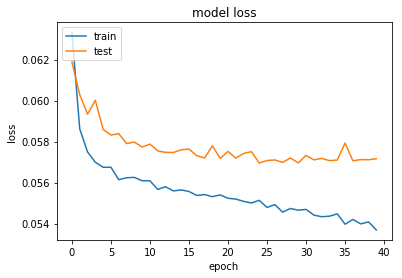

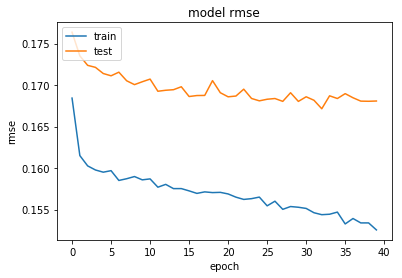

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  71.29057502746582 s =  1.1881762623786927 min =  0.01980293783876631 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.06266659924277782
Delay 100 ms: 0.00519830169499369
Delay 200 ms: 0.015400021981476528
Delay 300 ms: 0.027634619002043087
Delay 400 ms: 0.04092787264545519
Delay 500 ms: 0.054710232734293596
Delay 600 ms: 0.06874130169211891
Delay 700 ms: 0.08283042625430224
Delay 800 ms: 0.09682008153980115
Delay 900 ms: 0.11054122662989686
Delay 1000 ms: 0.12386190825339721

RMSE
Average rmse: 0.13023796321861084
Delay 100 ms: 0.015604024635918133
Delay 200 ms: 0.03242505815488157
Delay 300 ms: 0.05386696893355823
Delay 400 ms: 0.07726639838521929
Delay 500 ms: 0.1011019369633915
Delay 600 ms: 0.12479967631981577
Delay 700 ms: 0.1479961316064603
Delay 800 ms: 0.1704252196216412
Delay 900 ms: 0.19197204526400324
Delay 1000 ms: 0.21253558841996756

SMAPE
Average smape: 13.662907227586842
Delay 100 ms: 2.2678094987683184
Delay 200 ms: 5.384786399322939
Delay 300 ms: 8.232103268612278
Delay 400 ms: 10.866017225237957
Delay 500 ms: 13.297813160742885
Delay 600 ms: 15.493433989030557
Del

(6053, 25, 3) (6053, 10, 3)


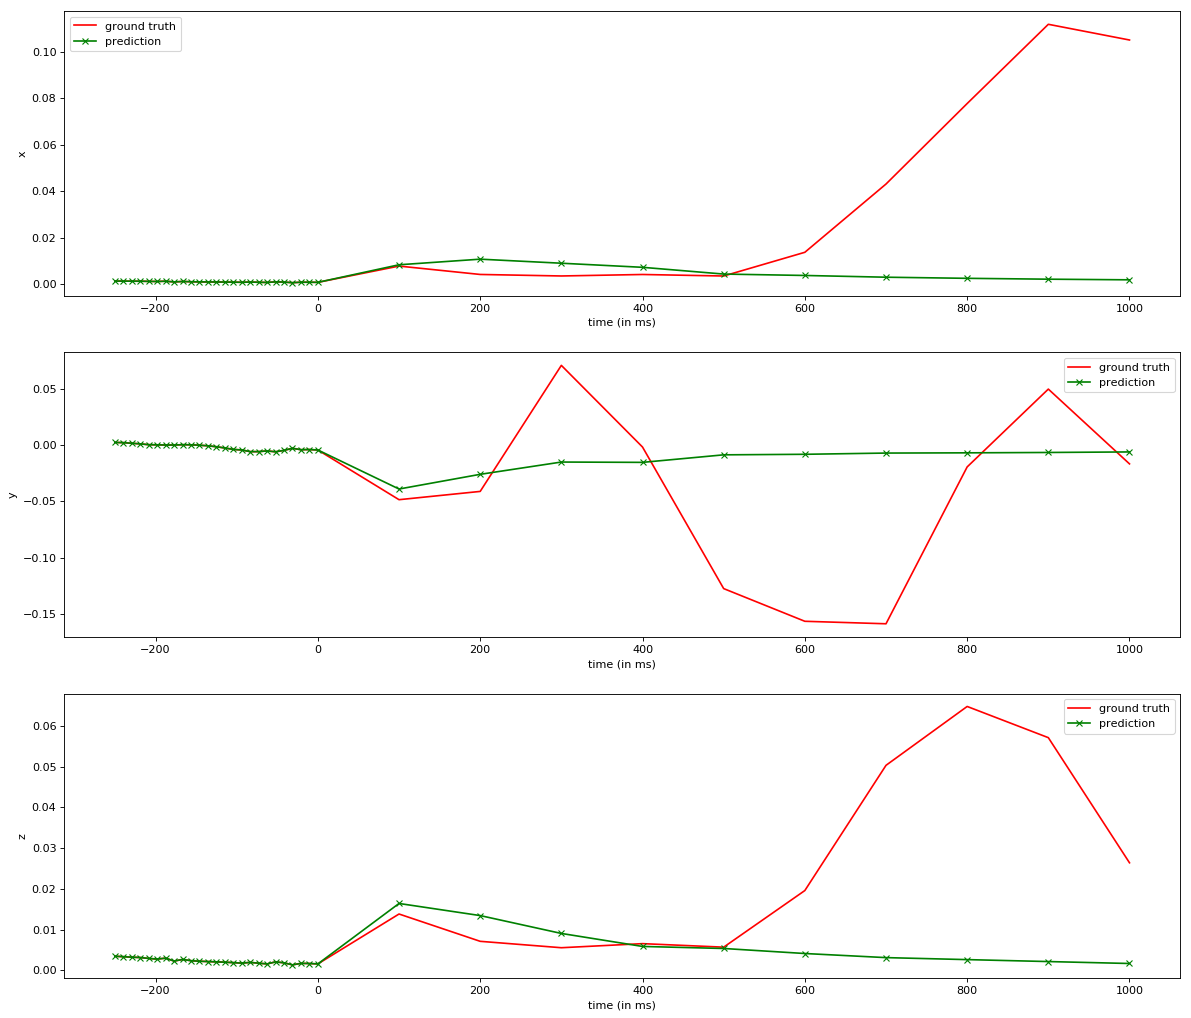

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data